<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, flat_field step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and flat_field validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
import shutil
import os
from tempfile import TemporaryDirectory

use_tempdir = True
if use_tempdir:
    # Create temporary directory
    data_dir = TemporaryDirectory()
    # Save original directory
    orig_dir = os.getcwd()
    # Move to new directory
    os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
import warnings
import psutil
from astropy.io import fits

# Only print a DeprecationWarning the first time it shows up, not every time.
with warnings.catch_warnings():
    warnings.simplefilter("once", category=DeprecationWarning)
    import jwst
    from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
    from jwst.pipeline.calwebb_spec2 import Spec2Pipeline
    from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
    from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
    from jwst.extract_2d.extract_2d_step import Extract2dStep
    from jwst.srctype.srctype_step import SourceTypeStep
    from jwst.wavecorr.wavecorr_step import WavecorrStep
    from jwst.flatfield.flat_field_step import FlatFieldStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata



In [4]:
# Print versions used for the pipeline and NPTT

pipeline_version = jwst.__version__
nptt_version = nptt.__version__

print("Using jwst pipeline version: ", pipeline_version)
print("Using NPTT version: ", nptt_version)

Using jwst pipeline version:  1.7.2
Using NPTT version:  2.0.1


<a id="intro_ID"></a>
# Test Description

The test is a direct comparison of the result of our implementation of the flat field step algorithm versus the pipeline's implementation, i.e.: 
              difference =  absolute( Flat_nirspec_implementation - Flat_pipeline)

We expect the absolute difference to be of the order of 1x10^-6. We set this threshold by assuming that the difference should yield computer precision 1x10^-7 numbers. We then relaxed one order of magnitude due to interpolation differences in the algorithms.

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```flattest_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```flattest_ifu.py```.

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flatfield


### Test Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Flat+Field+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the flat_field step, use the command:

$ strun jwst.flat_field.FlatFieldStep jwtest_extract_2d.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.flat_field.flat_field_step import FlatFieldStep
 
$\gt$ FlatFieldStep.call(jwtest_extract_2d.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:
- output_directory = string, path where you want intermediary files and plots to be saved in, if writefile=True
- input_file = string or object, this is the output file from the previous step, e.g. jwtest1_NRS1_extract2d.fits
- dflat_path = string, path of where the D-flat reference fits files
- sflat_path = string, path of where the S-flat reference fits files
- fflat_path = string, path of where the F-flat reference fits files
- writefile = boolean, if True writes the fits files of the calculated flat, and the difference jpeg images
- save_figs = boolean, whether to save plots or not
- show_figs = boolean, whether to show plots or not 
- threshold_diff = float, threshold difference between pipeline output and ESA file


<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS_BOTS_G235H_F170LP


[Top of Page](#title_ID)

In [5]:
testing_data = {

                'bots_g235h_f170lp':{
                                  'uncal_file_nrs1': 'bots_g235h_f170lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'bots_g235h_f170lp_nrs2_uncal.fits',
                                  'sflat_nrs1': 'nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs1_f_01.01.fits',
                                  'sflat_nrs2': 'nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits',
                                  'fflat': 'nirspec_FS_fflat_F170LP_01.01.fits',
                                  'msa_shutter_config': None }

                }

               


In [6]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'sflat_nrs1', 'fflat', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data
    

In [7]:
# set the D-flat path (used for all test data)
print('Getting D-Flats from Artifactory...')

dflat_nrs1 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs1_f_01.03.fits')

dflat_nrs2 = get_bigdata('jwst_validation_notebooks',
                         'validation_data',
                         'nirspec_data', 
                         'nirspec_dflat_nrs2_f_01.03.fits')
print('Got D-flats')

# set NPTT switches for this test and other variables
writefile = False
save_figs = False
show_figs = True
results_dict = {}
detectors = ['nrs1', 'nrs2']


Getting D-Flats from Artifactory...


Got D-flats


Starting to run pipeline and test for mode:  bots_g235h_f170lp
Testing files for detector:  nrs1


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/bots_g235h_f170lp_nrs1_uncal.fits
Filter =  F170LP
Running the detector1 pipeline...


2022-10-05 10:54:01,238 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0003.asdf


2022-10-05 10:54:01,264 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-05 10:54:01,265 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-05 10:54:01,266 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-05 10:54:01,267 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-05 10:54:01,268 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-05 10:54:01,269 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-05 10:54:01,270 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-05 10:54:01,271 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-05 10:54:01,272 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-05 10:54:01,273 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-05 10:54:01,274 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-05 10:54:01,275 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-05 10:54:01,276 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-05 10:54:01,277 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-05 10:54:01,278 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-05 10:54:01,279 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-05 10:54:01,280 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-05 10:54:01,496 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/bots_g235h_f170lp_nrs1_uncal.fits',).


2022-10-05 10:54:01,506 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-05 10:54:02,631 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2022-10-05 10:54:02,645 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0066.fits'.


2022-10-05 10:54:02,647 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits'.


2022-10-05 10:54:02,648 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0008.fits'.


2022-10-05 10:54:02,649 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits'.


2022-10-05 10:54:02,650 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits'.


2022-10-05 10:54:02,652 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-05 10:54:02,652 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-05 10:54:02,652 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0010.fits'.


2022-10-05 10:54:02,654 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0077.fits'.


2022-10-05 10:54:02,655 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-05 10:54:05,348 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:05,349 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 10:54:07,358 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-05 10:54:07,359 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-05 10:54:07,362 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-05 10:54:07,551 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:07,552 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 10:54:07,574 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0024.fits


2022-10-05 10:54:10,057 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-10-05 10:54:10,072 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-05 10:54:10,255 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:10,257 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'n_pix_grow_sat': 1}


2022-10-05 10:54:10,279 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0010.fits


2022-10-05 10:54:12,622 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-10-05 10:54:26,326 - stpipe.Detector1Pipeline.saturation - INFO - Detected 498 saturated pixels


2022-10-05 10:54:26,625 - stpipe.Detector1Pipeline.saturation - INFO - Detected 13 A/D floor pixels


2022-10-05 10:54:26,632 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-05 10:54:26,815 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:26,816 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 10:54:26,817 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-05 10:54:26,820 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-05 10:54:26,971 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:26,972 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 10:54:26,996 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0077.fits


2022-10-05 10:54:29,679 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-05 10:54:29,872 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:29,874 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-05 10:54:31,878 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2022-10-05 10:54:31,884 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2022-10-05 10:54:31,884 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-05 10:54:31,885 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-05 10:54:31,886 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-05 10:54:31,887 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-05 10:54:31,887 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-05 10:54:31,887 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-05 10:54:31,888 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-05 10:54:31,926 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-05 10:54:32,156 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:32,157 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 10:54:32,183 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0008.fits


2022-10-05 10:54:40,662 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-05 10:54:40,930 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:40,931 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'dark_output': None}


2022-10-05 10:54:40,959 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0066.fits


2022-10-05 10:54:41,771 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3000, ngroups=3, nframes=1, groupgap=0


2022-10-05 10:54:41,771 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=32, nframes=1, groupgap=0


2022-10-05 10:54:47,232 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-05 10:54:47,453 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 10:54:47,455 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-05 10:54:47,465 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-05 10:54:47,479 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-05 10:54:47,796 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits


2022-10-05 10:54:50,037 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-10-05 10:54:50,038 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-10-05 10:54:51,138 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-05 10:54:52,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-05 10:54:52,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:52,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:52,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4517 pixels with at least one CR from three groups.


2022-10-05 10:54:52,499 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-05 10:54:52,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:52,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:52,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 10:54:52,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-05 10:54:52,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:52,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:52,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21187 pixels with at least one CR from three groups.


2022-10-05 10:54:53,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-05 10:54:53,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:53,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:53,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 10:54:53,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-10-05 10:54:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60544 pixels with at least one CR from three groups.


2022-10-05 10:54:55,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-10-05 10:54:55,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:55,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:55,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1942 pixels with at least one CR from three groups.


2022-10-05 10:54:55,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-10-05 10:54:55,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:55,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:55,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 10:54:55,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-10-05 10:54:55,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:55,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:55,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1692 pixels with at least one CR from three groups.


2022-10-05 10:54:55,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-10-05 10:54:55,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:55,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:55,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 10:54:55,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-10-05 10:54:55,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:55,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:55,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57505 pixels with at least one CR from three groups.


2022-10-05 10:54:57,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-10-05 10:54:57,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:57,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:57,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10392 pixels with at least one CR from three groups.


2022-10-05 10:54:57,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-10-05 10:54:57,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:57,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:57,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58454 pixels with at least one CR from three groups.


2022-10-05 10:54:58,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-10-05 10:54:59,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:59,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:59,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 10:54:59,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-10-05 10:54:59,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:59,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:59,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6021 pixels with at least one CR from three groups.


2022-10-05 10:54:59,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-10-05 10:54:59,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:59,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:59,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 564 pixels with at least one CR from three groups.


2022-10-05 10:54:59,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-10-05 10:54:59,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:54:59,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:54:59,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45839 pixels with at least one CR from three groups.


2022-10-05 10:55:00,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-10-05 10:55:00,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:00,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:00,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 10:55:00,506 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-10-05 10:55:00,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:00,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:00,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 10:55:00,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-10-05 10:55:00,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:00,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:00,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 10:55:00,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-10-05 10:55:00,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:00,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:00,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61782 pixels with at least one CR from three groups.


2022-10-05 10:55:03,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-10-05 10:55:03,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:03,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:03,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:55:03,066 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-10-05 10:55:03,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:03,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:03,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27647 pixels with at least one CR from three groups.


2022-10-05 10:55:03,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-10-05 10:55:03,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:03,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:03,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 622 pixels with at least one CR from three groups.


2022-10-05 10:55:03,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-10-05 10:55:03,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:03,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:03,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30402 pixels with at least one CR from three groups.


2022-10-05 10:55:04,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-10-05 10:55:04,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:04,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:04,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21934 pixels with at least one CR from three groups.


2022-10-05 10:55:05,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:


2022-10-05 10:55:05,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3637 pixels with at least one CR from three groups.


2022-10-05 10:55:05,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 27:


2022-10-05 10:55:05,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2473 pixels with at least one CR from three groups.


2022-10-05 10:55:05,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 28:


2022-10-05 10:55:05,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:55:05,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 29:


2022-10-05 10:55:05,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4324 pixels with at least one CR from three groups.


2022-10-05 10:55:05,631 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 30:


2022-10-05 10:55:05,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:55:05,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 31:


2022-10-05 10:55:05,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 10:55:05,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 32:


2022-10-05 10:55:05,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:05,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:05,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45059 pixels with at least one CR from three groups.


2022-10-05 10:55:06,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 33:


2022-10-05 10:55:06,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:06,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:06,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1176 pixels with at least one CR from three groups.


2022-10-05 10:55:06,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 34:


2022-10-05 10:55:06,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:06,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:06,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.


2022-10-05 10:55:06,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 35:


2022-10-05 10:55:06,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:06,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:06,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3535 pixels with at least one CR from three groups.


2022-10-05 10:55:07,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 36:


2022-10-05 10:55:07,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:07,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:07,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9668 pixels with at least one CR from three groups.


2022-10-05 10:55:07,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 37:


2022-10-05 10:55:07,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:07,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:07,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59321 pixels with at least one CR from three groups.


2022-10-05 10:55:09,229 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 38:


2022-10-05 10:55:09,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:09,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:09,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 10:55:09,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 39:


2022-10-05 10:55:09,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:09,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:09,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7398 pixels with at least one CR from three groups.


2022-10-05 10:55:09,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:


2022-10-05 10:55:09,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:09,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:09,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 10:55:09,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:


2022-10-05 10:55:09,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:09,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:09,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8904 pixels with at least one CR from three groups.


2022-10-05 10:55:09,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 42:


2022-10-05 10:55:09,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:09,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:09,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39461 pixels with at least one CR from three groups.


2022-10-05 10:55:10,806 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 43:


2022-10-05 10:55:10,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:10,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:10,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 10:55:10,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 44:


2022-10-05 10:55:10,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:10,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:10,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49321 pixels with at least one CR from three groups.


2022-10-05 10:55:12,136 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 45:


2022-10-05 10:55:12,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 10:55:12,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 46:


2022-10-05 10:55:12,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14699 pixels with at least one CR from three groups.


2022-10-05 10:55:12,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 47:


2022-10-05 10:55:12,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 10:55:12,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 48:


2022-10-05 10:55:12,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2873 pixels with at least one CR from three groups.


2022-10-05 10:55:12,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 49:


2022-10-05 10:55:12,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 10:55:12,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 50:


2022-10-05 10:55:12,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:12,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:12,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58193 pixels with at least one CR from three groups.


2022-10-05 10:55:14,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 51:


2022-10-05 10:55:14,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 10:55:14,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 52:


2022-10-05 10:55:14,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 624 pixels with at least one CR from three groups.


2022-10-05 10:55:14,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 53:


2022-10-05 10:55:14,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10390 pixels with at least one CR from three groups.


2022-10-05 10:55:14,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 54:


2022-10-05 10:55:14,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 10:55:14,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:


2022-10-05 10:55:14,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3076 pixels with at least one CR from three groups.


2022-10-05 10:55:14,925 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:


2022-10-05 10:55:14,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 466 pixels with at least one CR from three groups.


2022-10-05 10:55:14,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 57:


2022-10-05 10:55:14,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 10:55:14,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 58:


2022-10-05 10:55:14,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:14,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:14,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4824 pixels with at least one CR from three groups.


2022-10-05 10:55:15,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 59:


2022-10-05 10:55:15,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 494 pixels with at least one CR from three groups.


2022-10-05 10:55:15,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 60:


2022-10-05 10:55:15,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 10:55:15,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 61:


2022-10-05 10:55:15,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 10:55:15,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 62:


2022-10-05 10:55:15,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8099 pixels with at least one CR from three groups.


2022-10-05 10:55:15,490 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 63:


2022-10-05 10:55:15,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:55:15,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 64:


2022-10-05 10:55:15,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1614 pixels with at least one CR from three groups.


2022-10-05 10:55:15,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 65:


2022-10-05 10:55:15,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:15,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:15,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27215 pixels with at least one CR from three groups.


2022-10-05 10:55:16,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 66:


2022-10-05 10:55:16,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:16,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:16,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3279 pixels with at least one CR from three groups.


2022-10-05 10:55:16,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 67:


2022-10-05 10:55:16,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:16,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:16,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13577 pixels with at least one CR from three groups.


2022-10-05 10:55:16,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 68:


2022-10-05 10:55:16,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:16,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:16,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 10:55:16,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 69:


2022-10-05 10:55:16,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:16,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:16,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21959 pixels with at least one CR from three groups.


2022-10-05 10:55:17,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 70:


2022-10-05 10:55:17,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 10:55:17,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 71:


2022-10-05 10:55:17,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 771 pixels with at least one CR from three groups.


2022-10-05 10:55:17,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 72:


2022-10-05 10:55:17,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8448 pixels with at least one CR from three groups.


2022-10-05 10:55:17,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 73:


2022-10-05 10:55:17,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1318 pixels with at least one CR from three groups.


2022-10-05 10:55:17,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 74:


2022-10-05 10:55:17,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 613 pixels with at least one CR from three groups.


2022-10-05 10:55:17,844 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 75:


2022-10-05 10:55:17,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:17,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:17,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5140 pixels with at least one CR from three groups.


2022-10-05 10:55:17,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 76:


2022-10-05 10:55:18,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:18,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:18,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57988 pixels with at least one CR from three groups.


2022-10-05 10:55:19,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 77:


2022-10-05 10:55:19,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:19,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:19,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37737 pixels with at least one CR from three groups.


2022-10-05 10:55:20,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 78:


2022-10-05 10:55:20,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 10:55:20,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 79:


2022-10-05 10:55:20,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5959 pixels with at least one CR from three groups.


2022-10-05 10:55:20,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 80:


2022-10-05 10:55:20,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 10:55:20,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 81:


2022-10-05 10:55:20,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 10:55:20,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 82:


2022-10-05 10:55:20,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 10:55:20,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 83:


2022-10-05 10:55:20,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 693 pixels with at least one CR from three groups.


2022-10-05 10:55:20,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 84:


2022-10-05 10:55:20,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.


2022-10-05 10:55:20,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 85:


2022-10-05 10:55:20,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:20,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:20,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.


2022-10-05 10:55:21,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 86:


2022-10-05 10:55:21,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 10:55:21,040 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 87:


2022-10-05 10:55:21,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1338 pixels with at least one CR from three groups.


2022-10-05 10:55:21,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 88:


2022-10-05 10:55:21,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20285 pixels with at least one CR from three groups.


2022-10-05 10:55:21,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 89:


2022-10-05 10:55:21,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 796 pixels with at least one CR from three groups.


2022-10-05 10:55:21,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 90:


2022-10-05 10:55:21,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 10:55:21,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 91:


2022-10-05 10:55:21,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:21,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:21,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11520 pixels with at least one CR from three groups.


2022-10-05 10:55:22,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 92:


2022-10-05 10:55:22,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3134 pixels with at least one CR from three groups.


2022-10-05 10:55:22,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 93:


2022-10-05 10:55:22,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 761 pixels with at least one CR from three groups.


2022-10-05 10:55:22,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 94:


2022-10-05 10:55:22,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1138 pixels with at least one CR from three groups.


2022-10-05 10:55:22,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 95:


2022-10-05 10:55:22,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12953 pixels with at least one CR from three groups.


2022-10-05 10:55:22,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 96:


2022-10-05 10:55:22,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 708 pixels with at least one CR from three groups.


2022-10-05 10:55:22,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 97:


2022-10-05 10:55:22,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 670 pixels with at least one CR from three groups.


2022-10-05 10:55:22,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 98:


2022-10-05 10:55:22,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 10:55:22,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 99:


2022-10-05 10:55:22,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49084 pixels with at least one CR from three groups.


2022-10-05 10:55:24,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 100:


2022-10-05 10:55:24,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29759 pixels with at least one CR from three groups.


2022-10-05 10:55:24,799 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 101:


2022-10-05 10:55:24,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 10:55:24,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 102:


2022-10-05 10:55:24,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 561 pixels with at least one CR from three groups.


2022-10-05 10:55:24,872 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 103:


2022-10-05 10:55:24,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:55:24,901 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 104:


2022-10-05 10:55:24,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 10:55:24,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 105:


2022-10-05 10:55:24,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:24,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:24,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3492 pixels with at least one CR from three groups.


2022-10-05 10:55:25,048 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 106:


2022-10-05 10:55:25,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1901 pixels with at least one CR from three groups.


2022-10-05 10:55:25,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 107:


2022-10-05 10:55:25,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 10:55:25,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 108:


2022-10-05 10:55:25,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 10:55:25,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 109:


2022-10-05 10:55:25,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 646 pixels with at least one CR from three groups.


2022-10-05 10:55:25,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 110:


2022-10-05 10:55:25,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 664 pixels with at least one CR from three groups.


2022-10-05 10:55:25,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 111:


2022-10-05 10:55:25,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:55:25,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 112:


2022-10-05 10:55:25,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8156 pixels with at least one CR from three groups.


2022-10-05 10:55:25,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 113:


2022-10-05 10:55:25,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 10:55:25,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 114:


2022-10-05 10:55:25,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9897 pixels with at least one CR from three groups.


2022-10-05 10:55:25,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 115:


2022-10-05 10:55:25,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:25,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:25,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15043 pixels with at least one CR from three groups.


2022-10-05 10:55:26,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 116:


2022-10-05 10:55:26,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:26,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:26,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32652 pixels with at least one CR from three groups.


2022-10-05 10:55:27,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 117:


2022-10-05 10:55:27,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 10:55:27,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 118:


2022-10-05 10:55:27,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 10:55:27,187 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 119:


2022-10-05 10:55:27,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 824 pixels with at least one CR from three groups.


2022-10-05 10:55:27,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 120:


2022-10-05 10:55:27,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17927 pixels with at least one CR from three groups.


2022-10-05 10:55:27,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 121:


2022-10-05 10:55:27,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 10:55:27,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 122:


2022-10-05 10:55:27,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:27,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:27,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57022 pixels with at least one CR from three groups.


2022-10-05 10:55:29,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 123:


2022-10-05 10:55:29,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:29,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:29,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 842 pixels with at least one CR from three groups.


2022-10-05 10:55:29,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 124:


2022-10-05 10:55:29,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:29,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:29,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24616 pixels with at least one CR from three groups.


2022-10-05 10:55:30,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 125:


2022-10-05 10:55:30,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4899 pixels with at least one CR from three groups.


2022-10-05 10:55:30,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 126:


2022-10-05 10:55:30,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2432 pixels with at least one CR from three groups.


2022-10-05 10:55:30,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 127:


2022-10-05 10:55:30,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 739 pixels with at least one CR from three groups.


2022-10-05 10:55:30,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 128:


2022-10-05 10:55:30,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.


2022-10-05 10:55:30,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 129:


2022-10-05 10:55:30,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6772 pixels with at least one CR from three groups.


2022-10-05 10:55:30,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 130:


2022-10-05 10:55:30,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 573 pixels with at least one CR from three groups.


2022-10-05 10:55:30,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 131:


2022-10-05 10:55:30,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 933 pixels with at least one CR from three groups.


2022-10-05 10:55:30,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 132:


2022-10-05 10:55:30,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:30,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:30,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19215 pixels with at least one CR from three groups.


2022-10-05 10:55:31,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 133:


2022-10-05 10:55:31,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:31,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:31,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 614 pixels with at least one CR from three groups.


2022-10-05 10:55:31,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 134:


2022-10-05 10:55:31,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:31,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:31,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46789 pixels with at least one CR from three groups.


2022-10-05 10:55:32,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 135:


2022-10-05 10:55:32,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10989 pixels with at least one CR from three groups.


2022-10-05 10:55:32,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 136:


2022-10-05 10:55:32,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 10:55:32,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 137:


2022-10-05 10:55:32,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 10:55:32,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 138:


2022-10-05 10:55:32,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 10:55:32,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 139:


2022-10-05 10:55:32,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 973 pixels with at least one CR from three groups.


2022-10-05 10:55:32,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 140:


2022-10-05 10:55:32,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:55:32,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 141:


2022-10-05 10:55:32,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 635 pixels with at least one CR from three groups.


2022-10-05 10:55:32,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 142:


2022-10-05 10:55:32,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 10:55:32,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 143:


2022-10-05 10:55:32,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:32,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:32,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18871 pixels with at least one CR from three groups.


2022-10-05 10:55:33,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 144:


2022-10-05 10:55:33,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:33,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:33,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 10:55:33,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 145:


2022-10-05 10:55:33,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:33,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:33,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20348 pixels with at least one CR from three groups.


2022-10-05 10:55:34,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 146:


2022-10-05 10:55:34,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:34,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:34,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 10:55:34,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 147:


2022-10-05 10:55:34,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:34,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:34,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31043 pixels with at least one CR from three groups.


2022-10-05 10:55:34,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 148:


2022-10-05 10:55:34,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:34,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:34,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 10:55:34,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 149:


2022-10-05 10:55:34,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:34,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:34,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7720 pixels with at least one CR from three groups.


2022-10-05 10:55:35,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 150:


2022-10-05 10:55:35,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:35,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:35,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2376 pixels with at least one CR from three groups.


2022-10-05 10:55:35,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 151:


2022-10-05 10:55:35,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:35,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:35,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:55:35,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 152:


2022-10-05 10:55:35,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:35,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:35,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22143 pixels with at least one CR from three groups.


2022-10-05 10:55:35,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 153:


2022-10-05 10:55:35,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:35,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:35,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:55:35,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 154:


2022-10-05 10:55:35,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:35,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:35,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52620 pixels with at least one CR from three groups.


2022-10-05 10:55:37,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 155:


2022-10-05 10:55:37,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5436 pixels with at least one CR from three groups.


2022-10-05 10:55:37,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 156:


2022-10-05 10:55:37,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 862 pixels with at least one CR from three groups.


2022-10-05 10:55:37,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 157:


2022-10-05 10:55:37,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12769 pixels with at least one CR from three groups.


2022-10-05 10:55:37,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 158:


2022-10-05 10:55:37,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 10:55:37,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 159:


2022-10-05 10:55:37,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 744 pixels with at least one CR from three groups.


2022-10-05 10:55:37,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 160:


2022-10-05 10:55:37,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:37,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:37,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10267 pixels with at least one CR from three groups.


2022-10-05 10:55:38,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 161:


2022-10-05 10:55:38,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:38,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:38,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 553 pixels with at least one CR from three groups.


2022-10-05 10:55:38,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 162:


2022-10-05 10:55:38,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:38,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:38,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7731 pixels with at least one CR from three groups.


2022-10-05 10:55:38,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 163:


2022-10-05 10:55:38,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:38,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:38,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36200 pixels with at least one CR from three groups.


2022-10-05 10:55:39,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 164:


2022-10-05 10:55:39,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:39,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:39,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25433 pixels with at least one CR from three groups.


2022-10-05 10:55:40,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 165:


2022-10-05 10:55:40,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:40,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:40,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61193 pixels with at least one CR from three groups.


2022-10-05 10:55:42,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 166:


2022-10-05 10:55:42,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 10:55:42,319 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 167:


2022-10-05 10:55:42,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12939 pixels with at least one CR from three groups.


2022-10-05 10:55:42,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 168:


2022-10-05 10:55:42,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 10:55:42,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 169:


2022-10-05 10:55:42,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 747 pixels with at least one CR from three groups.


2022-10-05 10:55:42,739 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 170:


2022-10-05 10:55:42,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 576 pixels with at least one CR from three groups.


2022-10-05 10:55:42,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 171:


2022-10-05 10:55:42,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1585 pixels with at least one CR from three groups.


2022-10-05 10:55:42,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 172:


2022-10-05 10:55:42,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:42,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:42,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35565 pixels with at least one CR from three groups.


2022-10-05 10:55:43,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 173:


2022-10-05 10:55:43,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 10:55:43,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 174:


2022-10-05 10:55:43,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:55:43,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 175:


2022-10-05 10:55:43,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 685 pixels with at least one CR from three groups.


2022-10-05 10:55:43,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 176:


2022-10-05 10:55:43,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 896 pixels with at least one CR from three groups.


2022-10-05 10:55:43,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 177:


2022-10-05 10:55:43,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 10:55:43,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 178:


2022-10-05 10:55:43,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 10:55:43,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 179:


2022-10-05 10:55:43,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:43,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:43,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1615 pixels with at least one CR from three groups.


2022-10-05 10:55:44,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 180:


2022-10-05 10:55:44,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 614 pixels with at least one CR from three groups.


2022-10-05 10:55:44,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 181:


2022-10-05 10:55:44,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:55:44,101 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 182:


2022-10-05 10:55:44,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3415 pixels with at least one CR from three groups.


2022-10-05 10:55:44,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 183:


2022-10-05 10:55:44,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 10:55:44,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 184:


2022-10-05 10:55:44,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 494 pixels with at least one CR from three groups.


2022-10-05 10:55:44,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 185:


2022-10-05 10:55:44,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:44,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:44,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45703 pixels with at least one CR from three groups.


2022-10-05 10:55:45,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 186:


2022-10-05 10:55:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2960 pixels with at least one CR from three groups.


2022-10-05 10:55:45,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 187:


2022-10-05 10:55:45,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:45,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:45,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 10:55:45,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 188:


2022-10-05 10:55:45,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:45,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:45,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 10:55:45,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 189:


2022-10-05 10:55:45,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:45,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:45,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47915 pixels with at least one CR from three groups.


2022-10-05 10:55:47,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 190:


2022-10-05 10:55:47,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:47,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:47,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4573 pixels with at least one CR from three groups.


2022-10-05 10:55:47,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 191:


2022-10-05 10:55:47,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:47,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:47,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 929 pixels with at least one CR from three groups.


2022-10-05 10:55:47,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 192:


2022-10-05 10:55:47,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:47,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:47,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 951 pixels with at least one CR from three groups.


2022-10-05 10:55:47,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 193:


2022-10-05 10:55:47,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:47,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:47,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.


2022-10-05 10:55:47,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 194:


2022-10-05 10:55:47,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:47,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:47,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40505 pixels with at least one CR from three groups.


2022-10-05 10:55:48,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 195:


2022-10-05 10:55:48,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:48,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:48,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54765 pixels with at least one CR from three groups.


2022-10-05 10:55:50,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 196:


2022-10-05 10:55:50,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 10:55:50,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 197:


2022-10-05 10:55:50,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1222 pixels with at least one CR from three groups.


2022-10-05 10:55:50,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 198:


2022-10-05 10:55:50,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2717 pixels with at least one CR from three groups.


2022-10-05 10:55:50,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 199:


2022-10-05 10:55:50,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8408 pixels with at least one CR from three groups.


2022-10-05 10:55:50,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 200:


2022-10-05 10:55:50,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:55:50,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 201:


2022-10-05 10:55:50,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:50,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:50,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25636 pixels with at least one CR from three groups.


2022-10-05 10:55:51,612 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 202:


2022-10-05 10:55:51,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:51,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:51,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 10:55:51,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 203:


2022-10-05 10:55:51,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:51,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:51,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 10:55:51,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 204:


2022-10-05 10:55:51,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:51,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:51,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57188 pixels with at least one CR from three groups.


2022-10-05 10:55:53,289 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 205:


2022-10-05 10:55:53,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 10:55:53,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 206:


2022-10-05 10:55:53,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1004 pixels with at least one CR from three groups.


2022-10-05 10:55:53,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 207:


2022-10-05 10:55:53,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1081 pixels with at least one CR from three groups.


2022-10-05 10:55:53,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 208:


2022-10-05 10:55:53,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 494 pixels with at least one CR from three groups.


2022-10-05 10:55:53,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 209:


2022-10-05 10:55:53,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10090 pixels with at least one CR from three groups.


2022-10-05 10:55:53,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 210:


2022-10-05 10:55:53,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:53,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:53,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62411 pixels with at least one CR from three groups.


2022-10-05 10:55:56,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 211:


2022-10-05 10:55:56,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:56,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:56,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:55:56,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 212:


2022-10-05 10:55:56,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:56,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:56,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10440 pixels with at least one CR from three groups.


2022-10-05 10:55:56,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 213:


2022-10-05 10:55:56,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:56,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:56,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3542 pixels with at least one CR from three groups.


2022-10-05 10:55:56,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 214:


2022-10-05 10:55:56,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:56,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:56,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:55:56,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 215:


2022-10-05 10:55:56,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:56,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:56,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41926 pixels with at least one CR from three groups.


2022-10-05 10:55:57,902 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 216:


2022-10-05 10:55:57,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:57,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:57,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26624 pixels with at least one CR from three groups.


2022-10-05 10:55:58,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 217:


2022-10-05 10:55:58,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:58,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:58,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 10:55:58,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 218:


2022-10-05 10:55:58,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:58,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:58,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.


2022-10-05 10:55:58,679 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 219:


2022-10-05 10:55:58,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:58,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:58,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47097 pixels with at least one CR from three groups.


2022-10-05 10:55:59,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 220:


2022-10-05 10:55:59,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:59,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:59,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 720 pixels with at least one CR from three groups.


2022-10-05 10:55:59,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 221:


2022-10-05 10:55:59,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:55:59,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:55:59,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20477 pixels with at least one CR from three groups.


2022-10-05 10:56:00,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 222:


2022-10-05 10:56:00,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2179 pixels with at least one CR from three groups.


2022-10-05 10:56:00,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 223:


2022-10-05 10:56:00,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 10:56:00,628 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 224:


2022-10-05 10:56:00,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 659 pixels with at least one CR from three groups.


2022-10-05 10:56:00,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 225:


2022-10-05 10:56:00,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1317 pixels with at least one CR from three groups.


2022-10-05 10:56:00,718 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 226:


2022-10-05 10:56:00,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1237 pixels with at least one CR from three groups.


2022-10-05 10:56:00,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 227:


2022-10-05 10:56:00,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2205 pixels with at least one CR from three groups.


2022-10-05 10:56:00,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 228:


2022-10-05 10:56:00,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 10:56:00,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 229:


2022-10-05 10:56:00,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:00,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:00,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29699 pixels with at least one CR from three groups.


2022-10-05 10:56:01,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 230:


2022-10-05 10:56:01,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:01,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:01,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1415 pixels with at least one CR from three groups.


2022-10-05 10:56:01,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 231:


2022-10-05 10:56:01,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:01,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:01,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 10:56:01,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 232:


2022-10-05 10:56:01,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:01,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:01,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2554 pixels with at least one CR from three groups.


2022-10-05 10:56:01,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 233:


2022-10-05 10:56:01,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:01,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:01,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39780 pixels with at least one CR from three groups.


2022-10-05 10:56:02,934 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 234:


2022-10-05 10:56:02,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:02,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:02,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:56:02,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 235:


2022-10-05 10:56:02,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:02,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:02,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:56:03,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 236:


2022-10-05 10:56:03,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:56:03,047 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 237:


2022-10-05 10:56:03,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12919 pixels with at least one CR from three groups.


2022-10-05 10:56:03,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 238:


2022-10-05 10:56:03,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1676 pixels with at least one CR from three groups.


2022-10-05 10:56:03,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 239:


2022-10-05 10:56:03,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15326 pixels with at least one CR from three groups.


2022-10-05 10:56:03,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 240:


2022-10-05 10:56:03,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:56:03,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 241:


2022-10-05 10:56:03,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:03,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:03,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56105 pixels with at least one CR from three groups.


2022-10-05 10:56:05,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 242:


2022-10-05 10:56:05,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:05,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:05,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16865 pixels with at least one CR from three groups.


2022-10-05 10:56:05,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 243:


2022-10-05 10:56:05,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:05,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:05,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 10:56:05,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 244:


2022-10-05 10:56:05,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:05,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:05,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53500 pixels with at least one CR from three groups.


2022-10-05 10:56:07,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 245:


2022-10-05 10:56:07,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:07,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:07,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52500 pixels with at least one CR from three groups.


2022-10-05 10:56:08,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 246:


2022-10-05 10:56:08,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:08,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:08,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46168 pixels with at least one CR from three groups.


2022-10-05 10:56:10,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 247:


2022-10-05 10:56:10,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:56:10,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 248:


2022-10-05 10:56:10,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:56:10,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 249:


2022-10-05 10:56:10,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 10:56:10,144 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 250:


2022-10-05 10:56:10,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5218 pixels with at least one CR from three groups.


2022-10-05 10:56:10,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 251:


2022-10-05 10:56:10,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22993 pixels with at least one CR from three groups.


2022-10-05 10:56:10,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 252:


2022-10-05 10:56:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6046 pixels with at least one CR from three groups.


2022-10-05 10:56:11,122 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 253:


2022-10-05 10:56:11,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:11,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:11,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2902 pixels with at least one CR from three groups.


2022-10-05 10:56:11,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 254:


2022-10-05 10:56:11,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:11,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:11,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38649 pixels with at least one CR from three groups.


2022-10-05 10:56:12,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 255:


2022-10-05 10:56:12,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:12,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:12,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60921 pixels with at least one CR from three groups.


2022-10-05 10:56:14,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 256:


2022-10-05 10:56:14,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:14,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:14,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42711 pixels with at least one CR from three groups.


2022-10-05 10:56:15,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 257:


2022-10-05 10:56:15,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:15,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:15,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60250 pixels with at least one CR from three groups.


2022-10-05 10:56:17,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 258:


2022-10-05 10:56:17,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:17,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:17,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 10:56:17,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 259:


2022-10-05 10:56:17,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:17,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:17,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21676 pixels with at least one CR from three groups.


2022-10-05 10:56:18,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 260:


2022-10-05 10:56:18,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:18,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:18,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2689 pixels with at least one CR from three groups.


2022-10-05 10:56:18,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 261:


2022-10-05 10:56:18,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:18,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:18,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19452 pixels with at least one CR from three groups.


2022-10-05 10:56:18,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 262:


2022-10-05 10:56:18,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:18,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:18,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 10:56:18,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 263:


2022-10-05 10:56:18,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:18,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:18,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3919 pixels with at least one CR from three groups.


2022-10-05 10:56:18,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 264:


2022-10-05 10:56:18,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:18,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:18,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44138 pixels with at least one CR from three groups.


2022-10-05 10:56:20,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 265:


2022-10-05 10:56:20,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:20,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:20,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2086 pixels with at least one CR from three groups.


2022-10-05 10:56:20,136 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 266:


2022-10-05 10:56:20,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:20,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:20,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19418 pixels with at least one CR from three groups.


2022-10-05 10:56:20,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 267:


2022-10-05 10:56:20,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:20,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:20,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17888 pixels with at least one CR from three groups.


2022-10-05 10:56:21,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 268:


2022-10-05 10:56:21,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:21,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:21,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7328 pixels with at least one CR from three groups.


2022-10-05 10:56:21,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 269:


2022-10-05 10:56:21,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:21,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:21,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 10:56:21,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 270:


2022-10-05 10:56:21,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:21,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:21,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5830 pixels with at least one CR from three groups.


2022-10-05 10:56:21,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 271:


2022-10-05 10:56:21,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:21,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:21,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50954 pixels with at least one CR from three groups.


2022-10-05 10:56:22,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 272:


2022-10-05 10:56:22,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:22,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:22,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 10:56:22,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 273:


2022-10-05 10:56:22,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:22,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:22,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1087 pixels with at least one CR from three groups.


2022-10-05 10:56:23,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 274:


2022-10-05 10:56:23,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:23,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:23,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50746 pixels with at least one CR from three groups.


2022-10-05 10:56:24,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 275:


2022-10-05 10:56:24,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:24,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:24,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 687 pixels with at least one CR from three groups.


2022-10-05 10:56:24,431 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 276:


2022-10-05 10:56:24,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:24,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:24,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 10:56:24,470 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 277:


2022-10-05 10:56:24,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:24,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:24,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39952 pixels with at least one CR from three groups.


2022-10-05 10:56:25,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 278:


2022-10-05 10:56:25,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:25,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:25,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 553 pixels with at least one CR from three groups.


2022-10-05 10:56:25,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 279:


2022-10-05 10:56:25,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:25,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:25,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 10:56:25,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 280:


2022-10-05 10:56:25,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:25,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:25,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 10:56:25,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 281:


2022-10-05 10:56:25,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:25,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:25,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 679 pixels with at least one CR from three groups.


2022-10-05 10:56:25,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 282:


2022-10-05 10:56:25,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:25,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:25,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15163 pixels with at least one CR from three groups.


2022-10-05 10:56:26,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 283:


2022-10-05 10:56:26,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 10:56:26,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 284:


2022-10-05 10:56:26,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2920 pixels with at least one CR from three groups.


2022-10-05 10:56:26,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 285:


2022-10-05 10:56:26,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 982 pixels with at least one CR from three groups.


2022-10-05 10:56:26,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 286:


2022-10-05 10:56:26,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 741 pixels with at least one CR from three groups.


2022-10-05 10:56:26,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 287:


2022-10-05 10:56:26,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1798 pixels with at least one CR from three groups.


2022-10-05 10:56:26,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 288:


2022-10-05 10:56:26,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8349 pixels with at least one CR from three groups.


2022-10-05 10:56:26,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 289:


2022-10-05 10:56:26,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 10:56:26,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 290:


2022-10-05 10:56:26,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:26,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:26,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21028 pixels with at least one CR from three groups.


2022-10-05 10:56:27,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 291:


2022-10-05 10:56:27,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:27,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:27,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 10:56:27,332 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 292:


2022-10-05 10:56:27,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:27,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:27,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 646 pixels with at least one CR from three groups.


2022-10-05 10:56:27,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 293:


2022-10-05 10:56:27,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:27,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:27,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10317 pixels with at least one CR from three groups.


2022-10-05 10:56:27,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 294:


2022-10-05 10:56:27,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:27,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:27,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7328 pixels with at least one CR from three groups.


2022-10-05 10:56:27,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 295:


2022-10-05 10:56:27,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:27,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:27,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33769 pixels with at least one CR from three groups.


2022-10-05 10:56:28,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 296:


2022-10-05 10:56:28,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:28,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:28,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 543 pixels with at least one CR from three groups.


2022-10-05 10:56:28,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 297:


2022-10-05 10:56:28,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:28,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:28,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 612 pixels with at least one CR from three groups.


2022-10-05 10:56:28,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 298:


2022-10-05 10:56:28,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:28,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:28,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 10:56:28,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 299:


2022-10-05 10:56:28,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:28,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:28,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20997 pixels with at least one CR from three groups.


2022-10-05 10:56:29,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 300:


2022-10-05 10:56:29,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:29,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:29,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:56:29,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 301:


2022-10-05 10:56:29,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:29,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:29,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3929 pixels with at least one CR from three groups.


2022-10-05 10:56:29,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 302:


2022-10-05 10:56:29,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:29,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:29,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1070 pixels with at least one CR from three groups.


2022-10-05 10:56:29,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 303:


2022-10-05 10:56:29,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:29,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:29,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 577 pixels with at least one CR from three groups.


2022-10-05 10:56:29,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 304:


2022-10-05 10:56:29,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:29,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:29,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45134 pixels with at least one CR from three groups.


2022-10-05 10:56:30,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 305:


2022-10-05 10:56:30,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:30,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:30,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 10:56:30,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 306:


2022-10-05 10:56:30,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:30,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:30,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.


2022-10-05 10:56:30,962 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 307:


2022-10-05 10:56:30,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:30,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:30,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58064 pixels with at least one CR from three groups.


2022-10-05 10:56:32,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 308:


2022-10-05 10:56:32,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:32,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:32,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 745 pixels with at least one CR from three groups.


2022-10-05 10:56:32,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 309:


2022-10-05 10:56:32,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:32,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:32,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1783 pixels with at least one CR from three groups.


2022-10-05 10:56:32,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 310:


2022-10-05 10:56:32,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:32,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:32,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56689 pixels with at least one CR from three groups.


2022-10-05 10:56:34,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 311:


2022-10-05 10:56:34,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:34,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:34,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 653 pixels with at least one CR from three groups.


2022-10-05 10:56:34,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 312:


2022-10-05 10:56:34,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:34,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:34,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 895 pixels with at least one CR from three groups.


2022-10-05 10:56:34,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 313:


2022-10-05 10:56:34,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:34,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:34,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:56:34,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 314:


2022-10-05 10:56:34,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:34,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:34,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5151 pixels with at least one CR from three groups.


2022-10-05 10:56:34,489 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 315:


2022-10-05 10:56:34,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:34,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:34,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50987 pixels with at least one CR from three groups.


2022-10-05 10:56:35,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 316:


2022-10-05 10:56:35,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:35,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:35,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 533 pixels with at least one CR from three groups.


2022-10-05 10:56:35,875 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 317:


2022-10-05 10:56:35,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:35,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:35,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33893 pixels with at least one CR from three groups.


2022-10-05 10:56:36,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 318:


2022-10-05 10:56:36,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:36,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:36,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:56:36,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 319:


2022-10-05 10:56:36,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:36,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:36,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58946 pixels with at least one CR from three groups.


2022-10-05 10:56:38,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 320:


2022-10-05 10:56:38,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:38,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:38,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37220 pixels with at least one CR from three groups.


2022-10-05 10:56:39,867 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 321:


2022-10-05 10:56:39,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:39,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:39,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1724 pixels with at least one CR from three groups.


2022-10-05 10:56:39,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 322:


2022-10-05 10:56:39,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:39,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:39,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 10:56:39,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 323:


2022-10-05 10:56:39,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:39,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:39,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 543 pixels with at least one CR from three groups.


2022-10-05 10:56:40,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 324:


2022-10-05 10:56:40,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:40,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:40,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50733 pixels with at least one CR from three groups.


2022-10-05 10:56:41,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 325:


2022-10-05 10:56:41,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:41,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:41,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 10:56:41,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 326:


2022-10-05 10:56:41,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:41,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:41,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11878 pixels with at least one CR from three groups.


2022-10-05 10:56:41,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 327:


2022-10-05 10:56:41,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:41,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:41,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 10:56:41,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 328:


2022-10-05 10:56:41,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:41,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:41,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:56:41,793 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 329:


2022-10-05 10:56:41,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:41,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:41,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9783 pixels with at least one CR from three groups.


2022-10-05 10:56:42,083 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 330:


2022-10-05 10:56:42,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:42,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:42,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 710 pixels with at least one CR from three groups.


2022-10-05 10:56:42,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 331:


2022-10-05 10:56:42,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:42,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:42,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29570 pixels with at least one CR from three groups.


2022-10-05 10:56:42,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 332:


2022-10-05 10:56:42,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:42,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:42,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11161 pixels with at least one CR from three groups.


2022-10-05 10:56:43,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 333:


2022-10-05 10:56:43,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3208 pixels with at least one CR from three groups.


2022-10-05 10:56:43,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 334:


2022-10-05 10:56:43,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14265 pixels with at least one CR from three groups.


2022-10-05 10:56:43,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 335:


2022-10-05 10:56:43,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1158 pixels with at least one CR from three groups.


2022-10-05 10:56:43,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 336:


2022-10-05 10:56:43,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 10:56:43,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 337:


2022-10-05 10:56:43,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4394 pixels with at least one CR from three groups.


2022-10-05 10:56:43,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 338:


2022-10-05 10:56:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 10:56:43,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 339:


2022-10-05 10:56:43,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:56:43,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 340:


2022-10-05 10:56:43,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:43,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:43,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50096 pixels with at least one CR from three groups.


2022-10-05 10:56:45,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 341:


2022-10-05 10:56:45,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:45,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:45,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38776 pixels with at least one CR from three groups.


2022-10-05 10:56:46,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 342:


2022-10-05 10:56:46,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 587 pixels with at least one CR from three groups.


2022-10-05 10:56:46,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 343:


2022-10-05 10:56:46,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10642 pixels with at least one CR from three groups.


2022-10-05 10:56:46,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 344:


2022-10-05 10:56:46,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1103 pixels with at least one CR from three groups.


2022-10-05 10:56:46,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 345:


2022-10-05 10:56:46,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1709 pixels with at least one CR from three groups.


2022-10-05 10:56:46,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 346:


2022-10-05 10:56:46,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 881 pixels with at least one CR from three groups.


2022-10-05 10:56:46,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 347:


2022-10-05 10:56:46,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 927 pixels with at least one CR from three groups.


2022-10-05 10:56:46,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 348:


2022-10-05 10:56:46,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 849 pixels with at least one CR from three groups.


2022-10-05 10:56:46,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 349:


2022-10-05 10:56:46,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:46,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:46,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14893 pixels with at least one CR from three groups.


2022-10-05 10:56:47,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 350:


2022-10-05 10:56:47,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:47,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:47,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6534 pixels with at least one CR from three groups.


2022-10-05 10:56:47,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 351:


2022-10-05 10:56:47,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:47,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:47,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4939 pixels with at least one CR from three groups.


2022-10-05 10:56:47,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 352:


2022-10-05 10:56:47,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:47,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:47,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 10:56:47,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 353:


2022-10-05 10:56:47,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:47,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:47,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2319 pixels with at least one CR from three groups.


2022-10-05 10:56:47,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 354:


2022-10-05 10:56:47,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:47,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:47,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6296 pixels with at least one CR from three groups.


2022-10-05 10:56:48,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 355:


2022-10-05 10:56:48,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:48,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:48,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2564 pixels with at least one CR from three groups.


2022-10-05 10:56:48,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 356:


2022-10-05 10:56:48,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:48,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:48,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 10:56:48,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 357:


2022-10-05 10:56:48,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:48,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:48,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39855 pixels with at least one CR from three groups.


2022-10-05 10:56:49,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 358:


2022-10-05 10:56:49,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:49,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:49,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37369 pixels with at least one CR from three groups.


2022-10-05 10:56:50,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 359:


2022-10-05 10:56:50,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:50,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:50,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45698 pixels with at least one CR from three groups.


2022-10-05 10:56:51,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 360:


2022-10-05 10:56:51,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 10:56:51,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 361:


2022-10-05 10:56:51,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 10:56:51,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 362:


2022-10-05 10:56:51,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 10:56:51,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 363:


2022-10-05 10:56:51,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:56:51,612 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 364:


2022-10-05 10:56:51,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 10:56:51,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 365:


2022-10-05 10:56:51,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.


2022-10-05 10:56:51,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 366:


2022-10-05 10:56:51,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1311 pixels with at least one CR from three groups.


2022-10-05 10:56:51,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 367:


2022-10-05 10:56:51,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6065 pixels with at least one CR from three groups.


2022-10-05 10:56:51,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 368:


2022-10-05 10:56:51,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:51,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:51,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 575 pixels with at least one CR from three groups.


2022-10-05 10:56:51,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 369:


2022-10-05 10:56:52,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 10:56:52,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 370:


2022-10-05 10:56:52,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20306 pixels with at least one CR from three groups.


2022-10-05 10:56:52,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 371:


2022-10-05 10:56:52,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7246 pixels with at least one CR from three groups.


2022-10-05 10:56:52,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 372:


2022-10-05 10:56:52,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2823 pixels with at least one CR from three groups.


2022-10-05 10:56:52,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 373:


2022-10-05 10:56:52,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:56:52,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 374:


2022-10-05 10:56:52,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:52,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:52,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2172 pixels with at least one CR from three groups.


2022-10-05 10:56:52,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 375:


2022-10-05 10:56:53,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:53,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:53,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52282 pixels with at least one CR from three groups.


2022-10-05 10:56:54,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 376:


2022-10-05 10:56:54,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1957 pixels with at least one CR from three groups.


2022-10-05 10:56:54,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 377:


2022-10-05 10:56:54,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 917 pixels with at least one CR from three groups.


2022-10-05 10:56:54,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 378:


2022-10-05 10:56:54,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 10:56:54,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 379:


2022-10-05 10:56:54,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from three groups.


2022-10-05 10:56:54,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 380:


2022-10-05 10:56:54,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 663 pixels with at least one CR from three groups.


2022-10-05 10:56:54,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 381:


2022-10-05 10:56:54,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 10:56:54,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 382:


2022-10-05 10:56:54,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:54,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:54,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1336 pixels with at least one CR from three groups.


2022-10-05 10:56:54,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 383:


2022-10-05 10:56:55,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 823 pixels with at least one CR from three groups.


2022-10-05 10:56:55,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 384:


2022-10-05 10:56:55,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1984 pixels with at least one CR from three groups.


2022-10-05 10:56:55,101 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 385:


2022-10-05 10:56:55,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 10:56:55,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 386:


2022-10-05 10:56:55,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 10:56:55,167 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 387:


2022-10-05 10:56:55,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1294 pixels with at least one CR from three groups.


2022-10-05 10:56:55,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 388:


2022-10-05 10:56:55,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 10:56:55,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 389:


2022-10-05 10:56:55,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2546 pixels with at least one CR from three groups.


2022-10-05 10:56:55,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 390:


2022-10-05 10:56:55,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 631 pixels with at least one CR from three groups.


2022-10-05 10:56:55,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 391:


2022-10-05 10:56:55,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 10:56:55,432 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 392:


2022-10-05 10:56:55,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 817 pixels with at least one CR from three groups.


2022-10-05 10:56:55,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 393:


2022-10-05 10:56:55,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 10:56:55,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 394:


2022-10-05 10:56:55,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 10:56:55,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 395:


2022-10-05 10:56:55,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:55,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:55,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28421 pixels with at least one CR from three groups.


2022-10-05 10:56:56,307 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 396:


2022-10-05 10:56:56,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1440 pixels with at least one CR from three groups.


2022-10-05 10:56:56,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 397:


2022-10-05 10:56:56,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1418 pixels with at least one CR from three groups.


2022-10-05 10:56:56,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 398:


2022-10-05 10:56:56,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 701 pixels with at least one CR from three groups.


2022-10-05 10:56:56,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 399:


2022-10-05 10:56:56,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11419 pixels with at least one CR from three groups.


2022-10-05 10:56:56,802 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 400:


2022-10-05 10:56:56,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1548 pixels with at least one CR from three groups.


2022-10-05 10:56:56,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 401:


2022-10-05 10:56:56,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 707 pixels with at least one CR from three groups.


2022-10-05 10:56:56,899 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 402:


2022-10-05 10:56:56,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1043 pixels with at least one CR from three groups.


2022-10-05 10:56:56,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 403:


2022-10-05 10:56:56,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:56,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:56,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1408 pixels with at least one CR from three groups.


2022-10-05 10:56:57,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 404:


2022-10-05 10:56:57,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 705 pixels with at least one CR from three groups.


2022-10-05 10:56:57,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 405:


2022-10-05 10:56:57,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11119 pixels with at least one CR from three groups.


2022-10-05 10:56:57,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 406:


2022-10-05 10:56:57,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1786 pixels with at least one CR from three groups.


2022-10-05 10:56:57,444 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 407:


2022-10-05 10:56:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 538 pixels with at least one CR from three groups.


2022-10-05 10:56:57,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 408:


2022-10-05 10:56:57,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:56:57,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 409:


2022-10-05 10:56:57,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:57,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:57,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47971 pixels with at least one CR from three groups.


2022-10-05 10:56:58,785 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 410:


2022-10-05 10:56:58,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:58,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:58,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 10:56:58,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 411:


2022-10-05 10:56:58,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:58,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:58,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 10:56:58,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 412:


2022-10-05 10:56:58,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:58,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:58,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37665 pixels with at least one CR from three groups.


2022-10-05 10:56:59,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 413:


2022-10-05 10:56:59,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:59,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:59,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 10:56:59,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 414:


2022-10-05 10:56:59,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:56:59,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:56:59,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2363 pixels with at least one CR from three groups.


2022-10-05 10:56:59,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 415:


2022-10-05 10:57:00,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:00,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:00,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 10:57:00,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 416:


2022-10-05 10:57:00,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:00,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:00,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59224 pixels with at least one CR from three groups.


2022-10-05 10:57:01,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 417:


2022-10-05 10:57:01,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:01,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 692 pixels with at least one CR from three groups.


2022-10-05 10:57:02,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 418:


2022-10-05 10:57:02,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 10:57:02,073 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 419:


2022-10-05 10:57:02,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20489 pixels with at least one CR from three groups.


2022-10-05 10:57:02,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 420:


2022-10-05 10:57:02,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 629 pixels with at least one CR from three groups.


2022-10-05 10:57:02,672 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 421:


2022-10-05 10:57:02,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8057 pixels with at least one CR from three groups.


2022-10-05 10:57:02,898 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 422:


2022-10-05 10:57:02,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1229 pixels with at least one CR from three groups.


2022-10-05 10:57:02,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 423:


2022-10-05 10:57:02,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:02,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:02,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:57:02,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 424:


2022-10-05 10:57:03,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:03,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:03,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1189 pixels with at least one CR from three groups.


2022-10-05 10:57:03,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 425:


2022-10-05 10:57:03,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:03,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:03,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19378 pixels with at least one CR from three groups.


2022-10-05 10:57:03,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 426:


2022-10-05 10:57:03,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:03,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:03,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14249 pixels with at least one CR from three groups.


2022-10-05 10:57:03,977 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 427:


2022-10-05 10:57:03,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:03,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:03,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:57:04,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 428:


2022-10-05 10:57:04,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:04,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:04,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58510 pixels with at least one CR from three groups.


2022-10-05 10:57:05,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 429:


2022-10-05 10:57:05,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:05,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:05,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 611 pixels with at least one CR from three groups.


2022-10-05 10:57:05,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 430:


2022-10-05 10:57:05,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:05,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:05,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20547 pixels with at least one CR from three groups.


2022-10-05 10:57:06,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 431:


2022-10-05 10:57:06,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:06,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:06,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11900 pixels with at least one CR from three groups.


2022-10-05 10:57:06,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 432:


2022-10-05 10:57:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 10:57:06,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 433:


2022-10-05 10:57:06,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:06,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:06,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 466 pixels with at least one CR from three groups.


2022-10-05 10:57:06,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 434:


2022-10-05 10:57:06,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:06,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:06,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 730 pixels with at least one CR from three groups.


2022-10-05 10:57:06,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 435:


2022-10-05 10:57:06,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:06,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:06,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45076 pixels with at least one CR from three groups.


2022-10-05 10:57:08,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 436:


2022-10-05 10:57:08,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:08,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:08,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59294 pixels with at least one CR from three groups.


2022-10-05 10:57:10,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 437:


2022-10-05 10:57:10,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2439 pixels with at least one CR from three groups.


2022-10-05 10:57:10,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 438:


2022-10-05 10:57:10,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 10:57:10,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 439:


2022-10-05 10:57:10,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 10:57:10,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 440:


2022-10-05 10:57:10,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 653 pixels with at least one CR from three groups.


2022-10-05 10:57:10,344 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 441:


2022-10-05 10:57:10,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5020 pixels with at least one CR from three groups.


2022-10-05 10:57:10,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 442:


2022-10-05 10:57:10,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3604 pixels with at least one CR from three groups.


2022-10-05 10:57:10,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 443:


2022-10-05 10:57:10,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:10,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:10,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18238 pixels with at least one CR from three groups.


2022-10-05 10:57:11,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 444:


2022-10-05 10:57:11,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:11,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:11,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 745 pixels with at least one CR from three groups.


2022-10-05 10:57:11,171 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 445:


2022-10-05 10:57:11,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:11,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:11,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32952 pixels with at least one CR from three groups.


2022-10-05 10:57:12,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 446:


2022-10-05 10:57:12,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13957 pixels with at least one CR from three groups.


2022-10-05 10:57:12,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 447:


2022-10-05 10:57:12,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1286 pixels with at least one CR from three groups.


2022-10-05 10:57:12,470 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 448:


2022-10-05 10:57:12,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 10:57:12,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 449:


2022-10-05 10:57:12,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 680 pixels with at least one CR from three groups.


2022-10-05 10:57:12,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 450:


2022-10-05 10:57:12,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 10:57:12,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 451:


2022-10-05 10:57:12,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 768 pixels with at least one CR from three groups.


2022-10-05 10:57:12,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 452:


2022-10-05 10:57:12,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:12,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:12,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44397 pixels with at least one CR from three groups.


2022-10-05 10:57:13,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 453:


2022-10-05 10:57:13,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:13,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:13,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 10:57:13,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 454:


2022-10-05 10:57:13,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:13,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:13,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6942 pixels with at least one CR from three groups.


2022-10-05 10:57:14,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 455:


2022-10-05 10:57:14,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:14,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:14,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40867 pixels with at least one CR from three groups.


2022-10-05 10:57:15,136 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 456:


2022-10-05 10:57:15,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 10:57:15,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 457:


2022-10-05 10:57:15,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 10:57:15,218 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 458:


2022-10-05 10:57:15,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 10:57:15,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 459:


2022-10-05 10:57:15,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2691 pixels with at least one CR from three groups.


2022-10-05 10:57:15,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 460:


2022-10-05 10:57:15,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7124 pixels with at least one CR from three groups.


2022-10-05 10:57:15,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 461:


2022-10-05 10:57:15,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 10:57:15,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 462:


2022-10-05 10:57:15,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:15,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:15,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60201 pixels with at least one CR from three groups.


2022-10-05 10:57:17,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 463:


2022-10-05 10:57:17,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:17,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:17,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 10:57:17,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 464:


2022-10-05 10:57:17,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:17,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:17,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8711 pixels with at least one CR from three groups.


2022-10-05 10:57:17,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 465:


2022-10-05 10:57:17,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:17,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:17,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60812 pixels with at least one CR from three groups.


2022-10-05 10:57:19,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 466:


2022-10-05 10:57:20,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 10:57:20,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 467:


2022-10-05 10:57:20,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1124 pixels with at least one CR from three groups.


2022-10-05 10:57:20,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 468:


2022-10-05 10:57:20,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 10:57:20,111 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 469:


2022-10-05 10:57:20,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 10:57:20,146 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 470:


2022-10-05 10:57:20,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 10:57:20,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 471:


2022-10-05 10:57:20,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 10:57:20,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 472:


2022-10-05 10:57:20,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.


2022-10-05 10:57:20,257 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 473:


2022-10-05 10:57:20,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14964 pixels with at least one CR from three groups.


2022-10-05 10:57:20,694 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 474:


2022-10-05 10:57:20,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9987 pixels with at least one CR from three groups.


2022-10-05 10:57:20,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 475:


2022-10-05 10:57:20,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:20,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:20,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20319 pixels with at least one CR from three groups.


2022-10-05 10:57:21,532 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 476:


2022-10-05 10:57:21,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:21,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:21,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 10:57:21,567 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 477:


2022-10-05 10:57:21,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:21,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:21,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12453 pixels with at least one CR from three groups.


2022-10-05 10:57:21,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 478:


2022-10-05 10:57:21,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:21,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:21,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 10:57:21,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 479:


2022-10-05 10:57:21,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:21,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:21,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7083 pixels with at least one CR from three groups.


2022-10-05 10:57:22,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 480:


2022-10-05 10:57:22,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:22,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:22,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1838 pixels with at least one CR from three groups.


2022-10-05 10:57:22,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 481:


2022-10-05 10:57:22,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:22,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:22,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28130 pixels with at least one CR from three groups.


2022-10-05 10:57:22,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 482:


2022-10-05 10:57:22,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:22,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:22,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 642 pixels with at least one CR from three groups.


2022-10-05 10:57:23,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 483:


2022-10-05 10:57:23,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1625 pixels with at least one CR from three groups.


2022-10-05 10:57:23,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 484:


2022-10-05 10:57:23,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 823 pixels with at least one CR from three groups.


2022-10-05 10:57:23,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 485:


2022-10-05 10:57:23,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1013 pixels with at least one CR from three groups.


2022-10-05 10:57:23,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 486:


2022-10-05 10:57:23,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3454 pixels with at least one CR from three groups.


2022-10-05 10:57:23,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 487:


2022-10-05 10:57:23,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 672 pixels with at least one CR from three groups.


2022-10-05 10:57:23,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 488:


2022-10-05 10:57:23,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7330 pixels with at least one CR from three groups.


2022-10-05 10:57:23,538 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 489:


2022-10-05 10:57:23,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6975 pixels with at least one CR from three groups.


2022-10-05 10:57:23,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 490:


2022-10-05 10:57:23,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 533 pixels with at least one CR from three groups.


2022-10-05 10:57:23,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 491:


2022-10-05 10:57:23,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 679 pixels with at least one CR from three groups.


2022-10-05 10:57:23,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 492:


2022-10-05 10:57:23,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 10:57:23,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 493:


2022-10-05 10:57:23,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:57:23,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 494:


2022-10-05 10:57:23,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 10:57:23,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 495:


2022-10-05 10:57:23,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:23,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:23,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3173 pixels with at least one CR from three groups.


2022-10-05 10:57:24,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 496:


2022-10-05 10:57:24,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:24,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:24,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2133 pixels with at least one CR from three groups.


2022-10-05 10:57:24,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 497:


2022-10-05 10:57:24,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:24,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:24,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 10:57:24,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 498:


2022-10-05 10:57:24,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:24,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:24,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 10:57:24,161 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 499:


2022-10-05 10:57:24,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:24,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:24,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 967 pixels with at least one CR from three groups.


2022-10-05 10:57:24,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 500:


2022-10-05 10:57:24,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:24,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:24,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49979 pixels with at least one CR from three groups.


2022-10-05 10:57:25,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 501:


2022-10-05 10:57:25,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:25,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:25,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29189 pixels with at least one CR from three groups.


2022-10-05 10:57:26,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 502:


2022-10-05 10:57:26,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 10:57:26,355 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 503:


2022-10-05 10:57:26,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 618 pixels with at least one CR from three groups.


2022-10-05 10:57:26,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 504:


2022-10-05 10:57:26,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 632 pixels with at least one CR from three groups.


2022-10-05 10:57:26,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 505:


2022-10-05 10:57:26,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6399 pixels with at least one CR from three groups.


2022-10-05 10:57:26,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 506:


2022-10-05 10:57:26,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 10:57:26,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 507:


2022-10-05 10:57:26,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 10:57:26,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 508:


2022-10-05 10:57:26,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:57:26,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 509:


2022-10-05 10:57:26,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:26,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:26,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46334 pixels with at least one CR from three groups.


2022-10-05 10:57:27,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 510:


2022-10-05 10:57:27,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:27,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:27,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58167 pixels with at least one CR from three groups.


2022-10-05 10:57:29,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 511:


2022-10-05 10:57:29,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:29,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:29,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42264 pixels with at least one CR from three groups.


2022-10-05 10:57:30,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 512:


2022-10-05 10:57:30,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:30,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:30,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:57:30,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 513:


2022-10-05 10:57:30,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:30,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:30,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2612 pixels with at least one CR from three groups.


2022-10-05 10:57:30,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 514:


2022-10-05 10:57:30,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:30,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:30,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8897 pixels with at least one CR from three groups.


2022-10-05 10:57:31,086 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 515:


2022-10-05 10:57:31,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:31,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:31,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26775 pixels with at least one CR from three groups.


2022-10-05 10:57:31,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 516:


2022-10-05 10:57:31,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:31,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:31,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57857 pixels with at least one CR from three groups.


2022-10-05 10:57:33,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 517:


2022-10-05 10:57:33,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:33,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:33,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3018 pixels with at least one CR from three groups.


2022-10-05 10:57:33,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 518:


2022-10-05 10:57:33,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:33,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:33,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 974 pixels with at least one CR from three groups.


2022-10-05 10:57:33,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 519:


2022-10-05 10:57:33,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:33,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:33,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1874 pixels with at least one CR from three groups.


2022-10-05 10:57:33,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 520:


2022-10-05 10:57:33,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:33,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:33,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18740 pixels with at least one CR from three groups.


2022-10-05 10:57:34,261 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 521:


2022-10-05 10:57:34,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:34,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:34,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31822 pixels with at least one CR from three groups.


2022-10-05 10:57:35,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 522:


2022-10-05 10:57:35,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:35,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:35,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 694 pixels with at least one CR from three groups.


2022-10-05 10:57:35,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 523:


2022-10-05 10:57:35,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:35,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:35,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28937 pixels with at least one CR from three groups.


2022-10-05 10:57:35,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 524:


2022-10-05 10:57:35,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:35,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:35,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53837 pixels with at least one CR from three groups.


2022-10-05 10:57:37,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 525:


2022-10-05 10:57:37,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 10:57:37,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 526:


2022-10-05 10:57:37,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 10:57:37,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 527:


2022-10-05 10:57:37,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8232 pixels with at least one CR from three groups.


2022-10-05 10:57:37,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 528:


2022-10-05 10:57:37,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 10:57:37,738 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 529:


2022-10-05 10:57:37,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 10:57:37,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 530:


2022-10-05 10:57:37,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 10:57:37,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 531:


2022-10-05 10:57:37,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 10:57:37,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 532:


2022-10-05 10:57:37,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2004 pixels with at least one CR from three groups.


2022-10-05 10:57:37,901 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 533:


2022-10-05 10:57:37,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:37,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:37,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29842 pixels with at least one CR from three groups.


2022-10-05 10:57:38,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 534:


2022-10-05 10:57:38,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:38,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:38,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12506 pixels with at least one CR from three groups.


2022-10-05 10:57:39,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 535:


2022-10-05 10:57:39,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 10:57:39,129 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 536:


2022-10-05 10:57:39,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 655 pixels with at least one CR from three groups.


2022-10-05 10:57:39,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 537:


2022-10-05 10:57:39,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 10:57:39,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 538:


2022-10-05 10:57:39,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 589 pixels with at least one CR from three groups.


2022-10-05 10:57:39,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 539:


2022-10-05 10:57:39,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 10:57:39,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 540:


2022-10-05 10:57:39,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19492 pixels with at least one CR from three groups.


2022-10-05 10:57:39,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 541:


2022-10-05 10:57:39,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 721 pixels with at least one CR from three groups.


2022-10-05 10:57:39,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 542:


2022-10-05 10:57:39,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 10:57:39,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 543:


2022-10-05 10:57:39,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 661 pixels with at least one CR from three groups.


2022-10-05 10:57:39,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 544:


2022-10-05 10:57:39,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 10:57:39,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 545:


2022-10-05 10:57:39,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:39,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:39,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62147 pixels with at least one CR from three groups.


2022-10-05 10:57:42,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 546:


2022-10-05 10:57:42,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:42,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:42,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50676 pixels with at least one CR from three groups.


2022-10-05 10:57:43,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 547:


2022-10-05 10:57:43,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:43,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:43,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 10:57:43,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 548:


2022-10-05 10:57:43,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:43,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:43,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:57:43,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 549:


2022-10-05 10:57:43,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:43,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:43,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 10:57:43,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 550:


2022-10-05 10:57:43,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:43,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:43,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58834 pixels with at least one CR from three groups.


2022-10-05 10:57:45,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 551:


2022-10-05 10:57:45,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:45,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:45,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32265 pixels with at least one CR from three groups.


2022-10-05 10:57:46,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 552:


2022-10-05 10:57:46,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:46,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:46,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 10:57:46,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 553:


2022-10-05 10:57:46,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:46,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:46,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 10:57:46,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 554:


2022-10-05 10:57:46,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:46,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:46,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56624 pixels with at least one CR from three groups.


2022-10-05 10:57:48,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 555:


2022-10-05 10:57:48,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:48,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:48,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 620 pixels with at least one CR from three groups.


2022-10-05 10:57:48,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 556:


2022-10-05 10:57:48,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:48,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:48,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6138 pixels with at least one CR from three groups.


2022-10-05 10:57:48,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 557:


2022-10-05 10:57:48,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:48,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:48,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4280 pixels with at least one CR from three groups.


2022-10-05 10:57:48,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 558:


2022-10-05 10:57:48,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:48,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:48,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.


2022-10-05 10:57:48,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 559:


2022-10-05 10:57:48,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:48,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:48,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59580 pixels with at least one CR from three groups.


2022-10-05 10:57:50,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 560:


2022-10-05 10:57:50,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:50,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:50,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 589 pixels with at least one CR from three groups.


2022-10-05 10:57:50,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 561:


2022-10-05 10:57:50,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:51,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:51,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16673 pixels with at least one CR from three groups.


2022-10-05 10:57:51,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 562:


2022-10-05 10:57:51,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:51,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:51,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62446 pixels with at least one CR from three groups.


2022-10-05 10:57:53,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 563:


2022-10-05 10:57:53,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:53,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:53,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 10:57:54,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 564:


2022-10-05 10:57:54,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:54,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:54,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20764 pixels with at least one CR from three groups.


2022-10-05 10:57:54,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 565:


2022-10-05 10:57:54,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:54,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:54,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16073 pixels with at least one CR from three groups.


2022-10-05 10:57:55,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 566:


2022-10-05 10:57:55,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:55,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:55,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22494 pixels with at least one CR from three groups.


2022-10-05 10:57:55,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 567:


2022-10-05 10:57:55,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:55,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:55,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 10:57:55,657 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 568:


2022-10-05 10:57:55,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:55,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:55,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 861 pixels with at least one CR from three groups.


2022-10-05 10:57:55,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 569:


2022-10-05 10:57:55,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:55,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:55,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 766 pixels with at least one CR from three groups.


2022-10-05 10:57:55,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 570:


2022-10-05 10:57:55,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:55,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:55,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17979 pixels with at least one CR from three groups.


2022-10-05 10:57:56,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 571:


2022-10-05 10:57:56,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:56,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:56,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 10:57:56,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 572:


2022-10-05 10:57:56,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:56,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:56,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10188 pixels with at least one CR from three groups.


2022-10-05 10:57:56,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 573:


2022-10-05 10:57:56,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:56,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:56,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1178 pixels with at least one CR from three groups.


2022-10-05 10:57:56,623 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 574:


2022-10-05 10:57:56,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:56,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:56,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 10:57:56,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 575:


2022-10-05 10:57:56,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:56,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:56,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33621 pixels with at least one CR from three groups.


2022-10-05 10:57:57,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 576:


2022-10-05 10:57:57,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:57,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:57,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1941 pixels with at least one CR from three groups.


2022-10-05 10:57:57,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 577:


2022-10-05 10:57:57,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:57,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:57,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34972 pixels with at least one CR from three groups.


2022-10-05 10:57:58,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 578:


2022-10-05 10:57:58,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:58,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:58,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 10:57:58,636 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 579:


2022-10-05 10:57:58,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:58,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:58,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 10:57:58,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 580:


2022-10-05 10:57:58,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:58,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:58,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13139 pixels with at least one CR from three groups.


2022-10-05 10:57:59,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 581:


2022-10-05 10:57:59,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:59,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:59,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 628 pixels with at least one CR from three groups.


2022-10-05 10:57:59,074 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 582:


2022-10-05 10:57:59,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:59,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:59,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2117 pixels with at least one CR from three groups.


2022-10-05 10:57:59,146 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 583:


2022-10-05 10:57:59,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:59,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:59,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1692 pixels with at least one CR from three groups.


2022-10-05 10:57:59,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 584:


2022-10-05 10:57:59,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:57:59,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:57:59,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36967 pixels with at least one CR from three groups.


2022-10-05 10:58:00,190 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 585:


2022-10-05 10:58:00,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:00,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:00,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40358 pixels with at least one CR from three groups.


2022-10-05 10:58:01,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 586:


2022-10-05 10:58:01,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3755 pixels with at least one CR from three groups.


2022-10-05 10:58:01,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 587:


2022-10-05 10:58:01,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 10:58:01,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 588:


2022-10-05 10:58:01,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 10:58:01,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 589:


2022-10-05 10:58:01,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15167 pixels with at least one CR from three groups.


2022-10-05 10:58:01,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 590:


2022-10-05 10:58:01,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 818 pixels with at least one CR from three groups.


2022-10-05 10:58:01,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 591:


2022-10-05 10:58:01,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:01,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:01,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6395 pixels with at least one CR from three groups.


2022-10-05 10:58:02,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 592:


2022-10-05 10:58:02,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:02,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:02,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1818 pixels with at least one CR from three groups.


2022-10-05 10:58:02,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 593:


2022-10-05 10:58:02,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:02,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:02,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 866 pixels with at least one CR from three groups.


2022-10-05 10:58:02,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 594:


2022-10-05 10:58:02,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:02,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:02,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58035 pixels with at least one CR from three groups.


2022-10-05 10:58:04,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 595:


2022-10-05 10:58:04,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:04,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:04,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60178 pixels with at least one CR from three groups.


2022-10-05 10:58:06,040 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 596:


2022-10-05 10:58:06,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:06,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:06,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 10:58:06,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 597:


2022-10-05 10:58:06,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:06,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:06,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53212 pixels with at least one CR from three groups.


2022-10-05 10:58:07,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 598:


2022-10-05 10:58:07,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:07,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:07,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3549 pixels with at least one CR from three groups.


2022-10-05 10:58:07,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 599:


2022-10-05 10:58:07,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:07,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:07,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51806 pixels with at least one CR from three groups.


2022-10-05 10:58:09,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 600:


2022-10-05 10:58:09,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:09,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:09,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55342 pixels with at least one CR from three groups.


2022-10-05 10:58:10,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 601:


2022-10-05 10:58:10,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:10,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:10,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6506 pixels with at least one CR from three groups.


2022-10-05 10:58:10,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 602:


2022-10-05 10:58:10,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:10,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:10,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58004 pixels with at least one CR from three groups.


2022-10-05 10:58:12,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 603:


2022-10-05 10:58:12,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:12,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:12,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1673 pixels with at least one CR from three groups.


2022-10-05 10:58:12,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 604:


2022-10-05 10:58:12,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:12,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:12,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5394 pixels with at least one CR from three groups.


2022-10-05 10:58:12,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 605:


2022-10-05 10:58:12,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:12,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:12,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:58:12,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 606:


2022-10-05 10:58:12,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:12,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:12,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27949 pixels with at least one CR from three groups.


2022-10-05 10:58:13,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 607:


2022-10-05 10:58:13,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 477 pixels with at least one CR from three groups.


2022-10-05 10:58:13,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 608:


2022-10-05 10:58:13,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:58:13,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 609:


2022-10-05 10:58:13,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4051 pixels with at least one CR from three groups.


2022-10-05 10:58:13,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 610:


2022-10-05 10:58:13,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 10:58:13,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 611:


2022-10-05 10:58:13,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 10:58:13,678 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 612:


2022-10-05 10:58:13,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:13,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:13,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18813 pixels with at least one CR from three groups.


2022-10-05 10:58:14,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 613:


2022-10-05 10:58:14,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:14,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:14,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 10:58:14,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 614:


2022-10-05 10:58:14,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:14,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:14,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38569 pixels with at least one CR from three groups.


2022-10-05 10:58:15,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 615:


2022-10-05 10:58:15,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:15,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:15,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.


2022-10-05 10:58:15,294 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 616:


2022-10-05 10:58:15,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:15,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:15,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38166 pixels with at least one CR from three groups.


2022-10-05 10:58:16,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 617:


2022-10-05 10:58:16,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 10:58:16,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 618:


2022-10-05 10:58:16,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:58:16,524 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 619:


2022-10-05 10:58:16,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:58:16,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 620:


2022-10-05 10:58:16,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1572 pixels with at least one CR from three groups.


2022-10-05 10:58:16,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 621:


2022-10-05 10:58:16,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1009 pixels with at least one CR from three groups.


2022-10-05 10:58:16,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 622:


2022-10-05 10:58:16,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:16,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:16,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32114 pixels with at least one CR from three groups.


2022-10-05 10:58:17,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 623:


2022-10-05 10:58:17,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:17,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:17,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19516 pixels with at least one CR from three groups.


2022-10-05 10:58:18,294 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 624:


2022-10-05 10:58:18,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4677 pixels with at least one CR from three groups.


2022-10-05 10:58:18,454 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 625:


2022-10-05 10:58:18,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2467 pixels with at least one CR from three groups.


2022-10-05 10:58:18,550 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 626:


2022-10-05 10:58:18,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4831 pixels with at least one CR from three groups.


2022-10-05 10:58:18,717 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 627:


2022-10-05 10:58:18,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3185 pixels with at least one CR from three groups.


2022-10-05 10:58:18,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 628:


2022-10-05 10:58:18,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 10:58:18,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 629:


2022-10-05 10:58:18,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 660 pixels with at least one CR from three groups.


2022-10-05 10:58:18,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 630:


2022-10-05 10:58:18,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1334 pixels with at least one CR from three groups.


2022-10-05 10:58:18,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 631:


2022-10-05 10:58:18,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:18,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:18,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 10:58:19,004 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 632:


2022-10-05 10:58:19,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:19,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:19,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1313 pixels with at least one CR from three groups.


2022-10-05 10:58:19,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 633:


2022-10-05 10:58:19,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:19,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:19,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 10:58:19,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 634:


2022-10-05 10:58:19,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:19,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:19,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6780 pixels with at least one CR from three groups.


2022-10-05 10:58:19,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 635:


2022-10-05 10:58:19,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:19,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:19,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39934 pixels with at least one CR from three groups.


2022-10-05 10:58:20,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 636:


2022-10-05 10:58:20,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3457 pixels with at least one CR from three groups.


2022-10-05 10:58:20,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 637:


2022-10-05 10:58:20,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 650 pixels with at least one CR from three groups.


2022-10-05 10:58:20,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 638:


2022-10-05 10:58:20,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 10:58:20,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 639:


2022-10-05 10:58:20,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 10:58:20,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 640:


2022-10-05 10:58:20,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 612 pixels with at least one CR from three groups.


2022-10-05 10:58:20,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 641:


2022-10-05 10:58:20,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:20,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:20,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51274 pixels with at least one CR from three groups.


2022-10-05 10:58:22,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 642:


2022-10-05 10:58:22,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:22,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:22,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 729 pixels with at least one CR from three groups.


2022-10-05 10:58:22,526 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 643:


2022-10-05 10:58:22,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:22,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:22,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.


2022-10-05 10:58:22,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 644:


2022-10-05 10:58:22,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:22,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:22,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1426 pixels with at least one CR from three groups.


2022-10-05 10:58:22,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 645:


2022-10-05 10:58:22,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:22,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:22,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9079 pixels with at least one CR from three groups.


2022-10-05 10:58:22,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 646:


2022-10-05 10:58:22,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:22,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:22,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3888 pixels with at least one CR from three groups.


2022-10-05 10:58:23,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 647:


2022-10-05 10:58:23,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:23,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:23,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56648 pixels with at least one CR from three groups.


2022-10-05 10:58:24,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 648:


2022-10-05 10:58:24,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:24,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:24,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.


2022-10-05 10:58:24,904 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 649:


2022-10-05 10:58:24,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:24,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:24,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19693 pixels with at least one CR from three groups.


2022-10-05 10:58:25,526 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 650:


2022-10-05 10:58:25,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:25,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:25,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:58:25,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 651:


2022-10-05 10:58:25,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:25,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:25,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 812 pixels with at least one CR from three groups.


2022-10-05 10:58:25,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 652:


2022-10-05 10:58:25,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:25,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:25,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 10:58:25,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 653:


2022-10-05 10:58:25,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:25,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:25,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30142 pixels with at least one CR from three groups.


2022-10-05 10:58:26,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 654:


2022-10-05 10:58:26,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:26,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:26,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30443 pixels with at least one CR from three groups.


2022-10-05 10:58:27,261 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 655:


2022-10-05 10:58:27,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:27,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:27,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.


2022-10-05 10:58:27,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 656:


2022-10-05 10:58:27,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:27,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:27,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2426 pixels with at least one CR from three groups.


2022-10-05 10:58:27,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 657:


2022-10-05 10:58:27,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:27,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:27,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45786 pixels with at least one CR from three groups.


2022-10-05 10:58:28,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 658:


2022-10-05 10:58:28,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:28,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:28,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30392 pixels with at least one CR from three groups.


2022-10-05 10:58:29,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 659:


2022-10-05 10:58:29,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:29,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:29,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28791 pixels with at least one CR from three groups.


2022-10-05 10:58:30,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 660:


2022-10-05 10:58:30,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.


2022-10-05 10:58:30,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 661:


2022-10-05 10:58:30,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 10:58:30,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 662:


2022-10-05 10:58:30,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2692 pixels with at least one CR from three groups.


2022-10-05 10:58:30,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 663:


2022-10-05 10:58:30,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 10:58:30,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 664:


2022-10-05 10:58:30,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6921 pixels with at least one CR from three groups.


2022-10-05 10:58:30,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 665:


2022-10-05 10:58:30,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:30,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:30,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58993 pixels with at least one CR from three groups.


2022-10-05 10:58:32,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 666:


2022-10-05 10:58:32,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:32,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:32,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8134 pixels with at least one CR from three groups.


2022-10-05 10:58:32,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 667:


2022-10-05 10:58:32,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:32,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:32,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20333 pixels with at least one CR from three groups.


2022-10-05 10:58:33,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 668:


2022-10-05 10:58:33,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:33,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:33,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10781 pixels with at least one CR from three groups.


2022-10-05 10:58:33,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 669:


2022-10-05 10:58:33,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:33,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:33,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39656 pixels with at least one CR from three groups.


2022-10-05 10:58:34,466 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 670:


2022-10-05 10:58:34,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:34,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:34,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2494 pixels with at least one CR from three groups.


2022-10-05 10:58:34,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 671:


2022-10-05 10:58:34,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:34,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:34,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 672 pixels with at least one CR from three groups.


2022-10-05 10:58:34,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 672:


2022-10-05 10:58:34,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:34,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:34,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1624 pixels with at least one CR from three groups.


2022-10-05 10:58:34,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 673:


2022-10-05 10:58:34,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:34,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:34,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.


2022-10-05 10:58:34,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 674:


2022-10-05 10:58:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:34,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:34,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60740 pixels with at least one CR from three groups.


2022-10-05 10:58:37,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 675:


2022-10-05 10:58:37,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:37,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:37,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1568 pixels with at least one CR from three groups.


2022-10-05 10:58:37,247 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 676:


2022-10-05 10:58:37,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:37,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:37,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57331 pixels with at least one CR from three groups.


2022-10-05 10:58:38,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 677:


2022-10-05 10:58:38,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:38,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:38,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 10:58:38,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 678:


2022-10-05 10:58:38,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:38,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:38,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 794 pixels with at least one CR from three groups.


2022-10-05 10:58:38,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 679:


2022-10-05 10:58:39,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1106 pixels with at least one CR from three groups.


2022-10-05 10:58:39,042 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 680:


2022-10-05 10:58:39,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1212 pixels with at least one CR from three groups.


2022-10-05 10:58:39,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 681:


2022-10-05 10:58:39,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1464 pixels with at least one CR from three groups.


2022-10-05 10:58:39,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 682:


2022-10-05 10:58:39,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10460 pixels with at least one CR from three groups.


2022-10-05 10:58:39,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 683:


2022-10-05 10:58:39,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 10:58:39,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 684:


2022-10-05 10:58:39,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:39,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:39,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20457 pixels with at least one CR from three groups.


2022-10-05 10:58:40,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 685:


2022-10-05 10:58:40,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 10:58:40,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 686:


2022-10-05 10:58:40,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 10:58:40,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 687:


2022-10-05 10:58:40,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4715 pixels with at least one CR from three groups.


2022-10-05 10:58:40,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 688:


2022-10-05 10:58:40,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22978 pixels with at least one CR from three groups.


2022-10-05 10:58:40,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 689:


2022-10-05 10:58:40,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 845 pixels with at least one CR from three groups.


2022-10-05 10:58:40,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 690:


2022-10-05 10:58:40,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 632 pixels with at least one CR from three groups.


2022-10-05 10:58:40,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 691:


2022-10-05 10:58:40,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 10:58:40,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 692:


2022-10-05 10:58:40,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.


2022-10-05 10:58:40,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 693:


2022-10-05 10:58:40,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:40,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:40,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7733 pixels with at least one CR from three groups.


2022-10-05 10:58:41,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 694:


2022-10-05 10:58:41,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:41,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:41,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 10:58:41,224 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 695:


2022-10-05 10:58:41,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:41,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:41,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44032 pixels with at least one CR from three groups.


2022-10-05 10:58:42,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 696:


2022-10-05 10:58:42,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:42,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:42,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 833 pixels with at least one CR from three groups.


2022-10-05 10:58:42,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 697:


2022-10-05 10:58:42,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:42,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:42,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3709 pixels with at least one CR from three groups.


2022-10-05 10:58:42,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 698:


2022-10-05 10:58:42,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:42,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:42,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 10:58:42,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 699:


2022-10-05 10:58:42,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:42,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:42,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17859 pixels with at least one CR from three groups.


2022-10-05 10:58:43,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 700:


2022-10-05 10:58:43,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:43,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:43,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8161 pixels with at least one CR from three groups.


2022-10-05 10:58:43,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 701:


2022-10-05 10:58:43,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:43,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:43,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51909 pixels with at least one CR from three groups.


2022-10-05 10:58:44,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 702:


2022-10-05 10:58:44,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:44,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:44,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25597 pixels with at least one CR from three groups.


2022-10-05 10:58:45,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 703:


2022-10-05 10:58:45,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:45,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:45,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 750 pixels with at least one CR from three groups.


2022-10-05 10:58:45,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 704:


2022-10-05 10:58:45,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:45,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:45,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2691 pixels with at least one CR from three groups.


2022-10-05 10:58:45,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 705:


2022-10-05 10:58:45,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:45,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:45,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 10:58:45,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 706:


2022-10-05 10:58:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:45,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4591 pixels with at least one CR from three groups.


2022-10-05 10:58:45,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 707:


2022-10-05 10:58:45,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:45,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:45,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12540 pixels with at least one CR from three groups.


2022-10-05 10:58:45,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 708:


2022-10-05 10:58:46,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:46,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:46,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 10:58:46,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 709:


2022-10-05 10:58:46,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:46,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:46,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10662 pixels with at least one CR from three groups.


2022-10-05 10:58:46,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 710:


2022-10-05 10:58:46,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:46,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:46,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29219 pixels with at least one CR from three groups.


2022-10-05 10:58:47,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 711:


2022-10-05 10:58:47,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 10:58:47,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 712:


2022-10-05 10:58:47,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1951 pixels with at least one CR from three groups.


2022-10-05 10:58:47,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 713:


2022-10-05 10:58:47,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 10:58:47,218 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 714:


2022-10-05 10:58:47,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.


2022-10-05 10:58:47,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 715:


2022-10-05 10:58:47,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18881 pixels with at least one CR from three groups.


2022-10-05 10:58:47,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 716:


2022-10-05 10:58:47,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:47,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:47,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8619 pixels with at least one CR from three groups.


2022-10-05 10:58:48,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 717:


2022-10-05 10:58:48,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:48,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:48,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14133 pixels with at least one CR from three groups.


2022-10-05 10:58:48,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 718:


2022-10-05 10:58:48,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:48,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:48,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 680 pixels with at least one CR from three groups.


2022-10-05 10:58:48,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 719:


2022-10-05 10:58:48,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:48,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:48,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 10:58:48,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 720:


2022-10-05 10:58:48,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:48,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:48,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58153 pixels with at least one CR from three groups.


2022-10-05 10:58:50,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 721:


2022-10-05 10:58:50,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:50,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:50,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 723 pixels with at least one CR from three groups.


2022-10-05 10:58:50,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 722:


2022-10-05 10:58:50,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:50,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:50,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 595 pixels with at least one CR from three groups.


2022-10-05 10:58:50,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 723:


2022-10-05 10:58:50,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:50,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:50,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2616 pixels with at least one CR from three groups.


2022-10-05 10:58:50,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 724:


2022-10-05 10:58:50,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:50,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:50,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4319 pixels with at least one CR from three groups.


2022-10-05 10:58:50,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 725:


2022-10-05 10:58:50,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:50,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:50,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54020 pixels with at least one CR from three groups.


2022-10-05 10:58:51,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 726:


2022-10-05 10:58:51,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:51,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:51,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6237 pixels with at least one CR from three groups.


2022-10-05 10:58:51,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 727:


2022-10-05 10:58:51,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:51,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:51,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 852 pixels with at least one CR from three groups.


2022-10-05 10:58:52,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 728:


2022-10-05 10:58:52,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:52,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:52,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1926 pixels with at least one CR from three groups.


2022-10-05 10:58:52,078 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 729:


2022-10-05 10:58:52,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:52,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:52,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 10:58:52,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 730:


2022-10-05 10:58:52,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:52,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:52,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52729 pixels with at least one CR from three groups.


2022-10-05 10:58:53,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 731:


2022-10-05 10:58:53,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:53,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:53,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 665 pixels with at least one CR from three groups.


2022-10-05 10:58:53,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 732:


2022-10-05 10:58:53,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:53,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:53,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45784 pixels with at least one CR from three groups.


2022-10-05 10:58:54,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 733:


2022-10-05 10:58:54,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:54,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:54,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 10:58:54,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 734:


2022-10-05 10:58:54,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:54,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:54,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48418 pixels with at least one CR from three groups.


2022-10-05 10:58:56,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 735:


2022-10-05 10:58:56,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:56,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:56,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7499 pixels with at least one CR from three groups.


2022-10-05 10:58:56,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 736:


2022-10-05 10:58:56,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:56,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:56,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 10:58:56,307 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 737:


2022-10-05 10:58:56,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:56,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:56,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50825 pixels with at least one CR from three groups.


2022-10-05 10:58:57,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 738:


2022-10-05 10:58:57,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:57,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:57,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1540 pixels with at least one CR from three groups.


2022-10-05 10:58:57,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 739:


2022-10-05 10:58:57,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:57,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:57,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.


2022-10-05 10:58:57,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 740:


2022-10-05 10:58:57,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:57,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:57,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 10:58:57,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 741:


2022-10-05 10:58:57,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:57,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:57,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43341 pixels with at least one CR from three groups.


2022-10-05 10:58:58,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 742:


2022-10-05 10:58:58,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:58,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:58,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:58:58,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 743:


2022-10-05 10:58:58,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:58,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:58,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 10:58:59,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 744:


2022-10-05 10:58:59,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:59,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:59,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12641 pixels with at least one CR from three groups.


2022-10-05 10:58:59,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 745:


2022-10-05 10:58:59,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:59,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:59,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14242 pixels with at least one CR from three groups.


2022-10-05 10:58:59,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 746:


2022-10-05 10:58:59,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:59,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:59,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 767 pixels with at least one CR from three groups.


2022-10-05 10:58:59,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 747:


2022-10-05 10:58:59,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:59,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:59,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1365 pixels with at least one CR from three groups.


2022-10-05 10:58:59,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 748:


2022-10-05 10:58:59,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:58:59,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:58:59,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6404 pixels with at least one CR from three groups.


2022-10-05 10:59:00,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 749:


2022-10-05 10:59:00,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:00,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:00,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1959 pixels with at least one CR from three groups.


2022-10-05 10:59:00,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 750:


2022-10-05 10:59:00,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:00,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:00,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 10:59:00,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 751:


2022-10-05 10:59:00,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:00,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:00,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44826 pixels with at least one CR from three groups.


2022-10-05 10:59:01,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 752:


2022-10-05 10:59:01,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:01,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:01,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26685 pixels with at least one CR from three groups.


2022-10-05 10:59:01,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 753:


2022-10-05 10:59:02,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:02,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:02,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:59:02,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 754:


2022-10-05 10:59:02,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:02,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:02,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3811 pixels with at least one CR from three groups.


2022-10-05 10:59:02,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 755:


2022-10-05 10:59:02,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:02,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:02,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1508 pixels with at least one CR from three groups.


2022-10-05 10:59:02,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 756:


2022-10-05 10:59:02,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:02,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:02,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37185 pixels with at least one CR from three groups.


2022-10-05 10:59:03,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 757:


2022-10-05 10:59:03,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:03,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:03,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46334 pixels with at least one CR from three groups.


2022-10-05 10:59:04,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 758:


2022-10-05 10:59:04,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:04,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:04,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 10:59:04,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 759:


2022-10-05 10:59:04,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:04,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:04,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14303 pixels with at least one CR from three groups.


2022-10-05 10:59:04,844 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 760:


2022-10-05 10:59:04,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:04,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:04,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 10:59:04,874 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 761:


2022-10-05 10:59:04,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:04,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:04,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2989 pixels with at least one CR from three groups.


2022-10-05 10:59:04,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 762:


2022-10-05 10:59:04,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:04,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:04,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62843 pixels with at least one CR from three groups.


2022-10-05 10:59:07,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 763:


2022-10-05 10:59:07,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:07,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:07,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4484 pixels with at least one CR from three groups.


2022-10-05 10:59:07,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 764:


2022-10-05 10:59:07,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:07,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:07,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2351 pixels with at least one CR from three groups.


2022-10-05 10:59:07,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 765:


2022-10-05 10:59:07,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:07,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:07,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19003 pixels with at least one CR from three groups.


2022-10-05 10:59:08,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 766:


2022-10-05 10:59:08,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:08,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:08,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1337 pixels with at least one CR from three groups.


2022-10-05 10:59:08,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 767:


2022-10-05 10:59:08,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:08,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:08,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61268 pixels with at least one CR from three groups.


2022-10-05 10:59:10,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 768:


2022-10-05 10:59:10,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:10,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:10,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.


2022-10-05 10:59:10,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 769:


2022-10-05 10:59:10,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:10,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:10,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59548 pixels with at least one CR from three groups.


2022-10-05 10:59:12,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 770:


2022-10-05 10:59:12,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:12,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:12,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 10:59:12,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 771:


2022-10-05 10:59:12,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:12,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:12,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 665 pixels with at least one CR from three groups.


2022-10-05 10:59:13,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 772:


2022-10-05 10:59:13,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1827 pixels with at least one CR from three groups.


2022-10-05 10:59:13,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 773:


2022-10-05 10:59:13,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 10:59:13,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 774:


2022-10-05 10:59:13,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6734 pixels with at least one CR from three groups.


2022-10-05 10:59:13,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 775:


2022-10-05 10:59:13,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3003 pixels with at least one CR from three groups.


2022-10-05 10:59:13,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 776:


2022-10-05 10:59:13,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 10:59:13,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 777:


2022-10-05 10:59:13,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 821 pixels with at least one CR from three groups.


2022-10-05 10:59:13,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 778:


2022-10-05 10:59:13,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 10:59:13,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 779:


2022-10-05 10:59:13,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 10:59:13,547 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 780:


2022-10-05 10:59:13,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:13,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:13,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33204 pixels with at least one CR from three groups.


2022-10-05 10:59:14,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 781:


2022-10-05 10:59:14,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:14,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:14,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3801 pixels with at least one CR from three groups.


2022-10-05 10:59:14,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 782:


2022-10-05 10:59:14,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:14,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:14,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55074 pixels with at least one CR from three groups.


2022-10-05 10:59:16,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 783:


2022-10-05 10:59:16,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:16,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:16,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1618 pixels with at least one CR from three groups.


2022-10-05 10:59:16,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 784:


2022-10-05 10:59:16,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:16,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:16,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6953 pixels with at least one CR from three groups.


2022-10-05 10:59:16,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 785:


2022-10-05 10:59:16,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:16,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:16,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6302 pixels with at least one CR from three groups.


2022-10-05 10:59:16,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 786:


2022-10-05 10:59:16,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:16,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:16,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59329 pixels with at least one CR from three groups.


2022-10-05 10:59:19,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 787:


2022-10-05 10:59:19,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:19,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:19,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60478 pixels with at least one CR from three groups.


2022-10-05 10:59:21,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 788:


2022-10-05 10:59:21,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:21,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:21,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 10:59:21,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 789:


2022-10-05 10:59:21,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:21,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:21,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15533 pixels with at least one CR from three groups.


2022-10-05 10:59:21,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 790:


2022-10-05 10:59:21,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:21,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:21,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1376 pixels with at least one CR from three groups.


2022-10-05 10:59:22,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 791:


2022-10-05 10:59:22,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 10:59:22,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 792:


2022-10-05 10:59:22,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6278 pixels with at least one CR from three groups.


2022-10-05 10:59:22,250 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 793:


2022-10-05 10:59:22,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 10:59:22,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 794:


2022-10-05 10:59:22,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1140 pixels with at least one CR from three groups.


2022-10-05 10:59:22,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 795:


2022-10-05 10:59:22,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2541 pixels with at least one CR from three groups.


2022-10-05 10:59:22,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 796:


2022-10-05 10:59:22,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:22,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:22,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52631 pixels with at least one CR from three groups.


2022-10-05 10:59:24,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 797:


2022-10-05 10:59:24,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:24,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:24,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 843 pixels with at least one CR from three groups.


2022-10-05 10:59:24,144 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 798:


2022-10-05 10:59:24,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:24,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:24,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2888 pixels with at least one CR from three groups.


2022-10-05 10:59:24,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 799:


2022-10-05 10:59:24,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:24,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:24,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 10:59:24,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 800:


2022-10-05 10:59:24,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:24,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:24,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56277 pixels with at least one CR from three groups.


2022-10-05 10:59:26,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 801:


2022-10-05 10:59:26,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:26,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:26,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 10:59:26,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 802:


2022-10-05 10:59:26,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:26,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:26,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 743 pixels with at least one CR from three groups.


2022-10-05 10:59:26,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 803:


2022-10-05 10:59:26,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:26,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:26,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4747 pixels with at least one CR from three groups.


2022-10-05 10:59:26,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 804:


2022-10-05 10:59:26,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:26,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:26,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47583 pixels with at least one CR from three groups.


2022-10-05 10:59:27,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 805:


2022-10-05 10:59:27,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:27,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:27,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60569 pixels with at least one CR from three groups.


2022-10-05 10:59:30,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 806:


2022-10-05 10:59:30,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:30,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:30,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 10:59:30,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 807:


2022-10-05 10:59:30,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:30,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:30,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45541 pixels with at least one CR from three groups.


2022-10-05 10:59:31,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 808:


2022-10-05 10:59:31,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:31,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:31,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20488 pixels with at least one CR from three groups.


2022-10-05 10:59:32,289 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 809:


2022-10-05 10:59:32,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 10:59:32,323 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 810:


2022-10-05 10:59:32,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 696 pixels with at least one CR from three groups.


2022-10-05 10:59:32,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 811:


2022-10-05 10:59:32,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 783 pixels with at least one CR from three groups.


2022-10-05 10:59:32,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 812:


2022-10-05 10:59:32,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 10:59:32,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 813:


2022-10-05 10:59:32,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1583 pixels with at least one CR from three groups.


2022-10-05 10:59:32,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 814:


2022-10-05 10:59:32,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:32,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:32,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54329 pixels with at least one CR from three groups.


2022-10-05 10:59:34,156 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 815:


2022-10-05 10:59:34,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:34,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:34,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24119 pixels with at least one CR from three groups.


2022-10-05 10:59:34,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 816:


2022-10-05 10:59:34,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:34,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:34,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 10:59:34,832 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 817:


2022-10-05 10:59:34,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:34,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:34,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 10:59:34,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 818:


2022-10-05 10:59:34,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:34,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:34,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55978 pixels with at least one CR from three groups.


2022-10-05 10:59:36,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 819:


2022-10-05 10:59:36,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:36,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:36,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56509 pixels with at least one CR from three groups.


2022-10-05 10:59:38,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 820:


2022-10-05 10:59:38,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:38,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:38,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15569 pixels with at least one CR from three groups.


2022-10-05 10:59:38,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 821:


2022-10-05 10:59:38,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:38,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:38,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 10:59:38,460 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 822:


2022-10-05 10:59:38,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:38,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:38,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41835 pixels with at least one CR from three groups.


2022-10-05 10:59:39,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 823:


2022-10-05 10:59:39,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:39,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:39,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55898 pixels with at least one CR from three groups.


2022-10-05 10:59:41,109 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 824:


2022-10-05 10:59:41,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:41,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:41,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 739 pixels with at least one CR from three groups.


2022-10-05 10:59:41,146 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 825:


2022-10-05 10:59:41,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:41,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:41,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50407 pixels with at least one CR from three groups.


2022-10-05 10:59:42,485 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 826:


2022-10-05 10:59:42,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:42,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:42,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3794 pixels with at least one CR from three groups.


2022-10-05 10:59:42,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 827:


2022-10-05 10:59:42,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:42,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:42,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3840 pixels with at least one CR from three groups.


2022-10-05 10:59:42,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 828:


2022-10-05 10:59:42,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:42,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:42,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 670 pixels with at least one CR from three groups.


2022-10-05 10:59:42,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 829:


2022-10-05 10:59:42,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:42,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:42,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18644 pixels with at least one CR from three groups.


2022-10-05 10:59:43,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 830:


2022-10-05 10:59:43,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:43,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:43,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 684 pixels with at least one CR from three groups.


2022-10-05 10:59:43,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 831:


2022-10-05 10:59:43,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:43,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:43,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1232 pixels with at least one CR from three groups.


2022-10-05 10:59:43,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 832:


2022-10-05 10:59:43,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:43,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:43,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57552 pixels with at least one CR from three groups.


2022-10-05 10:59:44,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 833:


2022-10-05 10:59:44,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:44,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:44,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22086 pixels with at least one CR from three groups.


2022-10-05 10:59:45,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 834:


2022-10-05 10:59:45,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:45,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:45,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4716 pixels with at least one CR from three groups.


2022-10-05 10:59:45,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 835:


2022-10-05 10:59:45,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:45,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:45,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 10:59:45,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 836:


2022-10-05 10:59:45,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:45,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:45,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 482 pixels with at least one CR from three groups.


2022-10-05 10:59:45,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 837:


2022-10-05 10:59:45,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:45,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:45,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 10:59:45,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 838:


2022-10-05 10:59:45,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:45,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:45,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18839 pixels with at least one CR from three groups.


2022-10-05 10:59:46,332 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 839:


2022-10-05 10:59:46,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:46,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:46,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 10:59:46,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 840:


2022-10-05 10:59:46,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:46,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:46,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42330 pixels with at least one CR from three groups.


2022-10-05 10:59:47,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 841:


2022-10-05 10:59:47,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:47,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:47,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2998 pixels with at least one CR from three groups.


2022-10-05 10:59:47,623 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 842:


2022-10-05 10:59:47,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:47,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:47,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54207 pixels with at least one CR from three groups.


2022-10-05 10:59:49,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 843:


2022-10-05 10:59:49,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:49,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:49,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2698 pixels with at least one CR from three groups.


2022-10-05 10:59:49,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 844:


2022-10-05 10:59:49,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:49,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:49,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 886 pixels with at least one CR from three groups.


2022-10-05 10:59:49,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 845:


2022-10-05 10:59:49,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:49,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:49,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10349 pixels with at least one CR from three groups.


2022-10-05 10:59:49,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 846:


2022-10-05 10:59:49,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:49,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:49,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10732 pixels with at least one CR from three groups.


2022-10-05 10:59:49,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 847:


2022-10-05 10:59:49,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:49,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:49,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17878 pixels with at least one CR from three groups.


2022-10-05 10:59:50,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 848:


2022-10-05 10:59:50,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:50,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:50,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 10:59:50,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 849:


2022-10-05 10:59:50,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:50,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:50,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51566 pixels with at least one CR from three groups.


2022-10-05 10:59:51,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 850:


2022-10-05 10:59:51,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:51,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:51,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3317 pixels with at least one CR from three groups.


2022-10-05 10:59:51,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 851:


2022-10-05 10:59:52,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:52,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:52,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 10:59:52,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 852:


2022-10-05 10:59:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 10:59:52,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 853:


2022-10-05 10:59:52,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:52,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:52,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 10:59:52,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 854:


2022-10-05 10:59:52,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:52,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:52,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 10:59:52,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 855:


2022-10-05 10:59:52,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:52,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:52,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37876 pixels with at least one CR from three groups.


2022-10-05 10:59:53,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 856:


2022-10-05 10:59:53,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1129 pixels with at least one CR from three groups.


2022-10-05 10:59:53,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 857:


2022-10-05 10:59:53,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 10:59:53,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 858:


2022-10-05 10:59:53,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 10:59:53,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 859:


2022-10-05 10:59:53,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 10:59:53,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 860:


2022-10-05 10:59:53,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 624 pixels with at least one CR from three groups.


2022-10-05 10:59:53,302 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 861:


2022-10-05 10:59:53,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 10:59:53,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 862:


2022-10-05 10:59:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18064 pixels with at least one CR from three groups.


2022-10-05 10:59:53,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 863:


2022-10-05 10:59:53,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 614 pixels with at least one CR from three groups.


2022-10-05 10:59:53,892 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 864:


2022-10-05 10:59:53,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2330 pixels with at least one CR from three groups.


2022-10-05 10:59:53,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 865:


2022-10-05 10:59:53,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:53,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:53,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55848 pixels with at least one CR from three groups.


2022-10-05 10:59:55,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 866:


2022-10-05 10:59:55,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:55,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:55,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 10:59:55,526 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 867:


2022-10-05 10:59:55,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:55,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:55,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 10:59:55,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 868:


2022-10-05 10:59:55,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:55,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:55,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 10:59:55,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 869:


2022-10-05 10:59:55,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:55,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:55,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 10:59:55,634 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 870:


2022-10-05 10:59:55,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:55,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:55,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56018 pixels with at least one CR from three groups.


2022-10-05 10:59:57,146 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 871:


2022-10-05 10:59:57,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:57,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:57,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2820 pixels with at least one CR from three groups.


2022-10-05 10:59:57,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 872:


2022-10-05 10:59:57,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:57,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:57,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61191 pixels with at least one CR from three groups.


2022-10-05 10:59:59,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 873:


2022-10-05 10:59:59,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:59,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:59,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 10:59:59,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 874:


2022-10-05 10:59:59,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 10:59:59,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 10:59:59,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59887 pixels with at least one CR from three groups.


2022-10-05 11:00:01,717 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 875:


2022-10-05 11:00:01,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:01,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:01,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33664 pixels with at least one CR from three groups.


2022-10-05 11:00:02,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 876:


2022-10-05 11:00:02,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:02,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:02,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54432 pixels with at least one CR from three groups.


2022-10-05 11:00:04,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 877:


2022-10-05 11:00:04,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:04,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:04,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 11:00:04,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 878:


2022-10-05 11:00:04,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:04,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:04,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:00:04,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 879:


2022-10-05 11:00:04,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:04,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:04,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31148 pixels with at least one CR from three groups.


2022-10-05 11:00:05,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 880:


2022-10-05 11:00:05,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:05,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:05,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:00:05,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 881:


2022-10-05 11:00:05,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:05,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:05,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58270 pixels with at least one CR from three groups.


2022-10-05 11:00:06,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 882:


2022-10-05 11:00:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one CR from three groups.


2022-10-05 11:00:06,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 883:


2022-10-05 11:00:06,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:06,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:06,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2210 pixels with at least one CR from three groups.


2022-10-05 11:00:06,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 884:


2022-10-05 11:00:06,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:06,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:06,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:00:06,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 885:


2022-10-05 11:00:06,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:06,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:06,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:00:07,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 886:


2022-10-05 11:00:07,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:00:07,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 887:


2022-10-05 11:00:07,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 11:00:07,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 888:


2022-10-05 11:00:07,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 11:00:07,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 889:


2022-10-05 11:00:07,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2960 pixels with at least one CR from three groups.


2022-10-05 11:00:07,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 890:


2022-10-05 11:00:07,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 595 pixels with at least one CR from three groups.


2022-10-05 11:00:07,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 891:


2022-10-05 11:00:07,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4570 pixels with at least one CR from three groups.


2022-10-05 11:00:07,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 892:


2022-10-05 11:00:07,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11678 pixels with at least one CR from three groups.


2022-10-05 11:00:07,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 893:


2022-10-05 11:00:07,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7232 pixels with at least one CR from three groups.


2022-10-05 11:00:07,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 894:


2022-10-05 11:00:07,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.


2022-10-05 11:00:07,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 895:


2022-10-05 11:00:07,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 11:00:07,977 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 896:


2022-10-05 11:00:07,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:07,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:07,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:00:08,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 897:


2022-10-05 11:00:08,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:08,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:08,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37519 pixels with at least one CR from three groups.


2022-10-05 11:00:09,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 898:


2022-10-05 11:00:09,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:09,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:09,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 494 pixels with at least one CR from three groups.


2022-10-05 11:00:09,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 899:


2022-10-05 11:00:09,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:09,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:09,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:00:09,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 900:


2022-10-05 11:00:09,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:09,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:09,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 808 pixels with at least one CR from three groups.


2022-10-05 11:00:09,123 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 901:


2022-10-05 11:00:09,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:09,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:09,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46473 pixels with at least one CR from three groups.


2022-10-05 11:00:10,361 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 902:


2022-10-05 11:00:10,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:10,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:10,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 11:00:10,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 903:


2022-10-05 11:00:10,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:10,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:10,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:00:10,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 904:


2022-10-05 11:00:10,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:10,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:10,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:00:10,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 905:


2022-10-05 11:00:10,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:10,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:10,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20706 pixels with at least one CR from three groups.


2022-10-05 11:00:11,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 906:


2022-10-05 11:00:11,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:11,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:11,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60145 pixels with at least one CR from three groups.


2022-10-05 11:00:12,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 907:


2022-10-05 11:00:12,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:12,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:12,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1500 pixels with at least one CR from three groups.


2022-10-05 11:00:12,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 908:


2022-10-05 11:00:12,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:12,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:12,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2926 pixels with at least one CR from three groups.


2022-10-05 11:00:13,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 909:


2022-10-05 11:00:13,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:13,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:13,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:00:13,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 910:


2022-10-05 11:00:13,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:13,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:13,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3009 pixels with at least one CR from three groups.


2022-10-05 11:00:13,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 911:


2022-10-05 11:00:13,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:13,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:13,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51738 pixels with at least one CR from three groups.


2022-10-05 11:00:14,717 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 912:


2022-10-05 11:00:14,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:14,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:14,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54493 pixels with at least one CR from three groups.


2022-10-05 11:00:16,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 913:


2022-10-05 11:00:16,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:16,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:16,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:00:16,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 914:


2022-10-05 11:00:16,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:16,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:16,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57396 pixels with at least one CR from three groups.


2022-10-05 11:00:18,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 915:


2022-10-05 11:00:18,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 11:00:18,535 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 916:


2022-10-05 11:00:18,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 538 pixels with at least one CR from three groups.


2022-10-05 11:00:18,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 917:


2022-10-05 11:00:18,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:00:18,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 918:


2022-10-05 11:00:18,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:00:18,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 919:


2022-10-05 11:00:18,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:00:18,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 920:


2022-10-05 11:00:18,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 659 pixels with at least one CR from three groups.


2022-10-05 11:00:18,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 921:


2022-10-05 11:00:18,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:18,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:18,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32018 pixels with at least one CR from three groups.


2022-10-05 11:00:19,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 922:


2022-10-05 11:00:19,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:19,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:19,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 897 pixels with at least one CR from three groups.


2022-10-05 11:00:19,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 923:


2022-10-05 11:00:19,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:19,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:19,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 11:00:19,835 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 924:


2022-10-05 11:00:19,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:19,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:19,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 734 pixels with at least one CR from three groups.


2022-10-05 11:00:19,877 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 925:


2022-10-05 11:00:19,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:19,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:19,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37665 pixels with at least one CR from three groups.


2022-10-05 11:00:21,049 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 926:


2022-10-05 11:00:21,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:21,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:21,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.


2022-10-05 11:00:21,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 927:


2022-10-05 11:00:21,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:21,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:21,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20850 pixels with at least one CR from three groups.


2022-10-05 11:00:21,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 928:


2022-10-05 11:00:21,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:21,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:21,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:00:21,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 929:


2022-10-05 11:00:21,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:21,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:21,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33599 pixels with at least one CR from three groups.


2022-10-05 11:00:22,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 930:


2022-10-05 11:00:22,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:22,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:22,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51042 pixels with at least one CR from three groups.


2022-10-05 11:00:24,025 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 931:


2022-10-05 11:00:24,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:24,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:24,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 570 pixels with at least one CR from three groups.


2022-10-05 11:00:24,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 932:


2022-10-05 11:00:24,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:24,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:24,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 662 pixels with at least one CR from three groups.


2022-10-05 11:00:24,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 933:


2022-10-05 11:00:24,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:24,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:24,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1406 pixels with at least one CR from three groups.


2022-10-05 11:00:24,146 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 934:


2022-10-05 11:00:24,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:24,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:24,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58945 pixels with at least one CR from three groups.


2022-10-05 11:00:26,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 935:


2022-10-05 11:00:26,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:26,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:26,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37912 pixels with at least one CR from three groups.


2022-10-05 11:00:27,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 936:


2022-10-05 11:00:27,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:27,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:27,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 819 pixels with at least one CR from three groups.


2022-10-05 11:00:27,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 937:


2022-10-05 11:00:27,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:27,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:27,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 11:00:27,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 938:


2022-10-05 11:00:27,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:27,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:27,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15071 pixels with at least one CR from three groups.


2022-10-05 11:00:27,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 939:


2022-10-05 11:00:27,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:27,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:27,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4748 pixels with at least one CR from three groups.


2022-10-05 11:00:27,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 940:


2022-10-05 11:00:27,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:27,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:27,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57534 pixels with at least one CR from three groups.


2022-10-05 11:00:29,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 941:


2022-10-05 11:00:29,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:00:29,318 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 942:


2022-10-05 11:00:29,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:00:29,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 943:


2022-10-05 11:00:29,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 725 pixels with at least one CR from three groups.


2022-10-05 11:00:29,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 944:


2022-10-05 11:00:29,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:00:29,418 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 945:


2022-10-05 11:00:29,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13661 pixels with at least one CR from three groups.


2022-10-05 11:00:29,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 946:


2022-10-05 11:00:29,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1657 pixels with at least one CR from three groups.


2022-10-05 11:00:29,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 947:


2022-10-05 11:00:29,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1106 pixels with at least one CR from three groups.


2022-10-05 11:00:29,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 948:


2022-10-05 11:00:29,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:00:29,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 949:


2022-10-05 11:00:29,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 691 pixels with at least one CR from three groups.


2022-10-05 11:00:29,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 950:


2022-10-05 11:00:29,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:29,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:29,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4159 pixels with at least one CR from three groups.


2022-10-05 11:00:30,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 951:


2022-10-05 11:00:30,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:30,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:30,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57700 pixels with at least one CR from three groups.


2022-10-05 11:00:31,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 952:


2022-10-05 11:00:31,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:31,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:31,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4704 pixels with at least one CR from three groups.


2022-10-05 11:00:31,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 953:


2022-10-05 11:00:31,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:31,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:31,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:00:31,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 954:


2022-10-05 11:00:31,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:31,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:31,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 716 pixels with at least one CR from three groups.


2022-10-05 11:00:31,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 955:


2022-10-05 11:00:31,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:31,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:31,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1690 pixels with at least one CR from three groups.


2022-10-05 11:00:32,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 956:


2022-10-05 11:00:32,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:32,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:32,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18761 pixels with at least one CR from three groups.


2022-10-05 11:00:32,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 957:


2022-10-05 11:00:32,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:32,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:32,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59731 pixels with at least one CR from three groups.


2022-10-05 11:00:34,441 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 958:


2022-10-05 11:00:34,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:34,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:34,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17146 pixels with at least one CR from three groups.


2022-10-05 11:00:34,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 959:


2022-10-05 11:00:34,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:34,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:34,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1821 pixels with at least one CR from three groups.


2022-10-05 11:00:34,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 960:


2022-10-05 11:00:34,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:34,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:34,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11919 pixels with at least one CR from three groups.


2022-10-05 11:00:35,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 961:


2022-10-05 11:00:35,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:35,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:35,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 11:00:35,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 962:


2022-10-05 11:00:35,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:35,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:35,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1181 pixels with at least one CR from three groups.


2022-10-05 11:00:35,384 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 963:


2022-10-05 11:00:35,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:35,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:35,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 11:00:35,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 964:


2022-10-05 11:00:35,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:35,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:35,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54905 pixels with at least one CR from three groups.


2022-10-05 11:00:36,890 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 965:


2022-10-05 11:00:36,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:36,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:36,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6618 pixels with at least one CR from three groups.


2022-10-05 11:00:37,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 966:


2022-10-05 11:00:37,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:37,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:37,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52590 pixels with at least one CR from three groups.


2022-10-05 11:00:38,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 967:


2022-10-05 11:00:38,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:38,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:38,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:00:38,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 968:


2022-10-05 11:00:38,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:38,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:38,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 11:00:38,600 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 969:


2022-10-05 11:00:38,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:38,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:38,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30370 pixels with at least one CR from three groups.


2022-10-05 11:00:39,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 970:


2022-10-05 11:00:39,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:39,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:39,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10210 pixels with at least one CR from three groups.


2022-10-05 11:00:39,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 971:


2022-10-05 11:00:39,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:39,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:39,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 889 pixels with at least one CR from three groups.


2022-10-05 11:00:39,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 972:


2022-10-05 11:00:39,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:39,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:39,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1136 pixels with at least one CR from three groups.


2022-10-05 11:00:39,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 973:


2022-10-05 11:00:39,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:39,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:39,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54683 pixels with at least one CR from three groups.


2022-10-05 11:00:41,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 974:


2022-10-05 11:00:41,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:41,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:41,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21728 pixels with at least one CR from three groups.


2022-10-05 11:00:41,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 975:


2022-10-05 11:00:41,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:41,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:41,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 543 pixels with at least one CR from three groups.


2022-10-05 11:00:41,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 976:


2022-10-05 11:00:41,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:41,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:41,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 11:00:41,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 977:


2022-10-05 11:00:41,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:41,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:41,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23899 pixels with at least one CR from three groups.


2022-10-05 11:00:42,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 978:


2022-10-05 11:00:42,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:42,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:42,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1056 pixels with at least one CR from three groups.


2022-10-05 11:00:42,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 979:


2022-10-05 11:00:42,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:42,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:42,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 685 pixels with at least one CR from three groups.


2022-10-05 11:00:42,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 980:


2022-10-05 11:00:42,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:42,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:42,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 591 pixels with at least one CR from three groups.


2022-10-05 11:00:42,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 981:


2022-10-05 11:00:42,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:42,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:42,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 11:00:42,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 982:


2022-10-05 11:00:42,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:42,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:42,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21983 pixels with at least one CR from three groups.


2022-10-05 11:00:43,250 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 983:


2022-10-05 11:00:43,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:43,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:43,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 579 pixels with at least one CR from three groups.


2022-10-05 11:00:43,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 984:


2022-10-05 11:00:43,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:43,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:43,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9586 pixels with at least one CR from three groups.


2022-10-05 11:00:43,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 985:


2022-10-05 11:00:43,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:43,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:43,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 829 pixels with at least one CR from three groups.


2022-10-05 11:00:43,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 986:


2022-10-05 11:00:43,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:43,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:43,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:00:43,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 987:


2022-10-05 11:00:43,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:43,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:43,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21251 pixels with at least one CR from three groups.


2022-10-05 11:00:44,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 988:


2022-10-05 11:00:44,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:44,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:44,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49564 pixels with at least one CR from three groups.


2022-10-05 11:00:45,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 989:


2022-10-05 11:00:45,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:45,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:45,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 11:00:45,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 990:


2022-10-05 11:00:45,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:45,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:45,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5413 pixels with at least one CR from three groups.


2022-10-05 11:00:45,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 991:


2022-10-05 11:00:45,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:45,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:45,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9109 pixels with at least one CR from three groups.


2022-10-05 11:00:45,963 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 992:


2022-10-05 11:00:45,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:45,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:45,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2931 pixels with at least one CR from three groups.


2022-10-05 11:00:46,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 993:


2022-10-05 11:00:46,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:46,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:46,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 606 pixels with at least one CR from three groups.


2022-10-05 11:00:46,091 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 994:


2022-10-05 11:00:46,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:46,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:46,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 988 pixels with at least one CR from three groups.


2022-10-05 11:00:46,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 995:


2022-10-05 11:00:46,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:46,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:46,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 591 pixels with at least one CR from three groups.


2022-10-05 11:00:46,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 996:


2022-10-05 11:00:46,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:46,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:46,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2651 pixels with at least one CR from three groups.


2022-10-05 11:00:46,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 997:


2022-10-05 11:00:46,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:46,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:46,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53879 pixels with at least one CR from three groups.


2022-10-05 11:00:47,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 998:


2022-10-05 11:00:47,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:47,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:47,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:00:47,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 999:


2022-10-05 11:00:47,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:47,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:47,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:00:47,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1000:


2022-10-05 11:00:47,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:47,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:47,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13611 pixels with at least one CR from three groups.


2022-10-05 11:00:48,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1001:


2022-10-05 11:00:48,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:48,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:48,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2993 pixels with at least one CR from three groups.


2022-10-05 11:00:48,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1002:


2022-10-05 11:00:48,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:48,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:48,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54322 pixels with at least one CR from three groups.


2022-10-05 11:00:49,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1003:


2022-10-05 11:00:49,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:49,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:49,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1084 pixels with at least one CR from three groups.


2022-10-05 11:00:49,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1004:


2022-10-05 11:00:49,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:49,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:49,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50731 pixels with at least one CR from three groups.


2022-10-05 11:00:51,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1005:


2022-10-05 11:00:51,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:51,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:51,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:00:51,123 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1006:


2022-10-05 11:00:51,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:51,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:51,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8422 pixels with at least one CR from three groups.


2022-10-05 11:00:51,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1007:


2022-10-05 11:00:51,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:51,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:51,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6716 pixels with at least one CR from three groups.


2022-10-05 11:00:51,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1008:


2022-10-05 11:00:51,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:51,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:51,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10592 pixels with at least one CR from three groups.


2022-10-05 11:00:51,840 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1009:


2022-10-05 11:00:51,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:51,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:51,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13262 pixels with at least one CR from three groups.


2022-10-05 11:00:52,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1010:


2022-10-05 11:00:52,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:52,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:52,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21374 pixels with at least one CR from three groups.


2022-10-05 11:00:52,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1011:


2022-10-05 11:00:52,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:52,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:52,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:00:52,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1012:


2022-10-05 11:00:52,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:52,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:52,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16259 pixels with at least one CR from three groups.


2022-10-05 11:00:53,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1013:


2022-10-05 11:00:53,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:53,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:53,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37545 pixels with at least one CR from three groups.


2022-10-05 11:00:54,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1014:


2022-10-05 11:00:54,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:54,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:54,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59845 pixels with at least one CR from three groups.


2022-10-05 11:00:56,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1015:


2022-10-05 11:00:56,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:56,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:56,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 619 pixels with at least one CR from three groups.


2022-10-05 11:00:56,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1016:


2022-10-05 11:00:56,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:56,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:56,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:00:56,583 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1017:


2022-10-05 11:00:56,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:56,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:56,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34447 pixels with at least one CR from three groups.


2022-10-05 11:00:57,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1018:


2022-10-05 11:00:57,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:57,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:57,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 478 pixels with at least one CR from three groups.


2022-10-05 11:00:57,518 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1019:


2022-10-05 11:00:57,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:57,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:57,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 642 pixels with at least one CR from three groups.


2022-10-05 11:00:57,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1020:


2022-10-05 11:00:57,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:57,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:57,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:00:57,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1021:


2022-10-05 11:00:57,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:57,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:57,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:00:57,615 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1022:


2022-10-05 11:00:57,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:57,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:57,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45754 pixels with at least one CR from three groups.


2022-10-05 11:00:58,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1023:


2022-10-05 11:00:58,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:58,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:58,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 11:00:58,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1024:


2022-10-05 11:00:58,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:58,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:58,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 11:00:58,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1025:


2022-10-05 11:00:58,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:00:58,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:00:58,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56176 pixels with at least one CR from three groups.


2022-10-05 11:01:00,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1026:


2022-10-05 11:01:00,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:00,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:00,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48662 pixels with at least one CR from three groups.


2022-10-05 11:01:01,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1027:


2022-10-05 11:01:01,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:01,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:01,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6642 pixels with at least one CR from three groups.


2022-10-05 11:01:01,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1028:


2022-10-05 11:01:01,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:01,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:01,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1790 pixels with at least one CR from three groups.


2022-10-05 11:01:01,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1029:


2022-10-05 11:01:01,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:01,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:01,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 11:01:01,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1030:


2022-10-05 11:01:01,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:01,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:01,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 585 pixels with at least one CR from three groups.


2022-10-05 11:01:02,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1031:


2022-10-05 11:01:02,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:02,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:02,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36533 pixels with at least one CR from three groups.


2022-10-05 11:01:02,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1032:


2022-10-05 11:01:02,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:02,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:02,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 670 pixels with at least one CR from three groups.


2022-10-05 11:01:03,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1033:


2022-10-05 11:01:03,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:03,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:03,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23181 pixels with at least one CR from three groups.


2022-10-05 11:01:03,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1034:


2022-10-05 11:01:03,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:03,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:03,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 681 pixels with at least one CR from three groups.


2022-10-05 11:01:03,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1035:


2022-10-05 11:01:03,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:03,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:03,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9589 pixels with at least one CR from three groups.


2022-10-05 11:01:03,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1036:


2022-10-05 11:01:03,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:03,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:03,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1523 pixels with at least one CR from three groups.


2022-10-05 11:01:03,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1037:


2022-10-05 11:01:04,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:04,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:04,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 11:01:04,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1038:


2022-10-05 11:01:04,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:04,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:04,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43638 pixels with at least one CR from three groups.


2022-10-05 11:01:05,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1039:


2022-10-05 11:01:05,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10380 pixels with at least one CR from three groups.


2022-10-05 11:01:05,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1040:


2022-10-05 11:01:05,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 664 pixels with at least one CR from three groups.


2022-10-05 11:01:05,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1041:


2022-10-05 11:01:05,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 11:01:05,524 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1042:


2022-10-05 11:01:05,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 570 pixels with at least one CR from three groups.


2022-10-05 11:01:05,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1043:


2022-10-05 11:01:05,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4181 pixels with at least one CR from three groups.


2022-10-05 11:01:05,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1044:


2022-10-05 11:01:05,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2879 pixels with at least one CR from three groups.


2022-10-05 11:01:05,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1045:


2022-10-05 11:01:05,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:05,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:05,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30976 pixels with at least one CR from three groups.


2022-10-05 11:01:06,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1046:


2022-10-05 11:01:06,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:06,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:06,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 11:01:06,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1047:


2022-10-05 11:01:06,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:06,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:06,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11466 pixels with at least one CR from three groups.


2022-10-05 11:01:06,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1048:


2022-10-05 11:01:06,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:06,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:06,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 11:01:06,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1049:


2022-10-05 11:01:06,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:06,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:06,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 728 pixels with at least one CR from three groups.


2022-10-05 11:01:07,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1050:


2022-10-05 11:01:07,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4904 pixels with at least one CR from three groups.


2022-10-05 11:01:07,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1051:


2022-10-05 11:01:07,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3638 pixels with at least one CR from three groups.


2022-10-05 11:01:07,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1052:


2022-10-05 11:01:07,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 637 pixels with at least one CR from three groups.


2022-10-05 11:01:07,299 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1053:


2022-10-05 11:01:07,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1233 pixels with at least one CR from three groups.


2022-10-05 11:01:07,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1054:


2022-10-05 11:01:07,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4406 pixels with at least one CR from three groups.


2022-10-05 11:01:07,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1055:


2022-10-05 11:01:07,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1551 pixels with at least one CR from three groups.


2022-10-05 11:01:07,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1056:


2022-10-05 11:01:07,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 11:01:07,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1057:


2022-10-05 11:01:07,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 746 pixels with at least one CR from three groups.


2022-10-05 11:01:07,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1058:


2022-10-05 11:01:07,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:01:07,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1059:


2022-10-05 11:01:07,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4953 pixels with at least one CR from three groups.


2022-10-05 11:01:07,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1060:


2022-10-05 11:01:07,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:07,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:07,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54201 pixels with at least one CR from three groups.


2022-10-05 11:01:09,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1061:


2022-10-05 11:01:09,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:09,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:09,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:01:09,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1062:


2022-10-05 11:01:09,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 583 pixels with at least one CR from three groups.


2022-10-05 11:01:09,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1063:


2022-10-05 11:01:09,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:09,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:09,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1077 pixels with at least one CR from three groups.


2022-10-05 11:01:09,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1064:


2022-10-05 11:01:09,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:09,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:09,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17625 pixels with at least one CR from three groups.


2022-10-05 11:01:09,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1065:


2022-10-05 11:01:09,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:09,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:09,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27980 pixels with at least one CR from three groups.


2022-10-05 11:01:10,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1066:


2022-10-05 11:01:10,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:10,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:10,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:01:10,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1067:


2022-10-05 11:01:10,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:10,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:10,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 11:01:10,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1068:


2022-10-05 11:01:10,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:10,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:10,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:01:10,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1069:


2022-10-05 11:01:10,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:10,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:10,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39990 pixels with at least one CR from three groups.


2022-10-05 11:01:11,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1070:


2022-10-05 11:01:11,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:11,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:11,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 589 pixels with at least one CR from three groups.


2022-10-05 11:01:11,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1071:


2022-10-05 11:01:11,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:11,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:11,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48465 pixels with at least one CR from three groups.


2022-10-05 11:01:13,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1072:


2022-10-05 11:01:13,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:13,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:13,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18734 pixels with at least one CR from three groups.


2022-10-05 11:01:13,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1073:


2022-10-05 11:01:13,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:13,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:13,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18549 pixels with at least one CR from three groups.


2022-10-05 11:01:14,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1074:


2022-10-05 11:01:14,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:14,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:14,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.


2022-10-05 11:01:14,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1075:


2022-10-05 11:01:14,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:14,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:14,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61897 pixels with at least one CR from three groups.


2022-10-05 11:01:16,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1076:


2022-10-05 11:01:16,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:16,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:16,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55862 pixels with at least one CR from three groups.


2022-10-05 11:01:18,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1077:


2022-10-05 11:01:18,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1737 pixels with at least one CR from three groups.


2022-10-05 11:01:18,185 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1078:


2022-10-05 11:01:18,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:01:18,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1079:


2022-10-05 11:01:18,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:01:18,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1080:


2022-10-05 11:01:18,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 838 pixels with at least one CR from three groups.


2022-10-05 11:01:18,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1081:


2022-10-05 11:01:18,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23372 pixels with at least one CR from three groups.


2022-10-05 11:01:18,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1082:


2022-10-05 11:01:18,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:18,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:18,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13798 pixels with at least one CR from three groups.


2022-10-05 11:01:19,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1083:


2022-10-05 11:01:19,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:19,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:19,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 663 pixels with at least one CR from three groups.


2022-10-05 11:01:19,326 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1084:


2022-10-05 11:01:19,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:19,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:19,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1264 pixels with at least one CR from three groups.


2022-10-05 11:01:19,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1085:


2022-10-05 11:01:19,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:19,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:19,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.


2022-10-05 11:01:19,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1086:


2022-10-05 11:01:19,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:19,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:19,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60418 pixels with at least one CR from three groups.


2022-10-05 11:01:21,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1087:


2022-10-05 11:01:21,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:21,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:21,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 11:01:21,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1088:


2022-10-05 11:01:21,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:21,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:21,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 550 pixels with at least one CR from three groups.


2022-10-05 11:01:21,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1089:


2022-10-05 11:01:21,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:21,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:21,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 686 pixels with at least one CR from three groups.


2022-10-05 11:01:22,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1090:


2022-10-05 11:01:22,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10119 pixels with at least one CR from three groups.


2022-10-05 11:01:22,289 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1091:


2022-10-05 11:01:22,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 660 pixels with at least one CR from three groups.


2022-10-05 11:01:22,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1092:


2022-10-05 11:01:22,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 688 pixels with at least one CR from three groups.


2022-10-05 11:01:22,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1093:


2022-10-05 11:01:22,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:01:22,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1094:


2022-10-05 11:01:22,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13492 pixels with at least one CR from three groups.


2022-10-05 11:01:22,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1095:


2022-10-05 11:01:22,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:22,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:22,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30380 pixels with at least one CR from three groups.


2022-10-05 11:01:23,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1096:


2022-10-05 11:01:23,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:23,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:23,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 687 pixels with at least one CR from three groups.


2022-10-05 11:01:23,603 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1097:


2022-10-05 11:01:23,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:23,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:23,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8379 pixels with at least one CR from three groups.


2022-10-05 11:01:23,844 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1098:


2022-10-05 11:01:23,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:23,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:23,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32113 pixels with at least one CR from three groups.


2022-10-05 11:01:24,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1099:


2022-10-05 11:01:24,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:24,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:24,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24654 pixels with at least one CR from three groups.


2022-10-05 11:01:25,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1100:


2022-10-05 11:01:25,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 777 pixels with at least one CR from three groups.


2022-10-05 11:01:25,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1101:


2022-10-05 11:01:25,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:01:25,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1102:


2022-10-05 11:01:25,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:01:25,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1103:


2022-10-05 11:01:25,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:01:25,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1104:


2022-10-05 11:01:25,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 675 pixels with at least one CR from three groups.


2022-10-05 11:01:25,524 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1105:


2022-10-05 11:01:25,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:01:25,561 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1106:


2022-10-05 11:01:25,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13816 pixels with at least one CR from three groups.


2022-10-05 11:01:25,973 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1107:


2022-10-05 11:01:25,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:25,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:25,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 771 pixels with at least one CR from three groups.


2022-10-05 11:01:26,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1108:


2022-10-05 11:01:26,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:26,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:26,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29657 pixels with at least one CR from three groups.


2022-10-05 11:01:26,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1109:


2022-10-05 11:01:26,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:26,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:26,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49231 pixels with at least one CR from three groups.


2022-10-05 11:01:28,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1110:


2022-10-05 11:01:28,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7051 pixels with at least one CR from three groups.


2022-10-05 11:01:28,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1111:


2022-10-05 11:01:28,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 659 pixels with at least one CR from three groups.


2022-10-05 11:01:28,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1112:


2022-10-05 11:01:28,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1077 pixels with at least one CR from three groups.


2022-10-05 11:01:28,373 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1113:


2022-10-05 11:01:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 11:01:28,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1114:


2022-10-05 11:01:28,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20872 pixels with at least one CR from three groups.


2022-10-05 11:01:28,963 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1115:


2022-10-05 11:01:28,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:28,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:28,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38076 pixels with at least one CR from three groups.


2022-10-05 11:01:29,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1116:


2022-10-05 11:01:29,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:29,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:29,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7278 pixels with at least one CR from three groups.


2022-10-05 11:01:30,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1117:


2022-10-05 11:01:30,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:30,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:30,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:01:30,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1118:


2022-10-05 11:01:30,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:30,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:30,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1051 pixels with at least one CR from three groups.


2022-10-05 11:01:30,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1119:


2022-10-05 11:01:30,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:30,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:30,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48364 pixels with at least one CR from three groups.


2022-10-05 11:01:31,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1120:


2022-10-05 11:01:31,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:31,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:31,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39849 pixels with at least one CR from three groups.


2022-10-05 11:01:32,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1121:


2022-10-05 11:01:32,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:32,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:32,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:01:32,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1122:


2022-10-05 11:01:32,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:32,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:32,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24995 pixels with at least one CR from three groups.


2022-10-05 11:01:33,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1123:


2022-10-05 11:01:33,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 11:01:33,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1124:


2022-10-05 11:01:33,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15782 pixels with at least one CR from three groups.


2022-10-05 11:01:33,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1125:


2022-10-05 11:01:33,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:01:33,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1126:


2022-10-05 11:01:33,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 678 pixels with at least one CR from three groups.


2022-10-05 11:01:33,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1127:


2022-10-05 11:01:33,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 11:01:33,823 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1128:


2022-10-05 11:01:33,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:01:33,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1129:


2022-10-05 11:01:33,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 962 pixels with at least one CR from three groups.


2022-10-05 11:01:33,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1130:


2022-10-05 11:01:33,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:01:33,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1131:


2022-10-05 11:01:33,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:01:33,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1132:


2022-10-05 11:01:33,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 11:01:33,986 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1133:


2022-10-05 11:01:33,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:33,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:33,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26725 pixels with at least one CR from three groups.


2022-10-05 11:01:34,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1134:


2022-10-05 11:01:34,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:34,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:34,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17212 pixels with at least one CR from three groups.


2022-10-05 11:01:35,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1135:


2022-10-05 11:01:35,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:35,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:35,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.


2022-10-05 11:01:35,191 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1136:


2022-10-05 11:01:35,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:35,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:35,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59239 pixels with at least one CR from three groups.


2022-10-05 11:01:37,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1137:


2022-10-05 11:01:37,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:37,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:37,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60334 pixels with at least one CR from three groups.


2022-10-05 11:01:39,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1138:


2022-10-05 11:01:39,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:39,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:39,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:01:39,257 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1139:


2022-10-05 11:01:39,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:39,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:39,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27128 pixels with at least one CR from three groups.


2022-10-05 11:01:39,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1140:


2022-10-05 11:01:39,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:39,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:39,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 11:01:40,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1141:


2022-10-05 11:01:40,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:40,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:40,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 649 pixels with at least one CR from three groups.


2022-10-05 11:01:40,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1142:


2022-10-05 11:01:40,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:40,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:40,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 11:01:40,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1143:


2022-10-05 11:01:40,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:40,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:40,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2155 pixels with at least one CR from three groups.


2022-10-05 11:01:40,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1144:


2022-10-05 11:01:40,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:40,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:40,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1573 pixels with at least one CR from three groups.


2022-10-05 11:01:40,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1145:


2022-10-05 11:01:40,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:40,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:40,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30604 pixels with at least one CR from three groups.


2022-10-05 11:01:41,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1146:


2022-10-05 11:01:41,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:41,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:41,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:01:41,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1147:


2022-10-05 11:01:41,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:41,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:41,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1640 pixels with at least one CR from three groups.


2022-10-05 11:01:41,097 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1148:


2022-10-05 11:01:41,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:41,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:41,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52136 pixels with at least one CR from three groups.


2022-10-05 11:01:42,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1149:


2022-10-05 11:01:42,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:42,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:42,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 11:01:42,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1150:


2022-10-05 11:01:42,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:42,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:42,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1034 pixels with at least one CR from three groups.


2022-10-05 11:01:42,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1151:


2022-10-05 11:01:42,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:42,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:42,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17571 pixels with at least one CR from three groups.


2022-10-05 11:01:43,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1152:


2022-10-05 11:01:43,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:43,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:43,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 763 pixels with at least one CR from three groups.


2022-10-05 11:01:43,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1153:


2022-10-05 11:01:43,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:43,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:43,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36124 pixels with at least one CR from three groups.


2022-10-05 11:01:44,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1154:


2022-10-05 11:01:44,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:44,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:44,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:01:44,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1155:


2022-10-05 11:01:44,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:44,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:44,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51025 pixels with at least one CR from three groups.


2022-10-05 11:01:45,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1156:


2022-10-05 11:01:45,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:45,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:45,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 963 pixels with at least one CR from three groups.


2022-10-05 11:01:45,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1157:


2022-10-05 11:01:45,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:45,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:45,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 11:01:45,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1158:


2022-10-05 11:01:45,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:45,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:45,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 861 pixels with at least one CR from three groups.


2022-10-05 11:01:45,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1159:


2022-10-05 11:01:45,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:45,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:45,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 11:01:45,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1160:


2022-10-05 11:01:45,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:45,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:45,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22073 pixels with at least one CR from three groups.


2022-10-05 11:01:46,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1161:


2022-10-05 11:01:46,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:46,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:46,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 11:01:46,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1162:


2022-10-05 11:01:46,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:46,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:46,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9350 pixels with at least one CR from three groups.


2022-10-05 11:01:46,486 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1163:


2022-10-05 11:01:46,497 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:46,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:46,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3043 pixels with at least one CR from three groups.


2022-10-05 11:01:46,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1164:


2022-10-05 11:01:46,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:46,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:46,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5026 pixels with at least one CR from three groups.


2022-10-05 11:01:46,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1165:


2022-10-05 11:01:46,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:46,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:46,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17196 pixels with at least one CR from three groups.


2022-10-05 11:01:47,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1166:


2022-10-05 11:01:47,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 11:01:47,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1167:


2022-10-05 11:01:47,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2048 pixels with at least one CR from three groups.


2022-10-05 11:01:47,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1168:


2022-10-05 11:01:47,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18437 pixels with at least one CR from three groups.


2022-10-05 11:01:47,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1169:


2022-10-05 11:01:47,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 670 pixels with at least one CR from three groups.


2022-10-05 11:01:47,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1170:


2022-10-05 11:01:47,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 11:01:47,898 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1171:


2022-10-05 11:01:47,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:47,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:47,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32275 pixels with at least one CR from three groups.


2022-10-05 11:01:48,751 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1172:


2022-10-05 11:01:48,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:48,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:48,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:01:48,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1173:


2022-10-05 11:01:48,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:48,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:48,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2755 pixels with at least one CR from three groups.


2022-10-05 11:01:48,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1174:


2022-10-05 11:01:48,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:48,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:48,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2757 pixels with at least one CR from three groups.


2022-10-05 11:01:48,962 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1175:


2022-10-05 11:01:48,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:48,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:48,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50904 pixels with at least one CR from three groups.


2022-10-05 11:01:50,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1176:


2022-10-05 11:01:50,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:50,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:50,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1565 pixels with at least one CR from three groups.


2022-10-05 11:01:50,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1177:


2022-10-05 11:01:50,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:50,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:50,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62193 pixels with at least one CR from three groups.


2022-10-05 11:01:53,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1178:


2022-10-05 11:01:53,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:53,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:53,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8202 pixels with at least one CR from three groups.


2022-10-05 11:01:53,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1179:


2022-10-05 11:01:53,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:53,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:53,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29418 pixels with at least one CR from three groups.


2022-10-05 11:01:54,561 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1180:


2022-10-05 11:01:54,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:54,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:54,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3872 pixels with at least one CR from three groups.


2022-10-05 11:01:54,698 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1181:


2022-10-05 11:01:54,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:54,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:54,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27976 pixels with at least one CR from three groups.


2022-10-05 11:01:55,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1182:


2022-10-05 11:01:55,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:55,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:55,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 11:01:55,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1183:


2022-10-05 11:01:55,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:55,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:55,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59557 pixels with at least one CR from three groups.


2022-10-05 11:01:57,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1184:


2022-10-05 11:01:57,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:57,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:57,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3327 pixels with at least one CR from three groups.


2022-10-05 11:01:57,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1185:


2022-10-05 11:01:57,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:57,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:57,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57312 pixels with at least one CR from three groups.


2022-10-05 11:01:59,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1186:


2022-10-05 11:01:59,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:59,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:59,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33189 pixels with at least one CR from three groups.


2022-10-05 11:01:59,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1187:


2022-10-05 11:01:59,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:59,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:59,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:01:59,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1188:


2022-10-05 11:01:59,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:01:59,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:01:59,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55871 pixels with at least one CR from three groups.


2022-10-05 11:02:01,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1189:


2022-10-05 11:02:01,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:01,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:01,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55650 pixels with at least one CR from three groups.


2022-10-05 11:02:03,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1190:


2022-10-05 11:02:03,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:03,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:03,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35851 pixels with at least one CR from three groups.


2022-10-05 11:02:04,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1191:


2022-10-05 11:02:04,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:04,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:04,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 479 pixels with at least one CR from three groups.


2022-10-05 11:02:04,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1192:


2022-10-05 11:02:04,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:04,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:04,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45516 pixels with at least one CR from three groups.


2022-10-05 11:02:05,961 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1193:


2022-10-05 11:02:05,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:05,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:05,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3310 pixels with at least one CR from three groups.


2022-10-05 11:02:06,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1194:


2022-10-05 11:02:06,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 670 pixels with at least one CR from three groups.


2022-10-05 11:02:06,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1195:


2022-10-05 11:02:06,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5417 pixels with at least one CR from three groups.


2022-10-05 11:02:06,313 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1196:


2022-10-05 11:02:06,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:02:06,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1197:


2022-10-05 11:02:06,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 11:02:06,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1198:


2022-10-05 11:02:06,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 579 pixels with at least one CR from three groups.


2022-10-05 11:02:06,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1199:


2022-10-05 11:02:06,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:02:06,460 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1200:


2022-10-05 11:02:06,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:06,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:06,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37601 pixels with at least one CR from three groups.


2022-10-05 11:02:07,460 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1201:


2022-10-05 11:02:07,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:07,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:07,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 11:02:07,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1202:


2022-10-05 11:02:07,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:07,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:07,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:02:07,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1203:


2022-10-05 11:02:07,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:07,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:07,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47865 pixels with at least one CR from three groups.


2022-10-05 11:02:08,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1204:


2022-10-05 11:02:08,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:08,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:08,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51948 pixels with at least one CR from three groups.


2022-10-05 11:02:10,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1205:


2022-10-05 11:02:10,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:02:10,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1206:


2022-10-05 11:02:10,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10857 pixels with at least one CR from three groups.


2022-10-05 11:02:10,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1207:


2022-10-05 11:02:10,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:02:10,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1208:


2022-10-05 11:02:10,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:02:10,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1209:


2022-10-05 11:02:10,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 724 pixels with at least one CR from three groups.


2022-10-05 11:02:10,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1210:


2022-10-05 11:02:10,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3882 pixels with at least one CR from three groups.


2022-10-05 11:02:10,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1211:


2022-10-05 11:02:10,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2541 pixels with at least one CR from three groups.


2022-10-05 11:02:10,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1212:


2022-10-05 11:02:10,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4015 pixels with at least one CR from three groups.


2022-10-05 11:02:10,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1213:


2022-10-05 11:02:10,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 879 pixels with at least one CR from three groups.


2022-10-05 11:02:10,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1214:


2022-10-05 11:02:10,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:10,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:10,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:02:11,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1215:


2022-10-05 11:02:11,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:11,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:11,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60633 pixels with at least one CR from three groups.


2022-10-05 11:02:13,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1216:


2022-10-05 11:02:13,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:13,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:13,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30472 pixels with at least one CR from three groups.


2022-10-05 11:02:13,875 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1217:


2022-10-05 11:02:13,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:13,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:13,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 553 pixels with at least one CR from three groups.


2022-10-05 11:02:13,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1218:


2022-10-05 11:02:13,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:13,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:13,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 619 pixels with at least one CR from three groups.


2022-10-05 11:02:13,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1219:


2022-10-05 11:02:13,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:13,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:13,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39870 pixels with at least one CR from three groups.


2022-10-05 11:02:15,164 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1220:


2022-10-05 11:02:15,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:15,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:15,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7500 pixels with at least one CR from three groups.


2022-10-05 11:02:15,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1221:


2022-10-05 11:02:15,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:15,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:15,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8626 pixels with at least one CR from three groups.


2022-10-05 11:02:15,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1222:


2022-10-05 11:02:15,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:15,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:15,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1046 pixels with at least one CR from three groups.


2022-10-05 11:02:15,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1223:


2022-10-05 11:02:15,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:15,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:15,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 600 pixels with at least one CR from three groups.


2022-10-05 11:02:15,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1224:


2022-10-05 11:02:15,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:15,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:15,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47386 pixels with at least one CR from three groups.


2022-10-05 11:02:17,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1225:


2022-10-05 11:02:17,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 690 pixels with at least one CR from three groups.


2022-10-05 11:02:17,319 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1226:


2022-10-05 11:02:17,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 11:02:17,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1227:


2022-10-05 11:02:17,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:02:17,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1228:


2022-10-05 11:02:17,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:02:17,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1229:


2022-10-05 11:02:17,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 577 pixels with at least one CR from three groups.


2022-10-05 11:02:17,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1230:


2022-10-05 11:02:17,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:17,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:17,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60558 pixels with at least one CR from three groups.


2022-10-05 11:02:19,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1231:


2022-10-05 11:02:19,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:19,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:19,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40275 pixels with at least one CR from three groups.


2022-10-05 11:02:21,024 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1232:


2022-10-05 11:02:21,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 685 pixels with at least one CR from three groups.


2022-10-05 11:02:21,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1233:


2022-10-05 11:02:21,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9138 pixels with at least one CR from three groups.


2022-10-05 11:02:21,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1234:


2022-10-05 11:02:21,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:02:21,399 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1235:


2022-10-05 11:02:21,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 607 pixels with at least one CR from three groups.


2022-10-05 11:02:21,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1236:


2022-10-05 11:02:21,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 11:02:21,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1237:


2022-10-05 11:02:21,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:02:21,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1238:


2022-10-05 11:02:21,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 11:02:21,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1239:


2022-10-05 11:02:21,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1423 pixels with at least one CR from three groups.


2022-10-05 11:02:21,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1240:


2022-10-05 11:02:21,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:21,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:21,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59758 pixels with at least one CR from three groups.


2022-10-05 11:02:23,622 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1241:


2022-10-05 11:02:23,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:23,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:23,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31540 pixels with at least one CR from three groups.


2022-10-05 11:02:24,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1242:


2022-10-05 11:02:24,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:24,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:24,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27789 pixels with at least one CR from three groups.


2022-10-05 11:02:25,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1243:


2022-10-05 11:02:25,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 11:02:25,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1244:


2022-10-05 11:02:25,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14498 pixels with at least one CR from three groups.


2022-10-05 11:02:25,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1245:


2022-10-05 11:02:25,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1418 pixels with at least one CR from three groups.


2022-10-05 11:02:25,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1246:


2022-10-05 11:02:25,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:02:25,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1247:


2022-10-05 11:02:25,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8501 pixels with at least one CR from three groups.


2022-10-05 11:02:25,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1248:


2022-10-05 11:02:25,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:25,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:25,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:02:26,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1249:


2022-10-05 11:02:26,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:26,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:26,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41735 pixels with at least one CR from three groups.


2022-10-05 11:02:27,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1250:


2022-10-05 11:02:27,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:27,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:27,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59022 pixels with at least one CR from three groups.


2022-10-05 11:02:28,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1251:


2022-10-05 11:02:28,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:28,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:28,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:02:28,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1252:


2022-10-05 11:02:28,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:28,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:28,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2824 pixels with at least one CR from three groups.


2022-10-05 11:02:28,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1253:


2022-10-05 11:02:28,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:28,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:28,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1308 pixels with at least one CR from three groups.


2022-10-05 11:02:28,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1254:


2022-10-05 11:02:29,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5886 pixels with at least one CR from three groups.


2022-10-05 11:02:29,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1255:


2022-10-05 11:02:29,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1295 pixels with at least one CR from three groups.


2022-10-05 11:02:29,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1256:


2022-10-05 11:02:29,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:02:29,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1257:


2022-10-05 11:02:29,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1197 pixels with at least one CR from three groups.


2022-10-05 11:02:29,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1258:


2022-10-05 11:02:29,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:02:29,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1259:


2022-10-05 11:02:29,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18079 pixels with at least one CR from three groups.


2022-10-05 11:02:29,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1260:


2022-10-05 11:02:29,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 622 pixels with at least one CR from three groups.


2022-10-05 11:02:29,901 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1261:


2022-10-05 11:02:29,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:02:29,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1262:


2022-10-05 11:02:29,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:29,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:29,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7742 pixels with at least one CR from three groups.


2022-10-05 11:02:30,167 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1263:


2022-10-05 11:02:30,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:30,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:30,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1004 pixels with at least one CR from three groups.


2022-10-05 11:02:30,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1264:


2022-10-05 11:02:30,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:30,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:30,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25004 pixels with at least one CR from three groups.


2022-10-05 11:02:30,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1265:


2022-10-05 11:02:30,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:30,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:30,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53549 pixels with at least one CR from three groups.


2022-10-05 11:02:32,317 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1266:


2022-10-05 11:02:32,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:32,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:32,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 11:02:32,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1267:


2022-10-05 11:02:32,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:32,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:32,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 11:02:32,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1268:


2022-10-05 11:02:32,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:32,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:32,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12612 pixels with at least one CR from three groups.


2022-10-05 11:02:32,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1269:


2022-10-05 11:02:32,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:32,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:32,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:02:32,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1270:


2022-10-05 11:02:32,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:32,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:32,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20086 pixels with at least one CR from three groups.


2022-10-05 11:02:33,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1271:


2022-10-05 11:02:33,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:33,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:33,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 11:02:33,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1272:


2022-10-05 11:02:33,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:33,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:33,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16965 pixels with at least one CR from three groups.


2022-10-05 11:02:33,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1273:


2022-10-05 11:02:33,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:33,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:33,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:02:33,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1274:


2022-10-05 11:02:33,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:33,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:33,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21653 pixels with at least one CR from three groups.


2022-10-05 11:02:34,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1275:


2022-10-05 11:02:34,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:34,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:34,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16717 pixels with at least one CR from three groups.


2022-10-05 11:02:34,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1276:


2022-10-05 11:02:34,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:34,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:34,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:02:34,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1277:


2022-10-05 11:02:34,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:34,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:34,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60288 pixels with at least one CR from three groups.


2022-10-05 11:02:36,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1278:


2022-10-05 11:02:36,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:36,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:36,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48219 pixels with at least one CR from three groups.


2022-10-05 11:02:38,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1279:


2022-10-05 11:02:38,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9046 pixels with at least one CR from three groups.


2022-10-05 11:02:38,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1280:


2022-10-05 11:02:38,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 11:02:38,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1281:


2022-10-05 11:02:38,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 853 pixels with at least one CR from three groups.


2022-10-05 11:02:38,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1282:


2022-10-05 11:02:38,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:02:38,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1283:


2022-10-05 11:02:38,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:02:38,678 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1284:


2022-10-05 11:02:38,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1025 pixels with at least one CR from three groups.


2022-10-05 11:02:38,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1285:


2022-10-05 11:02:38,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:38,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:38,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16321 pixels with at least one CR from three groups.


2022-10-05 11:02:39,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1286:


2022-10-05 11:02:39,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:39,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:39,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56121 pixels with at least one CR from three groups.


2022-10-05 11:02:41,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1287:


2022-10-05 11:02:41,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2282 pixels with at least one CR from three groups.


2022-10-05 11:02:41,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1288:


2022-10-05 11:02:41,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:02:41,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1289:


2022-10-05 11:02:41,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:02:41,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1290:


2022-10-05 11:02:41,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 921 pixels with at least one CR from three groups.


2022-10-05 11:02:41,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1291:


2022-10-05 11:02:41,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 11:02:41,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1292:


2022-10-05 11:02:41,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1055 pixels with at least one CR from three groups.


2022-10-05 11:02:41,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1293:


2022-10-05 11:02:41,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 465 pixels with at least one CR from three groups.


2022-10-05 11:02:41,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1294:


2022-10-05 11:02:41,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2355 pixels with at least one CR from three groups.


2022-10-05 11:02:41,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1295:


2022-10-05 11:02:41,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:02:41,474 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1296:


2022-10-05 11:02:41,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 11:02:41,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1297:


2022-10-05 11:02:41,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:02:41,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1298:


2022-10-05 11:02:41,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 644 pixels with at least one CR from three groups.


2022-10-05 11:02:41,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1299:


2022-10-05 11:02:41,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 916 pixels with at least one CR from three groups.


2022-10-05 11:02:41,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1300:


2022-10-05 11:02:41,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4561 pixels with at least one CR from three groups.


2022-10-05 11:02:41,807 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1301:


2022-10-05 11:02:41,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1288 pixels with at least one CR from three groups.


2022-10-05 11:02:41,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1302:


2022-10-05 11:02:41,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1611 pixels with at least one CR from three groups.


2022-10-05 11:02:41,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1303:


2022-10-05 11:02:41,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:41,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:41,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3917 pixels with at least one CR from three groups.


2022-10-05 11:02:42,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1304:


2022-10-05 11:02:42,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:42,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:42,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:02:42,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1305:


2022-10-05 11:02:42,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:42,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:42,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59823 pixels with at least one CR from three groups.


2022-10-05 11:02:44,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1306:


2022-10-05 11:02:44,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:44,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:44,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 701 pixels with at least one CR from three groups.


2022-10-05 11:02:44,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1307:


2022-10-05 11:02:44,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:44,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:44,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58142 pixels with at least one CR from three groups.


2022-10-05 11:02:45,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1308:


2022-10-05 11:02:45,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:45,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:45,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3410 pixels with at least one CR from three groups.


2022-10-05 11:02:45,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1309:


2022-10-05 11:02:45,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:45,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:45,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21017 pixels with at least one CR from three groups.


2022-10-05 11:02:46,499 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1310:


2022-10-05 11:02:46,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:46,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:46,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1225 pixels with at least one CR from three groups.


2022-10-05 11:02:46,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1311:


2022-10-05 11:02:46,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:46,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:46,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:02:46,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1312:


2022-10-05 11:02:46,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:46,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:46,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4455 pixels with at least one CR from three groups.


2022-10-05 11:02:46,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1313:


2022-10-05 11:02:46,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:46,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:46,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 627 pixels with at least one CR from three groups.


2022-10-05 11:02:46,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1314:


2022-10-05 11:02:46,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:46,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:46,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8984 pixels with at least one CR from three groups.


2022-10-05 11:02:47,020 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1315:


2022-10-05 11:02:47,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61193 pixels with at least one CR from three groups.


2022-10-05 11:02:49,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1316:


2022-10-05 11:02:49,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:49,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:49,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49469 pixels with at least one CR from three groups.


2022-10-05 11:02:50,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1317:


2022-10-05 11:02:50,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:50,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:50,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58038 pixels with at least one CR from three groups.


2022-10-05 11:02:52,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1318:


2022-10-05 11:02:52,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:52,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:52,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48638 pixels with at least one CR from three groups.


2022-10-05 11:02:53,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1319:


2022-10-05 11:02:53,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:53,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:53,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9439 pixels with at least one CR from three groups.


2022-10-05 11:02:53,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1320:


2022-10-05 11:02:53,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:53,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:53,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5333 pixels with at least one CR from three groups.


2022-10-05 11:02:53,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1321:


2022-10-05 11:02:53,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:53,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:53,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2957 pixels with at least one CR from three groups.


2022-10-05 11:02:53,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1322:


2022-10-05 11:02:53,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:53,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:53,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50954 pixels with at least one CR from three groups.


2022-10-05 11:02:55,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1323:


2022-10-05 11:02:55,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:55,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:55,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 11:02:55,319 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1324:


2022-10-05 11:02:55,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:55,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:55,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58442 pixels with at least one CR from three groups.


2022-10-05 11:02:57,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1325:


2022-10-05 11:02:57,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:57,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:57,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 570 pixels with at least one CR from three groups.


2022-10-05 11:02:57,384 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1326:


2022-10-05 11:02:57,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:57,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:57,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11488 pixels with at least one CR from three groups.


2022-10-05 11:02:57,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1327:


2022-10-05 11:02:57,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:57,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:57,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49324 pixels with at least one CR from three groups.


2022-10-05 11:02:59,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1328:


2022-10-05 11:02:59,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:59,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:59,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 494 pixels with at least one CR from three groups.


2022-10-05 11:02:59,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1329:


2022-10-05 11:02:59,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:59,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:59,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 11:02:59,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1330:


2022-10-05 11:02:59,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:59,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:59,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20236 pixels with at least one CR from three groups.


2022-10-05 11:02:59,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1331:


2022-10-05 11:02:59,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:59,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:59,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:02:59,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1332:


2022-10-05 11:02:59,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:02:59,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:02:59,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41845 pixels with at least one CR from three groups.


2022-10-05 11:03:00,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1333:


2022-10-05 11:03:00,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:00,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:00,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26821 pixels with at least one CR from three groups.


2022-10-05 11:03:01,488 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1334:


2022-10-05 11:03:01,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:01,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:01,500 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 753 pixels with at least one CR from three groups.


2022-10-05 11:03:01,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1335:


2022-10-05 11:03:01,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:01,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:01,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28918 pixels with at least one CR from three groups.


2022-10-05 11:03:02,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1336:


2022-10-05 11:03:02,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:02,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:02,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:03:02,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1337:


2022-10-05 11:03:02,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:02,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:02,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 634 pixels with at least one CR from three groups.


2022-10-05 11:03:02,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1338:


2022-10-05 11:03:02,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:02,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:02,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 796 pixels with at least one CR from three groups.


2022-10-05 11:03:02,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1339:


2022-10-05 11:03:02,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:02,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:02,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36588 pixels with at least one CR from three groups.


2022-10-05 11:03:03,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1340:


2022-10-05 11:03:03,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:03,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:03,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47403 pixels with at least one CR from three groups.


2022-10-05 11:03:04,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1341:


2022-10-05 11:03:04,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:04,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:04,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15931 pixels with at least one CR from three groups.


2022-10-05 11:03:05,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1342:


2022-10-05 11:03:05,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:05,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:05,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29352 pixels with at least one CR from three groups.


2022-10-05 11:03:05,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1343:


2022-10-05 11:03:05,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:05,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:05,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 896 pixels with at least one CR from three groups.


2022-10-05 11:03:05,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1344:


2022-10-05 11:03:05,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:05,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:05,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:03:05,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1345:


2022-10-05 11:03:05,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:05,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:05,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61797 pixels with at least one CR from three groups.


2022-10-05 11:03:08,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1346:


2022-10-05 11:03:08,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:08,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:08,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 744 pixels with at least one CR from three groups.


2022-10-05 11:03:08,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1347:


2022-10-05 11:03:08,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:08,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:08,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:03:08,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1348:


2022-10-05 11:03:08,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:08,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:08,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1389 pixels with at least one CR from three groups.


2022-10-05 11:03:08,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1349:


2022-10-05 11:03:08,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:08,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:08,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 11:03:08,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1350:


2022-10-05 11:03:08,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:08,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:08,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42324 pixels with at least one CR from three groups.


2022-10-05 11:03:09,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1351:


2022-10-05 11:03:09,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:09,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:09,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6388 pixels with at least one CR from three groups.


2022-10-05 11:03:09,778 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1352:


2022-10-05 11:03:09,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:09,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:09,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2498 pixels with at least one CR from three groups.


2022-10-05 11:03:09,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1353:


2022-10-05 11:03:09,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:09,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:09,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:03:09,902 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1354:


2022-10-05 11:03:09,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:09,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:09,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2574 pixels with at least one CR from three groups.


2022-10-05 11:03:09,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1355:


2022-10-05 11:03:09,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:09,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:09,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 11:03:10,026 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1356:


2022-10-05 11:03:10,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:10,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:10,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 11:03:10,059 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1357:


2022-10-05 11:03:10,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:10,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:10,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4574 pixels with at least one CR from three groups.


2022-10-05 11:03:10,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1358:


2022-10-05 11:03:10,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:10,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:10,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1055 pixels with at least one CR from three groups.


2022-10-05 11:03:10,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1359:


2022-10-05 11:03:10,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:10,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:10,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:03:10,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1360:


2022-10-05 11:03:10,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:10,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:10,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42075 pixels with at least one CR from three groups.


2022-10-05 11:03:11,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1361:


2022-10-05 11:03:11,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:11,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:11,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 11:03:11,460 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1362:


2022-10-05 11:03:11,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:11,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:11,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 11:03:11,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1363:


2022-10-05 11:03:11,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:11,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:11,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 820 pixels with at least one CR from three groups.


2022-10-05 11:03:11,535 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1364:


2022-10-05 11:03:11,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:11,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:11,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49839 pixels with at least one CR from three groups.


2022-10-05 11:03:12,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1365:


2022-10-05 11:03:12,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:12,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:12,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1446 pixels with at least one CR from three groups.


2022-10-05 11:03:12,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1366:


2022-10-05 11:03:12,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:12,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:12,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2238 pixels with at least one CR from three groups.


2022-10-05 11:03:13,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1367:


2022-10-05 11:03:13,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:13,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:13,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1304 pixels with at least one CR from three groups.


2022-10-05 11:03:13,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1368:


2022-10-05 11:03:13,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:13,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:13,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9398 pixels with at least one CR from three groups.


2022-10-05 11:03:13,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1369:


2022-10-05 11:03:13,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:13,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:13,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55757 pixels with at least one CR from three groups.


2022-10-05 11:03:14,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1370:


2022-10-05 11:03:14,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:14,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:14,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11101 pixels with at least one CR from three groups.


2022-10-05 11:03:15,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1371:


2022-10-05 11:03:15,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:15,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:15,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20585 pixels with at least one CR from three groups.


2022-10-05 11:03:15,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1372:


2022-10-05 11:03:15,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:15,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:15,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10856 pixels with at least one CR from three groups.


2022-10-05 11:03:15,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1373:


2022-10-05 11:03:15,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:15,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:15,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19047 pixels with at least one CR from three groups.


2022-10-05 11:03:16,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1374:


2022-10-05 11:03:16,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:16,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:16,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56238 pixels with at least one CR from three groups.


2022-10-05 11:03:18,049 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1375:


2022-10-05 11:03:18,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13266 pixels with at least one CR from three groups.


2022-10-05 11:03:18,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1376:


2022-10-05 11:03:18,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.


2022-10-05 11:03:18,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1377:


2022-10-05 11:03:18,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:03:18,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1378:


2022-10-05 11:03:18,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2793 pixels with at least one CR from three groups.


2022-10-05 11:03:18,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1379:


2022-10-05 11:03:18,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:03:18,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1380:


2022-10-05 11:03:18,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:18,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:18,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16930 pixels with at least one CR from three groups.


2022-10-05 11:03:19,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1381:


2022-10-05 11:03:19,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:19,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:19,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60775 pixels with at least one CR from three groups.


2022-10-05 11:03:21,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1382:


2022-10-05 11:03:21,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:21,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:21,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3444 pixels with at least one CR from three groups.


2022-10-05 11:03:21,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1383:


2022-10-05 11:03:21,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:21,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:21,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2011 pixels with at least one CR from three groups.


2022-10-05 11:03:21,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1384:


2022-10-05 11:03:21,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:21,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:21,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 11:03:21,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1385:


2022-10-05 11:03:21,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:21,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:21,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 750 pixels with at least one CR from three groups.


2022-10-05 11:03:21,852 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1386:


2022-10-05 11:03:21,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:21,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:21,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50936 pixels with at least one CR from three groups.


2022-10-05 11:03:23,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1387:


2022-10-05 11:03:23,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:23,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:23,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60507 pixels with at least one CR from three groups.


2022-10-05 11:03:25,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1388:


2022-10-05 11:03:25,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:25,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:25,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 11:03:25,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1389:


2022-10-05 11:03:25,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:25,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:25,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37571 pixels with at least one CR from three groups.


2022-10-05 11:03:26,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1390:


2022-10-05 11:03:26,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:26,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:26,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4047 pixels with at least one CR from three groups.


2022-10-05 11:03:26,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1391:


2022-10-05 11:03:26,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:26,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:26,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2879 pixels with at least one CR from three groups.


2022-10-05 11:03:26,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1392:


2022-10-05 11:03:26,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:26,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:26,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61998 pixels with at least one CR from three groups.


2022-10-05 11:03:28,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1393:


2022-10-05 11:03:28,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:28,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:28,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 479 pixels with at least one CR from three groups.


2022-10-05 11:03:28,901 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1394:


2022-10-05 11:03:28,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:28,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:28,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2190 pixels with at least one CR from three groups.


2022-10-05 11:03:28,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1395:


2022-10-05 11:03:28,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:28,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:28,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10000 pixels with at least one CR from three groups.


2022-10-05 11:03:29,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1396:


2022-10-05 11:03:29,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:29,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:29,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:03:29,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1397:


2022-10-05 11:03:29,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:29,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:29,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13018 pixels with at least one CR from three groups.


2022-10-05 11:03:29,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1398:


2022-10-05 11:03:29,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:29,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:29,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2423 pixels with at least one CR from three groups.


2022-10-05 11:03:29,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1399:


2022-10-05 11:03:29,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:29,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:29,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13629 pixels with at least one CR from three groups.


2022-10-05 11:03:30,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1400:


2022-10-05 11:03:30,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:30,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:30,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 63683 pixels with at least one CR from three groups.


2022-10-05 11:03:32,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1401:


2022-10-05 11:03:32,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:32,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:32,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:03:32,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1402:


2022-10-05 11:03:32,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:32,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:32,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25805 pixels with at least one CR from three groups.


2022-10-05 11:03:33,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1403:


2022-10-05 11:03:33,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:33,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:33,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 732 pixels with at least one CR from three groups.


2022-10-05 11:03:33,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1404:


2022-10-05 11:03:33,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:33,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:33,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1220 pixels with at least one CR from three groups.


2022-10-05 11:03:33,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1405:


2022-10-05 11:03:33,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:33,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:33,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3631 pixels with at least one CR from three groups.


2022-10-05 11:03:33,718 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1406:


2022-10-05 11:03:33,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:33,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:33,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24311 pixels with at least one CR from three groups.


2022-10-05 11:03:34,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1407:


2022-10-05 11:03:34,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:34,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:34,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2022 pixels with at least one CR from three groups.


2022-10-05 11:03:34,441 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1408:


2022-10-05 11:03:34,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:34,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:34,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:03:34,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1409:


2022-10-05 11:03:34,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:34,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:34,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57501 pixels with at least one CR from three groups.


2022-10-05 11:03:36,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1410:


2022-10-05 11:03:36,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:36,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:36,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2824 pixels with at least one CR from three groups.


2022-10-05 11:03:36,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1411:


2022-10-05 11:03:36,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:36,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:36,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3022 pixels with at least one CR from three groups.


2022-10-05 11:03:36,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1412:


2022-10-05 11:03:36,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:36,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:36,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9375 pixels with at least one CR from three groups.


2022-10-05 11:03:36,535 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1413:


2022-10-05 11:03:36,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:36,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:36,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 819 pixels with at least one CR from three groups.


2022-10-05 11:03:36,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1414:


2022-10-05 11:03:36,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:36,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:36,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61152 pixels with at least one CR from three groups.


2022-10-05 11:03:39,164 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1415:


2022-10-05 11:03:39,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:39,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:39,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 618 pixels with at least one CR from three groups.


2022-10-05 11:03:39,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1416:


2022-10-05 11:03:39,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13392 pixels with at least one CR from three groups.


2022-10-05 11:03:39,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1417:


2022-10-05 11:03:39,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:39,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:39,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2257 pixels with at least one CR from three groups.


2022-10-05 11:03:39,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1418:


2022-10-05 11:03:39,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:39,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:39,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:03:39,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1419:


2022-10-05 11:03:39,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:39,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:39,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33576 pixels with at least one CR from three groups.


2022-10-05 11:03:40,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1420:


2022-10-05 11:03:40,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:40,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:40,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49346 pixels with at least one CR from three groups.


2022-10-05 11:03:41,875 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1421:


2022-10-05 11:03:41,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:41,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:41,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 780 pixels with at least one CR from three groups.


2022-10-05 11:03:41,915 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1422:


2022-10-05 11:03:41,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:41,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:41,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 11:03:41,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1423:


2022-10-05 11:03:41,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:41,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:41,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.


2022-10-05 11:03:41,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1424:


2022-10-05 11:03:41,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:41,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:41,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4009 pixels with at least one CR from three groups.


2022-10-05 11:03:42,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1425:


2022-10-05 11:03:42,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:42,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:42,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29945 pixels with at least one CR from three groups.


2022-10-05 11:03:42,899 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1426:


2022-10-05 11:03:42,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:42,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:42,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:03:42,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1427:


2022-10-05 11:03:42,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:42,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:42,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:03:42,962 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1428:


2022-10-05 11:03:42,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:42,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:42,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:03:42,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1429:


2022-10-05 11:03:43,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:43,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:43,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60042 pixels with at least one CR from three groups.


2022-10-05 11:03:45,399 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1430:


2022-10-05 11:03:45,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:45,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:45,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 11:03:45,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1431:


2022-10-05 11:03:45,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:45,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:45,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 888 pixels with at least one CR from three groups.


2022-10-05 11:03:45,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1432:


2022-10-05 11:03:45,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:45,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:45,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7999 pixels with at least one CR from three groups.


2022-10-05 11:03:45,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1433:


2022-10-05 11:03:45,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:45,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:45,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:03:45,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1434:


2022-10-05 11:03:45,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:45,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:45,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46537 pixels with at least one CR from three groups.


2022-10-05 11:03:46,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1435:


2022-10-05 11:03:46,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:46,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:46,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 857 pixels with at least one CR from three groups.


2022-10-05 11:03:46,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1436:


2022-10-05 11:03:47,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:47,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:47,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:03:47,020 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1437:


2022-10-05 11:03:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:47,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:03:47,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1438:


2022-10-05 11:03:47,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:47,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:47,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35804 pixels with at least one CR from three groups.


2022-10-05 11:03:48,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1439:


2022-10-05 11:03:48,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:48,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:48,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34630 pixels with at least one CR from three groups.


2022-10-05 11:03:49,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1440:


2022-10-05 11:03:49,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:49,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:49,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 637 pixels with at least one CR from three groups.


2022-10-05 11:03:49,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1441:


2022-10-05 11:03:49,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:49,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:49,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 11:03:49,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1442:


2022-10-05 11:03:49,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:49,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:49,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 11:03:49,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1443:


2022-10-05 11:03:49,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:49,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:49,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 640 pixels with at least one CR from three groups.


2022-10-05 11:03:49,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1444:


2022-10-05 11:03:49,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:49,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:49,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58100 pixels with at least one CR from three groups.


2022-10-05 11:03:50,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1445:


2022-10-05 11:03:50,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:50,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:50,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59309 pixels with at least one CR from three groups.


2022-10-05 11:03:52,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1446:


2022-10-05 11:03:52,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1291 pixels with at least one CR from three groups.


2022-10-05 11:03:52,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1447:


2022-10-05 11:03:52,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 11:03:52,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1448:


2022-10-05 11:03:52,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 11:03:52,778 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1449:


2022-10-05 11:03:52,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:03:52,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1450:


2022-10-05 11:03:52,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 777 pixels with at least one CR from three groups.


2022-10-05 11:03:52,845 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1451:


2022-10-05 11:03:52,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:03:52,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1452:


2022-10-05 11:03:52,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:52,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:52,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5082 pixels with at least one CR from three groups.


2022-10-05 11:03:53,026 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1453:


2022-10-05 11:03:53,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:03:53,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1454:


2022-10-05 11:03:53,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 11:03:53,088 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1455:


2022-10-05 11:03:53,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:03:53,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1456:


2022-10-05 11:03:53,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:03:53,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1457:


2022-10-05 11:03:53,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 601 pixels with at least one CR from three groups.


2022-10-05 11:03:53,185 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1458:


2022-10-05 11:03:53,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 750 pixels with at least one CR from three groups.


2022-10-05 11:03:53,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1459:


2022-10-05 11:03:53,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:53,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:53,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59083 pixels with at least one CR from three groups.


2022-10-05 11:03:55,187 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1460:


2022-10-05 11:03:55,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1249 pixels with at least one CR from three groups.


2022-10-05 11:03:55,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1461:


2022-10-05 11:03:55,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19876 pixels with at least one CR from three groups.


2022-10-05 11:03:55,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1462:


2022-10-05 11:03:55,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5090 pixels with at least one CR from three groups.


2022-10-05 11:03:55,925 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1463:


2022-10-05 11:03:55,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 11:03:55,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1464:


2022-10-05 11:03:55,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 11:03:55,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1465:


2022-10-05 11:03:55,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:55,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:55,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31223 pixels with at least one CR from three groups.


2022-10-05 11:03:56,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1466:


2022-10-05 11:03:56,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:56,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:56,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37653 pixels with at least one CR from three groups.


2022-10-05 11:03:57,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1467:


2022-10-05 11:03:57,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:57,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:57,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1432 pixels with at least one CR from three groups.


2022-10-05 11:03:57,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1468:


2022-10-05 11:03:57,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:57,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:57,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 636 pixels with at least one CR from three groups.


2022-10-05 11:03:57,899 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1469:


2022-10-05 11:03:57,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:57,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:57,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29837 pixels with at least one CR from three groups.


2022-10-05 11:03:58,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1470:


2022-10-05 11:03:58,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:03:58,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:03:58,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55184 pixels with at least one CR from three groups.


2022-10-05 11:04:00,171 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1471:


2022-10-05 11:04:00,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:00,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:00,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2495 pixels with at least one CR from three groups.


2022-10-05 11:04:00,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1472:


2022-10-05 11:04:00,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:00,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:00,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8826 pixels with at least one CR from three groups.


2022-10-05 11:04:00,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1473:


2022-10-05 11:04:00,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:00,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:00,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 676 pixels with at least one CR from three groups.


2022-10-05 11:04:00,535 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1474:


2022-10-05 11:04:00,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:00,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:00,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57615 pixels with at least one CR from three groups.


2022-10-05 11:04:02,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1475:


2022-10-05 11:04:02,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:02,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:02,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45816 pixels with at least one CR from three groups.


2022-10-05 11:04:03,353 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1476:


2022-10-05 11:04:03,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:03,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:03,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13374 pixels with at least one CR from three groups.


2022-10-05 11:04:03,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1477:


2022-10-05 11:04:03,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:03,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:03,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37894 pixels with at least one CR from three groups.


2022-10-05 11:04:04,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1478:


2022-10-05 11:04:04,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:04,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:04,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 671 pixels with at least one CR from three groups.


2022-10-05 11:04:04,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1479:


2022-10-05 11:04:04,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:04,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:04,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43752 pixels with at least one CR from three groups.


2022-10-05 11:04:05,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1480:


2022-10-05 11:04:05,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:05,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:05,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5002 pixels with at least one CR from three groups.


2022-10-05 11:04:06,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1481:


2022-10-05 11:04:06,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 11:04:06,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1482:


2022-10-05 11:04:06,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8817 pixels with at least one CR from three groups.


2022-10-05 11:04:06,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1483:


2022-10-05 11:04:06,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 538 pixels with at least one CR from three groups.


2022-10-05 11:04:06,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1484:


2022-10-05 11:04:06,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20159 pixels with at least one CR from three groups.


2022-10-05 11:04:06,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1485:


2022-10-05 11:04:06,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 11:04:06,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1486:


2022-10-05 11:04:06,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:06,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:06,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4355 pixels with at least one CR from three groups.


2022-10-05 11:04:07,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1487:


2022-10-05 11:04:07,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:07,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:07,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21782 pixels with at least one CR from three groups.


2022-10-05 11:04:07,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1488:


2022-10-05 11:04:07,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:07,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:07,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 946 pixels with at least one CR from three groups.


2022-10-05 11:04:07,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1489:


2022-10-05 11:04:07,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:07,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:07,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33168 pixels with at least one CR from three groups.


2022-10-05 11:04:08,657 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1490:


2022-10-05 11:04:08,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:08,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:08,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1999 pixels with at least one CR from three groups.


2022-10-05 11:04:08,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1491:


2022-10-05 11:04:08,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:08,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:08,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4280 pixels with at least one CR from three groups.


2022-10-05 11:04:08,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1492:


2022-10-05 11:04:08,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:08,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:08,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 890 pixels with at least one CR from three groups.


2022-10-05 11:04:08,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1493:


2022-10-05 11:04:08,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:08,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:08,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 700 pixels with at least one CR from three groups.


2022-10-05 11:04:08,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1494:


2022-10-05 11:04:08,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:08,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:08,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40363 pixels with at least one CR from three groups.


2022-10-05 11:04:10,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1495:


2022-10-05 11:04:10,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:10,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:10,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29457 pixels with at least one CR from three groups.


2022-10-05 11:04:10,793 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1496:


2022-10-05 11:04:10,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:10,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:10,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 626 pixels with at least one CR from three groups.


2022-10-05 11:04:10,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1497:


2022-10-05 11:04:10,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:10,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:10,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.


2022-10-05 11:04:10,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1498:


2022-10-05 11:04:10,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:10,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:10,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:04:10,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1499:


2022-10-05 11:04:10,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:10,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:10,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20198 pixels with at least one CR from three groups.


2022-10-05 11:04:11,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1500:


2022-10-05 11:04:11,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 11:04:11,543 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1501:


2022-10-05 11:04:11,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 865 pixels with at least one CR from three groups.


2022-10-05 11:04:11,590 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1502:


2022-10-05 11:04:11,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 11:04:11,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1503:


2022-10-05 11:04:11,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8657 pixels with at least one CR from three groups.


2022-10-05 11:04:11,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1504:


2022-10-05 11:04:11,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 587 pixels with at least one CR from three groups.


2022-10-05 11:04:11,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1505:


2022-10-05 11:04:11,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.


2022-10-05 11:04:11,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1506:


2022-10-05 11:04:11,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:11,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:11,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37016 pixels with at least one CR from three groups.


2022-10-05 11:04:12,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1507:


2022-10-05 11:04:12,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:12,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:12,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5955 pixels with at least one CR from three groups.


2022-10-05 11:04:13,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1508:


2022-10-05 11:04:13,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:13,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:13,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18495 pixels with at least one CR from three groups.


2022-10-05 11:04:13,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1509:


2022-10-05 11:04:13,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:13,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:13,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1384 pixels with at least one CR from three groups.


2022-10-05 11:04:13,680 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1510:


2022-10-05 11:04:13,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:13,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:13,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14977 pixels with at least one CR from three groups.


2022-10-05 11:04:14,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1511:


2022-10-05 11:04:14,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:04:14,129 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1512:


2022-10-05 11:04:14,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 976 pixels with at least one CR from three groups.


2022-10-05 11:04:14,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1513:


2022-10-05 11:04:14,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:04:14,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1514:


2022-10-05 11:04:14,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7449 pixels with at least one CR from three groups.


2022-10-05 11:04:14,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1515:


2022-10-05 11:04:14,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 767 pixels with at least one CR from three groups.


2022-10-05 11:04:14,474 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1516:


2022-10-05 11:04:14,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3830 pixels with at least one CR from three groups.


2022-10-05 11:04:14,590 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1517:


2022-10-05 11:04:14,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 861 pixels with at least one CR from three groups.


2022-10-05 11:04:14,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1518:


2022-10-05 11:04:14,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:14,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:14,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42310 pixels with at least one CR from three groups.


2022-10-05 11:04:15,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1519:


2022-10-05 11:04:15,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:15,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:15,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1263 pixels with at least one CR from three groups.


2022-10-05 11:04:15,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1520:


2022-10-05 11:04:15,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:15,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:15,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1572 pixels with at least one CR from three groups.


2022-10-05 11:04:15,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1521:


2022-10-05 11:04:15,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:15,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:15,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53992 pixels with at least one CR from three groups.


2022-10-05 11:04:17,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1522:


2022-10-05 11:04:17,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:17,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:17,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1098 pixels with at least one CR from three groups.


2022-10-05 11:04:17,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1523:


2022-10-05 11:04:17,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:17,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:17,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:04:17,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1524:


2022-10-05 11:04:17,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:17,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:17,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37866 pixels with at least one CR from three groups.


2022-10-05 11:04:18,469 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1525:


2022-10-05 11:04:18,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:18,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:18,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53331 pixels with at least one CR from three groups.


2022-10-05 11:04:19,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1526:


2022-10-05 11:04:19,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:19,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:19,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27995 pixels with at least one CR from three groups.


2022-10-05 11:04:20,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1527:


2022-10-05 11:04:20,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:20,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:20,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 631 pixels with at least one CR from three groups.


2022-10-05 11:04:20,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1528:


2022-10-05 11:04:20,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:20,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:20,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56494 pixels with at least one CR from three groups.


2022-10-05 11:04:22,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1529:


2022-10-05 11:04:22,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:22,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:22,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:04:22,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1530:


2022-10-05 11:04:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:22,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:22,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1116 pixels with at least one CR from three groups.


2022-10-05 11:04:22,389 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1531:


2022-10-05 11:04:22,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:22,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:22,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58575 pixels with at least one CR from three groups.


2022-10-05 11:04:24,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1532:


2022-10-05 11:04:24,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:24,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:24,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2062 pixels with at least one CR from three groups.


2022-10-05 11:04:24,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1533:


2022-10-05 11:04:24,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:24,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:24,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3095 pixels with at least one CR from three groups.


2022-10-05 11:04:24,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1534:


2022-10-05 11:04:24,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:24,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:24,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 631 pixels with at least one CR from three groups.


2022-10-05 11:04:24,454 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1535:


2022-10-05 11:04:24,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:24,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:24,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53232 pixels with at least one CR from three groups.


2022-10-05 11:04:25,888 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1536:


2022-10-05 11:04:25,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:25,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:25,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 589 pixels with at least one CR from three groups.


2022-10-05 11:04:25,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1537:


2022-10-05 11:04:25,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:25,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:25,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:04:25,960 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1538:


2022-10-05 11:04:25,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:25,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:25,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 11:04:26,000 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1539:


2022-10-05 11:04:26,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15414 pixels with at least one CR from three groups.


2022-10-05 11:04:26,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1540:


2022-10-05 11:04:26,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3270 pixels with at least one CR from three groups.


2022-10-05 11:04:26,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1541:


2022-10-05 11:04:26,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 779 pixels with at least one CR from three groups.


2022-10-05 11:04:26,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1542:


2022-10-05 11:04:26,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:04:26,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1543:


2022-10-05 11:04:26,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 700 pixels with at least one CR from three groups.


2022-10-05 11:04:26,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1544:


2022-10-05 11:04:26,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1530 pixels with at least one CR from three groups.


2022-10-05 11:04:26,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1545:


2022-10-05 11:04:26,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:26,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:26,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53665 pixels with at least one CR from three groups.


2022-10-05 11:04:28,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1546:


2022-10-05 11:04:28,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:28,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:28,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:04:28,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1547:


2022-10-05 11:04:28,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:28,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:28,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 11:04:28,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1548:


2022-10-05 11:04:28,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:28,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:28,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1328 pixels with at least one CR from three groups.


2022-10-05 11:04:28,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1549:


2022-10-05 11:04:28,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:28,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:28,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33207 pixels with at least one CR from three groups.


2022-10-05 11:04:29,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1550:


2022-10-05 11:04:29,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6540 pixels with at least one CR from three groups.


2022-10-05 11:04:29,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1551:


2022-10-05 11:04:29,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4468 pixels with at least one CR from three groups.


2022-10-05 11:04:29,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1552:


2022-10-05 11:04:29,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 606 pixels with at least one CR from three groups.


2022-10-05 11:04:29,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1553:


2022-10-05 11:04:29,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:04:29,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1554:


2022-10-05 11:04:29,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11722 pixels with at least one CR from three groups.


2022-10-05 11:04:29,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1555:


2022-10-05 11:04:29,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:04:29,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1556:


2022-10-05 11:04:29,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:29,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:29,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29591 pixels with at least one CR from three groups.


2022-10-05 11:04:30,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1557:


2022-10-05 11:04:30,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:30,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:30,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28746 pixels with at least one CR from three groups.


2022-10-05 11:04:31,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1558:


2022-10-05 11:04:31,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:31,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:31,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:04:31,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1559:


2022-10-05 11:04:31,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:31,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:31,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44573 pixels with at least one CR from three groups.


2022-10-05 11:04:32,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1560:


2022-10-05 11:04:32,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:32,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:32,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1153 pixels with at least one CR from three groups.


2022-10-05 11:04:32,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1561:


2022-10-05 11:04:32,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:32,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:32,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39817 pixels with at least one CR from three groups.


2022-10-05 11:04:33,820 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1562:


2022-10-05 11:04:33,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:33,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:33,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19591 pixels with at least one CR from three groups.


2022-10-05 11:04:34,344 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1563:


2022-10-05 11:04:34,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:34,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:34,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:04:34,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1564:


2022-10-05 11:04:34,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:34,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:34,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7765 pixels with at least one CR from three groups.


2022-10-05 11:04:34,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1565:


2022-10-05 11:04:34,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:34,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:34,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 797 pixels with at least one CR from three groups.


2022-10-05 11:04:34,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1566:


2022-10-05 11:04:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:34,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 477 pixels with at least one CR from three groups.


2022-10-05 11:04:34,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1567:


2022-10-05 11:04:34,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:34,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:34,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28004 pixels with at least one CR from three groups.


2022-10-05 11:04:35,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1568:


2022-10-05 11:04:35,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:35,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:35,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14832 pixels with at least one CR from three groups.


2022-10-05 11:04:36,070 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1569:


2022-10-05 11:04:36,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:36,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:36,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10236 pixels with at least one CR from three groups.


2022-10-05 11:04:36,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1570:


2022-10-05 11:04:36,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:36,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:36,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7354 pixels with at least one CR from three groups.


2022-10-05 11:04:36,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1571:


2022-10-05 11:04:36,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:36,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:36,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 11:04:36,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1572:


2022-10-05 11:04:36,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:36,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:36,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2897 pixels with at least one CR from three groups.


2022-10-05 11:04:36,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1573:


2022-10-05 11:04:36,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:36,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:36,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14165 pixels with at least one CR from three groups.


2022-10-05 11:04:37,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1574:


2022-10-05 11:04:37,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:37,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:37,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6757 pixels with at least one CR from three groups.


2022-10-05 11:04:37,469 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1575:


2022-10-05 11:04:37,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:37,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:37,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60467 pixels with at least one CR from three groups.


2022-10-05 11:04:39,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1576:


2022-10-05 11:04:39,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:39,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:39,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:04:39,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1577:


2022-10-05 11:04:39,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:39,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:39,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29844 pixels with at least one CR from three groups.


2022-10-05 11:04:40,676 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1578:


2022-10-05 11:04:40,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:40,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:40,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 11:04:40,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1579:


2022-10-05 11:04:40,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:40,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:40,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1895 pixels with at least one CR from three groups.


2022-10-05 11:04:40,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1580:


2022-10-05 11:04:40,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:40,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:40,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54788 pixels with at least one CR from three groups.


2022-10-05 11:04:42,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1581:


2022-10-05 11:04:42,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:42,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:42,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:04:42,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1582:


2022-10-05 11:04:42,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:42,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:42,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2906 pixels with at least one CR from three groups.


2022-10-05 11:04:42,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1583:


2022-10-05 11:04:42,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:42,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:42,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10313 pixels with at least one CR from three groups.


2022-10-05 11:04:42,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1584:


2022-10-05 11:04:43,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:43,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:43,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30838 pixels with at least one CR from three groups.


2022-10-05 11:04:43,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1585:


2022-10-05 11:04:43,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:43,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:43,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54537 pixels with at least one CR from three groups.


2022-10-05 11:04:45,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1586:


2022-10-05 11:04:45,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:45,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:45,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3211 pixels with at least one CR from three groups.


2022-10-05 11:04:45,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1587:


2022-10-05 11:04:45,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:45,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:45,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 11:04:45,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1588:


2022-10-05 11:04:45,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:45,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:45,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5917 pixels with at least one CR from three groups.


2022-10-05 11:04:45,751 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1589:


2022-10-05 11:04:45,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:45,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:45,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6577 pixels with at least one CR from three groups.


2022-10-05 11:04:45,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1590:


2022-10-05 11:04:45,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:45,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:45,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54648 pixels with at least one CR from three groups.


2022-10-05 11:04:47,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1591:


2022-10-05 11:04:47,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:47,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:47,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 701 pixels with at least one CR from three groups.


2022-10-05 11:04:47,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1592:


2022-10-05 11:04:47,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:47,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:47,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:04:47,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1593:


2022-10-05 11:04:47,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:47,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:47,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2139 pixels with at least one CR from three groups.


2022-10-05 11:04:47,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1594:


2022-10-05 11:04:47,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:47,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:47,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39237 pixels with at least one CR from three groups.


2022-10-05 11:04:48,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1595:


2022-10-05 11:04:48,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:48,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:48,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53450 pixels with at least one CR from three groups.


2022-10-05 11:04:50,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1596:


2022-10-05 11:04:50,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:50,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:50,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 11:04:50,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1597:


2022-10-05 11:04:50,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:50,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:50,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20451 pixels with at least one CR from three groups.


2022-10-05 11:04:50,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1598:


2022-10-05 11:04:50,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:50,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:50,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1512 pixels with at least one CR from three groups.


2022-10-05 11:04:50,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1599:


2022-10-05 11:04:50,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:50,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:50,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52994 pixels with at least one CR from three groups.


2022-10-05 11:04:52,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1600:


2022-10-05 11:04:52,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9624 pixels with at least one CR from three groups.


2022-10-05 11:04:52,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1601:


2022-10-05 11:04:52,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1529 pixels with at least one CR from three groups.


2022-10-05 11:04:52,464 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1602:


2022-10-05 11:04:52,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7028 pixels with at least one CR from three groups.


2022-10-05 11:04:52,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1603:


2022-10-05 11:04:52,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1979 pixels with at least one CR from three groups.


2022-10-05 11:04:52,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1604:


2022-10-05 11:04:52,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 11:04:52,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1605:


2022-10-05 11:04:52,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 11:04:52,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1606:


2022-10-05 11:04:52,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:52,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:52,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14152 pixels with at least one CR from three groups.


2022-10-05 11:04:53,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1607:


2022-10-05 11:04:53,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:53,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:53,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11529 pixels with at least one CR from three groups.


2022-10-05 11:04:53,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1608:


2022-10-05 11:04:53,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:53,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:53,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1014 pixels with at least one CR from three groups.


2022-10-05 11:04:53,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1609:


2022-10-05 11:04:53,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:53,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:53,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47076 pixels with at least one CR from three groups.


2022-10-05 11:04:54,872 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1610:


2022-10-05 11:04:54,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:54,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:54,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:04:54,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1611:


2022-10-05 11:04:54,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:54,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:54,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16710 pixels with at least one CR from three groups.


2022-10-05 11:04:55,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1612:


2022-10-05 11:04:55,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:55,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:55,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3036 pixels with at least one CR from three groups.


2022-10-05 11:04:55,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1613:


2022-10-05 11:04:55,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:55,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:55,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2240 pixels with at least one CR from three groups.


2022-10-05 11:04:55,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1614:


2022-10-05 11:04:55,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:55,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:55,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29165 pixels with at least one CR from three groups.


2022-10-05 11:04:56,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1615:


2022-10-05 11:04:56,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:56,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:56,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:04:56,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1616:


2022-10-05 11:04:56,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:56,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:56,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6903 pixels with at least one CR from three groups.


2022-10-05 11:04:56,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1617:


2022-10-05 11:04:56,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:56,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:56,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13198 pixels with at least one CR from three groups.


2022-10-05 11:04:56,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1618:


2022-10-05 11:04:56,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:56,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:56,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 11:04:56,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1619:


2022-10-05 11:04:56,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:56,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:56,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 738 pixels with at least one CR from three groups.


2022-10-05 11:04:57,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1620:


2022-10-05 11:04:57,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:57,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:57,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24148 pixels with at least one CR from three groups.


2022-10-05 11:04:57,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1621:


2022-10-05 11:04:57,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:57,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:57,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1928 pixels with at least one CR from three groups.


2022-10-05 11:04:57,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1622:


2022-10-05 11:04:57,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:57,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:57,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54222 pixels with at least one CR from three groups.


2022-10-05 11:04:59,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1623:


2022-10-05 11:04:59,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:59,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:59,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1707 pixels with at least one CR from three groups.


2022-10-05 11:04:59,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1624:


2022-10-05 11:04:59,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:04:59,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:04:59,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49783 pixels with at least one CR from three groups.


2022-10-05 11:05:00,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1625:


2022-10-05 11:05:00,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:00,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:00,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19710 pixels with at least one CR from three groups.


2022-10-05 11:05:01,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1626:


2022-10-05 11:05:01,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:01,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:01,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47312 pixels with at least one CR from three groups.


2022-10-05 11:05:02,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1627:


2022-10-05 11:05:02,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:02,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:02,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 564 pixels with at least one CR from three groups.


2022-10-05 11:05:02,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1628:


2022-10-05 11:05:02,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:02,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:02,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1514 pixels with at least one CR from three groups.


2022-10-05 11:05:02,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1629:


2022-10-05 11:05:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:02,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60231 pixels with at least one CR from three groups.


2022-10-05 11:05:05,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1630:


2022-10-05 11:05:05,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:05,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:05,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3773 pixels with at least one CR from three groups.


2022-10-05 11:05:05,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1631:


2022-10-05 11:05:05,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:05,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:05,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2720 pixels with at least one CR from three groups.


2022-10-05 11:05:05,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1632:


2022-10-05 11:05:05,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:05,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:05,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1595 pixels with at least one CR from three groups.


2022-10-05 11:05:05,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1633:


2022-10-05 11:05:05,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:05,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:05,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:05:05,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1634:


2022-10-05 11:05:05,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:05,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:05,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50260 pixels with at least one CR from three groups.


2022-10-05 11:05:06,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1635:


2022-10-05 11:05:06,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:06,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:06,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21438 pixels with at least one CR from three groups.


2022-10-05 11:05:07,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1636:


2022-10-05 11:05:07,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:07,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:07,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:05:07,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1637:


2022-10-05 11:05:07,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:07,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:07,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 11:05:07,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1638:


2022-10-05 11:05:07,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:07,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:07,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3254 pixels with at least one CR from three groups.


2022-10-05 11:05:07,418 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1639:


2022-10-05 11:05:07,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:07,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:07,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37027 pixels with at least one CR from three groups.


2022-10-05 11:05:08,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1640:


2022-10-05 11:05:08,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:08,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:08,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62892 pixels with at least one CR from three groups.


2022-10-05 11:05:11,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1641:


2022-10-05 11:05:11,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:11,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:11,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55215 pixels with at least one CR from three groups.


2022-10-05 11:05:12,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1642:


2022-10-05 11:05:12,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:12,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:12,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1719 pixels with at least one CR from three groups.


2022-10-05 11:05:12,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1643:


2022-10-05 11:05:12,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:12,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:12,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5431 pixels with at least one CR from three groups.


2022-10-05 11:05:13,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1644:


2022-10-05 11:05:13,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:13,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:13,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2786 pixels with at least one CR from three groups.


2022-10-05 11:05:13,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1645:


2022-10-05 11:05:13,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:13,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:13,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4136 pixels with at least one CR from three groups.


2022-10-05 11:05:13,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1646:


2022-10-05 11:05:13,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:13,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:13,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1863 pixels with at least one CR from three groups.


2022-10-05 11:05:13,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1647:


2022-10-05 11:05:13,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:13,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:13,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57577 pixels with at least one CR from three groups.


2022-10-05 11:05:15,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1648:


2022-10-05 11:05:15,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:15,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:15,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:05:15,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1649:


2022-10-05 11:05:15,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:15,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:15,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52410 pixels with at least one CR from three groups.


2022-10-05 11:05:16,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1650:


2022-10-05 11:05:16,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:16,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:16,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 978 pixels with at least one CR from three groups.


2022-10-05 11:05:16,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1651:


2022-10-05 11:05:16,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:16,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:16,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10789 pixels with at least one CR from three groups.


2022-10-05 11:05:17,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1652:


2022-10-05 11:05:17,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:17,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:17,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 543 pixels with at least one CR from three groups.


2022-10-05 11:05:17,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1653:


2022-10-05 11:05:17,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:17,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:17,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 646 pixels with at least one CR from three groups.


2022-10-05 11:05:17,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1654:


2022-10-05 11:05:17,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:17,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:17,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54240 pixels with at least one CR from three groups.


2022-10-05 11:05:19,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1655:


2022-10-05 11:05:19,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:19,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:19,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 644 pixels with at least one CR from three groups.


2022-10-05 11:05:19,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1656:


2022-10-05 11:05:19,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:19,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:19,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1650 pixels with at least one CR from three groups.


2022-10-05 11:05:19,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1657:


2022-10-05 11:05:19,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:19,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:19,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59309 pixels with at least one CR from three groups.


2022-10-05 11:05:21,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1658:


2022-10-05 11:05:21,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:21,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:21,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:05:21,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1659:


2022-10-05 11:05:21,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:21,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:21,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1972 pixels with at least one CR from three groups.


2022-10-05 11:05:21,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1660:


2022-10-05 11:05:21,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:21,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:21,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50414 pixels with at least one CR from three groups.


2022-10-05 11:05:23,095 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1661:


2022-10-05 11:05:23,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:23,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:23,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 470 pixels with at least one CR from three groups.


2022-10-05 11:05:23,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1662:


2022-10-05 11:05:23,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:23,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:23,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 592 pixels with at least one CR from three groups.


2022-10-05 11:05:23,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1663:


2022-10-05 11:05:23,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:23,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:23,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:05:23,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1664:


2022-10-05 11:05:23,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:23,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:23,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38655 pixels with at least one CR from three groups.


2022-10-05 11:05:24,389 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1665:


2022-10-05 11:05:24,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:24,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:24,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 668 pixels with at least one CR from three groups.


2022-10-05 11:05:24,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1666:


2022-10-05 11:05:24,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:24,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:24,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4405 pixels with at least one CR from three groups.


2022-10-05 11:05:24,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1667:


2022-10-05 11:05:24,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:24,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:24,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25888 pixels with at least one CR from three groups.


2022-10-05 11:05:25,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1668:


2022-10-05 11:05:25,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:25,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:25,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3203 pixels with at least one CR from three groups.


2022-10-05 11:05:25,506 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1669:


2022-10-05 11:05:25,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:25,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:25,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 953 pixels with at least one CR from three groups.


2022-10-05 11:05:25,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1670:


2022-10-05 11:05:25,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:25,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:25,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1477 pixels with at least one CR from three groups.


2022-10-05 11:05:25,622 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1671:


2022-10-05 11:05:25,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:25,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:25,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6805 pixels with at least one CR from three groups.


2022-10-05 11:05:25,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1672:


2022-10-05 11:05:25,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:25,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:25,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60735 pixels with at least one CR from three groups.


2022-10-05 11:05:28,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1673:


2022-10-05 11:05:28,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:28,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:28,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 11:05:28,373 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1674:


2022-10-05 11:05:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 576 pixels with at least one CR from three groups.


2022-10-05 11:05:28,408 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1675:


2022-10-05 11:05:28,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:28,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:28,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50254 pixels with at least one CR from three groups.


2022-10-05 11:05:29,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1676:


2022-10-05 11:05:29,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:29,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:29,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:05:30,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1677:


2022-10-05 11:05:30,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:30,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:30,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 650 pixels with at least one CR from three groups.


2022-10-05 11:05:30,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1678:


2022-10-05 11:05:30,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:30,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:30,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:05:30,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1679:


2022-10-05 11:05:30,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:30,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:30,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 692 pixels with at least one CR from three groups.


2022-10-05 11:05:30,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1680:


2022-10-05 11:05:30,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:30,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:30,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27607 pixels with at least one CR from three groups.


2022-10-05 11:05:30,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1681:


2022-10-05 11:05:31,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:31,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:31,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40724 pixels with at least one CR from three groups.


2022-10-05 11:05:32,247 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1682:


2022-10-05 11:05:32,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:32,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:32,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 780 pixels with at least one CR from three groups.


2022-10-05 11:05:32,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1683:


2022-10-05 11:05:32,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:32,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:32,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:05:32,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1684:


2022-10-05 11:05:32,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:32,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:32,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55868 pixels with at least one CR from three groups.


2022-10-05 11:05:34,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1685:


2022-10-05 11:05:34,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:05:34,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1686:


2022-10-05 11:05:34,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1462 pixels with at least one CR from three groups.


2022-10-05 11:05:34,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1687:


2022-10-05 11:05:34,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3228 pixels with at least one CR from three groups.


2022-10-05 11:05:34,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1688:


2022-10-05 11:05:34,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1782 pixels with at least one CR from three groups.


2022-10-05 11:05:34,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1689:


2022-10-05 11:05:34,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12127 pixels with at least one CR from three groups.


2022-10-05 11:05:34,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1690:


2022-10-05 11:05:34,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:34,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:34,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8976 pixels with at least one CR from three groups.


2022-10-05 11:05:35,087 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1691:


2022-10-05 11:05:35,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:35,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:35,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17740 pixels with at least one CR from three groups.


2022-10-05 11:05:35,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1692:


2022-10-05 11:05:35,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:35,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:35,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31278 pixels with at least one CR from three groups.


2022-10-05 11:05:36,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1693:


2022-10-05 11:05:36,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:36,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:36,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.


2022-10-05 11:05:36,658 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1694:


2022-10-05 11:05:36,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:36,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:36,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57492 pixels with at least one CR from three groups.


2022-10-05 11:05:38,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1695:


2022-10-05 11:05:38,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:38,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:38,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7400 pixels with at least one CR from three groups.


2022-10-05 11:05:38,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1696:


2022-10-05 11:05:38,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:05:38,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1697:


2022-10-05 11:05:38,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:38,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:38,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:05:38,960 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1698:


2022-10-05 11:05:38,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:38,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:38,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47323 pixels with at least one CR from three groups.


2022-10-05 11:05:40,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1699:


2022-10-05 11:05:40,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:40,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:40,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57994 pixels with at least one CR from three groups.


2022-10-05 11:05:42,078 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1700:


2022-10-05 11:05:42,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20414 pixels with at least one CR from three groups.


2022-10-05 11:05:42,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1701:


2022-10-05 11:05:42,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 799 pixels with at least one CR from three groups.


2022-10-05 11:05:42,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1702:


2022-10-05 11:05:42,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:05:42,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1703:


2022-10-05 11:05:42,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 962 pixels with at least one CR from three groups.


2022-10-05 11:05:42,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1704:


2022-10-05 11:05:42,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:05:42,778 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1705:


2022-10-05 11:05:42,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 11:05:42,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1706:


2022-10-05 11:05:42,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:42,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:42,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51919 pixels with at least one CR from three groups.


2022-10-05 11:05:44,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1707:


2022-10-05 11:05:44,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6023 pixels with at least one CR from three groups.


2022-10-05 11:05:44,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1708:


2022-10-05 11:05:44,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3987 pixels with at least one CR from three groups.


2022-10-05 11:05:44,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1709:


2022-10-05 11:05:44,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4458 pixels with at least one CR from three groups.


2022-10-05 11:05:44,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1710:


2022-10-05 11:05:44,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3418 pixels with at least one CR from three groups.


2022-10-05 11:05:44,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1711:


2022-10-05 11:05:44,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 639 pixels with at least one CR from three groups.


2022-10-05 11:05:44,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1712:


2022-10-05 11:05:44,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:44,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:44,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28316 pixels with at least one CR from three groups.


2022-10-05 11:05:45,609 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1713:


2022-10-05 11:05:45,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:45,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:45,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1613 pixels with at least one CR from three groups.


2022-10-05 11:05:45,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1714:


2022-10-05 11:05:45,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:45,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:45,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1120 pixels with at least one CR from three groups.


2022-10-05 11:05:45,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1715:


2022-10-05 11:05:45,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:45,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:45,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20643 pixels with at least one CR from three groups.


2022-10-05 11:05:46,296 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1716:


2022-10-05 11:05:46,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:46,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:46,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 11:05:46,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1717:


2022-10-05 11:05:46,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:46,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:46,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18976 pixels with at least one CR from three groups.


2022-10-05 11:05:46,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1718:


2022-10-05 11:05:46,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:46,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:46,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 11:05:46,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1719:


2022-10-05 11:05:46,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:46,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:46,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 711 pixels with at least one CR from three groups.


2022-10-05 11:05:46,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1720:


2022-10-05 11:05:46,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:46,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:46,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12072 pixels with at least one CR from three groups.


2022-10-05 11:05:47,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1721:


2022-10-05 11:05:47,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:05:47,302 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1722:


2022-10-05 11:05:47,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1534 pixels with at least one CR from three groups.


2022-10-05 11:05:47,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1723:


2022-10-05 11:05:47,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:05:47,408 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1724:


2022-10-05 11:05:47,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4441 pixels with at least one CR from three groups.


2022-10-05 11:05:47,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1725:


2022-10-05 11:05:47,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 11:05:47,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1726:


2022-10-05 11:05:47,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1003 pixels with at least one CR from three groups.


2022-10-05 11:05:47,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1727:


2022-10-05 11:05:47,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 552 pixels with at least one CR from three groups.


2022-10-05 11:05:47,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1728:


2022-10-05 11:05:47,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1310 pixels with at least one CR from three groups.


2022-10-05 11:05:47,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1729:


2022-10-05 11:05:47,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:47,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:47,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24138 pixels with at least one CR from three groups.


2022-10-05 11:05:48,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1730:


2022-10-05 11:05:48,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:48,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:48,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28939 pixels with at least one CR from three groups.


2022-10-05 11:05:49,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1731:


2022-10-05 11:05:49,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:49,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:49,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 612 pixels with at least one CR from three groups.


2022-10-05 11:05:49,174 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1732:


2022-10-05 11:05:49,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:49,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:49,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29160 pixels with at least one CR from three groups.


2022-10-05 11:05:49,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1733:


2022-10-05 11:05:49,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:49,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:49,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:05:49,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1734:


2022-10-05 11:05:49,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:49,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:49,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1598 pixels with at least one CR from three groups.


2022-10-05 11:05:50,040 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1735:


2022-10-05 11:05:50,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:50,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:50,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3193 pixels with at least one CR from three groups.


2022-10-05 11:05:50,141 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1736:


2022-10-05 11:05:50,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:50,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:50,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:05:50,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1737:


2022-10-05 11:05:50,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:50,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:50,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.


2022-10-05 11:05:50,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1738:


2022-10-05 11:05:50,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:50,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:50,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:05:50,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1739:


2022-10-05 11:05:50,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:50,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:50,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29236 pixels with at least one CR from three groups.


2022-10-05 11:05:51,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1740:


2022-10-05 11:05:51,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:51,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:51,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 11:05:51,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1741:


2022-10-05 11:05:51,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:51,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:51,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 995 pixels with at least one CR from three groups.


2022-10-05 11:05:51,088 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1742:


2022-10-05 11:05:51,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:51,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:51,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55760 pixels with at least one CR from three groups.


2022-10-05 11:05:52,583 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1743:


2022-10-05 11:05:52,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:52,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:52,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:05:52,615 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1744:


2022-10-05 11:05:52,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:52,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:52,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:05:52,646 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1745:


2022-10-05 11:05:52,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:52,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:52,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1062 pixels with at least one CR from three groups.


2022-10-05 11:05:52,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1746:


2022-10-05 11:05:52,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:52,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:52,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 698 pixels with at least one CR from three groups.


2022-10-05 11:05:52,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1747:


2022-10-05 11:05:52,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:52,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:52,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23183 pixels with at least one CR from three groups.


2022-10-05 11:05:53,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1748:


2022-10-05 11:05:53,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:53,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:53,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 11:05:53,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1749:


2022-10-05 11:05:53,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:53,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:53,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:05:53,408 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1750:


2022-10-05 11:05:53,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:53,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:53,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47938 pixels with at least one CR from three groups.


2022-10-05 11:05:54,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1751:


2022-10-05 11:05:54,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:54,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:54,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39178 pixels with at least one CR from three groups.


2022-10-05 11:05:55,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1752:


2022-10-05 11:05:55,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:55,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:55,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5592 pixels with at least one CR from three groups.


2022-10-05 11:05:55,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1753:


2022-10-05 11:05:55,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:55,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:55,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 11:05:55,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1754:


2022-10-05 11:05:55,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:55,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:55,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53858 pixels with at least one CR from three groups.


2022-10-05 11:05:57,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1755:


2022-10-05 11:05:57,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:57,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:57,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26233 pixels with at least one CR from three groups.


2022-10-05 11:05:58,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1756:


2022-10-05 11:05:58,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:58,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:58,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58795 pixels with at least one CR from three groups.


2022-10-05 11:05:59,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1757:


2022-10-05 11:05:59,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:59,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:59,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 11:05:59,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1758:


2022-10-05 11:05:59,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:59,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:59,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 11:05:59,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1759:


2022-10-05 11:05:59,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:05:59,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:05:59,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 696 pixels with at least one CR from three groups.


2022-10-05 11:06:00,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1760:


2022-10-05 11:06:00,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:00,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:00,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53605 pixels with at least one CR from three groups.


2022-10-05 11:06:01,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1761:


2022-10-05 11:06:01,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:01,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:01,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57407 pixels with at least one CR from three groups.


2022-10-05 11:06:03,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1762:


2022-10-05 11:06:03,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:03,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:03,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4751 pixels with at least one CR from three groups.


2022-10-05 11:06:03,469 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1763:


2022-10-05 11:06:03,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:03,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:03,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 851 pixels with at least one CR from three groups.


2022-10-05 11:06:03,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1764:


2022-10-05 11:06:03,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:03,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:03,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3041 pixels with at least one CR from three groups.


2022-10-05 11:06:03,623 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1765:


2022-10-05 11:06:03,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:03,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:03,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40715 pixels with at least one CR from three groups.


2022-10-05 11:06:04,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1766:


2022-10-05 11:06:04,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:04,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:04,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 11:06:04,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1767:


2022-10-05 11:06:04,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:04,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:04,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 11:06:04,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1768:


2022-10-05 11:06:04,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:04,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:04,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1095 pixels with at least one CR from three groups.


2022-10-05 11:06:04,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1769:


2022-10-05 11:06:04,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:04,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:04,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3611 pixels with at least one CR from three groups.


2022-10-05 11:06:04,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1770:


2022-10-05 11:06:04,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:04,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:04,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:06:04,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1771:


2022-10-05 11:06:05,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:05,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:05,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:06:05,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1772:


2022-10-05 11:06:05,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:05,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:05,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3217 pixels with at least one CR from three groups.


2022-10-05 11:06:05,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1773:


2022-10-05 11:06:05,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:05,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:05,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3369 pixels with at least one CR from three groups.


2022-10-05 11:06:05,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1774:


2022-10-05 11:06:05,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:05,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:05,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56334 pixels with at least one CR from three groups.


2022-10-05 11:06:06,823 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1775:


2022-10-05 11:06:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7827 pixels with at least one CR from three groups.


2022-10-05 11:06:07,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1776:


2022-10-05 11:06:07,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:07,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:07,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26713 pixels with at least one CR from three groups.


2022-10-05 11:06:07,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1777:


2022-10-05 11:06:07,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:07,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:07,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:06:07,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1778:


2022-10-05 11:06:07,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:07,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:07,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 11:06:07,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1779:


2022-10-05 11:06:07,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:07,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:07,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15103 pixels with at least one CR from three groups.


2022-10-05 11:06:08,256 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1780:


2022-10-05 11:06:08,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 613 pixels with at least one CR from three groups.


2022-10-05 11:06:08,298 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1781:


2022-10-05 11:06:08,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2127 pixels with at least one CR from three groups.


2022-10-05 11:06:08,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1782:


2022-10-05 11:06:08,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 865 pixels with at least one CR from three groups.


2022-10-05 11:06:08,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1783:


2022-10-05 11:06:08,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 817 pixels with at least one CR from three groups.


2022-10-05 11:06:08,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1784:


2022-10-05 11:06:08,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 11:06:08,499 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1785:


2022-10-05 11:06:08,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one CR from three groups.


2022-10-05 11:06:08,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1786:


2022-10-05 11:06:08,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:08,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:08,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21881 pixels with at least one CR from three groups.


2022-10-05 11:06:09,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1787:


2022-10-05 11:06:09,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:09,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:09,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6023 pixels with at least one CR from three groups.


2022-10-05 11:06:09,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1788:


2022-10-05 11:06:09,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:09,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:09,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10520 pixels with at least one CR from three groups.


2022-10-05 11:06:09,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1789:


2022-10-05 11:06:09,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39347 pixels with at least one CR from three groups.


2022-10-05 11:06:10,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1790:


2022-10-05 11:06:10,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:10,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:10,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1034 pixels with at least one CR from three groups.


2022-10-05 11:06:10,717 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1791:


2022-10-05 11:06:10,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:10,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:10,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 592 pixels with at least one CR from three groups.


2022-10-05 11:06:10,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1792:


2022-10-05 11:06:10,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:10,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:10,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:06:10,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1793:


2022-10-05 11:06:10,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:10,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:10,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:06:10,817 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1794:


2022-10-05 11:06:10,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:10,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:10,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48547 pixels with at least one CR from three groups.


2022-10-05 11:06:12,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1795:


2022-10-05 11:06:12,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:06:12,136 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1796:


2022-10-05 11:06:12,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:06:12,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1797:


2022-10-05 11:06:12,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4474 pixels with at least one CR from three groups.


2022-10-05 11:06:12,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1798:


2022-10-05 11:06:12,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:06:12,333 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1799:


2022-10-05 11:06:12,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2123 pixels with at least one CR from three groups.


2022-10-05 11:06:12,407 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1800:


2022-10-05 11:06:12,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1949 pixels with at least one CR from three groups.


2022-10-05 11:06:12,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1801:


2022-10-05 11:06:12,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.


2022-10-05 11:06:12,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1802:


2022-10-05 11:06:12,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7054 pixels with at least one CR from three groups.


2022-10-05 11:06:12,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1803:


2022-10-05 11:06:12,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 11:06:12,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1804:


2022-10-05 11:06:12,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:12,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:12,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11439 pixels with at least one CR from three groups.


2022-10-05 11:06:13,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1805:


2022-10-05 11:06:13,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:13,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:13,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38398 pixels with at least one CR from three groups.


2022-10-05 11:06:14,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1806:


2022-10-05 11:06:14,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:14,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:14,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9111 pixels with at least one CR from three groups.


2022-10-05 11:06:14,331 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1807:


2022-10-05 11:06:14,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:14,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:14,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56039 pixels with at least one CR from three groups.


2022-10-05 11:06:15,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1808:


2022-10-05 11:06:15,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:15,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:15,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13618 pixels with at least one CR from three groups.


2022-10-05 11:06:16,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1809:


2022-10-05 11:06:16,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15871 pixels with at least one CR from three groups.


2022-10-05 11:06:16,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1810:


2022-10-05 11:06:16,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:06:16,672 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1811:


2022-10-05 11:06:16,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 11:06:16,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1812:


2022-10-05 11:06:16,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3911 pixels with at least one CR from three groups.


2022-10-05 11:06:16,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1813:


2022-10-05 11:06:16,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1554 pixels with at least one CR from three groups.


2022-10-05 11:06:16,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1814:


2022-10-05 11:06:16,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:16,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:16,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5323 pixels with at least one CR from three groups.


2022-10-05 11:06:17,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1815:


2022-10-05 11:06:17,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6004 pixels with at least one CR from three groups.


2022-10-05 11:06:17,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1816:


2022-10-05 11:06:17,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 11:06:17,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1817:


2022-10-05 11:06:17,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 640 pixels with at least one CR from three groups.


2022-10-05 11:06:17,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1818:


2022-10-05 11:06:17,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 591 pixels with at least one CR from three groups.


2022-10-05 11:06:17,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1819:


2022-10-05 11:06:17,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24020 pixels with at least one CR from three groups.


2022-10-05 11:06:17,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1820:


2022-10-05 11:06:17,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:17,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:17,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49438 pixels with at least one CR from three groups.


2022-10-05 11:06:19,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1821:


2022-10-05 11:06:19,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:19,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:19,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3614 pixels with at least one CR from three groups.


2022-10-05 11:06:19,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1822:


2022-10-05 11:06:19,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:19,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:19,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1686 pixels with at least one CR from three groups.


2022-10-05 11:06:19,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1823:


2022-10-05 11:06:19,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:19,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:19,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 553 pixels with at least one CR from three groups.


2022-10-05 11:06:19,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1824:


2022-10-05 11:06:19,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:19,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:19,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31648 pixels with at least one CR from three groups.


2022-10-05 11:06:20,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1825:


2022-10-05 11:06:20,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:20,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:20,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11796 pixels with at least one CR from three groups.


2022-10-05 11:06:20,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1826:


2022-10-05 11:06:20,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:20,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:20,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3356 pixels with at least one CR from three groups.


2022-10-05 11:06:20,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1827:


2022-10-05 11:06:20,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:20,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:20,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 811 pixels with at least one CR from three groups.


2022-10-05 11:06:20,751 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1828:


2022-10-05 11:06:20,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:20,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:20,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1063 pixels with at least one CR from three groups.


2022-10-05 11:06:20,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1829:


2022-10-05 11:06:20,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:20,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:20,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60633 pixels with at least one CR from three groups.


2022-10-05 11:06:23,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1830:


2022-10-05 11:06:23,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:23,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:23,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59909 pixels with at least one CR from three groups.


2022-10-05 11:06:25,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1831:


2022-10-05 11:06:25,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:25,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:25,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 663 pixels with at least one CR from three groups.


2022-10-05 11:06:25,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1832:


2022-10-05 11:06:25,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:25,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:25,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61069 pixels with at least one CR from three groups.


2022-10-05 11:06:27,532 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1833:


2022-10-05 11:06:27,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:27,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:27,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:06:27,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1834:


2022-10-05 11:06:27,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:27,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:27,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7091 pixels with at least one CR from three groups.


2022-10-05 11:06:27,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1835:


2022-10-05 11:06:27,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:27,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:27,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58194 pixels with at least one CR from three groups.


2022-10-05 11:06:29,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1836:


2022-10-05 11:06:29,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:06:29,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1837:


2022-10-05 11:06:29,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9822 pixels with at least one CR from three groups.


2022-10-05 11:06:29,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1838:


2022-10-05 11:06:29,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:06:29,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1839:


2022-10-05 11:06:29,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 880 pixels with at least one CR from three groups.


2022-10-05 11:06:29,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1840:


2022-10-05 11:06:29,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1332 pixels with at least one CR from three groups.


2022-10-05 11:06:29,915 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1841:


2022-10-05 11:06:29,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:29,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:29,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49046 pixels with at least one CR from three groups.


2022-10-05 11:06:31,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1842:


2022-10-05 11:06:31,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8586 pixels with at least one CR from three groups.


2022-10-05 11:06:31,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1843:


2022-10-05 11:06:31,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 682 pixels with at least one CR from three groups.


2022-10-05 11:06:31,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1844:


2022-10-05 11:06:31,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 11:06:31,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1845:


2022-10-05 11:06:31,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 986 pixels with at least one CR from three groups.


2022-10-05 11:06:31,598 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1846:


2022-10-05 11:06:31,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 11:06:31,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1847:


2022-10-05 11:06:31,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:06:31,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1848:


2022-10-05 11:06:31,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 579 pixels with at least one CR from three groups.


2022-10-05 11:06:31,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1849:


2022-10-05 11:06:31,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:31,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:31,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57030 pixels with at least one CR from three groups.


2022-10-05 11:06:33,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1850:


2022-10-05 11:06:33,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:33,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:33,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10983 pixels with at least one CR from three groups.


2022-10-05 11:06:33,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1851:


2022-10-05 11:06:33,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:33,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:33,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1042 pixels with at least one CR from three groups.


2022-10-05 11:06:33,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1852:


2022-10-05 11:06:33,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:33,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:33,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6434 pixels with at least one CR from three groups.


2022-10-05 11:06:33,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1853:


2022-10-05 11:06:33,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:33,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:33,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 11:06:33,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1854:


2022-10-05 11:06:33,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:33,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:33,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19412 pixels with at least one CR from three groups.


2022-10-05 11:06:34,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1855:


2022-10-05 11:06:34,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:34,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:34,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60679 pixels with at least one CR from three groups.


2022-10-05 11:06:36,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1856:


2022-10-05 11:06:36,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:36,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:36,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47560 pixels with at least one CR from three groups.


2022-10-05 11:06:37,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1857:


2022-10-05 11:06:37,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:37,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:37,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38048 pixels with at least one CR from three groups.


2022-10-05 11:06:38,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1858:


2022-10-05 11:06:38,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:38,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:38,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17364 pixels with at least one CR from three groups.


2022-10-05 11:06:39,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1859:


2022-10-05 11:06:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 700 pixels with at least one CR from three groups.


2022-10-05 11:06:39,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1860:


2022-10-05 11:06:39,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1035 pixels with at least one CR from three groups.


2022-10-05 11:06:39,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1861:


2022-10-05 11:06:39,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 466 pixels with at least one CR from three groups.


2022-10-05 11:06:39,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1862:


2022-10-05 11:06:39,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 765 pixels with at least one CR from three groups.


2022-10-05 11:06:39,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1863:


2022-10-05 11:06:39,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5317 pixels with at least one CR from three groups.


2022-10-05 11:06:39,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1864:


2022-10-05 11:06:39,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 574 pixels with at least one CR from three groups.


2022-10-05 11:06:39,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1865:


2022-10-05 11:06:39,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:06:39,598 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1866:


2022-10-05 11:06:39,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:39,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:39,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46772 pixels with at least one CR from three groups.


2022-10-05 11:06:40,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1867:


2022-10-05 11:06:40,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:40,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:40,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58731 pixels with at least one CR from three groups.


2022-10-05 11:06:42,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1868:


2022-10-05 11:06:42,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:42,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:42,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 603 pixels with at least one CR from three groups.


2022-10-05 11:06:42,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1869:


2022-10-05 11:06:42,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:42,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:42,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:06:42,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1870:


2022-10-05 11:06:42,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:42,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:42,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20598 pixels with at least one CR from three groups.


2022-10-05 11:06:43,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1871:


2022-10-05 11:06:43,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:43,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:43,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 586 pixels with at least one CR from three groups.


2022-10-05 11:06:43,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1872:


2022-10-05 11:06:43,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:43,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:43,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1871 pixels with at least one CR from three groups.


2022-10-05 11:06:43,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1873:


2022-10-05 11:06:43,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:43,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:43,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 693 pixels with at least one CR from three groups.


2022-10-05 11:06:43,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1874:


2022-10-05 11:06:43,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:43,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:43,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 652 pixels with at least one CR from three groups.


2022-10-05 11:06:43,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1875:


2022-10-05 11:06:43,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:43,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:43,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56025 pixels with at least one CR from three groups.


2022-10-05 11:06:44,918 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1876:


2022-10-05 11:06:44,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:44,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:44,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:06:44,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1877:


2022-10-05 11:06:44,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:44,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:44,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3276 pixels with at least one CR from three groups.


2022-10-05 11:06:45,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1878:


2022-10-05 11:06:45,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:45,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:45,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 629 pixels with at least one CR from three groups.


2022-10-05 11:06:45,091 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1879:


2022-10-05 11:06:45,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:45,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:45,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58834 pixels with at least one CR from three groups.


2022-10-05 11:06:46,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1880:


2022-10-05 11:06:47,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20786 pixels with at least one CR from three groups.


2022-10-05 11:06:47,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1881:


2022-10-05 11:06:47,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 816 pixels with at least one CR from three groups.


2022-10-05 11:06:47,605 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1882:


2022-10-05 11:06:47,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2663 pixels with at least one CR from three groups.


2022-10-05 11:06:47,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1883:


2022-10-05 11:06:47,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 11:06:47,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1884:


2022-10-05 11:06:47,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 11:06:47,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1885:


2022-10-05 11:06:47,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:47,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:47,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57005 pixels with at least one CR from three groups.


2022-10-05 11:06:49,357 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1886:


2022-10-05 11:06:49,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:49,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:49,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18249 pixels with at least one CR from three groups.


2022-10-05 11:06:49,899 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1887:


2022-10-05 11:06:49,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:49,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:49,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:06:49,935 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1888:


2022-10-05 11:06:49,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:49,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:49,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:06:49,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1889:


2022-10-05 11:06:49,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:49,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:49,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:06:50,003 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1890:


2022-10-05 11:06:50,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:50,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:50,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19527 pixels with at least one CR from three groups.


2022-10-05 11:06:50,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1891:


2022-10-05 11:06:50,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:50,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:50,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:06:50,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1892:


2022-10-05 11:06:50,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:50,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:50,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61796 pixels with at least one CR from three groups.


2022-10-05 11:06:53,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1893:


2022-10-05 11:06:53,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:53,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:53,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62926 pixels with at least one CR from three groups.


2022-10-05 11:06:56,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1894:


2022-10-05 11:06:56,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:56,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:56,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8385 pixels with at least one CR from three groups.


2022-10-05 11:06:56,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1895:


2022-10-05 11:06:56,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:56,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:56,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23536 pixels with at least one CR from three groups.


2022-10-05 11:06:57,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1896:


2022-10-05 11:06:57,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:57,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:57,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45434 pixels with at least one CR from three groups.


2022-10-05 11:06:59,086 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1897:


2022-10-05 11:06:59,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:59,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:59,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1148 pixels with at least one CR from three groups.


2022-10-05 11:06:59,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1898:


2022-10-05 11:06:59,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:59,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:59,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:06:59,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1899:


2022-10-05 11:06:59,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:59,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:59,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22926 pixels with at least one CR from three groups.


2022-10-05 11:06:59,902 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1900:


2022-10-05 11:06:59,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:59,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:59,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 731 pixels with at least one CR from three groups.


2022-10-05 11:06:59,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1901:


2022-10-05 11:06:59,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:06:59,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:06:59,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26577 pixels with at least one CR from three groups.


2022-10-05 11:07:00,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1902:


2022-10-05 11:07:00,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:00,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:00,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 598 pixels with at least one CR from three groups.


2022-10-05 11:07:00,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1903:


2022-10-05 11:07:00,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:00,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:00,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 632 pixels with at least one CR from three groups.


2022-10-05 11:07:00,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1904:


2022-10-05 11:07:00,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:00,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:00,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58572 pixels with at least one CR from three groups.


2022-10-05 11:07:03,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1905:


2022-10-05 11:07:03,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1605 pixels with at least one CR from three groups.


2022-10-05 11:07:03,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1906:


2022-10-05 11:07:03,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 11:07:03,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1907:


2022-10-05 11:07:03,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:07:03,171 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1908:


2022-10-05 11:07:03,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:07:03,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1909:


2022-10-05 11:07:03,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:07:03,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1910:


2022-10-05 11:07:03,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:03,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:03,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29629 pixels with at least one CR from three groups.


2022-10-05 11:07:04,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1911:


2022-10-05 11:07:04,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:04,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:04,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12526 pixels with at least one CR from three groups.


2022-10-05 11:07:04,587 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1912:


2022-10-05 11:07:04,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:04,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:04,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 681 pixels with at least one CR from three groups.


2022-10-05 11:07:04,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1913:


2022-10-05 11:07:04,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:04,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:04,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11949 pixels with at least one CR from three groups.


2022-10-05 11:07:04,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1914:


2022-10-05 11:07:04,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:04,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:04,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 11:07:04,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1915:


2022-10-05 11:07:05,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1613 pixels with at least one CR from three groups.


2022-10-05 11:07:05,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1916:


2022-10-05 11:07:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 781 pixels with at least one CR from three groups.


2022-10-05 11:07:05,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1917:


2022-10-05 11:07:05,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:07:05,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1918:


2022-10-05 11:07:05,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13170 pixels with at least one CR from three groups.


2022-10-05 11:07:05,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1919:


2022-10-05 11:07:05,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8036 pixels with at least one CR from three groups.


2022-10-05 11:07:05,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1920:


2022-10-05 11:07:05,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3945 pixels with at least one CR from three groups.


2022-10-05 11:07:05,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1921:


2022-10-05 11:07:05,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:05,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:05,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13558 pixels with at least one CR from three groups.


2022-10-05 11:07:06,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1922:


2022-10-05 11:07:06,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:06,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:06,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61122 pixels with at least one CR from three groups.


2022-10-05 11:07:08,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1923:


2022-10-05 11:07:08,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:08,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:08,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 808 pixels with at least one CR from three groups.


2022-10-05 11:07:08,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1924:


2022-10-05 11:07:08,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:08,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:08,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:07:08,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1925:


2022-10-05 11:07:08,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:08,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:08,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57635 pixels with at least one CR from three groups.


2022-10-05 11:07:10,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1926:


2022-10-05 11:07:10,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:10,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:10,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57485 pixels with at least one CR from three groups.


2022-10-05 11:07:11,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1927:


2022-10-05 11:07:11,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1480 pixels with at least one CR from three groups.


2022-10-05 11:07:11,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1928:


2022-10-05 11:07:11,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:07:11,874 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1929:


2022-10-05 11:07:11,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 827 pixels with at least one CR from three groups.


2022-10-05 11:07:11,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1930:


2022-10-05 11:07:11,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 592 pixels with at least one CR from three groups.


2022-10-05 11:07:11,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1931:


2022-10-05 11:07:11,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 636 pixels with at least one CR from three groups.


2022-10-05 11:07:11,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1932:


2022-10-05 11:07:11,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:11,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:11,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 575 pixels with at least one CR from three groups.


2022-10-05 11:07:12,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1933:


2022-10-05 11:07:12,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2799 pixels with at least one CR from three groups.


2022-10-05 11:07:12,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1934:


2022-10-05 11:07:12,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4143 pixels with at least one CR from three groups.


2022-10-05 11:07:12,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1935:


2022-10-05 11:07:12,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9774 pixels with at least one CR from three groups.


2022-10-05 11:07:12,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1936:


2022-10-05 11:07:12,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1142 pixels with at least one CR from three groups.


2022-10-05 11:07:12,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1937:


2022-10-05 11:07:12,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 786 pixels with at least one CR from three groups.


2022-10-05 11:07:12,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1938:


2022-10-05 11:07:12,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1132 pixels with at least one CR from three groups.


2022-10-05 11:07:12,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1939:


2022-10-05 11:07:12,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:07:12,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1940:


2022-10-05 11:07:12,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:12,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:12,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46378 pixels with at least one CR from three groups.


2022-10-05 11:07:13,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1941:


2022-10-05 11:07:14,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:14,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:14,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 11:07:14,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1942:


2022-10-05 11:07:14,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:14,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:14,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22241 pixels with at least one CR from three groups.


2022-10-05 11:07:14,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1943:


2022-10-05 11:07:14,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:14,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:14,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1124 pixels with at least one CR from three groups.


2022-10-05 11:07:14,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1944:


2022-10-05 11:07:14,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:14,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:14,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37297 pixels with at least one CR from three groups.


2022-10-05 11:07:15,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1945:


2022-10-05 11:07:15,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:15,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:15,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 11:07:15,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1946:


2022-10-05 11:07:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58282 pixels with at least one CR from three groups.


2022-10-05 11:07:17,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1947:


2022-10-05 11:07:17,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:17,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:17,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 11:07:17,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1948:


2022-10-05 11:07:17,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:17,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:17,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1326 pixels with at least one CR from three groups.


2022-10-05 11:07:17,607 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1949:


2022-10-05 11:07:17,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:17,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:17,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2119 pixels with at least one CR from three groups.


2022-10-05 11:07:17,679 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1950:


2022-10-05 11:07:17,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:17,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:17,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34528 pixels with at least one CR from three groups.


2022-10-05 11:07:18,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1951:


2022-10-05 11:07:18,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:18,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:18,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48764 pixels with at least one CR from three groups.


2022-10-05 11:07:19,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1952:


2022-10-05 11:07:19,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:19,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:19,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1460 pixels with at least one CR from three groups.


2022-10-05 11:07:19,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1953:


2022-10-05 11:07:19,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:19,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:19,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2127 pixels with at least one CR from three groups.


2022-10-05 11:07:20,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1954:


2022-10-05 11:07:20,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:07:20,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1955:


2022-10-05 11:07:20,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10884 pixels with at least one CR from three groups.


2022-10-05 11:07:20,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1956:


2022-10-05 11:07:20,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:07:20,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1957:


2022-10-05 11:07:20,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2637 pixels with at least one CR from three groups.


2022-10-05 11:07:20,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1958:


2022-10-05 11:07:20,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1168 pixels with at least one CR from three groups.


2022-10-05 11:07:20,655 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1959:


2022-10-05 11:07:20,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:07:20,688 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1960:


2022-10-05 11:07:20,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 956 pixels with at least one CR from three groups.


2022-10-05 11:07:20,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1961:


2022-10-05 11:07:20,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1919 pixels with at least one CR from three groups.


2022-10-05 11:07:20,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1962:


2022-10-05 11:07:20,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:07:20,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1963:


2022-10-05 11:07:20,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:20,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:20,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54478 pixels with at least one CR from three groups.


2022-10-05 11:07:22,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1964:


2022-10-05 11:07:22,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:22,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:22,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:07:22,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1965:


2022-10-05 11:07:22,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:22,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:22,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10396 pixels with at least one CR from three groups.


2022-10-05 11:07:22,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1966:


2022-10-05 11:07:22,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:22,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:22,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 472 pixels with at least one CR from three groups.


2022-10-05 11:07:23,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1967:


2022-10-05 11:07:23,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3617 pixels with at least one CR from three groups.


2022-10-05 11:07:23,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1968:


2022-10-05 11:07:23,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:07:23,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1969:


2022-10-05 11:07:23,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:07:23,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1970:


2022-10-05 11:07:23,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1307 pixels with at least one CR from three groups.


2022-10-05 11:07:23,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1971:


2022-10-05 11:07:23,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7702 pixels with at least one CR from three groups.


2022-10-05 11:07:23,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1972:


2022-10-05 11:07:23,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8625 pixels with at least one CR from three groups.


2022-10-05 11:07:23,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1973:


2022-10-05 11:07:23,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1002 pixels with at least one CR from three groups.


2022-10-05 11:07:23,799 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1974:


2022-10-05 11:07:23,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:23,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:23,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27389 pixels with at least one CR from three groups.


2022-10-05 11:07:24,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1975:


2022-10-05 11:07:24,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:24,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:24,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9503 pixels with at least one CR from three groups.


2022-10-05 11:07:24,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1976:


2022-10-05 11:07:24,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:24,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:24,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:07:24,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1977:


2022-10-05 11:07:24,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:24,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:24,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44565 pixels with at least one CR from three groups.


2022-10-05 11:07:26,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1978:


2022-10-05 11:07:26,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:26,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:26,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18296 pixels with at least one CR from three groups.


2022-10-05 11:07:26,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1979:


2022-10-05 11:07:26,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:26,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:26,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48922 pixels with at least one CR from three groups.


2022-10-05 11:07:27,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1980:


2022-10-05 11:07:27,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:27,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:27,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36002 pixels with at least one CR from three groups.


2022-10-05 11:07:28,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1981:


2022-10-05 11:07:28,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:28,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:28,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58475 pixels with at least one CR from three groups.


2022-10-05 11:07:30,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1982:


2022-10-05 11:07:30,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:30,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:30,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5598 pixels with at least one CR from three groups.


2022-10-05 11:07:30,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1983:


2022-10-05 11:07:30,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:30,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:30,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2561 pixels with at least one CR from three groups.


2022-10-05 11:07:30,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1984:


2022-10-05 11:07:30,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:30,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:30,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48276 pixels with at least one CR from three groups.


2022-10-05 11:07:32,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1985:


2022-10-05 11:07:32,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:32,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:32,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:07:32,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1986:


2022-10-05 11:07:32,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:32,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:32,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1107 pixels with at least one CR from three groups.


2022-10-05 11:07:32,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1987:


2022-10-05 11:07:32,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:32,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:32,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2270 pixels with at least one CR from three groups.


2022-10-05 11:07:32,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1988:


2022-10-05 11:07:32,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:32,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:32,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 880 pixels with at least one CR from three groups.


2022-10-05 11:07:32,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1989:


2022-10-05 11:07:32,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:32,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:32,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34721 pixels with at least one CR from three groups.


2022-10-05 11:07:33,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1990:


2022-10-05 11:07:33,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:33,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:33,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30784 pixels with at least one CR from three groups.


2022-10-05 11:07:34,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1991:


2022-10-05 11:07:34,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2829 pixels with at least one CR from three groups.


2022-10-05 11:07:34,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1992:


2022-10-05 11:07:34,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:07:34,304 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1993:


2022-10-05 11:07:34,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:07:34,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1994:


2022-10-05 11:07:34,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:07:34,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1995:


2022-10-05 11:07:34,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4057 pixels with at least one CR from three groups.


2022-10-05 11:07:34,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1996:


2022-10-05 11:07:34,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:34,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:34,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43508 pixels with at least one CR from three groups.


2022-10-05 11:07:35,655 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1997:


2022-10-05 11:07:35,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:35,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:35,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 591 pixels with at least one CR from three groups.


2022-10-05 11:07:35,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1998:


2022-10-05 11:07:35,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:35,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:35,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 628 pixels with at least one CR from three groups.


2022-10-05 11:07:35,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1999:


2022-10-05 11:07:35,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:35,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:35,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 747 pixels with at least one CR from three groups.


2022-10-05 11:07:35,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2000:


2022-10-05 11:07:35,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:35,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:35,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51031 pixels with at least one CR from three groups.


2022-10-05 11:07:37,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2001:


2022-10-05 11:07:37,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8895 pixels with at least one CR from three groups.


2022-10-05 11:07:37,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2002:


2022-10-05 11:07:37,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:07:37,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2003:


2022-10-05 11:07:37,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12032 pixels with at least one CR from three groups.


2022-10-05 11:07:37,774 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2004:


2022-10-05 11:07:37,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:07:37,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2005:


2022-10-05 11:07:37,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 11:07:37,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2006:


2022-10-05 11:07:37,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:37,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:37,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6445 pixels with at least one CR from three groups.


2022-10-05 11:07:38,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2007:


2022-10-05 11:07:38,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14483 pixels with at least one CR from three groups.


2022-10-05 11:07:38,411 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2008:


2022-10-05 11:07:38,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 11:07:38,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2009:


2022-10-05 11:07:38,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2953 pixels with at least one CR from three groups.


2022-10-05 11:07:38,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2010:


2022-10-05 11:07:38,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 11:07:38,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2011:


2022-10-05 11:07:38,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 769 pixels with at least one CR from three groups.


2022-10-05 11:07:38,605 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2012:


2022-10-05 11:07:38,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4894 pixels with at least one CR from three groups.


2022-10-05 11:07:38,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2013:


2022-10-05 11:07:38,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:07:38,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2014:


2022-10-05 11:07:38,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:38,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:38,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43638 pixels with at least one CR from three groups.


2022-10-05 11:07:39,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2015:


2022-10-05 11:07:39,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:39,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:39,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60310 pixels with at least one CR from three groups.


2022-10-05 11:07:41,965 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2016:


2022-10-05 11:07:41,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:41,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:41,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3375 pixels with at least one CR from three groups.


2022-10-05 11:07:42,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2017:


2022-10-05 11:07:42,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 940 pixels with at least one CR from three groups.


2022-10-05 11:07:42,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2018:


2022-10-05 11:07:42,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13603 pixels with at least one CR from three groups.


2022-10-05 11:07:42,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2019:


2022-10-05 11:07:42,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11771 pixels with at least one CR from three groups.


2022-10-05 11:07:42,802 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2020:


2022-10-05 11:07:42,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 713 pixels with at least one CR from three groups.


2022-10-05 11:07:42,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2021:


2022-10-05 11:07:42,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 11:07:42,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2022:


2022-10-05 11:07:42,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:42,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:42,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61314 pixels with at least one CR from three groups.


2022-10-05 11:07:45,103 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2023:


2022-10-05 11:07:45,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:45,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:45,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7715 pixels with at least one CR from three groups.


2022-10-05 11:07:45,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2024:


2022-10-05 11:07:45,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:45,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:45,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1408 pixels with at least one CR from three groups.


2022-10-05 11:07:45,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2025:


2022-10-05 11:07:45,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:45,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:45,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 11:07:45,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2026:


2022-10-05 11:07:45,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:45,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:45,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51151 pixels with at least one CR from three groups.


2022-10-05 11:07:46,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2027:


2022-10-05 11:07:46,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:46,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:46,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 871 pixels with at least one CR from three groups.


2022-10-05 11:07:46,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2028:


2022-10-05 11:07:46,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:46,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:46,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 955 pixels with at least one CR from three groups.


2022-10-05 11:07:46,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2029:


2022-10-05 11:07:46,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:46,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:46,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34529 pixels with at least one CR from three groups.


2022-10-05 11:07:47,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2030:


2022-10-05 11:07:47,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:47,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:47,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62449 pixels with at least one CR from three groups.


2022-10-05 11:07:50,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2031:


2022-10-05 11:07:50,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:50,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:50,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 11:07:50,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2032:


2022-10-05 11:07:50,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:50,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:50,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 708 pixels with at least one CR from three groups.


2022-10-05 11:07:50,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2033:


2022-10-05 11:07:50,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:50,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:50,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:07:50,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2034:


2022-10-05 11:07:50,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:50,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:50,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13946 pixels with at least one CR from three groups.


2022-10-05 11:07:50,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2035:


2022-10-05 11:07:50,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:50,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:50,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61353 pixels with at least one CR from three groups.


2022-10-05 11:07:53,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2036:


2022-10-05 11:07:53,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4433 pixels with at least one CR from three groups.


2022-10-05 11:07:53,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2037:


2022-10-05 11:07:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 967 pixels with at least one CR from three groups.


2022-10-05 11:07:53,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2038:


2022-10-05 11:07:53,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1892 pixels with at least one CR from three groups.


2022-10-05 11:07:53,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2039:


2022-10-05 11:07:53,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 11:07:53,289 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2040:


2022-10-05 11:07:53,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:07:53,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2041:


2022-10-05 11:07:53,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:07:53,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2042:


2022-10-05 11:07:53,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 925 pixels with at least one CR from three groups.


2022-10-05 11:07:53,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2043:


2022-10-05 11:07:53,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:53,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:53,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59480 pixels with at least one CR from three groups.


2022-10-05 11:07:55,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2044:


2022-10-05 11:07:55,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:55,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:55,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16181 pixels with at least one CR from three groups.


2022-10-05 11:07:55,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2045:


2022-10-05 11:07:55,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:55,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:55,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19772 pixels with at least one CR from three groups.


2022-10-05 11:07:56,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2046:


2022-10-05 11:07:56,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:56,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:56,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1201 pixels with at least one CR from three groups.


2022-10-05 11:07:56,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2047:


2022-10-05 11:07:56,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:56,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:56,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1027 pixels with at least one CR from three groups.


2022-10-05 11:07:56,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2048:


2022-10-05 11:07:56,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:56,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:56,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.


2022-10-05 11:07:56,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2049:


2022-10-05 11:07:56,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:56,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:56,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3856 pixels with at least one CR from three groups.


2022-10-05 11:07:56,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2050:


2022-10-05 11:07:56,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:56,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:56,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31325 pixels with at least one CR from three groups.


2022-10-05 11:07:57,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2051:


2022-10-05 11:07:57,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:57,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:57,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2507 pixels with at least one CR from three groups.


2022-10-05 11:07:57,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2052:


2022-10-05 11:07:57,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:57,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:57,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 936 pixels with at least one CR from three groups.


2022-10-05 11:07:57,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2053:


2022-10-05 11:07:57,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:57,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:57,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28102 pixels with at least one CR from three groups.


2022-10-05 11:07:58,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2054:


2022-10-05 11:07:58,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:58,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:58,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2833 pixels with at least one CR from three groups.


2022-10-05 11:07:58,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2055:


2022-10-05 11:07:58,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:58,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:58,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39178 pixels with at least one CR from three groups.


2022-10-05 11:07:59,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2056:


2022-10-05 11:07:59,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:59,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:59,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3608 pixels with at least one CR from three groups.


2022-10-05 11:07:59,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2057:


2022-10-05 11:07:59,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:59,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:59,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 926 pixels with at least one CR from three groups.


2022-10-05 11:07:59,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2058:


2022-10-05 11:07:59,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:59,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:59,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 842 pixels with at least one CR from three groups.


2022-10-05 11:07:59,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2059:


2022-10-05 11:07:59,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:59,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:59,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9777 pixels with at least one CR from three groups.


2022-10-05 11:07:59,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2060:


2022-10-05 11:07:59,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:07:59,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:07:59,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14832 pixels with at least one CR from three groups.


2022-10-05 11:08:00,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2061:


2022-10-05 11:08:00,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:00,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:00,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2433 pixels with at least one CR from three groups.


2022-10-05 11:08:00,097 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2062:


2022-10-05 11:08:00,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:00,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:00,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4039 pixels with at least one CR from three groups.


2022-10-05 11:08:00,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2063:


2022-10-05 11:08:00,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:00,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:00,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 931 pixels with at least one CR from three groups.


2022-10-05 11:08:00,262 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2064:


2022-10-05 11:08:00,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:00,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:00,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:08:00,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2065:


2022-10-05 11:08:00,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:00,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:00,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39389 pixels with at least one CR from three groups.


2022-10-05 11:08:01,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2066:


2022-10-05 11:08:01,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6601 pixels with at least one CR from three groups.


2022-10-05 11:08:01,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2067:


2022-10-05 11:08:01,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1574 pixels with at least one CR from three groups.


2022-10-05 11:08:01,579 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2068:


2022-10-05 11:08:01,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 11:08:01,609 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2069:


2022-10-05 11:08:01,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:08:01,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2070:


2022-10-05 11:08:01,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2961 pixels with at least one CR from three groups.


2022-10-05 11:08:01,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2071:


2022-10-05 11:08:01,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:01,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:01,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20225 pixels with at least one CR from three groups.


2022-10-05 11:08:02,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2072:


2022-10-05 11:08:02,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:02,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:02,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:08:02,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2073:


2022-10-05 11:08:02,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:02,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:02,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 11:08:02,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2074:


2022-10-05 11:08:02,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:02,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:02,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59199 pixels with at least one CR from three groups.


2022-10-05 11:08:04,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2075:


2022-10-05 11:08:04,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:04,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:04,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54137 pixels with at least one CR from three groups.


2022-10-05 11:08:05,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2076:


2022-10-05 11:08:05,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:05,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:05,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 11:08:05,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2077:


2022-10-05 11:08:05,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:05,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:05,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31889 pixels with at least one CR from three groups.


2022-10-05 11:08:06,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2078:


2022-10-05 11:08:06,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:06,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:06,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59705 pixels with at least one CR from three groups.


2022-10-05 11:08:08,564 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2079:


2022-10-05 11:08:08,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:08,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:08,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 638 pixels with at least one CR from three groups.


2022-10-05 11:08:08,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2080:


2022-10-05 11:08:08,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:08,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:08,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 638 pixels with at least one CR from three groups.


2022-10-05 11:08:08,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2081:


2022-10-05 11:08:08,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:08,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:08,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3584 pixels with at least one CR from three groups.


2022-10-05 11:08:08,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2082:


2022-10-05 11:08:08,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:08,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:08,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8444 pixels with at least one CR from three groups.


2022-10-05 11:08:09,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2083:


2022-10-05 11:08:09,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:09,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:09,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1721 pixels with at least one CR from three groups.


2022-10-05 11:08:09,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2084:


2022-10-05 11:08:09,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:09,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:09,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50018 pixels with at least one CR from three groups.


2022-10-05 11:08:10,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2085:


2022-10-05 11:08:10,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:08:10,437 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2086:


2022-10-05 11:08:10,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:08:10,469 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2087:


2022-10-05 11:08:10,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1606 pixels with at least one CR from three groups.


2022-10-05 11:08:10,531 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2088:


2022-10-05 11:08:10,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:08:10,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2089:


2022-10-05 11:08:10,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 11:08:10,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2090:


2022-10-05 11:08:10,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1375 pixels with at least one CR from three groups.


2022-10-05 11:08:10,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2091:


2022-10-05 11:08:10,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:08:10,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2092:


2022-10-05 11:08:10,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1075 pixels with at least one CR from three groups.


2022-10-05 11:08:10,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2093:


2022-10-05 11:08:10,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.


2022-10-05 11:08:10,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2094:


2022-10-05 11:08:10,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 749 pixels with at least one CR from three groups.


2022-10-05 11:08:10,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2095:


2022-10-05 11:08:10,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:10,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:10,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15088 pixels with at least one CR from three groups.


2022-10-05 11:08:11,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2096:


2022-10-05 11:08:11,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:11,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:11,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 899 pixels with at least one CR from three groups.


2022-10-05 11:08:11,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2097:


2022-10-05 11:08:11,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:11,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:11,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60846 pixels with at least one CR from three groups.


2022-10-05 11:08:13,326 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2098:


2022-10-05 11:08:13,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:13,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:13,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1136 pixels with at least one CR from three groups.


2022-10-05 11:08:13,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2099:


2022-10-05 11:08:13,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:13,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:13,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 662 pixels with at least one CR from three groups.


2022-10-05 11:08:13,411 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2100:


2022-10-05 11:08:13,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:13,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:13,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17742 pixels with at least one CR from three groups.


2022-10-05 11:08:13,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2101:


2022-10-05 11:08:13,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:13,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:13,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 11:08:13,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2102:


2022-10-05 11:08:13,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:13,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:13,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9801 pixels with at least one CR from three groups.


2022-10-05 11:08:14,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2103:


2022-10-05 11:08:14,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 598 pixels with at least one CR from three groups.


2022-10-05 11:08:14,247 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2104:


2022-10-05 11:08:14,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:08:14,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2105:


2022-10-05 11:08:14,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.


2022-10-05 11:08:14,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2106:


2022-10-05 11:08:14,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:08:14,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2107:


2022-10-05 11:08:14,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 737 pixels with at least one CR from three groups.


2022-10-05 11:08:14,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2108:


2022-10-05 11:08:14,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 684 pixels with at least one CR from three groups.


2022-10-05 11:08:14,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2109:


2022-10-05 11:08:14,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:14,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:14,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60470 pixels with at least one CR from three groups.


2022-10-05 11:08:16,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2110:


2022-10-05 11:08:16,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:16,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:16,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:08:16,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2111:


2022-10-05 11:08:16,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:16,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:16,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:08:17,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2112:


2022-10-05 11:08:17,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:17,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:17,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3963 pixels with at least one CR from three groups.


2022-10-05 11:08:17,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2113:


2022-10-05 11:08:17,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:17,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:17,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5395 pixels with at least one CR from three groups.


2022-10-05 11:08:17,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2114:


2022-10-05 11:08:17,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:17,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:17,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 11:08:17,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2115:


2022-10-05 11:08:17,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:17,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:17,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47601 pixels with at least one CR from three groups.


2022-10-05 11:08:18,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2116:


2022-10-05 11:08:18,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 814 pixels with at least one CR from three groups.


2022-10-05 11:08:18,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2117:


2022-10-05 11:08:18,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:08:18,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2118:


2022-10-05 11:08:18,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 471 pixels with at least one CR from three groups.


2022-10-05 11:08:18,717 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2119:


2022-10-05 11:08:18,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1271 pixels with at least one CR from three groups.


2022-10-05 11:08:18,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2120:


2022-10-05 11:08:18,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 789 pixels with at least one CR from three groups.


2022-10-05 11:08:18,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2121:


2022-10-05 11:08:18,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1446 pixels with at least one CR from three groups.


2022-10-05 11:08:18,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2122:


2022-10-05 11:08:18,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 11:08:18,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2123:


2022-10-05 11:08:18,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:18,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:18,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38423 pixels with at least one CR from three groups.


2022-10-05 11:08:19,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2124:


2022-10-05 11:08:19,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:19,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:19,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 11:08:19,977 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2125:


2022-10-05 11:08:19,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:19,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:19,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52227 pixels with at least one CR from three groups.


2022-10-05 11:08:21,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2126:


2022-10-05 11:08:21,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:21,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:21,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57819 pixels with at least one CR from three groups.


2022-10-05 11:08:23,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2127:


2022-10-05 11:08:23,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:23,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:23,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 586 pixels with at least one CR from three groups.


2022-10-05 11:08:23,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2128:


2022-10-05 11:08:23,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:23,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:23,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 615 pixels with at least one CR from three groups.


2022-10-05 11:08:23,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2129:


2022-10-05 11:08:23,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:23,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:23,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44748 pixels with at least one CR from three groups.


2022-10-05 11:08:24,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2130:


2022-10-05 11:08:24,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:24,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:24,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2622 pixels with at least one CR from three groups.


2022-10-05 11:08:24,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2131:


2022-10-05 11:08:24,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:24,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:24,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 11:08:24,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2132:


2022-10-05 11:08:24,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:24,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:24,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1248 pixels with at least one CR from three groups.


2022-10-05 11:08:24,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2133:


2022-10-05 11:08:24,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:24,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:24,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 11:08:24,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2134:


2022-10-05 11:08:24,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:24,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:24,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36849 pixels with at least one CR from three groups.


2022-10-05 11:08:25,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2135:


2022-10-05 11:08:25,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:25,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:25,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21314 pixels with at least one CR from three groups.


2022-10-05 11:08:26,161 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2136:


2022-10-05 11:08:26,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:26,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:26,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:08:26,192 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2137:


2022-10-05 11:08:26,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:26,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:26,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59990 pixels with at least one CR from three groups.


2022-10-05 11:08:28,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2138:


2022-10-05 11:08:28,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 681 pixels with at least one CR from three groups.


2022-10-05 11:08:28,122 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2139:


2022-10-05 11:08:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:08:28,161 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2140:


2022-10-05 11:08:28,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 11:08:28,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2141:


2022-10-05 11:08:28,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4682 pixels with at least one CR from three groups.


2022-10-05 11:08:28,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2142:


2022-10-05 11:08:28,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:08:28,385 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2143:


2022-10-05 11:08:28,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 11:08:28,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2144:


2022-10-05 11:08:28,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 699 pixels with at least one CR from three groups.


2022-10-05 11:08:28,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2145:


2022-10-05 11:08:28,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17220 pixels with at least one CR from three groups.


2022-10-05 11:08:28,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2146:


2022-10-05 11:08:28,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:08:28,986 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2147:


2022-10-05 11:08:28,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:28,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:28,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23954 pixels with at least one CR from three groups.


2022-10-05 11:08:29,631 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2148:


2022-10-05 11:08:29,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:29,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:29,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8302 pixels with at least one CR from three groups.


2022-10-05 11:08:29,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2149:


2022-10-05 11:08:29,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:29,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:29,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 490 pixels with at least one CR from three groups.


2022-10-05 11:08:29,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2150:


2022-10-05 11:08:29,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:29,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:29,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 648 pixels with at least one CR from three groups.


2022-10-05 11:08:29,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2151:


2022-10-05 11:08:29,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:29,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:29,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1755 pixels with at least one CR from three groups.


2022-10-05 11:08:30,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2152:


2022-10-05 11:08:30,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:30,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:30,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17348 pixels with at least one CR from three groups.


2022-10-05 11:08:30,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2153:


2022-10-05 11:08:30,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:30,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:30,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 11:08:30,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2154:


2022-10-05 11:08:30,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:30,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:30,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33935 pixels with at least one CR from three groups.


2022-10-05 11:08:31,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2155:


2022-10-05 11:08:31,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13825 pixels with at least one CR from three groups.


2022-10-05 11:08:31,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2156:


2022-10-05 11:08:31,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 11:08:31,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2157:


2022-10-05 11:08:31,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 882 pixels with at least one CR from three groups.


2022-10-05 11:08:31,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2158:


2022-10-05 11:08:31,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 684 pixels with at least one CR from three groups.


2022-10-05 11:08:31,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2159:


2022-10-05 11:08:31,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 812 pixels with at least one CR from three groups.


2022-10-05 11:08:31,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2160:


2022-10-05 11:08:31,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:31,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:31,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59091 pixels with at least one CR from three groups.


2022-10-05 11:08:33,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2161:


2022-10-05 11:08:33,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:33,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:33,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 11:08:33,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2162:


2022-10-05 11:08:33,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:33,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:33,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:08:33,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2163:


2022-10-05 11:08:33,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:33,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:33,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:08:33,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2164:


2022-10-05 11:08:33,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:33,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:33,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 751 pixels with at least one CR from three groups.


2022-10-05 11:08:33,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2165:


2022-10-05 11:08:33,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:33,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:33,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19026 pixels with at least one CR from three groups.


2022-10-05 11:08:34,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2166:


2022-10-05 11:08:34,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:34,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:34,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44207 pixels with at least one CR from three groups.


2022-10-05 11:08:35,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2167:


2022-10-05 11:08:35,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:35,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:35,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:08:35,596 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2168:


2022-10-05 11:08:35,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:35,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:35,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12622 pixels with at least one CR from three groups.


2022-10-05 11:08:35,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2169:


2022-10-05 11:08:35,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:35,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:35,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23731 pixels with at least one CR from three groups.


2022-10-05 11:08:36,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2170:


2022-10-05 11:08:36,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:36,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:36,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4411 pixels with at least one CR from three groups.


2022-10-05 11:08:36,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2171:


2022-10-05 11:08:36,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:36,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:36,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24630 pixels with at least one CR from three groups.


2022-10-05 11:08:37,399 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2172:


2022-10-05 11:08:37,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:37,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:37,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1022 pixels with at least one CR from three groups.


2022-10-05 11:08:37,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2173:


2022-10-05 11:08:37,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:37,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:37,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 11:08:37,485 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2174:


2022-10-05 11:08:37,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:37,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:37,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2877 pixels with at least one CR from three groups.


2022-10-05 11:08:37,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2175:


2022-10-05 11:08:37,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:37,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:37,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26761 pixels with at least one CR from three groups.


2022-10-05 11:08:38,323 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2176:


2022-10-05 11:08:38,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:38,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:38,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16328 pixels with at least one CR from three groups.


2022-10-05 11:08:38,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2177:


2022-10-05 11:08:38,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:38,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:38,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56015 pixels with at least one CR from three groups.


2022-10-05 11:08:40,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2178:


2022-10-05 11:08:40,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:40,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:40,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one CR from three groups.


2022-10-05 11:08:40,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2179:


2022-10-05 11:08:40,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:40,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:40,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56723 pixels with at least one CR from three groups.


2022-10-05 11:08:41,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2180:


2022-10-05 11:08:41,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:41,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:41,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2091 pixels with at least one CR from three groups.


2022-10-05 11:08:41,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2181:


2022-10-05 11:08:42,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:42,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:42,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 11:08:42,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2182:


2022-10-05 11:08:42,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:42,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:42,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1138 pixels with at least one CR from three groups.


2022-10-05 11:08:42,083 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2183:


2022-10-05 11:08:42,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:42,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:42,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:08:42,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2184:


2022-10-05 11:08:42,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:42,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:42,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17825 pixels with at least one CR from three groups.


2022-10-05 11:08:42,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2185:


2022-10-05 11:08:42,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:42,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:42,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 63039 pixels with at least one CR from three groups.


2022-10-05 11:08:45,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2186:


2022-10-05 11:08:45,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:45,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:45,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37322 pixels with at least one CR from three groups.


2022-10-05 11:08:46,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2187:


2022-10-05 11:08:46,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:46,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:46,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1857 pixels with at least one CR from three groups.


2022-10-05 11:08:46,342 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2188:


2022-10-05 11:08:46,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:46,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:46,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 11:08:46,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2189:


2022-10-05 11:08:46,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:46,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:46,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9417 pixels with at least one CR from three groups.


2022-10-05 11:08:46,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2190:


2022-10-05 11:08:46,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:46,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:46,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11894 pixels with at least one CR from three groups.


2022-10-05 11:08:46,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2191:


2022-10-05 11:08:46,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:46,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:46,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:08:47,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2192:


2022-10-05 11:08:47,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:47,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:47,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:08:47,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2193:


2022-10-05 11:08:47,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:47,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:47,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:08:47,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2194:


2022-10-05 11:08:47,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:47,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:47,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55547 pixels with at least one CR from three groups.


2022-10-05 11:08:48,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2195:


2022-10-05 11:08:48,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 563 pixels with at least one CR from three groups.


2022-10-05 11:08:48,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2196:


2022-10-05 11:08:48,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 697 pixels with at least one CR from three groups.


2022-10-05 11:08:48,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2197:


2022-10-05 11:08:48,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 586 pixels with at least one CR from three groups.


2022-10-05 11:08:48,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2198:


2022-10-05 11:08:48,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 473 pixels with at least one CR from three groups.


2022-10-05 11:08:48,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2199:


2022-10-05 11:08:48,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2119 pixels with at least one CR from three groups.


2022-10-05 11:08:48,832 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2200:


2022-10-05 11:08:48,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:48,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:48,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26690 pixels with at least one CR from three groups.


2022-10-05 11:08:49,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2201:


2022-10-05 11:08:49,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:49,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:49,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48977 pixels with at least one CR from three groups.


2022-10-05 11:08:50,890 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2202:


2022-10-05 11:08:50,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:50,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:50,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50631 pixels with at least one CR from three groups.


2022-10-05 11:08:52,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2203:


2022-10-05 11:08:52,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:52,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:52,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1784 pixels with at least one CR from three groups.


2022-10-05 11:08:52,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2204:


2022-10-05 11:08:52,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:52,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:52,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51124 pixels with at least one CR from three groups.


2022-10-05 11:08:53,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2205:


2022-10-05 11:08:53,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:53,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:53,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41969 pixels with at least one CR from three groups.


2022-10-05 11:08:54,766 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2206:


2022-10-05 11:08:54,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:54,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:54,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 11:08:54,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2207:


2022-10-05 11:08:54,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:54,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:54,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16019 pixels with at least one CR from three groups.


2022-10-05 11:08:55,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2208:


2022-10-05 11:08:55,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:55,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:55,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7427 pixels with at least one CR from three groups.


2022-10-05 11:08:55,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2209:


2022-10-05 11:08:55,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:55,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:55,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1879 pixels with at least one CR from three groups.


2022-10-05 11:08:55,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2210:


2022-10-05 11:08:55,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:55,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:55,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:08:55,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2211:


2022-10-05 11:08:55,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:55,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:55,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3843 pixels with at least one CR from three groups.


2022-10-05 11:08:55,691 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2212:


2022-10-05 11:08:55,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:55,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:55,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50815 pixels with at least one CR from three groups.


2022-10-05 11:08:57,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2213:


2022-10-05 11:08:57,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:57,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:57,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4425 pixels with at least one CR from three groups.


2022-10-05 11:08:57,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2214:


2022-10-05 11:08:57,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:57,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:57,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:08:57,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2215:


2022-10-05 11:08:57,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:57,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:57,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58359 pixels with at least one CR from three groups.


2022-10-05 11:08:58,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2216:


2022-10-05 11:08:58,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:58,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:58,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 11:08:58,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2217:


2022-10-05 11:08:58,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:58,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:58,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3614 pixels with at least one CR from three groups.


2022-10-05 11:08:59,059 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2218:


2022-10-05 11:08:59,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:59,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:59,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33138 pixels with at least one CR from three groups.


2022-10-05 11:08:59,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2219:


2022-10-05 11:08:59,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:08:59,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:08:59,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13654 pixels with at least one CR from three groups.


2022-10-05 11:09:00,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2220:


2022-10-05 11:09:00,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:00,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:00,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:09:00,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2221:


2022-10-05 11:09:00,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:00,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:00,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21425 pixels with at least one CR from three groups.


2022-10-05 11:09:00,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2222:


2022-10-05 11:09:00,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:00,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:00,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1405 pixels with at least one CR from three groups.


2022-10-05 11:09:00,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2223:


2022-10-05 11:09:01,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:01,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:01,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:09:01,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2224:


2022-10-05 11:09:01,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:01,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:01,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13019 pixels with at least one CR from three groups.


2022-10-05 11:09:01,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2225:


2022-10-05 11:09:01,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:01,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:01,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25537 pixels with at least one CR from three groups.


2022-10-05 11:09:02,095 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2226:


2022-10-05 11:09:02,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:02,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:02,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1215 pixels with at least one CR from three groups.


2022-10-05 11:09:02,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2227:


2022-10-05 11:09:02,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:02,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:02,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56987 pixels with at least one CR from three groups.


2022-10-05 11:09:03,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2228:


2022-10-05 11:09:03,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:03,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:03,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3016 pixels with at least one CR from three groups.


2022-10-05 11:09:03,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2229:


2022-10-05 11:09:03,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:03,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:03,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 11:09:03,844 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2230:


2022-10-05 11:09:03,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:03,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:03,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 11:09:03,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2231:


2022-10-05 11:09:03,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:03,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:03,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 750 pixels with at least one CR from three groups.


2022-10-05 11:09:03,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2232:


2022-10-05 11:09:03,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:03,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:03,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4635 pixels with at least one CR from three groups.


2022-10-05 11:09:04,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2233:


2022-10-05 11:09:04,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15731 pixels with at least one CR from three groups.


2022-10-05 11:09:04,505 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2234:


2022-10-05 11:09:04,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3056 pixels with at least one CR from three groups.


2022-10-05 11:09:04,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2235:


2022-10-05 11:09:04,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 615 pixels with at least one CR from three groups.


2022-10-05 11:09:04,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2236:


2022-10-05 11:09:04,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 703 pixels with at least one CR from three groups.


2022-10-05 11:09:04,680 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2237:


2022-10-05 11:09:04,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 848 pixels with at least one CR from three groups.


2022-10-05 11:09:04,728 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2238:


2022-10-05 11:09:04,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 626 pixels with at least one CR from three groups.


2022-10-05 11:09:04,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2239:


2022-10-05 11:09:04,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:04,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:04,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57933 pixels with at least one CR from three groups.


2022-10-05 11:09:06,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2240:


2022-10-05 11:09:06,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:06,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:06,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56336 pixels with at least one CR from three groups.


2022-10-05 11:09:07,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2241:


2022-10-05 11:09:07,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:07,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:07,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1712 pixels with at least one CR from three groups.


2022-10-05 11:09:08,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2242:


2022-10-05 11:09:08,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:08,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:08,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56808 pixels with at least one CR from three groups.


2022-10-05 11:09:09,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2243:


2022-10-05 11:09:09,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 645 pixels with at least one CR from three groups.


2022-10-05 11:09:09,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2244:


2022-10-05 11:09:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 11:09:09,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2245:


2022-10-05 11:09:09,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1878 pixels with at least one CR from three groups.


2022-10-05 11:09:09,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2246:


2022-10-05 11:09:09,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2925 pixels with at least one CR from three groups.


2022-10-05 11:09:09,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2247:


2022-10-05 11:09:09,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:09:09,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2248:


2022-10-05 11:09:09,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:09,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:09,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25587 pixels with at least one CR from three groups.


2022-10-05 11:09:10,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2249:


2022-10-05 11:09:10,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:10,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:10,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1048 pixels with at least one CR from three groups.


2022-10-05 11:09:10,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2250:


2022-10-05 11:09:10,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:10,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:10,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:09:10,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2251:


2022-10-05 11:09:10,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:10,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:10,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2876 pixels with at least one CR from three groups.


2022-10-05 11:09:10,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2252:


2022-10-05 11:09:10,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:10,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:10,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33869 pixels with at least one CR from three groups.


2022-10-05 11:09:11,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2253:


2022-10-05 11:09:11,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:11,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:11,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9828 pixels with at least one CR from three groups.


2022-10-05 11:09:11,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2254:


2022-10-05 11:09:11,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:11,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:11,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2027 pixels with at least one CR from three groups.


2022-10-05 11:09:12,026 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2255:


2022-10-05 11:09:12,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:12,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:12,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:09:12,064 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2256:


2022-10-05 11:09:12,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:12,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:12,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57368 pixels with at least one CR from three groups.


2022-10-05 11:09:13,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2257:


2022-10-05 11:09:13,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:13,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:13,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18815 pixels with at least one CR from three groups.


2022-10-05 11:09:14,174 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2258:


2022-10-05 11:09:14,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:14,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:14,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14455 pixels with at least one CR from three groups.


2022-10-05 11:09:14,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2259:


2022-10-05 11:09:14,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:14,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:14,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22198 pixels with at least one CR from three groups.


2022-10-05 11:09:15,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2260:


2022-10-05 11:09:15,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:15,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:15,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20814 pixels with at least one CR from three groups.


2022-10-05 11:09:15,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2261:


2022-10-05 11:09:15,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:15,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:15,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59018 pixels with at least one CR from three groups.


2022-10-05 11:09:17,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2262:


2022-10-05 11:09:17,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57143 pixels with at least one CR from three groups.


2022-10-05 11:09:19,217 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2263:


2022-10-05 11:09:19,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:19,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:19,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 11:09:19,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2264:


2022-10-05 11:09:19,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:19,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:19,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:09:19,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2265:


2022-10-05 11:09:19,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:19,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:19,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41693 pixels with at least one CR from three groups.


2022-10-05 11:09:20,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2266:


2022-10-05 11:09:20,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:20,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:20,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57728 pixels with at least one CR from three groups.


2022-10-05 11:09:22,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2267:


2022-10-05 11:09:22,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10403 pixels with at least one CR from three groups.


2022-10-05 11:09:22,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2268:


2022-10-05 11:09:22,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:09:22,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2269:


2022-10-05 11:09:22,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13139 pixels with at least one CR from three groups.


2022-10-05 11:09:22,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2270:


2022-10-05 11:09:22,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2003 pixels with at least one CR from three groups.


2022-10-05 11:09:22,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2271:


2022-10-05 11:09:22,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:09:22,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2272:


2022-10-05 11:09:22,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:22,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:22,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37253 pixels with at least one CR from three groups.


2022-10-05 11:09:23,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2273:


2022-10-05 11:09:23,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:23,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:23,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 11:09:23,915 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2274:


2022-10-05 11:09:23,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:23,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:23,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15923 pixels with at least one CR from three groups.


2022-10-05 11:09:24,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2275:


2022-10-05 11:09:24,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:24,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:24,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:09:24,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2276:


2022-10-05 11:09:24,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:24,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:24,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1222 pixels with at least one CR from three groups.


2022-10-05 11:09:24,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2277:


2022-10-05 11:09:24,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:24,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:24,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56183 pixels with at least one CR from three groups.


2022-10-05 11:09:25,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2278:


2022-10-05 11:09:25,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:25,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:25,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18105 pixels with at least one CR from three groups.


2022-10-05 11:09:26,466 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2279:


2022-10-05 11:09:26,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3250 pixels with at least one CR from three groups.


2022-10-05 11:09:26,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2280:


2022-10-05 11:09:26,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1918 pixels with at least one CR from three groups.


2022-10-05 11:09:26,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2281:


2022-10-05 11:09:26,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 460 pixels with at least one CR from three groups.


2022-10-05 11:09:26,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2282:


2022-10-05 11:09:26,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 916 pixels with at least one CR from three groups.


2022-10-05 11:09:26,728 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2283:


2022-10-05 11:09:26,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 598 pixels with at least one CR from three groups.


2022-10-05 11:09:26,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2284:


2022-10-05 11:09:26,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 11:09:26,801 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2285:


2022-10-05 11:09:26,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:26,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:26,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48690 pixels with at least one CR from three groups.


2022-10-05 11:09:28,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2286:


2022-10-05 11:09:28,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:28,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:28,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7143 pixels with at least one CR from three groups.


2022-10-05 11:09:28,332 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2287:


2022-10-05 11:09:28,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:28,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:28,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:09:28,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2288:


2022-10-05 11:09:28,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:28,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:28,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54922 pixels with at least one CR from three groups.


2022-10-05 11:09:29,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2289:


2022-10-05 11:09:29,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:29,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:29,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59008 pixels with at least one CR from three groups.


2022-10-05 11:09:31,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2290:


2022-10-05 11:09:31,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:31,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:31,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23410 pixels with at least one CR from three groups.


2022-10-05 11:09:32,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2291:


2022-10-05 11:09:32,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:32,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:32,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17066 pixels with at least one CR from three groups.


2022-10-05 11:09:32,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2292:


2022-10-05 11:09:32,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:32,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:32,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:09:32,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2293:


2022-10-05 11:09:32,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:32,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:32,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15358 pixels with at least one CR from three groups.


2022-10-05 11:09:33,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2294:


2022-10-05 11:09:33,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:33,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:33,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21202 pixels with at least one CR from three groups.


2022-10-05 11:09:33,874 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2295:


2022-10-05 11:09:33,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:33,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:33,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4826 pixels with at least one CR from three groups.


2022-10-05 11:09:34,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2296:


2022-10-05 11:09:34,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 11:09:34,053 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2297:


2022-10-05 11:09:34,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one CR from three groups.


2022-10-05 11:09:34,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2298:


2022-10-05 11:09:34,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:09:34,129 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2299:


2022-10-05 11:09:34,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1865 pixels with at least one CR from three groups.


2022-10-05 11:09:34,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2300:


2022-10-05 11:09:34,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 11:09:34,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2301:


2022-10-05 11:09:34,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13973 pixels with at least one CR from three groups.


2022-10-05 11:09:34,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2302:


2022-10-05 11:09:34,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:34,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:34,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26607 pixels with at least one CR from three groups.


2022-10-05 11:09:35,357 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2303:


2022-10-05 11:09:35,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:09:35,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2304:


2022-10-05 11:09:35,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:09:35,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2305:


2022-10-05 11:09:35,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1087 pixels with at least one CR from three groups.


2022-10-05 11:09:35,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2306:


2022-10-05 11:09:35,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1355 pixels with at least one CR from three groups.


2022-10-05 11:09:35,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2307:


2022-10-05 11:09:35,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1229 pixels with at least one CR from three groups.


2022-10-05 11:09:35,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2308:


2022-10-05 11:09:35,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:09:35,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2309:


2022-10-05 11:09:35,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8857 pixels with at least one CR from three groups.


2022-10-05 11:09:35,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2310:


2022-10-05 11:09:35,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:35,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:35,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3706 pixels with at least one CR from three groups.


2022-10-05 11:09:36,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2311:


2022-10-05 11:09:36,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:09:36,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2312:


2022-10-05 11:09:36,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10570 pixels with at least one CR from three groups.


2022-10-05 11:09:36,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2313:


2022-10-05 11:09:36,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7551 pixels with at least one CR from three groups.


2022-10-05 11:09:36,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2314:


2022-10-05 11:09:36,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:09:36,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2315:


2022-10-05 11:09:36,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9141 pixels with at least one CR from three groups.


2022-10-05 11:09:36,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2316:


2022-10-05 11:09:36,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:36,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:36,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18730 pixels with at least one CR from three groups.


2022-10-05 11:09:37,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2317:


2022-10-05 11:09:37,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:37,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:37,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42233 pixels with at least one CR from three groups.


2022-10-05 11:09:38,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2318:


2022-10-05 11:09:38,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:38,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:38,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1700 pixels with at least one CR from three groups.


2022-10-05 11:09:38,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2319:


2022-10-05 11:09:38,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:38,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:38,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59750 pixels with at least one CR from three groups.


2022-10-05 11:09:40,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2320:


2022-10-05 11:09:40,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:40,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:40,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1927 pixels with at least one CR from three groups.


2022-10-05 11:09:40,840 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2321:


2022-10-05 11:09:40,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:40,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:40,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:09:40,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2322:


2022-10-05 11:09:40,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:40,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:40,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2053 pixels with at least one CR from three groups.


2022-10-05 11:09:40,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2323:


2022-10-05 11:09:40,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:40,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:40,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:09:40,986 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2324:


2022-10-05 11:09:40,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:40,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:40,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16749 pixels with at least one CR from three groups.


2022-10-05 11:09:41,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2325:


2022-10-05 11:09:41,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 640 pixels with at least one CR from three groups.


2022-10-05 11:09:41,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2326:


2022-10-05 11:09:41,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1336 pixels with at least one CR from three groups.


2022-10-05 11:09:41,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2327:


2022-10-05 11:09:41,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4855 pixels with at least one CR from three groups.


2022-10-05 11:09:41,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2328:


2022-10-05 11:09:41,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1719 pixels with at least one CR from three groups.


2022-10-05 11:09:41,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2329:


2022-10-05 11:09:41,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6619 pixels with at least one CR from three groups.


2022-10-05 11:09:41,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2330:


2022-10-05 11:09:41,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:41,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:41,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55959 pixels with at least one CR from three groups.


2022-10-05 11:09:43,429 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2331:


2022-10-05 11:09:43,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:43,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:43,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2291 pixels with at least one CR from three groups.


2022-10-05 11:09:43,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2332:


2022-10-05 11:09:43,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:43,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:43,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47288 pixels with at least one CR from three groups.


2022-10-05 11:09:44,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2333:


2022-10-05 11:09:44,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:44,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:44,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:09:44,782 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2334:


2022-10-05 11:09:44,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:44,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:44,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25613 pixels with at least one CR from three groups.


2022-10-05 11:09:45,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2335:


2022-10-05 11:09:45,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:45,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:45,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 477 pixels with at least one CR from three groups.


2022-10-05 11:09:45,499 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2336:


2022-10-05 11:09:45,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:45,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:45,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13841 pixels with at least one CR from three groups.


2022-10-05 11:09:45,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2337:


2022-10-05 11:09:45,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:45,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:45,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 11:09:45,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2338:


2022-10-05 11:09:45,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:45,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:45,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44341 pixels with at least one CR from three groups.


2022-10-05 11:09:47,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2339:


2022-10-05 11:09:47,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11262 pixels with at least one CR from three groups.


2022-10-05 11:09:47,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2340:


2022-10-05 11:09:47,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:09:47,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2341:


2022-10-05 11:09:47,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:09:47,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2342:


2022-10-05 11:09:47,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1260 pixels with at least one CR from three groups.


2022-10-05 11:09:47,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2343:


2022-10-05 11:09:47,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:09:47,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2344:


2022-10-05 11:09:47,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 11:09:47,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2345:


2022-10-05 11:09:47,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3928 pixels with at least one CR from three groups.


2022-10-05 11:09:47,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2346:


2022-10-05 11:09:47,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4301 pixels with at least one CR from three groups.


2022-10-05 11:09:47,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2347:


2022-10-05 11:09:47,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:09:47,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2348:


2022-10-05 11:09:47,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:47,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:47,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58107 pixels with at least one CR from three groups.


2022-10-05 11:09:49,451 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2349:


2022-10-05 11:09:49,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:49,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:49,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 11:09:49,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2350:


2022-10-05 11:09:49,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:49,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:49,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59629 pixels with at least one CR from three groups.


2022-10-05 11:09:51,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2351:


2022-10-05 11:09:51,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:09:51,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2352:


2022-10-05 11:09:51,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1844 pixels with at least one CR from three groups.


2022-10-05 11:09:51,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2353:


2022-10-05 11:09:51,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 11:09:51,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2354:


2022-10-05 11:09:51,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4739 pixels with at least one CR from three groups.


2022-10-05 11:09:51,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2355:


2022-10-05 11:09:51,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15902 pixels with at least one CR from three groups.


2022-10-05 11:09:51,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2356:


2022-10-05 11:09:51,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:51,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:51,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1163 pixels with at least one CR from three groups.


2022-10-05 11:09:52,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2357:


2022-10-05 11:09:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:52,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6606 pixels with at least one CR from three groups.


2022-10-05 11:09:52,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2358:


2022-10-05 11:09:52,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:52,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:52,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 471 pixels with at least one CR from three groups.


2022-10-05 11:09:52,262 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2359:


2022-10-05 11:09:52,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:52,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:52,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 994 pixels with at least one CR from three groups.


2022-10-05 11:09:52,304 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2360:


2022-10-05 11:09:52,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:52,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:52,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1828 pixels with at least one CR from three groups.


2022-10-05 11:09:52,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2361:


2022-10-05 11:09:52,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:52,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:52,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29144 pixels with at least one CR from three groups.


2022-10-05 11:09:53,156 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2362:


2022-10-05 11:09:53,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1343 pixels with at least one CR from three groups.


2022-10-05 11:09:53,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2363:


2022-10-05 11:09:53,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 11:09:53,257 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2364:


2022-10-05 11:09:53,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:09:53,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2365:


2022-10-05 11:09:53,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:09:53,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2366:


2022-10-05 11:09:53,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1736 pixels with at least one CR from three groups.


2022-10-05 11:09:53,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2367:


2022-10-05 11:09:53,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 11:09:53,446 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2368:


2022-10-05 11:09:53,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 469 pixels with at least one CR from three groups.


2022-10-05 11:09:53,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2369:


2022-10-05 11:09:53,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:09:53,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2370:


2022-10-05 11:09:53,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:09:53,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2371:


2022-10-05 11:09:53,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 754 pixels with at least one CR from three groups.


2022-10-05 11:09:53,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2372:


2022-10-05 11:09:53,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7599 pixels with at least one CR from three groups.


2022-10-05 11:09:53,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2373:


2022-10-05 11:09:53,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1785 pixels with at least one CR from three groups.


2022-10-05 11:09:53,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2374:


2022-10-05 11:09:53,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 11:09:53,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2375:


2022-10-05 11:09:53,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:09:53,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2376:


2022-10-05 11:09:53,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:53,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:53,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 11:09:53,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2377:


2022-10-05 11:09:54,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:54,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:54,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3821 pixels with at least one CR from three groups.


2022-10-05 11:09:54,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2378:


2022-10-05 11:09:54,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:54,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:54,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25744 pixels with at least one CR from three groups.


2022-10-05 11:09:54,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2379:


2022-10-05 11:09:54,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:54,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:54,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:09:54,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2380:


2022-10-05 11:09:54,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:54,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:54,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62344 pixels with at least one CR from three groups.


2022-10-05 11:09:57,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2381:


2022-10-05 11:09:57,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:57,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:57,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 874 pixels with at least one CR from three groups.


2022-10-05 11:09:57,446 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2382:


2022-10-05 11:09:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:57,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56377 pixels with at least one CR from three groups.


2022-10-05 11:09:58,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2383:


2022-10-05 11:09:59,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:59,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:59,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1330 pixels with at least one CR from three groups.


2022-10-05 11:09:59,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2384:


2022-10-05 11:09:59,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:09:59,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:09:59,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61629 pixels with at least one CR from three groups.


2022-10-05 11:10:01,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2385:


2022-10-05 11:10:01,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:01,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:01,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 810 pixels with at least one CR from three groups.


2022-10-05 11:10:01,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2386:


2022-10-05 11:10:01,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:01,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:01,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 777 pixels with at least one CR from three groups.


2022-10-05 11:10:01,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2387:


2022-10-05 11:10:01,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:01,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:01,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55036 pixels with at least one CR from three groups.


2022-10-05 11:10:03,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2388:


2022-10-05 11:10:03,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:03,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:03,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1582 pixels with at least one CR from three groups.


2022-10-05 11:10:03,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2389:


2022-10-05 11:10:03,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:03,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:03,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2559 pixels with at least one CR from three groups.


2022-10-05 11:10:03,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2390:


2022-10-05 11:10:03,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:03,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:03,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8786 pixels with at least one CR from three groups.


2022-10-05 11:10:03,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2391:


2022-10-05 11:10:03,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:03,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:03,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 809 pixels with at least one CR from three groups.


2022-10-05 11:10:03,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2392:


2022-10-05 11:10:03,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:03,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:03,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28738 pixels with at least one CR from three groups.


2022-10-05 11:10:04,475 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2393:


2022-10-05 11:10:04,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:04,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:04,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46236 pixels with at least one CR from three groups.


2022-10-05 11:10:05,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2394:


2022-10-05 11:10:05,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:05,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:05,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10151 pixels with at least one CR from three groups.


2022-10-05 11:10:05,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2395:


2022-10-05 11:10:05,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:05,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:05,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 949 pixels with at least one CR from three groups.


2022-10-05 11:10:06,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2396:


2022-10-05 11:10:06,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:06,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:06,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14681 pixels with at least one CR from three groups.


2022-10-05 11:10:06,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2397:


2022-10-05 11:10:06,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:06,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:06,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:10:06,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2398:


2022-10-05 11:10:06,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:06,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:06,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1760 pixels with at least one CR from three groups.


2022-10-05 11:10:06,518 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2399:


2022-10-05 11:10:06,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:06,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:06,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1008 pixels with at least one CR from three groups.


2022-10-05 11:10:06,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2400:


2022-10-05 11:10:06,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:06,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:06,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40420 pixels with at least one CR from three groups.


2022-10-05 11:10:07,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2401:


2022-10-05 11:10:07,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:07,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:07,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13158 pixels with at least one CR from three groups.


2022-10-05 11:10:08,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2402:


2022-10-05 11:10:08,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 674 pixels with at least one CR from three groups.


2022-10-05 11:10:08,073 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2403:


2022-10-05 11:10:08,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 617 pixels with at least one CR from three groups.


2022-10-05 11:10:08,114 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2404:


2022-10-05 11:10:08,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26179 pixels with at least one CR from three groups.


2022-10-05 11:10:08,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2405:


2022-10-05 11:10:08,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 697 pixels with at least one CR from three groups.


2022-10-05 11:10:08,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2406:


2022-10-05 11:10:08,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 11:10:08,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2407:


2022-10-05 11:10:08,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:10:08,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2408:


2022-10-05 11:10:08,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:10:08,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2409:


2022-10-05 11:10:08,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 531 pixels with at least one CR from three groups.


2022-10-05 11:10:08,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2410:


2022-10-05 11:10:08,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:08,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:08,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5521 pixels with at least one CR from three groups.


2022-10-05 11:10:09,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2411:


2022-10-05 11:10:09,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 11:10:09,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2412:


2022-10-05 11:10:09,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7335 pixels with at least one CR from three groups.


2022-10-05 11:10:09,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2413:


2022-10-05 11:10:09,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4275 pixels with at least one CR from three groups.


2022-10-05 11:10:09,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2414:


2022-10-05 11:10:09,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:10:09,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2415:


2022-10-05 11:10:09,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12325 pixels with at least one CR from three groups.


2022-10-05 11:10:09,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2416:


2022-10-05 11:10:09,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 480 pixels with at least one CR from three groups.


2022-10-05 11:10:09,961 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2417:


2022-10-05 11:10:09,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:09,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:09,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52175 pixels with at least one CR from three groups.


2022-10-05 11:10:11,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2418:


2022-10-05 11:10:11,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:10:11,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2419:


2022-10-05 11:10:11,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2096 pixels with at least one CR from three groups.


2022-10-05 11:10:11,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2420:


2022-10-05 11:10:11,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:10:11,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2421:


2022-10-05 11:10:11,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5014 pixels with at least one CR from three groups.


2022-10-05 11:10:11,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2422:


2022-10-05 11:10:11,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2273 pixels with at least one CR from three groups.


2022-10-05 11:10:11,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2423:


2022-10-05 11:10:11,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:11,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:11,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14765 pixels with at least one CR from three groups.


2022-10-05 11:10:12,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2424:


2022-10-05 11:10:12,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:12,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:12,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59490 pixels with at least one CR from three groups.


2022-10-05 11:10:14,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2425:


2022-10-05 11:10:14,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 11:10:14,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2426:


2022-10-05 11:10:14,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:10:14,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2427:


2022-10-05 11:10:14,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:10:14,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2428:


2022-10-05 11:10:14,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 11:10:14,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2429:


2022-10-05 11:10:14,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:10:14,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2430:


2022-10-05 11:10:14,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 11:10:14,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2431:


2022-10-05 11:10:14,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:14,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:14,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27607 pixels with at least one CR from three groups.


2022-10-05 11:10:15,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2432:


2022-10-05 11:10:15,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:15,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:15,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30936 pixels with at least one CR from three groups.


2022-10-05 11:10:15,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2433:


2022-10-05 11:10:15,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:15,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:15,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6513 pixels with at least one CR from three groups.


2022-10-05 11:10:16,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2434:


2022-10-05 11:10:16,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:16,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:16,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57809 pixels with at least one CR from three groups.


2022-10-05 11:10:17,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2435:


2022-10-05 11:10:17,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:17,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:17,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6213 pixels with at least one CR from three groups.


2022-10-05 11:10:18,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2436:


2022-10-05 11:10:18,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:18,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:18,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 583 pixels with at least one CR from three groups.


2022-10-05 11:10:18,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2437:


2022-10-05 11:10:18,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:18,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:18,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 740 pixels with at least one CR from three groups.


2022-10-05 11:10:18,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2438:


2022-10-05 11:10:18,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:18,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:18,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45610 pixels with at least one CR from three groups.


2022-10-05 11:10:19,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2439:


2022-10-05 11:10:19,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:19,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:19,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59073 pixels with at least one CR from three groups.


2022-10-05 11:10:21,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2440:


2022-10-05 11:10:21,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:21,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:21,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15270 pixels with at least one CR from three groups.


2022-10-05 11:10:21,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2441:


2022-10-05 11:10:21,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:21,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:21,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 11:10:21,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2442:


2022-10-05 11:10:21,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:21,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:21,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:10:21,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2443:


2022-10-05 11:10:21,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:21,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:21,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17526 pixels with at least one CR from three groups.


2022-10-05 11:10:22,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2444:


2022-10-05 11:10:22,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:22,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:22,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19570 pixels with at least one CR from three groups.


2022-10-05 11:10:22,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2445:


2022-10-05 11:10:22,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:22,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:22,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1383 pixels with at least one CR from three groups.


2022-10-05 11:10:22,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2446:


2022-10-05 11:10:22,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:22,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:22,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28915 pixels with at least one CR from three groups.


2022-10-05 11:10:23,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2447:


2022-10-05 11:10:23,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:23,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:23,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6890 pixels with at least one CR from three groups.


2022-10-05 11:10:23,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2448:


2022-10-05 11:10:23,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:23,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:23,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1634 pixels with at least one CR from three groups.


2022-10-05 11:10:23,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2449:


2022-10-05 11:10:23,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:23,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:23,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42735 pixels with at least one CR from three groups.


2022-10-05 11:10:25,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2450:


2022-10-05 11:10:25,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:25,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:25,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4624 pixels with at least one CR from three groups.


2022-10-05 11:10:25,175 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2451:


2022-10-05 11:10:25,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:25,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:25,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40639 pixels with at least one CR from three groups.


2022-10-05 11:10:26,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2452:


2022-10-05 11:10:26,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:26,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:26,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54019 pixels with at least one CR from three groups.


2022-10-05 11:10:27,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2453:


2022-10-05 11:10:27,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:27,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:27,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28629 pixels with at least one CR from three groups.


2022-10-05 11:10:28,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2454:


2022-10-05 11:10:28,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:28,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:28,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:10:28,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2455:


2022-10-05 11:10:28,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:28,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:28,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9025 pixels with at least one CR from three groups.


2022-10-05 11:10:28,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2456:


2022-10-05 11:10:28,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:28,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:28,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55492 pixels with at least one CR from three groups.


2022-10-05 11:10:30,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2457:


2022-10-05 11:10:30,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:30,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:30,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45691 pixels with at least one CR from three groups.


2022-10-05 11:10:31,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2458:


2022-10-05 11:10:31,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:31,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:31,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13725 pixels with at least one CR from three groups.


2022-10-05 11:10:31,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2459:


2022-10-05 11:10:31,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:31,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:31,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24688 pixels with at least one CR from three groups.


2022-10-05 11:10:32,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2460:


2022-10-05 11:10:32,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:32,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:32,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19557 pixels with at least one CR from three groups.


2022-10-05 11:10:33,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2461:


2022-10-05 11:10:33,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:33,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:33,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39161 pixels with at least one CR from three groups.


2022-10-05 11:10:34,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2462:


2022-10-05 11:10:34,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:34,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:34,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34533 pixels with at least one CR from three groups.


2022-10-05 11:10:34,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2463:


2022-10-05 11:10:34,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:35,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:35,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:10:35,024 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2464:


2022-10-05 11:10:35,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:35,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:35,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 713 pixels with at least one CR from three groups.


2022-10-05 11:10:35,070 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2465:


2022-10-05 11:10:35,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:35,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:35,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:10:35,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2466:


2022-10-05 11:10:35,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:35,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:35,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31865 pixels with at least one CR from three groups.


2022-10-05 11:10:35,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2467:


2022-10-05 11:10:35,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:35,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:35,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25688 pixels with at least one CR from three groups.


2022-10-05 11:10:36,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2468:


2022-10-05 11:10:36,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:10:36,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2469:


2022-10-05 11:10:36,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:10:36,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2470:


2022-10-05 11:10:36,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 11:10:36,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2471:


2022-10-05 11:10:36,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:10:36,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2472:


2022-10-05 11:10:36,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:10:36,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2473:


2022-10-05 11:10:36,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:36,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:36,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6775 pixels with at least one CR from three groups.


2022-10-05 11:10:37,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2474:


2022-10-05 11:10:37,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:37,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:37,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 773 pixels with at least one CR from three groups.


2022-10-05 11:10:37,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2475:


2022-10-05 11:10:37,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:37,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:37,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3683 pixels with at least one CR from three groups.


2022-10-05 11:10:37,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2476:


2022-10-05 11:10:37,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:37,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:37,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11295 pixels with at least one CR from three groups.


2022-10-05 11:10:37,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2477:


2022-10-05 11:10:37,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:37,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:37,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49356 pixels with at least one CR from three groups.


2022-10-05 11:10:38,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2478:


2022-10-05 11:10:38,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:38,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:38,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:10:38,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2479:


2022-10-05 11:10:38,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:38,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:38,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32579 pixels with at least one CR from three groups.


2022-10-05 11:10:39,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2480:


2022-10-05 11:10:39,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:39,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:39,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:10:39,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2481:


2022-10-05 11:10:39,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:39,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:39,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21452 pixels with at least one CR from three groups.


2022-10-05 11:10:40,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2482:


2022-10-05 11:10:40,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:40,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:40,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 11:10:40,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2483:


2022-10-05 11:10:40,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:40,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:40,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 467 pixels with at least one CR from three groups.


2022-10-05 11:10:40,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2484:


2022-10-05 11:10:40,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:40,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:40,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59739 pixels with at least one CR from three groups.


2022-10-05 11:10:42,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2485:


2022-10-05 11:10:42,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:42,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:42,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 586 pixels with at least one CR from three groups.


2022-10-05 11:10:42,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2486:


2022-10-05 11:10:42,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:42,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:42,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1229 pixels with at least one CR from three groups.


2022-10-05 11:10:42,782 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2487:


2022-10-05 11:10:42,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:42,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:42,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38470 pixels with at least one CR from three groups.


2022-10-05 11:10:43,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2488:


2022-10-05 11:10:43,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:43,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:43,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2775 pixels with at least one CR from three groups.


2022-10-05 11:10:43,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2489:


2022-10-05 11:10:43,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55512 pixels with at least one CR from three groups.


2022-10-05 11:10:45,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2490:


2022-10-05 11:10:45,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:45,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:45,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7580 pixels with at least one CR from three groups.


2022-10-05 11:10:45,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2491:


2022-10-05 11:10:45,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:45,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:45,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 650 pixels with at least one CR from three groups.


2022-10-05 11:10:45,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2492:


2022-10-05 11:10:45,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:45,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:45,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8420 pixels with at least one CR from three groups.


2022-10-05 11:10:45,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2493:


2022-10-05 11:10:45,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:45,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:45,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1082 pixels with at least one CR from three groups.


2022-10-05 11:10:45,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2494:


2022-10-05 11:10:45,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:45,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:45,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:10:46,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2495:


2022-10-05 11:10:46,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1120 pixels with at least one CR from three groups.


2022-10-05 11:10:46,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2496:


2022-10-05 11:10:46,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2152 pixels with at least one CR from three groups.


2022-10-05 11:10:46,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2497:


2022-10-05 11:10:46,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2852 pixels with at least one CR from three groups.


2022-10-05 11:10:46,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2498:


2022-10-05 11:10:46,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16658 pixels with at least one CR from three groups.


2022-10-05 11:10:46,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2499:


2022-10-05 11:10:46,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 620 pixels with at least one CR from three groups.


2022-10-05 11:10:46,698 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2500:


2022-10-05 11:10:46,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:46,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:46,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53352 pixels with at least one CR from three groups.


2022-10-05 11:10:48,103 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2501:


2022-10-05 11:10:48,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:48,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:48,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 662 pixels with at least one CR from three groups.


2022-10-05 11:10:48,139 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2502:


2022-10-05 11:10:48,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:48,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:48,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20432 pixels with at least one CR from three groups.


2022-10-05 11:10:48,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2503:


2022-10-05 11:10:48,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:48,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:48,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.


2022-10-05 11:10:48,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2504:


2022-10-05 11:10:48,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:48,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:48,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42023 pixels with at least one CR from three groups.


2022-10-05 11:10:49,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2505:


2022-10-05 11:10:49,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:49,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:49,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.


2022-10-05 11:10:49,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2506:


2022-10-05 11:10:49,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:49,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:49,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2824 pixels with at least one CR from three groups.


2022-10-05 11:10:49,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2507:


2022-10-05 11:10:49,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:49,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:49,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2762 pixels with at least one CR from three groups.


2022-10-05 11:10:50,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2508:


2022-10-05 11:10:50,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1427 pixels with at least one CR from three groups.


2022-10-05 11:10:50,083 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2509:


2022-10-05 11:10:50,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1601 pixels with at least one CR from three groups.


2022-10-05 11:10:50,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2510:


2022-10-05 11:10:50,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1861 pixels with at least one CR from three groups.


2022-10-05 11:10:50,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2511:


2022-10-05 11:10:50,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19174 pixels with at least one CR from three groups.


2022-10-05 11:10:50,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2512:


2022-10-05 11:10:50,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2159 pixels with at least one CR from three groups.


2022-10-05 11:10:50,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2513:


2022-10-05 11:10:50,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 11:10:50,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2514:


2022-10-05 11:10:50,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 11:10:50,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2515:


2022-10-05 11:10:50,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:50,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:50,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62624 pixels with at least one CR from three groups.


2022-10-05 11:10:53,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2516:


2022-10-05 11:10:53,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:53,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:53,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:10:53,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2517:


2022-10-05 11:10:53,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:53,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:53,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3710 pixels with at least one CR from three groups.


2022-10-05 11:10:53,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2518:


2022-10-05 11:10:53,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:53,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:53,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15556 pixels with at least one CR from three groups.


2022-10-05 11:10:54,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2519:


2022-10-05 11:10:54,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 644 pixels with at least one CR from three groups.


2022-10-05 11:10:54,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2520:


2022-10-05 11:10:54,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2973 pixels with at least one CR from three groups.


2022-10-05 11:10:54,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2521:


2022-10-05 11:10:54,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1436 pixels with at least one CR from three groups.


2022-10-05 11:10:54,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2522:


2022-10-05 11:10:54,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:10:54,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2523:


2022-10-05 11:10:54,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1130 pixels with at least one CR from three groups.


2022-10-05 11:10:54,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2524:


2022-10-05 11:10:54,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 604 pixels with at least one CR from three groups.


2022-10-05 11:10:54,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2525:


2022-10-05 11:10:54,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1707 pixels with at least one CR from three groups.


2022-10-05 11:10:54,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2526:


2022-10-05 11:10:54,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:54,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:54,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57910 pixels with at least one CR from three groups.


2022-10-05 11:10:56,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2527:


2022-10-05 11:10:56,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:56,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:56,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 819 pixels with at least one CR from three groups.


2022-10-05 11:10:56,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2528:


2022-10-05 11:10:56,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:56,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:56,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1633 pixels with at least one CR from three groups.


2022-10-05 11:10:56,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2529:


2022-10-05 11:10:56,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:56,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:56,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55837 pixels with at least one CR from three groups.


2022-10-05 11:10:57,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2530:


2022-10-05 11:10:57,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:57,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:57,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27786 pixels with at least one CR from three groups.


2022-10-05 11:10:58,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2531:


2022-10-05 11:10:58,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:58,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:58,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 11:10:58,549 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2532:


2022-10-05 11:10:58,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:58,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:58,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19903 pixels with at least one CR from three groups.


2022-10-05 11:10:59,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2533:


2022-10-05 11:10:59,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 467 pixels with at least one CR from three groups.


2022-10-05 11:10:59,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2534:


2022-10-05 11:10:59,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3258 pixels with at least one CR from three groups.


2022-10-05 11:10:59,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2535:


2022-10-05 11:10:59,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 598 pixels with at least one CR from three groups.


2022-10-05 11:10:59,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2536:


2022-10-05 11:10:59,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2848 pixels with at least one CR from three groups.


2022-10-05 11:10:59,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2537:


2022-10-05 11:10:59,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21856 pixels with at least one CR from three groups.


2022-10-05 11:10:59,963 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2538:


2022-10-05 11:10:59,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:10:59,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:10:59,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:10:59,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2539:


2022-10-05 11:11:00,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:00,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:00,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19893 pixels with at least one CR from three groups.


2022-10-05 11:11:00,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2540:


2022-10-05 11:11:00,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:00,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:00,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24189 pixels with at least one CR from three groups.


2022-10-05 11:11:01,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2541:


2022-10-05 11:11:01,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:01,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:01,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 724 pixels with at least one CR from three groups.


2022-10-05 11:11:01,227 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2542:


2022-10-05 11:11:01,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:01,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:01,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 11:11:01,261 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2543:


2022-10-05 11:11:01,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:01,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:01,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 614 pixels with at least one CR from three groups.


2022-10-05 11:11:01,298 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2544:


2022-10-05 11:11:01,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:01,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:01,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58934 pixels with at least one CR from three groups.


2022-10-05 11:11:03,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2545:


2022-10-05 11:11:03,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:03,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:03,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61267 pixels with at least one CR from three groups.


2022-10-05 11:11:05,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2546:


2022-10-05 11:11:05,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:05,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:05,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:11:05,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2547:


2022-10-05 11:11:05,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:05,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:05,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2246 pixels with at least one CR from three groups.


2022-10-05 11:11:05,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2548:


2022-10-05 11:11:05,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:05,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:05,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2875 pixels with at least one CR from three groups.


2022-10-05 11:11:05,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2549:


2022-10-05 11:11:05,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:05,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:05,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1829 pixels with at least one CR from three groups.


2022-10-05 11:11:06,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2550:


2022-10-05 11:11:06,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:06,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:06,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6346 pixels with at least one CR from three groups.


2022-10-05 11:11:06,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2551:


2022-10-05 11:11:06,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:06,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:06,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 11:11:06,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2552:


2022-10-05 11:11:06,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:06,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:06,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9543 pixels with at least one CR from three groups.


2022-10-05 11:11:06,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2553:


2022-10-05 11:11:06,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:06,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:06,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1005 pixels with at least one CR from three groups.


2022-10-05 11:11:06,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2554:


2022-10-05 11:11:06,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:06,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:06,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45144 pixels with at least one CR from three groups.


2022-10-05 11:11:07,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2555:


2022-10-05 11:11:07,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 614 pixels with at least one CR from three groups.


2022-10-05 11:11:07,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2556:


2022-10-05 11:11:07,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1426 pixels with at least one CR from three groups.


2022-10-05 11:11:07,867 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2557:


2022-10-05 11:11:07,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 557 pixels with at least one CR from three groups.


2022-10-05 11:11:07,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2558:


2022-10-05 11:11:07,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:11:07,935 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2559:


2022-10-05 11:11:07,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 774 pixels with at least one CR from three groups.


2022-10-05 11:11:07,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2560:


2022-10-05 11:11:07,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:07,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:07,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61599 pixels with at least one CR from three groups.


2022-10-05 11:11:10,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2561:


2022-10-05 11:11:10,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:10,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:10,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7382 pixels with at least one CR from three groups.


2022-10-05 11:11:10,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2562:


2022-10-05 11:11:10,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:10,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:10,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1435 pixels with at least one CR from three groups.


2022-10-05 11:11:10,583 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2563:


2022-10-05 11:11:10,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:10,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:10,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:11:10,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2564:


2022-10-05 11:11:10,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:10,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:10,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8692 pixels with at least one CR from three groups.


2022-10-05 11:11:10,888 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2565:


2022-10-05 11:11:10,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:10,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:10,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62136 pixels with at least one CR from three groups.


2022-10-05 11:11:13,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2566:


2022-10-05 11:11:13,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:13,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:13,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 11:11:13,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2567:


2022-10-05 11:11:13,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:13,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:13,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54056 pixels with at least one CR from three groups.


2022-10-05 11:11:14,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2568:


2022-10-05 11:11:14,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:14,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:14,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1165 pixels with at least one CR from three groups.


2022-10-05 11:11:14,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2569:


2022-10-05 11:11:14,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:14,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:14,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 640 pixels with at least one CR from three groups.


2022-10-05 11:11:14,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2570:


2022-10-05 11:11:14,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:14,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:14,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51591 pixels with at least one CR from three groups.


2022-10-05 11:11:16,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2571:


2022-10-05 11:11:16,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:16,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:16,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:11:16,326 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2572:


2022-10-05 11:11:16,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:16,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:16,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59518 pixels with at least one CR from three groups.


2022-10-05 11:11:18,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2573:


2022-10-05 11:11:18,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:18,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:18,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53189 pixels with at least one CR from three groups.


2022-10-05 11:11:19,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2574:


2022-10-05 11:11:19,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:19,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:19,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52719 pixels with at least one CR from three groups.


2022-10-05 11:11:21,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2575:


2022-10-05 11:11:21,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1459 pixels with at least one CR from three groups.


2022-10-05 11:11:21,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2576:


2022-10-05 11:11:21,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1740 pixels with at least one CR from three groups.


2022-10-05 11:11:21,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2577:


2022-10-05 11:11:21,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1507 pixels with at least one CR from three groups.


2022-10-05 11:11:21,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2578:


2022-10-05 11:11:21,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 11:11:21,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2579:


2022-10-05 11:11:21,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4811 pixels with at least one CR from three groups.


2022-10-05 11:11:21,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2580:


2022-10-05 11:11:21,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:11:21,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2581:


2022-10-05 11:11:21,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 11:11:21,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2582:


2022-10-05 11:11:21,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:21,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:21,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7099 pixels with at least one CR from three groups.


2022-10-05 11:11:22,190 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2583:


2022-10-05 11:11:22,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:22,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:22,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:11:22,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2584:


2022-10-05 11:11:22,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:22,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:22,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 779 pixels with at least one CR from three groups.


2022-10-05 11:11:22,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2585:


2022-10-05 11:11:22,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:22,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:22,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 575 pixels with at least one CR from three groups.


2022-10-05 11:11:22,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2586:


2022-10-05 11:11:22,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:22,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:22,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 11:11:22,333 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2587:


2022-10-05 11:11:22,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:22,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:22,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25391 pixels with at least one CR from three groups.


2022-10-05 11:11:23,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2588:


2022-10-05 11:11:23,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:23,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:23,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23021 pixels with at least one CR from three groups.


2022-10-05 11:11:23,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2589:


2022-10-05 11:11:23,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:23,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:23,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 578 pixels with at least one CR from three groups.


2022-10-05 11:11:23,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2590:


2022-10-05 11:11:23,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:23,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:23,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:11:23,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2591:


2022-10-05 11:11:23,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:23,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:23,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42459 pixels with at least one CR from three groups.


2022-10-05 11:11:25,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2592:


2022-10-05 11:11:25,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:25,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:25,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56747 pixels with at least one CR from three groups.


2022-10-05 11:11:27,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2593:


2022-10-05 11:11:27,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:27,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:27,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:11:27,103 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2594:


2022-10-05 11:11:27,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:27,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:27,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9993 pixels with at least one CR from three groups.


2022-10-05 11:11:27,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2595:


2022-10-05 11:11:27,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:27,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:27,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 818 pixels with at least one CR from three groups.


2022-10-05 11:11:27,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2596:


2022-10-05 11:11:27,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:27,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:27,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51721 pixels with at least one CR from three groups.


2022-10-05 11:11:29,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2597:


2022-10-05 11:11:29,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:29,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:29,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52109 pixels with at least one CR from three groups.


2022-10-05 11:11:30,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2598:


2022-10-05 11:11:30,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:30,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:30,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2140 pixels with at least one CR from three groups.


2022-10-05 11:11:30,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2599:


2022-10-05 11:11:30,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:30,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:30,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57646 pixels with at least one CR from three groups.


2022-10-05 11:11:32,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2600:


2022-10-05 11:11:32,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:32,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:32,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8227 pixels with at least one CR from three groups.


2022-10-05 11:11:32,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2601:


2022-10-05 11:11:32,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:32,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:32,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1472 pixels with at least one CR from three groups.


2022-10-05 11:11:32,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2602:


2022-10-05 11:11:32,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:32,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:32,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 844 pixels with at least one CR from three groups.


2022-10-05 11:11:32,832 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2603:


2022-10-05 11:11:32,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:32,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:32,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:11:32,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2604:


2022-10-05 11:11:32,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:32,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:32,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50840 pixels with at least one CR from three groups.


2022-10-05 11:11:34,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2605:


2022-10-05 11:11:34,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4910 pixels with at least one CR from three groups.


2022-10-05 11:11:34,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2606:


2022-10-05 11:11:34,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 478 pixels with at least one CR from three groups.


2022-10-05 11:11:34,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2607:


2022-10-05 11:11:34,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 633 pixels with at least one CR from three groups.


2022-10-05 11:11:34,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2608:


2022-10-05 11:11:34,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2187 pixels with at least one CR from three groups.


2022-10-05 11:11:34,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2609:


2022-10-05 11:11:34,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:11:34,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2610:


2022-10-05 11:11:34,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:34,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:34,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62959 pixels with at least one CR from three groups.


2022-10-05 11:11:37,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2611:


2022-10-05 11:11:37,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:37,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:37,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 11:11:37,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2612:


2022-10-05 11:11:37,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:37,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:37,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1528 pixels with at least one CR from three groups.


2022-10-05 11:11:37,323 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2613:


2022-10-05 11:11:37,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:37,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:37,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51605 pixels with at least one CR from three groups.


2022-10-05 11:11:38,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2614:


2022-10-05 11:11:38,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:38,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:38,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30848 pixels with at least one CR from three groups.


2022-10-05 11:11:39,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2615:


2022-10-05 11:11:39,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:39,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:39,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3751 pixels with at least one CR from three groups.


2022-10-05 11:11:39,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2616:


2022-10-05 11:11:39,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:39,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:39,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6412 pixels with at least one CR from three groups.


2022-10-05 11:11:39,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2617:


2022-10-05 11:11:39,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:39,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:39,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59193 pixels with at least one CR from three groups.


2022-10-05 11:11:41,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2618:


2022-10-05 11:11:41,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:41,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:41,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 472 pixels with at least one CR from three groups.


2022-10-05 11:11:41,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2619:


2022-10-05 11:11:41,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:41,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:41,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1602 pixels with at least one CR from three groups.


2022-10-05 11:11:41,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2620:


2022-10-05 11:11:41,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:41,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:41,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 11:11:41,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2621:


2022-10-05 11:11:42,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1196 pixels with at least one CR from three groups.


2022-10-05 11:11:42,039 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2622:


2022-10-05 11:11:42,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:11:42,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2623:


2022-10-05 11:11:42,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 11:11:42,106 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2624:


2022-10-05 11:11:42,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:11:42,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2625:


2022-10-05 11:11:42,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:11:42,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2626:


2022-10-05 11:11:42,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1006 pixels with at least one CR from three groups.


2022-10-05 11:11:42,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2627:


2022-10-05 11:11:42,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7757 pixels with at least one CR from three groups.


2022-10-05 11:11:42,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2628:


2022-10-05 11:11:42,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:42,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:42,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25405 pixels with at least one CR from three groups.


2022-10-05 11:11:43,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2629:


2022-10-05 11:11:43,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:43,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:43,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48755 pixels with at least one CR from three groups.


2022-10-05 11:11:44,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2630:


2022-10-05 11:11:44,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:44,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:44,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:11:44,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2631:


2022-10-05 11:11:44,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:44,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:44,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 717 pixels with at least one CR from three groups.


2022-10-05 11:11:44,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2632:


2022-10-05 11:11:44,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:44,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:44,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30192 pixels with at least one CR from three groups.


2022-10-05 11:11:45,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2633:


2022-10-05 11:11:45,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 11:11:45,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2634:


2022-10-05 11:11:45,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2818 pixels with at least one CR from three groups.


2022-10-05 11:11:45,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2635:


2022-10-05 11:11:45,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1659 pixels with at least one CR from three groups.


2022-10-05 11:11:45,570 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2636:


2022-10-05 11:11:45,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 967 pixels with at least one CR from three groups.


2022-10-05 11:11:45,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2637:


2022-10-05 11:11:45,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 596 pixels with at least one CR from three groups.


2022-10-05 11:11:45,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2638:


2022-10-05 11:11:45,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1608 pixels with at least one CR from three groups.


2022-10-05 11:11:45,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2639:


2022-10-05 11:11:45,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:11:45,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2640:


2022-10-05 11:11:45,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:45,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:45,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60527 pixels with at least one CR from three groups.


2022-10-05 11:11:47,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2641:


2022-10-05 11:11:47,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:47,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:47,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60002 pixels with at least one CR from three groups.


2022-10-05 11:11:50,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2642:


2022-10-05 11:11:50,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 870 pixels with at least one CR from three groups.


2022-10-05 11:11:50,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2643:


2022-10-05 11:11:50,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25381 pixels with at least one CR from three groups.


2022-10-05 11:11:50,806 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2644:


2022-10-05 11:11:50,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:11:50,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2645:


2022-10-05 11:11:50,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:11:50,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2646:


2022-10-05 11:11:50,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:11:50,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2647:


2022-10-05 11:11:50,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:50,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:50,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4605 pixels with at least one CR from three groups.


2022-10-05 11:11:51,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2648:


2022-10-05 11:11:51,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:51,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:51,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1419 pixels with at least one CR from three groups.


2022-10-05 11:11:51,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2649:


2022-10-05 11:11:51,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:51,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:51,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 11:11:51,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2650:


2022-10-05 11:11:51,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:51,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:51,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6900 pixels with at least one CR from three groups.


2022-10-05 11:11:51,355 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2651:


2022-10-05 11:11:51,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:51,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:51,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 11:11:51,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2652:


2022-10-05 11:11:51,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:51,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:51,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29251 pixels with at least one CR from three groups.


2022-10-05 11:11:52,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2653:


2022-10-05 11:11:52,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:52,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:52,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:11:52,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2654:


2022-10-05 11:11:52,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:52,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:52,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26552 pixels with at least one CR from three groups.


2022-10-05 11:11:52,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2655:


2022-10-05 11:11:52,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:52,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:52,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 11:11:52,962 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2656:


2022-10-05 11:11:52,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:52,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:52,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:11:52,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2657:


2022-10-05 11:11:53,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 11:11:53,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2658:


2022-10-05 11:11:53,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1035 pixels with at least one CR from three groups.


2022-10-05 11:11:53,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2659:


2022-10-05 11:11:53,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.


2022-10-05 11:11:53,109 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2660:


2022-10-05 11:11:53,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15769 pixels with at least one CR from three groups.


2022-10-05 11:11:53,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2661:


2022-10-05 11:11:53,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9995 pixels with at least one CR from three groups.


2022-10-05 11:11:53,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2662:


2022-10-05 11:11:53,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:53,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:53,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18947 pixels with at least one CR from three groups.


2022-10-05 11:11:54,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2663:


2022-10-05 11:11:54,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 11:11:54,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2664:


2022-10-05 11:11:54,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 489 pixels with at least one CR from three groups.


2022-10-05 11:11:54,437 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2665:


2022-10-05 11:11:54,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 996 pixels with at least one CR from three groups.


2022-10-05 11:11:54,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2666:


2022-10-05 11:11:54,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2032 pixels with at least one CR from three groups.


2022-10-05 11:11:54,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2667:


2022-10-05 11:11:54,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13047 pixels with at least one CR from three groups.


2022-10-05 11:11:54,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2668:


2022-10-05 11:11:54,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 11:11:54,972 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2669:


2022-10-05 11:11:54,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:54,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:54,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 710 pixels with at least one CR from three groups.


2022-10-05 11:11:55,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2670:


2022-10-05 11:11:55,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:55,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:55,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1339 pixels with at least one CR from three groups.


2022-10-05 11:11:55,059 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2671:


2022-10-05 11:11:55,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:55,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:55,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2505 pixels with at least one CR from three groups.


2022-10-05 11:11:55,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2672:


2022-10-05 11:11:55,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:55,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:55,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55257 pixels with at least one CR from three groups.


2022-10-05 11:11:56,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2673:


2022-10-05 11:11:56,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 473 pixels with at least one CR from three groups.


2022-10-05 11:11:56,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2674:


2022-10-05 11:11:56,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1310 pixels with at least one CR from three groups.


2022-10-05 11:11:56,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2675:


2022-10-05 11:11:56,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2984 pixels with at least one CR from three groups.


2022-10-05 11:11:56,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2676:


2022-10-05 11:11:56,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1050 pixels with at least one CR from three groups.


2022-10-05 11:11:56,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2677:


2022-10-05 11:11:56,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 900 pixels with at least one CR from three groups.


2022-10-05 11:11:56,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2678:


2022-10-05 11:11:56,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:56,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:56,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53465 pixels with at least one CR from three groups.


2022-10-05 11:11:58,333 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2679:


2022-10-05 11:11:58,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:58,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:58,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:11:58,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2680:


2022-10-05 11:11:58,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:58,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:58,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.


2022-10-05 11:11:58,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2681:


2022-10-05 11:11:58,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:58,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:58,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:11:58,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2682:


2022-10-05 11:11:58,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:58,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:58,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 11:11:58,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2683:


2022-10-05 11:11:58,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:58,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:58,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22450 pixels with at least one CR from three groups.


2022-10-05 11:11:59,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2684:


2022-10-05 11:11:59,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:59,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:59,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1076 pixels with at least one CR from three groups.


2022-10-05 11:11:59,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2685:


2022-10-05 11:11:59,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:11:59,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:11:59,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58824 pixels with at least one CR from three groups.


2022-10-05 11:12:00,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2686:


2022-10-05 11:12:00,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:00,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:00,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1006 pixels with at least one CR from three groups.


2022-10-05 11:12:00,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2687:


2022-10-05 11:12:00,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:00,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:00,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17346 pixels with at least one CR from three groups.


2022-10-05 11:12:01,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2688:


2022-10-05 11:12:01,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 11:12:01,373 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2689:


2022-10-05 11:12:01,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 470 pixels with at least one CR from three groups.


2022-10-05 11:12:01,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2690:


2022-10-05 11:12:01,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12433 pixels with at least one CR from three groups.


2022-10-05 11:12:01,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2691:


2022-10-05 11:12:01,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 551 pixels with at least one CR from three groups.


2022-10-05 11:12:01,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2692:


2022-10-05 11:12:01,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1848 pixels with at least one CR from three groups.


2022-10-05 11:12:01,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2693:


2022-10-05 11:12:01,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:01,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:01,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61014 pixels with at least one CR from three groups.


2022-10-05 11:12:03,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2694:


2022-10-05 11:12:03,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:03,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:03,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 11:12:03,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2695:


2022-10-05 11:12:04,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:12:04,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2696:


2022-10-05 11:12:04,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2734 pixels with at least one CR from three groups.


2022-10-05 11:12:04,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2697:


2022-10-05 11:12:04,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 800 pixels with at least one CR from three groups.


2022-10-05 11:12:04,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2698:


2022-10-05 11:12:04,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 887 pixels with at least one CR from three groups.


2022-10-05 11:12:04,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2699:


2022-10-05 11:12:04,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:12:04,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2700:


2022-10-05 11:12:04,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 11:12:04,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2701:


2022-10-05 11:12:04,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5369 pixels with at least one CR from three groups.


2022-10-05 11:12:04,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2702:


2022-10-05 11:12:04,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:04,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:04,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62307 pixels with at least one CR from three groups.


2022-10-05 11:12:06,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2703:


2022-10-05 11:12:06,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:06,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:06,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4219 pixels with at least one CR from three groups.


2022-10-05 11:12:06,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2704:


2022-10-05 11:12:06,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:06,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:06,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3555 pixels with at least one CR from three groups.


2022-10-05 11:12:07,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2705:


2022-10-05 11:12:07,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:12:07,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2706:


2022-10-05 11:12:07,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 11:12:07,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2707:


2022-10-05 11:12:07,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 11:12:07,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2708:


2022-10-05 11:12:07,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3648 pixels with at least one CR from three groups.


2022-10-05 11:12:07,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2709:


2022-10-05 11:12:07,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1707 pixels with at least one CR from three groups.


2022-10-05 11:12:07,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2710:


2022-10-05 11:12:07,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.


2022-10-05 11:12:07,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2711:


2022-10-05 11:12:07,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21545 pixels with at least one CR from three groups.


2022-10-05 11:12:07,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2712:


2022-10-05 11:12:07,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:07,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:07,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19545 pixels with at least one CR from three groups.


2022-10-05 11:12:08,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2713:


2022-10-05 11:12:08,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:08,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:08,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1246 pixels with at least one CR from three groups.


2022-10-05 11:12:08,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2714:


2022-10-05 11:12:08,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:08,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:08,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60058 pixels with at least one CR from three groups.


2022-10-05 11:12:10,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2715:


2022-10-05 11:12:10,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:10,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:10,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22002 pixels with at least one CR from three groups.


2022-10-05 11:12:11,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2716:


2022-10-05 11:12:11,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:11,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:11,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53354 pixels with at least one CR from three groups.


2022-10-05 11:12:12,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2717:


2022-10-05 11:12:12,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:12,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:12,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 525 pixels with at least one CR from three groups.


2022-10-05 11:12:13,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2718:


2022-10-05 11:12:13,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:13,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:13,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 11:12:13,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2719:


2022-10-05 11:12:13,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:13,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:13,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 11:12:13,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2720:


2022-10-05 11:12:13,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:13,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:13,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 655 pixels with at least one CR from three groups.


2022-10-05 11:12:13,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2721:


2022-10-05 11:12:13,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:13,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:13,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54906 pixels with at least one CR from three groups.


2022-10-05 11:12:14,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2722:


2022-10-05 11:12:14,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:14,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:14,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 11:12:14,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2723:


2022-10-05 11:12:14,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:14,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:14,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 11:12:14,746 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2724:


2022-10-05 11:12:14,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:14,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:14,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26380 pixels with at least one CR from three groups.


2022-10-05 11:12:15,464 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2725:


2022-10-05 11:12:15,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:15,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:15,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49523 pixels with at least one CR from three groups.


2022-10-05 11:12:16,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2726:


2022-10-05 11:12:16,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:16,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:16,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 802 pixels with at least one CR from three groups.


2022-10-05 11:12:16,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2727:


2022-10-05 11:12:16,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:16,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:16,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:12:16,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2728:


2022-10-05 11:12:16,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:16,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:16,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:12:16,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2729:


2022-10-05 11:12:16,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:16,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:16,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 11:12:16,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2730:


2022-10-05 11:12:16,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:16,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:16,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59938 pixels with at least one CR from three groups.


2022-10-05 11:12:18,844 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2731:


2022-10-05 11:12:18,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:18,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:18,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58246 pixels with at least one CR from three groups.


2022-10-05 11:12:20,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2732:


2022-10-05 11:12:20,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:20,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:20,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32925 pixels with at least one CR from three groups.


2022-10-05 11:12:21,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2733:


2022-10-05 11:12:21,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:21,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:21,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1310 pixels with at least one CR from three groups.


2022-10-05 11:12:21,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2734:


2022-10-05 11:12:21,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:21,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:21,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42046 pixels with at least one CR from three groups.


2022-10-05 11:12:22,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2735:


2022-10-05 11:12:22,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:22,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:22,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17436 pixels with at least one CR from three groups.


2022-10-05 11:12:23,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2736:


2022-10-05 11:12:23,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:23,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:23,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1070 pixels with at least one CR from three groups.


2022-10-05 11:12:23,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2737:


2022-10-05 11:12:23,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:23,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:23,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45271 pixels with at least one CR from three groups.


2022-10-05 11:12:24,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2738:


2022-10-05 11:12:24,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:24,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:24,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 546 pixels with at least one CR from three groups.


2022-10-05 11:12:24,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2739:


2022-10-05 11:12:24,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:24,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:24,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3061 pixels with at least one CR from three groups.


2022-10-05 11:12:24,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2740:


2022-10-05 11:12:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:24,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:24,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 597 pixels with at least one CR from three groups.


2022-10-05 11:12:24,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2741:


2022-10-05 11:12:24,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:24,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:24,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22711 pixels with at least one CR from three groups.


2022-10-05 11:12:25,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2742:


2022-10-05 11:12:25,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:25,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:25,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 524 pixels with at least one CR from three groups.


2022-10-05 11:12:25,159 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2743:


2022-10-05 11:12:25,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:25,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:25,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49865 pixels with at least one CR from three groups.


2022-10-05 11:12:26,524 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2744:


2022-10-05 11:12:26,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:26,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:26,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17149 pixels with at least one CR from three groups.


2022-10-05 11:12:26,985 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2745:


2022-10-05 11:12:26,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:26,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:26,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9162 pixels with at least one CR from three groups.


2022-10-05 11:12:27,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2746:


2022-10-05 11:12:27,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:27,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:27,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26419 pixels with at least one CR from three groups.


2022-10-05 11:12:27,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2747:


2022-10-05 11:12:27,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:27,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:27,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:12:27,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2748:


2022-10-05 11:12:27,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:27,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:27,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1222 pixels with at least one CR from three groups.


2022-10-05 11:12:28,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2749:


2022-10-05 11:12:28,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:28,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:28,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23558 pixels with at least one CR from three groups.


2022-10-05 11:12:28,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2750:


2022-10-05 11:12:28,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:28,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:28,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 625 pixels with at least one CR from three groups.


2022-10-05 11:12:28,678 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2751:


2022-10-05 11:12:28,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:28,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:28,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1118 pixels with at least one CR from three groups.


2022-10-05 11:12:28,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2752:


2022-10-05 11:12:28,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:28,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:28,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24028 pixels with at least one CR from three groups.


2022-10-05 11:12:29,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2753:


2022-10-05 11:12:29,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:29,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:29,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33118 pixels with at least one CR from three groups.


2022-10-05 11:12:30,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2754:


2022-10-05 11:12:30,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:30,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:30,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 673 pixels with at least one CR from three groups.


2022-10-05 11:12:30,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2755:


2022-10-05 11:12:30,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:30,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:30,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27840 pixels with at least one CR from three groups.


2022-10-05 11:12:31,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2756:


2022-10-05 11:12:31,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3986 pixels with at least one CR from three groups.


2022-10-05 11:12:31,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2757:


2022-10-05 11:12:31,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 523 pixels with at least one CR from three groups.


2022-10-05 11:12:31,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2758:


2022-10-05 11:12:31,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1215 pixels with at least one CR from three groups.


2022-10-05 11:12:31,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2759:


2022-10-05 11:12:31,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25395 pixels with at least one CR from three groups.


2022-10-05 11:12:31,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2760:


2022-10-05 11:12:31,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 11:12:31,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2761:


2022-10-05 11:12:31,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:31,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:31,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41243 pixels with at least one CR from three groups.


2022-10-05 11:12:33,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2762:


2022-10-05 11:12:33,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:33,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:33,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26511 pixels with at least one CR from three groups.


2022-10-05 11:12:33,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2763:


2022-10-05 11:12:33,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:33,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:33,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11275 pixels with at least one CR from three groups.


2022-10-05 11:12:34,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2764:


2022-10-05 11:12:34,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:34,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:34,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 11:12:34,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2765:


2022-10-05 11:12:34,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:34,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:34,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 644 pixels with at least one CR from three groups.


2022-10-05 11:12:34,089 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2766:


2022-10-05 11:12:34,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:34,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:34,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 844 pixels with at least one CR from three groups.


2022-10-05 11:12:34,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2767:


2022-10-05 11:12:34,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:34,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:34,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12900 pixels with at least one CR from three groups.


2022-10-05 11:12:34,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2768:


2022-10-05 11:12:34,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:34,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:34,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61905 pixels with at least one CR from three groups.


2022-10-05 11:12:36,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2769:


2022-10-05 11:12:36,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:36,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:36,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:12:37,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2770:


2022-10-05 11:12:37,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:37,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:37,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19436 pixels with at least one CR from three groups.


2022-10-05 11:12:37,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2771:


2022-10-05 11:12:37,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:37,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:37,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1331 pixels with at least one CR from three groups.


2022-10-05 11:12:37,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2772:


2022-10-05 11:12:37,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:37,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:37,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4339 pixels with at least one CR from three groups.


2022-10-05 11:12:37,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2773:


2022-10-05 11:12:37,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:37,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:37,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1818 pixels with at least one CR from three groups.


2022-10-05 11:12:37,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2774:


2022-10-05 11:12:37,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:37,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:37,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17133 pixels with at least one CR from three groups.


2022-10-05 11:12:38,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2775:


2022-10-05 11:12:38,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:38,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:38,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:12:38,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2776:


2022-10-05 11:12:38,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:38,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:38,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 749 pixels with at least one CR from three groups.


2022-10-05 11:12:38,347 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2777:


2022-10-05 11:12:38,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:38,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:38,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 623 pixels with at least one CR from three groups.


2022-10-05 11:12:38,384 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2778:


2022-10-05 11:12:38,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:38,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:38,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2026 pixels with at least one CR from three groups.


2022-10-05 11:12:38,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2779:


2022-10-05 11:12:38,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:38,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:38,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59963 pixels with at least one CR from three groups.


2022-10-05 11:12:40,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2780:


2022-10-05 11:12:40,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:40,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:40,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54814 pixels with at least one CR from three groups.


2022-10-05 11:12:42,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2781:


2022-10-05 11:12:42,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:42,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:42,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6449 pixels with at least one CR from three groups.


2022-10-05 11:12:42,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2782:


2022-10-05 11:12:42,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:42,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:42,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2177 pixels with at least one CR from three groups.


2022-10-05 11:12:42,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2783:


2022-10-05 11:12:42,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:42,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:42,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 653 pixels with at least one CR from three groups.


2022-10-05 11:12:42,595 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2784:


2022-10-05 11:12:42,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:42,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:42,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53854 pixels with at least one CR from three groups.


2022-10-05 11:12:44,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2785:


2022-10-05 11:12:44,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13492 pixels with at least one CR from three groups.


2022-10-05 11:12:44,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2786:


2022-10-05 11:12:44,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 596 pixels with at least one CR from three groups.


2022-10-05 11:12:44,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2787:


2022-10-05 11:12:44,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:12:44,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2788:


2022-10-05 11:12:44,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2868 pixels with at least one CR from three groups.


2022-10-05 11:12:44,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2789:


2022-10-05 11:12:44,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 788 pixels with at least one CR from three groups.


2022-10-05 11:12:44,622 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2790:


2022-10-05 11:12:44,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6835 pixels with at least one CR from three groups.


2022-10-05 11:12:44,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2791:


2022-10-05 11:12:44,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 11:12:44,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2792:


2022-10-05 11:12:44,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1121 pixels with at least one CR from three groups.


2022-10-05 11:12:44,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2793:


2022-10-05 11:12:44,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:12:44,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2794:


2022-10-05 11:12:44,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 597 pixels with at least one CR from three groups.


2022-10-05 11:12:44,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2795:


2022-10-05 11:12:44,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:44,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:44,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 11:12:45,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2796:


2022-10-05 11:12:45,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:45,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:45,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27206 pixels with at least one CR from three groups.


2022-10-05 11:12:45,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2797:


2022-10-05 11:12:45,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:45,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:45,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 11:12:45,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2798:


2022-10-05 11:12:45,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:45,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:45,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:12:45,806 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2799:


2022-10-05 11:12:45,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:45,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:45,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55632 pixels with at least one CR from three groups.


2022-10-05 11:12:47,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2800:


2022-10-05 11:12:47,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:47,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:47,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28980 pixels with at least one CR from three groups.


2022-10-05 11:12:48,123 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2801:


2022-10-05 11:12:48,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:48,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:48,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 11:12:48,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2802:


2022-10-05 11:12:48,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:48,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:48,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.


2022-10-05 11:12:48,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2803:


2022-10-05 11:12:48,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:48,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:48,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61613 pixels with at least one CR from three groups.


2022-10-05 11:12:50,518 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2804:


2022-10-05 11:12:50,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:50,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:50,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52839 pixels with at least one CR from three groups.


2022-10-05 11:12:51,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2805:


2022-10-05 11:12:51,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:51,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:51,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 11:12:51,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2806:


2022-10-05 11:12:51,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:51,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:51,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58548 pixels with at least one CR from three groups.


2022-10-05 11:12:53,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2807:


2022-10-05 11:12:53,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:53,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:53,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4609 pixels with at least one CR from three groups.


2022-10-05 11:12:53,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2808:


2022-10-05 11:12:54,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:54,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:54,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 11:12:54,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2809:


2022-10-05 11:12:54,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:54,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:54,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:12:54,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2810:


2022-10-05 11:12:54,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:54,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:54,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61685 pixels with at least one CR from three groups.


2022-10-05 11:12:56,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2811:


2022-10-05 11:12:56,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:56,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:56,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 11:12:56,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2812:


2022-10-05 11:12:56,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:56,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:56,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 720 pixels with at least one CR from three groups.


2022-10-05 11:12:56,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2813:


2022-10-05 11:12:56,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:56,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:56,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 770 pixels with at least one CR from three groups.


2022-10-05 11:12:56,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2814:


2022-10-05 11:12:56,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:56,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:56,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39992 pixels with at least one CR from three groups.


2022-10-05 11:12:57,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2815:


2022-10-05 11:12:57,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:57,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:57,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 565 pixels with at least one CR from three groups.


2022-10-05 11:12:57,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2816:


2022-10-05 11:12:57,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:57,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:57,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31058 pixels with at least one CR from three groups.


2022-10-05 11:12:58,437 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2817:


2022-10-05 11:12:58,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:58,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:58,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8014 pixels with at least one CR from three groups.


2022-10-05 11:12:58,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2818:


2022-10-05 11:12:58,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:58,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:58,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 11:12:58,694 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2819:


2022-10-05 11:12:58,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:12:58,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:12:58,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60724 pixels with at least one CR from three groups.


2022-10-05 11:13:01,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2820:


2022-10-05 11:13:01,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:01,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:01,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46048 pixels with at least one CR from three groups.


2022-10-05 11:13:02,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2821:


2022-10-05 11:13:02,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:02,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:02,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6972 pixels with at least one CR from three groups.


2022-10-05 11:13:02,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2822:


2022-10-05 11:13:02,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:02,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:02,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12885 pixels with at least one CR from three groups.


2022-10-05 11:13:03,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2823:


2022-10-05 11:13:03,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:03,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:03,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:13:03,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2824:


2022-10-05 11:13:03,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:03,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:03,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 515 pixels with at least one CR from three groups.


2022-10-05 11:13:03,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2825:


2022-10-05 11:13:03,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:03,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:03,109 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39554 pixels with at least one CR from three groups.


2022-10-05 11:13:04,164 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2826:


2022-10-05 11:13:04,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:04,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:04,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 516 pixels with at least one CR from three groups.


2022-10-05 11:13:04,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2827:


2022-10-05 11:13:04,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:04,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:04,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1145 pixels with at least one CR from three groups.


2022-10-05 11:13:04,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2828:


2022-10-05 11:13:04,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:04,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:04,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 11:13:04,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2829:


2022-10-05 11:13:04,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:04,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:04,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34736 pixels with at least one CR from three groups.


2022-10-05 11:13:05,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2830:


2022-10-05 11:13:05,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:05,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:05,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17454 pixels with at least one CR from three groups.


2022-10-05 11:13:05,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2831:


2022-10-05 11:13:05,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:05,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:05,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1593 pixels with at least one CR from three groups.


2022-10-05 11:13:05,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2832:


2022-10-05 11:13:05,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:05,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:05,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 11:13:05,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2833:


2022-10-05 11:13:05,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:05,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:05,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 553 pixels with at least one CR from three groups.


2022-10-05 11:13:05,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2834:


2022-10-05 11:13:05,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:05,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:05,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51360 pixels with at least one CR from three groups.


2022-10-05 11:13:07,187 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2835:


2022-10-05 11:13:07,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:07,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:07,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 573 pixels with at least one CR from three groups.


2022-10-05 11:13:07,223 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2836:


2022-10-05 11:13:07,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:07,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:07,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22702 pixels with at least one CR from three groups.


2022-10-05 11:13:07,823 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2837:


2022-10-05 11:13:07,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:07,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:07,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1617 pixels with at least one CR from three groups.


2022-10-05 11:13:07,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2838:


2022-10-05 11:13:07,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:07,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:07,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 540 pixels with at least one CR from three groups.


2022-10-05 11:13:07,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2839:


2022-10-05 11:13:07,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:07,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:07,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47925 pixels with at least one CR from three groups.


2022-10-05 11:13:09,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2840:


2022-10-05 11:13:09,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3495 pixels with at least one CR from three groups.


2022-10-05 11:13:09,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2841:


2022-10-05 11:13:09,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1747 pixels with at least one CR from three groups.


2022-10-05 11:13:09,377 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2842:


2022-10-05 11:13:09,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 662 pixels with at least one CR from three groups.


2022-10-05 11:13:09,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2843:


2022-10-05 11:13:09,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 752 pixels with at least one CR from three groups.


2022-10-05 11:13:09,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2844:


2022-10-05 11:13:09,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 11:13:09,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2845:


2022-10-05 11:13:09,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 506 pixels with at least one CR from three groups.


2022-10-05 11:13:09,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2846:


2022-10-05 11:13:09,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 11:13:09,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2847:


2022-10-05 11:13:09,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1118 pixels with at least one CR from three groups.


2022-10-05 11:13:09,607 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2848:


2022-10-05 11:13:09,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:13:09,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2849:


2022-10-05 11:13:09,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 11:13:09,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2850:


2022-10-05 11:13:09,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 559 pixels with at least one CR from three groups.


2022-10-05 11:13:09,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2851:


2022-10-05 11:13:09,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:13:09,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2852:


2022-10-05 11:13:09,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 11:13:09,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2853:


2022-10-05 11:13:09,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 11:13:09,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2854:


2022-10-05 11:13:09,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 724 pixels with at least one CR from three groups.


2022-10-05 11:13:09,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2855:


2022-10-05 11:13:09,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:09,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:09,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48607 pixels with at least one CR from three groups.


2022-10-05 11:13:11,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2856:


2022-10-05 11:13:11,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:11,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:11,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 11:13:11,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2857:


2022-10-05 11:13:11,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:11,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:11,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34669 pixels with at least one CR from three groups.


2022-10-05 11:13:12,130 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2858:


2022-10-05 11:13:12,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:12,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:12,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1882 pixels with at least one CR from three groups.


2022-10-05 11:13:12,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2859:


2022-10-05 11:13:12,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:12,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:12,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26286 pixels with at least one CR from three groups.


2022-10-05 11:13:12,904 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2860:


2022-10-05 11:13:12,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:12,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:12,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 543 pixels with at least one CR from three groups.


2022-10-05 11:13:12,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2861:


2022-10-05 11:13:12,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:12,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:12,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41618 pixels with at least one CR from three groups.


2022-10-05 11:13:14,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2862:


2022-10-05 11:13:14,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 883 pixels with at least one CR from three groups.


2022-10-05 11:13:14,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2863:


2022-10-05 11:13:14,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4931 pixels with at least one CR from three groups.


2022-10-05 11:13:14,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2864:


2022-10-05 11:13:14,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1258 pixels with at least one CR from three groups.


2022-10-05 11:13:14,286 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2865:


2022-10-05 11:13:14,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one CR from three groups.


2022-10-05 11:13:14,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2866:


2022-10-05 11:13:14,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:13:14,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2867:


2022-10-05 11:13:14,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 657 pixels with at least one CR from three groups.


2022-10-05 11:13:14,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2868:


2022-10-05 11:13:14,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2363 pixels with at least one CR from three groups.


2022-10-05 11:13:14,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2869:


2022-10-05 11:13:14,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2345 pixels with at least one CR from three groups.


2022-10-05 11:13:14,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2870:


2022-10-05 11:13:14,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1030 pixels with at least one CR from three groups.


2022-10-05 11:13:14,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2871:


2022-10-05 11:13:14,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:14,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:14,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45506 pixels with at least one CR from three groups.


2022-10-05 11:13:15,840 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2872:


2022-10-05 11:13:15,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:15,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:15,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 789 pixels with at least one CR from three groups.


2022-10-05 11:13:15,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2873:


2022-10-05 11:13:15,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:15,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:15,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55257 pixels with at least one CR from three groups.


2022-10-05 11:13:17,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2874:


2022-10-05 11:13:17,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:17,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:17,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19460 pixels with at least one CR from three groups.


2022-10-05 11:13:17,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2875:


2022-10-05 11:13:17,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:17,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:17,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 62508 pixels with at least one CR from three groups.


2022-10-05 11:13:20,442 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2876:


2022-10-05 11:13:20,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:20,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:20,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 11:13:20,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2877:


2022-10-05 11:13:20,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:20,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:20,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1169 pixels with at least one CR from three groups.


2022-10-05 11:13:20,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2878:


2022-10-05 11:13:20,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:20,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:20,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.


2022-10-05 11:13:20,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2879:


2022-10-05 11:13:20,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:20,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:20,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 792 pixels with at least one CR from three groups.


2022-10-05 11:13:20,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2880:


2022-10-05 11:13:20,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:20,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:20,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42431 pixels with at least one CR from three groups.


2022-10-05 11:13:21,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2881:


2022-10-05 11:13:21,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:21,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:21,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 456 pixels with at least one CR from three groups.


2022-10-05 11:13:21,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2882:


2022-10-05 11:13:21,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:21,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:21,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4799 pixels with at least one CR from three groups.


2022-10-05 11:13:21,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2883:


2022-10-05 11:13:21,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:21,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:21,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27147 pixels with at least one CR from three groups.


2022-10-05 11:13:22,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2884:


2022-10-05 11:13:22,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:22,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:22,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3546 pixels with at least one CR from three groups.


2022-10-05 11:13:22,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2885:


2022-10-05 11:13:22,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:22,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:22,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25595 pixels with at least one CR from three groups.


2022-10-05 11:13:23,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2886:


2022-10-05 11:13:23,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:23,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:23,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7373 pixels with at least one CR from three groups.


2022-10-05 11:13:23,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2887:


2022-10-05 11:13:23,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:23,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:23,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7800 pixels with at least one CR from three groups.


2022-10-05 11:13:23,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2888:


2022-10-05 11:13:23,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:23,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:23,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:13:23,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2889:


2022-10-05 11:13:23,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:23,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:23,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1035 pixels with at least one CR from three groups.


2022-10-05 11:13:23,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2890:


2022-10-05 11:13:23,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15753 pixels with at least one CR from three groups.


2022-10-05 11:13:24,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2891:


2022-10-05 11:13:24,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:24,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:24,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2252 pixels with at least one CR from three groups.


2022-10-05 11:13:24,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2892:


2022-10-05 11:13:24,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:24,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:24,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 636 pixels with at least one CR from three groups.


2022-10-05 11:13:24,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2893:


2022-10-05 11:13:24,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:24,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:24,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31083 pixels with at least one CR from three groups.


2022-10-05 11:13:25,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2894:


2022-10-05 11:13:25,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:25,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:25,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5246 pixels with at least one CR from three groups.


2022-10-05 11:13:25,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2895:


2022-10-05 11:13:25,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:25,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:25,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25491 pixels with at least one CR from three groups.


2022-10-05 11:13:26,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2896:


2022-10-05 11:13:26,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:26,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:26,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 11:13:26,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2897:


2022-10-05 11:13:26,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:26,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:26,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 11:13:26,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2898:


2022-10-05 11:13:26,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:26,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:26,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 607 pixels with at least one CR from three groups.


2022-10-05 11:13:26,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2899:


2022-10-05 11:13:26,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:26,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:26,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23211 pixels with at least one CR from three groups.


2022-10-05 11:13:26,890 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2900:


2022-10-05 11:13:26,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:26,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:26,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4130 pixels with at least one CR from three groups.


2022-10-05 11:13:27,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2901:


2022-10-05 11:13:27,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:27,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:27,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49697 pixels with at least one CR from three groups.


2022-10-05 11:13:28,326 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2902:


2022-10-05 11:13:28,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:28,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:28,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 11:13:28,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2903:


2022-10-05 11:13:28,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:28,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:28,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.


2022-10-05 11:13:28,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2904:


2022-10-05 11:13:28,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:28,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:28,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43579 pixels with at least one CR from three groups.


2022-10-05 11:13:29,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2905:


2022-10-05 11:13:29,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:29,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:29,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3106 pixels with at least one CR from three groups.


2022-10-05 11:13:29,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2906:


2022-10-05 11:13:29,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:29,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:29,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6851 pixels with at least one CR from three groups.


2022-10-05 11:13:29,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2907:


2022-10-05 11:13:29,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:29,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:29,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 11:13:29,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2908:


2022-10-05 11:13:29,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:29,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:29,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 11:13:29,925 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2909:


2022-10-05 11:13:29,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:29,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:29,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13757 pixels with at least one CR from three groups.


2022-10-05 11:13:30,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2910:


2022-10-05 11:13:30,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:30,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:30,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6053 pixels with at least one CR from three groups.


2022-10-05 11:13:30,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2911:


2022-10-05 11:13:30,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:30,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:30,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53355 pixels with at least one CR from three groups.


2022-10-05 11:13:31,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2912:


2022-10-05 11:13:31,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:31,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:31,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1826 pixels with at least one CR from three groups.


2022-10-05 11:13:31,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2913:


2022-10-05 11:13:31,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:31,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:31,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 620 pixels with at least one CR from three groups.


2022-10-05 11:13:31,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2914:


2022-10-05 11:13:31,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:31,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:31,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 11:13:32,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2915:


2022-10-05 11:13:32,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:32,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:32,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36683 pixels with at least one CR from three groups.


2022-10-05 11:13:32,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2916:


2022-10-05 11:13:32,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:32,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:32,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 11:13:33,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2917:


2022-10-05 11:13:33,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:33,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:33,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22156 pixels with at least one CR from three groups.


2022-10-05 11:13:33,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2918:


2022-10-05 11:13:33,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:33,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:33,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 646 pixels with at least one CR from three groups.


2022-10-05 11:13:33,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2919:


2022-10-05 11:13:33,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:33,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:33,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59447 pixels with at least one CR from three groups.


2022-10-05 11:13:35,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2920:


2022-10-05 11:13:35,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:35,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:35,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 986 pixels with at least one CR from three groups.


2022-10-05 11:13:35,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2921:


2022-10-05 11:13:35,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:35,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:35,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 11:13:35,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2922:


2022-10-05 11:13:35,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:35,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:35,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1557 pixels with at least one CR from three groups.


2022-10-05 11:13:35,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2923:


2022-10-05 11:13:35,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:35,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:35,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1579 pixels with at least one CR from three groups.


2022-10-05 11:13:35,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2924:


2022-10-05 11:13:35,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:35,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:35,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3579 pixels with at least one CR from three groups.


2022-10-05 11:13:36,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2925:


2022-10-05 11:13:36,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 790 pixels with at least one CR from three groups.


2022-10-05 11:13:36,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2926:


2022-10-05 11:13:36,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 915 pixels with at least one CR from three groups.


2022-10-05 11:13:36,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2927:


2022-10-05 11:13:36,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 653 pixels with at least one CR from three groups.


2022-10-05 11:13:36,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2928:


2022-10-05 11:13:36,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 11:13:36,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2929:


2022-10-05 11:13:36,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 11:13:36,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2930:


2022-10-05 11:13:36,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16340 pixels with at least one CR from three groups.


2022-10-05 11:13:36,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2931:


2022-10-05 11:13:36,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:36,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:36,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46808 pixels with at least one CR from three groups.


2022-10-05 11:13:38,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2932:


2022-10-05 11:13:38,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:38,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:38,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 828 pixels with at least one CR from three groups.


2022-10-05 11:13:38,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2933:


2022-10-05 11:13:38,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:38,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:38,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32939 pixels with at least one CR from three groups.


2022-10-05 11:13:39,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2934:


2022-10-05 11:13:39,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:39,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:39,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45487 pixels with at least one CR from three groups.


2022-10-05 11:13:40,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2935:


2022-10-05 11:13:40,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:40,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:40,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8768 pixels with at least one CR from three groups.


2022-10-05 11:13:40,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2936:


2022-10-05 11:13:40,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:40,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:40,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59655 pixels with at least one CR from three groups.


2022-10-05 11:13:42,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2937:


2022-10-05 11:13:42,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:42,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:42,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 11:13:42,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2938:


2022-10-05 11:13:42,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:42,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:42,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 969 pixels with at least one CR from three groups.


2022-10-05 11:13:42,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2939:


2022-10-05 11:13:43,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:43,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:43,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19611 pixels with at least one CR from three groups.


2022-10-05 11:13:43,552 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2940:


2022-10-05 11:13:43,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:43,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:43,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9211 pixels with at least one CR from three groups.


2022-10-05 11:13:43,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2941:


2022-10-05 11:13:43,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:43,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:43,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58712 pixels with at least one CR from three groups.


2022-10-05 11:13:45,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2942:


2022-10-05 11:13:45,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:45,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:45,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 11:13:45,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2943:


2022-10-05 11:13:45,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:45,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:45,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 561 pixels with at least one CR from three groups.


2022-10-05 11:13:45,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2944:


2022-10-05 11:13:45,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:45,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:45,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1118 pixels with at least one CR from three groups.


2022-10-05 11:13:45,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2945:


2022-10-05 11:13:45,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:45,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:45,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1994 pixels with at least one CR from three groups.


2022-10-05 11:13:45,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2946:


2022-10-05 11:13:45,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:45,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:45,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16647 pixels with at least one CR from three groups.


2022-10-05 11:13:46,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2947:


2022-10-05 11:13:46,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:46,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:46,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 11:13:46,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2948:


2022-10-05 11:13:46,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:46,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:46,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4479 pixels with at least one CR from three groups.


2022-10-05 11:13:46,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2949:


2022-10-05 11:13:46,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:46,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:46,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49179 pixels with at least one CR from three groups.


2022-10-05 11:13:47,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2950:


2022-10-05 11:13:47,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:47,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:47,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12970 pixels with at least one CR from three groups.


2022-10-05 11:13:48,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2951:


2022-10-05 11:13:48,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:48,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:48,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56985 pixels with at least one CR from three groups.


2022-10-05 11:13:49,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2952:


2022-10-05 11:13:49,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:49,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:49,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3090 pixels with at least one CR from three groups.


2022-10-05 11:13:49,832 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2953:


2022-10-05 11:13:49,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:49,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:49,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 481 pixels with at least one CR from three groups.


2022-10-05 11:13:49,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2954:


2022-10-05 11:13:49,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:49,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:49,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10797 pixels with at least one CR from three groups.


2022-10-05 11:13:50,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2955:


2022-10-05 11:13:50,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:50,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:50,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2795 pixels with at least one CR from three groups.


2022-10-05 11:13:50,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2956:


2022-10-05 11:13:50,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:50,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:50,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1045 pixels with at least one CR from three groups.


2022-10-05 11:13:50,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2957:


2022-10-05 11:13:50,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:50,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:50,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 997 pixels with at least one CR from three groups.


2022-10-05 11:13:50,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2958:


2022-10-05 11:13:50,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:50,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:50,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 11:13:50,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2959:


2022-10-05 11:13:50,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:50,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:50,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29099 pixels with at least one CR from three groups.


2022-10-05 11:13:51,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2960:


2022-10-05 11:13:51,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:51,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:51,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:13:51,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2961:


2022-10-05 11:13:51,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:51,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:51,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5715 pixels with at least one CR from three groups.


2022-10-05 11:13:51,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2962:


2022-10-05 11:13:51,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:51,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:51,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 11:13:51,418 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2963:


2022-10-05 11:13:51,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:51,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:51,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37332 pixels with at least one CR from three groups.


2022-10-05 11:13:52,418 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2964:


2022-10-05 11:13:52,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:52,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:52,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 11:13:52,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2965:


2022-10-05 11:13:52,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:52,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:52,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30049 pixels with at least one CR from three groups.


2022-10-05 11:13:53,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2966:


2022-10-05 11:13:53,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:53,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:53,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2900 pixels with at least one CR from three groups.


2022-10-05 11:13:53,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2967:


2022-10-05 11:13:53,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:53,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:53,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 11:13:53,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2968:


2022-10-05 11:13:53,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:53,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:53,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 567 pixels with at least one CR from three groups.


2022-10-05 11:13:53,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2969:


2022-10-05 11:13:53,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:53,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:53,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20830 pixels with at least one CR from three groups.


2022-10-05 11:13:53,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2970:


2022-10-05 11:13:53,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:53,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:53,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34232 pixels with at least one CR from three groups.


2022-10-05 11:13:54,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2971:


2022-10-05 11:13:54,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:54,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:54,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 522 pixels with at least one CR from three groups.


2022-10-05 11:13:54,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2972:


2022-10-05 11:13:54,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:54,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:54,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.


2022-10-05 11:13:54,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2973:


2022-10-05 11:13:54,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:54,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:54,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 651 pixels with at least one CR from three groups.


2022-10-05 11:13:55,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2974:


2022-10-05 11:13:55,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:55,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:55,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60139 pixels with at least one CR from three groups.


2022-10-05 11:13:57,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2975:


2022-10-05 11:13:57,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:57,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:57,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26865 pixels with at least one CR from three groups.


2022-10-05 11:13:58,256 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2976:


2022-10-05 11:13:58,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:58,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:58,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33119 pixels with at least one CR from three groups.


2022-10-05 11:13:59,130 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2977:


2022-10-05 11:13:59,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:59,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:59,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4667 pixels with at least one CR from three groups.


2022-10-05 11:13:59,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2978:


2022-10-05 11:13:59,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:59,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:59,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4007 pixels with at least one CR from three groups.


2022-10-05 11:13:59,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2979:


2022-10-05 11:13:59,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:13:59,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:13:59,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46620 pixels with at least one CR from three groups.


2022-10-05 11:14:00,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2980:


2022-10-05 11:14:00,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:00,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:00,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43563 pixels with at least one CR from three groups.


2022-10-05 11:14:01,774 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2981:


2022-10-05 11:14:01,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:01,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:01,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 589 pixels with at least one CR from three groups.


2022-10-05 11:14:01,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2982:


2022-10-05 11:14:01,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:01,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:01,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 519 pixels with at least one CR from three groups.


2022-10-05 11:14:01,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2983:


2022-10-05 11:14:01,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:01,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:01,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33341 pixels with at least one CR from three groups.


2022-10-05 11:14:02,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2984:


2022-10-05 11:14:02,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:02,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:02,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 728 pixels with at least one CR from three groups.


2022-10-05 11:14:02,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2985:


2022-10-05 11:14:02,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:02,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:02,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 11:14:02,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2986:


2022-10-05 11:14:02,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:02,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:02,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57693 pixels with at least one CR from three groups.


2022-10-05 11:14:04,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2987:


2022-10-05 11:14:04,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:04,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:04,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1686 pixels with at least one CR from three groups.


2022-10-05 11:14:04,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2988:


2022-10-05 11:14:04,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:04,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:04,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 11:14:04,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2989:


2022-10-05 11:14:04,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:04,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:04,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55798 pixels with at least one CR from three groups.


2022-10-05 11:14:06,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2990:


2022-10-05 11:14:06,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:06,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:06,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56113 pixels with at least one CR from three groups.


2022-10-05 11:14:07,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2991:


2022-10-05 11:14:07,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:07,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:07,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2210 pixels with at least one CR from three groups.


2022-10-05 11:14:07,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2992:


2022-10-05 11:14:07,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:07,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:07,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 11:14:07,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2993:


2022-10-05 11:14:07,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:07,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:07,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 759 pixels with at least one CR from three groups.


2022-10-05 11:14:07,753 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2994:


2022-10-05 11:14:07,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:07,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:07,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46622 pixels with at least one CR from three groups.


2022-10-05 11:14:09,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2995:


2022-10-05 11:14:09,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:09,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:09,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3806 pixels with at least one CR from three groups.


2022-10-05 11:14:09,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2996:


2022-10-05 11:14:09,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:09,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:09,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.


2022-10-05 11:14:09,167 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2997:


2022-10-05 11:14:09,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:09,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:09,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30674 pixels with at least one CR from three groups.


2022-10-05 11:14:09,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2998:


2022-10-05 11:14:10,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:10,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:10,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 596 pixels with at least one CR from three groups.


2022-10-05 11:14:10,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2999:


2022-10-05 11:14:10,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:10,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:10,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54327 pixels with at least one CR from three groups.


2022-10-05 11:14:11,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3000:


2022-10-05 11:14:11,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 11:14:11,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 11:14:11,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 453 pixels with at least one CR from three groups.


2022-10-05 11:14:11,533 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1160.39 sec


2022-10-05 11:14:11,538 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1164.073312


2022-10-05 11:14:11,544 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-05 11:14:11,803 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 11:14:11,805 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-05 11:14:11,850 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0006.fits


2022-10-05 11:14:11,851 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0019.fits


2022-10-05 11:14:12,350 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-10-05 11:14:12,351 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-10-05 11:14:12,352 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-05 11:14:12,352 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-05 16:25:24,357 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 3


2022-10-05 16:25:24,359 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3000


2022-10-05 16:25:24,746 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-05 16:25:24,958 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:24,959 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:25:25,389 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 16:25:25,390 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 16:25:25,394 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 16:25:25,494 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3000, 32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:25,495 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:25:25,569 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 16:25:25,569 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 16:25:25,574 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 16:25:25,574 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-05 16:25:25,574 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 16:25:25,575 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-05 16:25:25,606 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-spec2pipeline_0022.asdf


2022-10-05 16:25:25,631 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-05 16:25:25,633 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-05 16:25:25,634 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-05 16:25:25,635 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-05 16:25:25,636 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-05 16:25:25,637 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-05 16:25:25,639 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-05 16:25:25,640 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 16:25:25,641 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-05 16:25:25,642 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-05 16:25:25,643 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-05 16:25:25,644 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-05 16:25:25,645 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 16:25:25,646 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-05 16:25:25,647 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-05 16:25:25,649 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-05 16:25:25,650 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-05 16:25:25,651 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-05 16:25:25,652 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-05 16:25:25,653 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-05 16:25:25,654 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-05 16:25:25,655 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-05 16:25:25,657 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-05 16:25:25,777 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).



Running the spec2 pipeline...


2022-10-05 16:25:25,790 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix':

2022-10-05 16:25:25,797 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs1_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2022-10-05 16:25:25,838 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf'.


2022-10-05 16:25:25,840 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf'.


2022-10-05 16:25:25,844 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dflat_0001.fits'.


2022-10-05 16:25:25,847 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0031.asdf'.


2022-10-05 16:25:25,851 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2022-10-05 16:25:25,851 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fflat_0003.fits'.


2022-10-05 16:25:25,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-05 16:25:25,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2022-10-05 16:25:25,854 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0027.asdf'.


2022-10-05 16:25:25,857 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf'.


2022-10-05 16:25:25,861 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-05 16:25:25,862 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-05 16:25:25,862 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-05 16:25:25,862 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-05 16:25:25,863 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf'.


2022-10-05 16:25:25,867 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf'.


2022-10-05 16:25:25,870 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-05 16:25:25,871 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_sflat_0039.fits'.


2022-10-05 16:25:25,876 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-05 16:25:25,876 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf'.


2022-10-05 16:25:25,878 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf'.


2022-10-05 16:25:25,890 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-05 16:25:25,915 - stpipe.Spec2Pipeline - INFO - Processing product bots_g235h_f170lp_nrs1_uncal


2022-10-05 16:25:25,915 - stpipe.Spec2Pipeline - INFO - Working on input <ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits> ...


2022-10-05 16:25:26,032 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:26,034 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-05 16:25:26,196 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1392747312784195 deg


2022-10-05 16:25:26,196 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3547912538051605 deg


2022-10-05 16:25:26,197 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: -0.0012499673108771958 deg


2022-10-05 16:25:26,198 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg


2022-10-05 16:25:26,432 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: ['S1600A1']


2022-10-05 16:25:26,433 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 1 open slitlets


2022-10-05 16:25:26,470 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1392747312784195 deg


2022-10-05 16:25:26,471 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3547912538051605 deg


2022-10-05 16:25:26,471 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: -0.0012499673108771958 deg


2022-10-05 16:25:26,473 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg


2022-10-05 16:25:26,486 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]


2022-10-05 16:25:26,630 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1


2022-10-05 16:25:26,631 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 2


2022-10-05 16:25:26,631 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3


2022-10-05 16:25:26,631 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 4


2022-10-05 16:25:26,632 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 1 open slits in quadrant 5


2022-10-05 16:25:26,790 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0031.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0027.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-05 16:25:26,922 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-05 16:25:26,935 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-05 16:25:27,053 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>, []).


2022-10-05 16:25:27,054 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-05 16:25:27,054 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-05 16:25:27,057 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-05 16:25:27,155 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>, []).


2022-10-05 16:25:27,156 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 16:25:27,156 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-05 16:25:27,159 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-05 16:25:27,255 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:27,256 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 16:25:27,257 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-05 16:25:27,259 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-05 16:25:27,356 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:27,358 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-10-05 16:25:27,373 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2022-10-05 16:25:27,499 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: S1600A1


2022-10-05 16:25:27,506 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 681 2048


2022-10-05 16:25:27,506 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 0 28


2022-10-05 16:25:27,771 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2022-10-05 16:25:27,780 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-10-05 16:25:27,781 - stpipe.Spec2Pipeline.extract_2d - INFO - extract_2d updated S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-10-05 16:25:27,786 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2022-10-05 16:25:28,016 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:28,018 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-05 16:25:28,170 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2022-10-05 16:25:28,170 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2022-10-05 16:25:28,171 - stpipe.Spec2Pipeline.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2022-10-05 16:25:28,175 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-05 16:25:28,316 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:28,319 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}, 'pathloss': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results'

2022-10-05 16:25:28,320 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2022-10-05 16:25:28,321 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 16:25:28,322 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos done


2022-10-05 16:25:28,436 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:28,438 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 16:25:28,718 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf


2022-10-05 16:25:28,927 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2022-10-05 16:25:28,928 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name S1600A1


2022-10-05 16:25:28,929 - stpipe.Spec2Pipeline.wavecorr - INFO - xoffset, yoffset, 0.0, 0.0


2022-10-05 16:25:28,939 - stpipe.Spec2Pipeline.wavecorr - INFO - Source X/Y position in the slit: -8.820799697427333, 221.5430329519121


2022-10-05 16:25:29,119 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2022-10-05 16:25:29,128 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2022-10-05 16:25:29,379 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:29,381 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True, 'user_supplied_flat': None, 'inverse': False}


2022-10-05 16:25:43,902 - stpipe.Spec2Pipeline.flat_field - INFO - Saved model in bots_g235h_f170lp_nrs1_interpolatedflat.fits


2022-10-05 16:25:43,903 - stpipe.Spec2Pipeline.flat_field - INFO - Interpolated flat written to "bots_g235h_f170lp_nrs1_interpolatedflat.fits".


2022-10-05 16:25:43,910 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-05 16:25:44,227 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:44,229 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 16:25:44,230 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-05 16:25:44,233 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-05 16:25:44,517 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:44,519 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 16:25:44,519 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-05 16:25:44,522 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-05 16:25:44,806 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_uncal.fits>,).


2022-10-05 16:25:44,808 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 16:25:44,809 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2022-10-05 16:25:44,812 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-05 16:25:45,093 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(28, 1367) from bots_g235h_f170lp_nrs1_cal.fits>,).


2022-10-05 16:25:45,095 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-05 16:25:45,096 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-05 16:25:45,099 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-05 16:25:45,099 - stpipe.Spec2Pipeline - INFO - Finished processing product bots_g235h_f170lp_nrs1_uncal


2022-10-05 16:25:45,100 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-05 16:25:45,100 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 16:25:45,460 - stpipe.Spec2Pipeline - INFO - Saved model in bots_g235h_f170lp_nrs1_cal.fits


2022-10-05 16:25:45,461 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


Running flat field test for BOTS...
Filename: bots_g235h_f170lp_nrs1_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     267   ()      
  1  SCI           1 ImageHDU         9   (1367, 28)   float32   
  2  DQ            1 ImageHDU        11   (1367, 28)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU         9   (1367, 28)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (1367, 28)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [101624B]   


flat_field_file  -->     Grating:G235H   Filter:F170LP   LAMP:NO_LAMP
Using D-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_dflat_nrs1_f_01.03.fits
Using S-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs1_f_01.01.fits
Using F-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_FS_fflat_F170LP_01.01.fits
Now looping through the slits. This may take a while... 

Working with slit: S1600A1
exp_type =  NRS_BRIGHTOBJ
SCI ext =  1


 Subwindow origin:   px0=682   py0=967
 Looping through the wavelengths... 


Calculating statistics... 

   Absolute Flat Difference  :   mean = 1.293e-07    median = -5.948e-06    stdev = 1.608e-03
    Maximum   AbsoluteFlat Difference = 1.037e-02
    Minimum   AbsoluteFlat Difference = -9.056e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 93%
                            ->  3xtheshold = 79%
                            ->  5xtheshold = 66%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: PASSED

No output_directory was provided. Figures will be saved in current working directory:
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/FS_flattest_NRS1_S1600A1_histogram.png



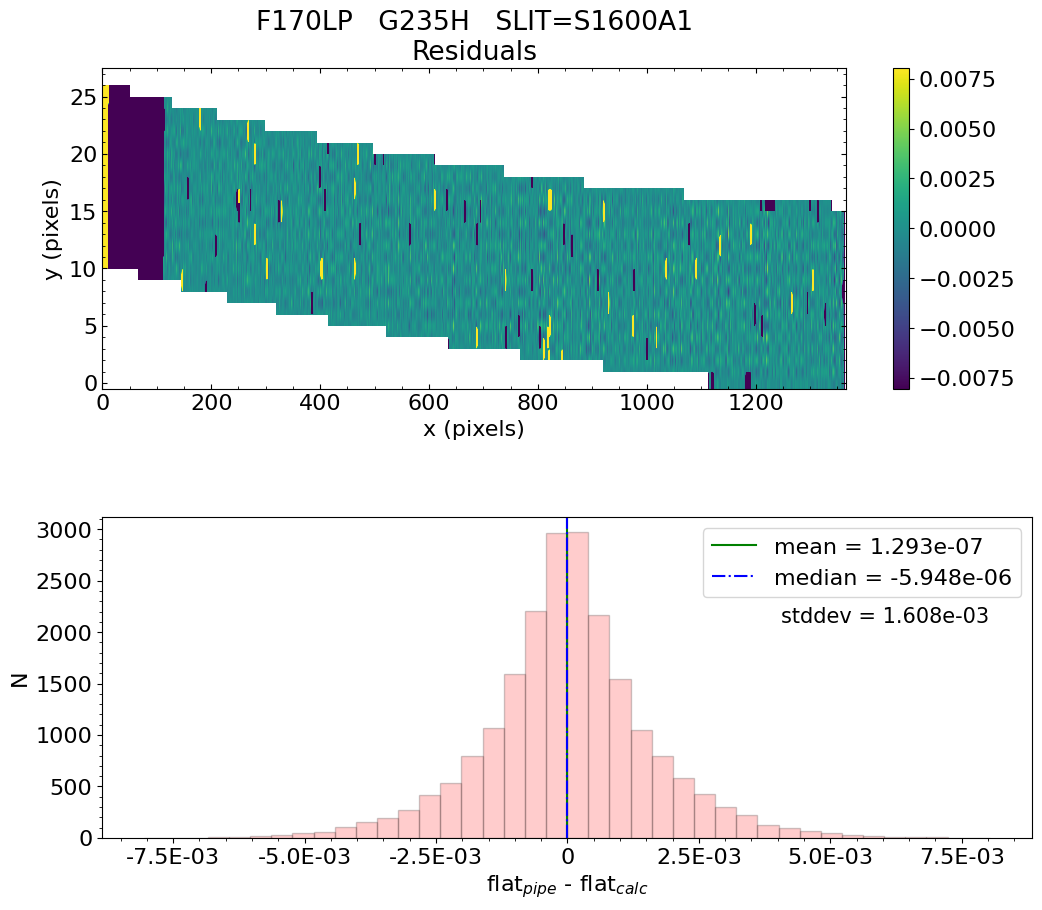


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_fs.py took ', '20.226624488830566 seconds to finish.')
Did flat_field for  bots_g235h_f170lp  validation test passed?  All slits PASSED flat_field test. 


Testing files for detector:  nrs2


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_371197/1988364956.py:81: ResourceWarning: unclosed file <_io.BufferedReader name='bots_g235h_f170lp_nrs1_interpolatedflat.fits'>
  result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(


Working with uncal_file:  /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/bots_g235h_f170lp_nrs2_uncal.fits
Filter =  F170LP
Running the detector1 pipeline...


2022-10-05 16:26:14,542 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-detector1pipeline_0003.asdf


2022-10-05 16:26:14,567 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-05 16:26:14,569 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-05 16:26:14,570 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-05 16:26:14,571 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-05 16:26:14,573 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-05 16:26:14,574 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-05 16:26:14,575 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-05 16:26:14,576 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-05 16:26:14,577 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-05 16:26:14,578 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-05 16:26:14,580 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-05 16:26:14,581 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-05 16:26:14,582 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-05 16:26:14,584 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-05 16:26:14,586 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-05 16:26:14,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-05 16:26:14,588 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-05 16:26:14,923 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/bots_g235h_f170lp_nrs2_uncal.fits',).


2022-10-05 16:26:14,933 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': True, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-05 16:26:16,496 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'saturation', 'superbias']


2022-10-05 16:26:16,507 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dark_0122.fits'.


2022-10-05 16:26:16,509 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits'.


2022-10-05 16:26:16,511 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_linearity_0009.fits'.


2022-10-05 16:26:16,512 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits'.


2022-10-05 16:26:16,514 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits'.


2022-10-05 16:26:16,515 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-05 16:26:16,516 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2022-10-05 16:26:16,516 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_saturation_0011.fits'.


2022-10-05 16:26:16,517 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_superbias_0135.fits'.


2022-10-05 16:26:16,519 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-05 16:26:19,924 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:19,925 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:26:22,195 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2022-10-05 16:26:22,195 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-05 16:26:22,198 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-05 16:26:22,382 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:22,383 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:26:22,406 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nirspec_mask_0025.fits


2022-10-05 16:26:24,935 - stpipe.Detector1Pipeline.dq_init - INFO - Extracting mask subarray to match science data


2022-10-05 16:26:24,950 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-05 16:26:25,129 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:25,131 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'n_pix_grow_sat': 1}


2022-10-05 16:26:25,158 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nirspec_saturation_0011.fits


2022-10-05 16:26:27,517 - stpipe.Detector1Pipeline.saturation - INFO - Extracting reference file subarray to match science data


2022-10-05 16:26:40,941 - stpipe.Detector1Pipeline.saturation - INFO - Detected 572 saturated pixels


2022-10-05 16:26:41,238 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-05 16:26:41,246 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-05 16:26:41,432 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:41,433 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:26:41,434 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-05 16:26:41,437 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-05 16:26:41,591 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:41,592 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:26:41,617 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nirspec_superbias_0135.fits


2022-10-05 16:26:44,218 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2022-10-05 16:26:44,402 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:44,404 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-05 16:26:46,430 - stpipe.Detector1Pipeline.refpix - INFO - NIR subarray data


2022-10-05 16:26:46,434 - stpipe.Detector1Pipeline.refpix - INFO - Single readout amplifier used


2022-10-05 16:26:46,434 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-05 16:26:46,435 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


2022-10-05 16:26:46,435 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-05 16:26:46,435 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


2022-10-05 16:26:46,436 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


2022-10-05 16:26:46,436 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.0


2022-10-05 16:26:46,436 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = False


2022-10-05 16:26:46,470 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-05 16:26:46,649 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:46,651 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 16:26:46,674 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nirspec_linearity_0009.fits


2022-10-05 16:26:53,658 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-05 16:26:53,842 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:53,844 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'dark_output': None}


2022-10-05 16:26:53,868 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nirspec_dark_0122.fits


2022-10-05 16:26:54,325 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3000, ngroups=3, nframes=1, groupgap=0


2022-10-05 16:26:54,326 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=32, nframes=1, groupgap=0


2022-10-05 16:26:58,896 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-05 16:26:59,059 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:26:59,061 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-05 16:26:59,071 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-05 16:26:59,085 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-05 16:26:59,507 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits


2022-10-05 16:27:01,762 - stpipe.Detector1Pipeline.jump - INFO - Extracting gain subarray to match science data


2022-10-05 16:27:01,763 - stpipe.Detector1Pipeline.jump - INFO - Extracting readnoise subarray to match science data


2022-10-05 16:27:02,829 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-05 16:27:03,957 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/jump/twopoint_difference.py:154: RuntimeWarning: All-NaN slice encountered
  max_ratio = np.nanmax(ratio, axis=0)
2022-10-05 16:27:03,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:03,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:03,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51115 pixels with at least one CR from three groups.


2022-10-05 16:27:05,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-05 16:27:05,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:05,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:05,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 306 pixels with at least one CR from three groups.


2022-10-05 16:27:05,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-10-05 16:27:05,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:05,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:05,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:27:05,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 4:


2022-10-05 16:27:05,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:05,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:05,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36118 pixels with at least one CR from three groups.


2022-10-05 16:27:06,318 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 5:


2022-10-05 16:27:06,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 600 pixels with at least one CR from three groups.


2022-10-05 16:27:06,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 6:


2022-10-05 16:27:06,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6681 pixels with at least one CR from three groups.


2022-10-05 16:27:06,543 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 7:


2022-10-05 16:27:06,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1976 pixels with at least one CR from three groups.


2022-10-05 16:27:06,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 8:


2022-10-05 16:27:06,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 16:27:06,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 9:


2022-10-05 16:27:06,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 314 pixels with at least one CR from three groups.


2022-10-05 16:27:06,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 10:


2022-10-05 16:27:06,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2100 pixels with at least one CR from three groups.


2022-10-05 16:27:06,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 11:


2022-10-05 16:27:06,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:06,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:06,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26279 pixels with at least one CR from three groups.


2022-10-05 16:27:07,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 12:


2022-10-05 16:27:07,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:07,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:07,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:27:07,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 13:


2022-10-05 16:27:07,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:07,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:07,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 375 pixels with at least one CR from three groups.


2022-10-05 16:27:07,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 14:


2022-10-05 16:27:07,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:07,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:07,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52437 pixels with at least one CR from three groups.


2022-10-05 16:27:08,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 15:


2022-10-05 16:27:08,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:08,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:08,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 249 pixels with at least one CR from three groups.


2022-10-05 16:27:08,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 16:


2022-10-05 16:27:08,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:08,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:08,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:27:08,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 17:


2022-10-05 16:27:08,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:08,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:08,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20249 pixels with at least one CR from three groups.


2022-10-05 16:27:09,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 18:


2022-10-05 16:27:09,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:09,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:09,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2058 pixels with at least one CR from three groups.


2022-10-05 16:27:09,561 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 19:


2022-10-05 16:27:09,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:09,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:09,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3591 pixels with at least one CR from three groups.


2022-10-05 16:27:09,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 20:


2022-10-05 16:27:09,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:09,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:09,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47287 pixels with at least one CR from three groups.


2022-10-05 16:27:10,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 21:


2022-10-05 16:27:10,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:10,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:10,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16637 pixels with at least one CR from three groups.


2022-10-05 16:27:11,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 22:


2022-10-05 16:27:11,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:11,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:11,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:27:11,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:


2022-10-05 16:27:11,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:11,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:11,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8700 pixels with at least one CR from three groups.


2022-10-05 16:27:11,634 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:


2022-10-05 16:27:11,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:11,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:11,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36870 pixels with at least one CR from three groups.


2022-10-05 16:27:12,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:


2022-10-05 16:27:12,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:12,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:12,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13124 pixels with at least one CR from three groups.


2022-10-05 16:27:12,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 26:


2022-10-05 16:27:12,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:12,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:12,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32218 pixels with at least one CR from three groups.


2022-10-05 16:27:13,786 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 27:


2022-10-05 16:27:13,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:13,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:13,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 335 pixels with at least one CR from three groups.


2022-10-05 16:27:13,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 28:


2022-10-05 16:27:13,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:13,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:13,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36543 pixels with at least one CR from three groups.


2022-10-05 16:27:14,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 29:


2022-10-05 16:27:14,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:14,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:14,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43342 pixels with at least one CR from three groups.


2022-10-05 16:27:15,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 30:


2022-10-05 16:27:15,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:15,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:15,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1059 pixels with at least one CR from three groups.


2022-10-05 16:27:15,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 31:


2022-10-05 16:27:15,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:15,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:15,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 320 pixels with at least one CR from three groups.


2022-10-05 16:27:15,957 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 32:


2022-10-05 16:27:15,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:15,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:15,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 909 pixels with at least one CR from three groups.


2022-10-05 16:27:15,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 33:


2022-10-05 16:27:16,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:27:16,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 34:


2022-10-05 16:27:16,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:27:16,039 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 35:


2022-10-05 16:27:16,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:27:16,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 36:


2022-10-05 16:27:16,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 298 pixels with at least one CR from three groups.


2022-10-05 16:27:16,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 37:


2022-10-05 16:27:16,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5516 pixels with at least one CR from three groups.


2022-10-05 16:27:16,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 38:


2022-10-05 16:27:16,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1275 pixels with at least one CR from three groups.


2022-10-05 16:27:16,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 39:


2022-10-05 16:27:16,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2778 pixels with at least one CR from three groups.


2022-10-05 16:27:16,389 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 40:


2022-10-05 16:27:16,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 256 pixels with at least one CR from three groups.


2022-10-05 16:27:16,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 41:


2022-10-05 16:27:16,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 466 pixels with at least one CR from three groups.


2022-10-05 16:27:16,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 42:


2022-10-05 16:27:16,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:27:16,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 43:


2022-10-05 16:27:16,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2675 pixels with at least one CR from three groups.


2022-10-05 16:27:16,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 44:


2022-10-05 16:27:16,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7643 pixels with at least one CR from three groups.


2022-10-05 16:27:16,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 45:


2022-10-05 16:27:16,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:16,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:16,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55993 pixels with at least one CR from three groups.


2022-10-05 16:27:18,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 46:


2022-10-05 16:27:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:18,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:18,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15572 pixels with at least one CR from three groups.


2022-10-05 16:27:18,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 47:


2022-10-05 16:27:18,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:18,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:18,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2459 pixels with at least one CR from three groups.


2022-10-05 16:27:18,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 48:


2022-10-05 16:27:18,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:18,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:18,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.


2022-10-05 16:27:18,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 49:


2022-10-05 16:27:18,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:18,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:18,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9249 pixels with at least one CR from three groups.


2022-10-05 16:27:19,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 50:


2022-10-05 16:27:19,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 16:27:19,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 51:


2022-10-05 16:27:19,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 620 pixels with at least one CR from three groups.


2022-10-05 16:27:19,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 52:


2022-10-05 16:27:19,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:27:19,317 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 53:


2022-10-05 16:27:19,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:27:19,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 54:


2022-10-05 16:27:19,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6938 pixels with at least one CR from three groups.


2022-10-05 16:27:19,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 55:


2022-10-05 16:27:19,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:27:19,564 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 56:


2022-10-05 16:27:19,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1143 pixels with at least one CR from three groups.


2022-10-05 16:27:19,612 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 57:


2022-10-05 16:27:19,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4975 pixels with at least one CR from three groups.


2022-10-05 16:27:19,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 58:


2022-10-05 16:27:19,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:19,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:19,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40545 pixels with at least one CR from three groups.


2022-10-05 16:27:20,817 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 59:


2022-10-05 16:27:20,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:20,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:20,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55495 pixels with at least one CR from three groups.


2022-10-05 16:27:22,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 60:


2022-10-05 16:27:22,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:22,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:22,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 991 pixels with at least one CR from three groups.


2022-10-05 16:27:22,432 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 61:


2022-10-05 16:27:22,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:22,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:22,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14180 pixels with at least one CR from three groups.


2022-10-05 16:27:22,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 62:


2022-10-05 16:27:22,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:22,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:22,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51336 pixels with at least one CR from three groups.


2022-10-05 16:27:24,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 63:


2022-10-05 16:27:24,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2606 pixels with at least one CR from three groups.


2022-10-05 16:27:24,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 64:


2022-10-05 16:27:24,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359 pixels with at least one CR from three groups.


2022-10-05 16:27:24,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 65:


2022-10-05 16:27:24,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 217 pixels with at least one CR from three groups.


2022-10-05 16:27:24,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 66:


2022-10-05 16:27:24,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 777 pixels with at least one CR from three groups.


2022-10-05 16:27:24,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 67:


2022-10-05 16:27:24,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:27:24,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 68:


2022-10-05 16:27:24,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5467 pixels with at least one CR from three groups.


2022-10-05 16:27:24,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 69:


2022-10-05 16:27:24,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40209 pixels with at least one CR from three groups.


2022-10-05 16:27:25,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 70:


2022-10-05 16:27:25,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:25,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:25,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:27:25,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 71:


2022-10-05 16:27:25,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:25,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:25,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 16:27:25,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 72:


2022-10-05 16:27:25,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:25,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:25,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1816 pixels with at least one CR from three groups.


2022-10-05 16:27:25,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 73:


2022-10-05 16:27:25,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:25,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:25,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2296 pixels with at least one CR from three groups.


2022-10-05 16:27:25,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 74:


2022-10-05 16:27:25,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:25,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:25,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46003 pixels with at least one CR from three groups.


2022-10-05 16:27:26,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 75:


2022-10-05 16:27:26,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:26,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:26,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18091 pixels with at least one CR from three groups.


2022-10-05 16:27:27,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 76:


2022-10-05 16:27:27,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 604 pixels with at least one CR from three groups.


2022-10-05 16:27:27,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 77:


2022-10-05 16:27:27,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 331 pixels with at least one CR from three groups.


2022-10-05 16:27:27,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 78:


2022-10-05 16:27:27,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13377 pixels with at least one CR from three groups.


2022-10-05 16:27:27,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 79:


2022-10-05 16:27:27,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1153 pixels with at least one CR from three groups.


2022-10-05 16:27:27,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 80:


2022-10-05 16:27:27,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 604 pixels with at least one CR from three groups.


2022-10-05 16:27:27,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 81:


2022-10-05 16:27:27,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:27,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:27,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15942 pixels with at least one CR from three groups.


2022-10-05 16:27:28,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 82:


2022-10-05 16:27:28,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:28,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:28,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:27:28,399 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 83:


2022-10-05 16:27:28,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:28,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:28,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26397 pixels with at least one CR from three groups.


2022-10-05 16:27:29,095 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 84:


2022-10-05 16:27:29,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:29,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:29,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9233 pixels with at least one CR from three groups.


2022-10-05 16:27:29,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 85:


2022-10-05 16:27:29,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:29,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:29,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49075 pixels with at least one CR from three groups.


2022-10-05 16:27:30,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 86:


2022-10-05 16:27:30,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:30,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:30,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9088 pixels with at least one CR from three groups.


2022-10-05 16:27:30,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 87:


2022-10-05 16:27:30,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:30,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:30,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 798 pixels with at least one CR from three groups.


2022-10-05 16:27:30,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 88:


2022-10-05 16:27:30,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:30,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:30,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57738 pixels with at least one CR from three groups.


2022-10-05 16:27:33,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 89:


2022-10-05 16:27:33,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:33,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:33,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22736 pixels with at least one CR from three groups.


2022-10-05 16:27:33,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 90:


2022-10-05 16:27:33,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:33,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:33,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46249 pixels with at least one CR from three groups.


2022-10-05 16:27:34,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 91:


2022-10-05 16:27:34,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:34,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:34,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11087 pixels with at least one CR from three groups.


2022-10-05 16:27:35,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 92:


2022-10-05 16:27:35,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:35,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:35,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:27:35,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 93:


2022-10-05 16:27:35,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:35,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:35,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52500 pixels with at least one CR from three groups.


2022-10-05 16:27:36,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 94:


2022-10-05 16:27:36,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 323 pixels with at least one CR from three groups.


2022-10-05 16:27:36,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 95:


2022-10-05 16:27:36,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3892 pixels with at least one CR from three groups.


2022-10-05 16:27:36,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 96:


2022-10-05 16:27:36,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 668 pixels with at least one CR from three groups.


2022-10-05 16:27:36,739 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 97:


2022-10-05 16:27:36,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.


2022-10-05 16:27:36,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 98:


2022-10-05 16:27:36,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2680 pixels with at least one CR from three groups.


2022-10-05 16:27:36,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 99:


2022-10-05 16:27:36,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:36,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:36,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10646 pixels with at least one CR from three groups.


2022-10-05 16:27:37,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 100:


2022-10-05 16:27:37,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:37,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:37,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1833 pixels with at least one CR from three groups.


2022-10-05 16:27:37,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 101:


2022-10-05 16:27:37,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:37,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:37,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61001 pixels with at least one CR from three groups.


2022-10-05 16:27:39,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 102:


2022-10-05 16:27:39,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:39,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:39,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7536 pixels with at least one CR from three groups.


2022-10-05 16:27:39,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 103:


2022-10-05 16:27:39,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:39,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:39,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:27:39,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 104:


2022-10-05 16:27:39,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:39,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:39,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53530 pixels with at least one CR from three groups.


2022-10-05 16:27:41,384 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 105:


2022-10-05 16:27:41,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:41,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:41,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9404 pixels with at least one CR from three groups.


2022-10-05 16:27:41,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 106:


2022-10-05 16:27:41,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:41,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:41,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 400 pixels with at least one CR from three groups.


2022-10-05 16:27:41,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 107:


2022-10-05 16:27:41,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:41,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:41,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8354 pixels with at least one CR from three groups.


2022-10-05 16:27:41,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 108:


2022-10-05 16:27:41,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:41,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:41,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9662 pixels with at least one CR from three groups.


2022-10-05 16:27:42,167 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 109:


2022-10-05 16:27:42,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:42,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:42,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57787 pixels with at least one CR from three groups.


2022-10-05 16:27:44,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 110:


2022-10-05 16:27:44,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:44,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:44,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 16:27:44,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 111:


2022-10-05 16:27:44,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:44,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:44,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55406 pixels with at least one CR from three groups.


2022-10-05 16:27:45,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 112:


2022-10-05 16:27:45,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:45,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:45,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51342 pixels with at least one CR from three groups.


2022-10-05 16:27:46,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 113:


2022-10-05 16:27:46,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:46,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:46,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1800 pixels with at least one CR from three groups.


2022-10-05 16:27:47,000 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 114:


2022-10-05 16:27:47,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:47,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:47,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1519 pixels with at least one CR from three groups.


2022-10-05 16:27:47,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 115:


2022-10-05 16:27:47,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:47,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:47,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3149 pixels with at least one CR from three groups.


2022-10-05 16:27:47,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 116:


2022-10-05 16:27:47,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:47,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:47,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44493 pixels with at least one CR from three groups.


2022-10-05 16:27:48,319 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 117:


2022-10-05 16:27:48,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:48,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:48,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 495 pixels with at least one CR from three groups.


2022-10-05 16:27:48,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 118:


2022-10-05 16:27:48,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:48,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:48,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42482 pixels with at least one CR from three groups.


2022-10-05 16:27:49,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 119:


2022-10-05 16:27:49,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:49,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:49,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44339 pixels with at least one CR from three groups.


2022-10-05 16:27:50,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 120:


2022-10-05 16:27:50,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:50,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:50,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14914 pixels with at least one CR from three groups.


2022-10-05 16:27:50,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 121:


2022-10-05 16:27:51,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:51,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:51,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1027 pixels with at least one CR from three groups.


2022-10-05 16:27:51,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 122:


2022-10-05 16:27:51,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:51,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:51,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1918 pixels with at least one CR from three groups.


2022-10-05 16:27:51,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 123:


2022-10-05 16:27:51,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:51,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:51,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18222 pixels with at least one CR from three groups.


2022-10-05 16:27:51,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 124:


2022-10-05 16:27:51,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:51,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:51,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2885 pixels with at least one CR from three groups.


2022-10-05 16:27:51,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 125:


2022-10-05 16:27:51,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:51,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:51,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52749 pixels with at least one CR from three groups.


2022-10-05 16:27:53,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 126:


2022-10-05 16:27:53,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:53,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:53,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46189 pixels with at least one CR from three groups.


2022-10-05 16:27:54,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 127:


2022-10-05 16:27:54,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:54,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:54,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:27:54,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 128:


2022-10-05 16:27:54,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:54,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:54,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14286 pixels with at least one CR from three groups.


2022-10-05 16:27:54,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 129:


2022-10-05 16:27:54,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:54,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:54,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35022 pixels with at least one CR from three groups.


2022-10-05 16:27:55,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 130:


2022-10-05 16:27:55,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:55,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:55,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4789 pixels with at least one CR from three groups.


2022-10-05 16:27:55,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 131:


2022-10-05 16:27:55,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:55,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:55,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13808 pixels with at least one CR from three groups.


2022-10-05 16:27:56,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 132:


2022-10-05 16:27:56,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:56,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:56,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6698 pixels with at least one CR from three groups.


2022-10-05 16:27:56,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 133:


2022-10-05 16:27:56,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:56,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:56,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21683 pixels with at least one CR from three groups.


2022-10-05 16:27:56,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 134:


2022-10-05 16:27:56,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:56,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:56,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 16:27:56,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 135:


2022-10-05 16:27:56,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:56,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:56,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56141 pixels with at least one CR from three groups.


2022-10-05 16:27:58,584 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 136:


2022-10-05 16:27:58,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:58,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:58,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:27:58,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 137:


2022-10-05 16:27:58,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:58,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:58,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.


2022-10-05 16:27:58,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 138:


2022-10-05 16:27:58,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:27:58,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:27:58,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52773 pixels with at least one CR from three groups.


2022-10-05 16:28:00,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 139:


2022-10-05 16:28:00,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3524 pixels with at least one CR from three groups.


2022-10-05 16:28:00,185 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 140:


2022-10-05 16:28:00,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 16:28:00,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 141:


2022-10-05 16:28:00,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 412 pixels with at least one CR from three groups.


2022-10-05 16:28:00,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 142:


2022-10-05 16:28:00,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 310 pixels with at least one CR from three groups.


2022-10-05 16:28:00,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 143:


2022-10-05 16:28:00,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1795 pixels with at least one CR from three groups.


2022-10-05 16:28:00,331 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 144:


2022-10-05 16:28:00,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4367 pixels with at least one CR from three groups.


2022-10-05 16:28:00,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 145:


2022-10-05 16:28:00,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:00,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:00,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34067 pixels with at least one CR from three groups.


2022-10-05 16:28:01,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 146:


2022-10-05 16:28:01,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:01,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:01,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 339 pixels with at least one CR from three groups.


2022-10-05 16:28:01,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 147:


2022-10-05 16:28:01,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:01,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:01,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10476 pixels with at least one CR from three groups.


2022-10-05 16:28:01,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 148:


2022-10-05 16:28:01,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:01,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:01,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47543 pixels with at least one CR from three groups.


2022-10-05 16:28:02,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 149:


2022-10-05 16:28:02,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:02,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:02,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37936 pixels with at least one CR from three groups.


2022-10-05 16:28:03,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 150:


2022-10-05 16:28:03,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:03,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:03,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6429 pixels with at least one CR from three groups.


2022-10-05 16:28:04,048 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 151:


2022-10-05 16:28:04,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:04,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:04,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:28:04,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 152:


2022-10-05 16:28:04,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:04,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:04,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:28:04,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 153:


2022-10-05 16:28:04,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:04,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:04,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21202 pixels with at least one CR from three groups.


2022-10-05 16:28:04,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 154:


2022-10-05 16:28:04,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:04,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:04,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40393 pixels with at least one CR from three groups.


2022-10-05 16:28:05,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 155:


2022-10-05 16:28:05,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:05,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:05,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44604 pixels with at least one CR from three groups.


2022-10-05 16:28:06,845 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 156:


2022-10-05 16:28:06,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:06,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:06,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 408 pixels with at least one CR from three groups.


2022-10-05 16:28:06,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 157:


2022-10-05 16:28:06,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:06,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:06,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2042 pixels with at least one CR from three groups.


2022-10-05 16:28:06,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 158:


2022-10-05 16:28:06,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:06,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:06,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5569 pixels with at least one CR from three groups.


2022-10-05 16:28:07,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 159:


2022-10-05 16:28:07,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:07,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:07,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57807 pixels with at least one CR from three groups.


2022-10-05 16:28:08,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 160:


2022-10-05 16:28:08,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:08,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:08,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.


2022-10-05 16:28:08,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 161:


2022-10-05 16:28:08,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:08,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:08,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 601 pixels with at least one CR from three groups.


2022-10-05 16:28:08,890 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 162:


2022-10-05 16:28:08,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:08,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:08,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.


2022-10-05 16:28:08,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 163:


2022-10-05 16:28:08,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:08,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:08,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1423 pixels with at least one CR from three groups.


2022-10-05 16:28:08,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 164:


2022-10-05 16:28:08,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:08,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:08,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12811 pixels with at least one CR from three groups.


2022-10-05 16:28:09,313 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 165:


2022-10-05 16:28:09,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:09,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:09,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:28:09,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 166:


2022-10-05 16:28:09,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:09,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:09,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1259 pixels with at least one CR from three groups.


2022-10-05 16:28:09,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 167:


2022-10-05 16:28:09,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:09,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:09,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39857 pixels with at least one CR from three groups.


2022-10-05 16:28:10,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 168:


2022-10-05 16:28:10,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:10,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:10,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2365 pixels with at least one CR from three groups.


2022-10-05 16:28:10,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 169:


2022-10-05 16:28:10,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:10,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:10,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58009 pixels with at least one CR from three groups.


2022-10-05 16:28:12,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 170:


2022-10-05 16:28:12,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:12,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:12,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:28:12,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 171:


2022-10-05 16:28:12,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:12,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:12,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2456 pixels with at least one CR from three groups.


2022-10-05 16:28:12,411 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 172:


2022-10-05 16:28:12,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:12,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:12,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 16:28:12,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 173:


2022-10-05 16:28:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57713 pixels with at least one CR from three groups.


2022-10-05 16:28:14,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 174:


2022-10-05 16:28:14,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8643 pixels with at least one CR from three groups.


2022-10-05 16:28:14,753 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 175:


2022-10-05 16:28:14,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 958 pixels with at least one CR from three groups.


2022-10-05 16:28:14,793 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 176:


2022-10-05 16:28:14,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 486 pixels with at least one CR from three groups.


2022-10-05 16:28:14,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 177:


2022-10-05 16:28:14,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1040 pixels with at least one CR from three groups.


2022-10-05 16:28:14,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 178:


2022-10-05 16:28:14,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:28:14,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 179:


2022-10-05 16:28:14,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:14,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:14,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59417 pixels with at least one CR from three groups.


2022-10-05 16:28:17,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 180:


2022-10-05 16:28:17,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:17,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:17,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29203 pixels with at least one CR from three groups.


2022-10-05 16:28:17,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 181:


2022-10-05 16:28:17,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:17,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:17,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37789 pixels with at least one CR from three groups.


2022-10-05 16:28:18,888 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 182:


2022-10-05 16:28:18,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:18,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:18,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 686 pixels with at least one CR from three groups.


2022-10-05 16:28:18,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 183:


2022-10-05 16:28:18,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:18,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:18,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2325 pixels with at least one CR from three groups.


2022-10-05 16:28:18,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 184:


2022-10-05 16:28:19,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.


2022-10-05 16:28:19,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 185:


2022-10-05 16:28:19,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 255 pixels with at least one CR from three groups.


2022-10-05 16:28:19,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 186:


2022-10-05 16:28:19,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:28:19,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 187:


2022-10-05 16:28:19,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5439 pixels with at least one CR from three groups.


2022-10-05 16:28:19,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 188:


2022-10-05 16:28:19,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 942 pixels with at least one CR from three groups.


2022-10-05 16:28:19,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 189:


2022-10-05 16:28:19,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 992 pixels with at least one CR from three groups.


2022-10-05 16:28:19,319 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 190:


2022-10-05 16:28:19,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:28:19,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 191:


2022-10-05 16:28:19,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:28:19,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 192:


2022-10-05 16:28:19,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:28:19,389 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 193:


2022-10-05 16:28:19,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:19,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:19,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27816 pixels with at least one CR from three groups.


2022-10-05 16:28:20,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 194:


2022-10-05 16:28:20,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 313 pixels with at least one CR from three groups.


2022-10-05 16:28:20,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 195:


2022-10-05 16:28:20,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1038 pixels with at least one CR from three groups.


2022-10-05 16:28:20,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 196:


2022-10-05 16:28:20,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 503 pixels with at least one CR from three groups.


2022-10-05 16:28:20,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 197:


2022-10-05 16:28:20,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 332 pixels with at least one CR from three groups.


2022-10-05 16:28:20,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 198:


2022-10-05 16:28:20,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15692 pixels with at least one CR from three groups.


2022-10-05 16:28:20,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 199:


2022-10-05 16:28:20,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:20,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:20,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38291 pixels with at least one CR from three groups.


2022-10-05 16:28:21,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 200:


2022-10-05 16:28:21,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:21,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:21,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44764 pixels with at least one CR from three groups.


2022-10-05 16:28:22,819 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 201:


2022-10-05 16:28:22,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:22,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:22,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1606 pixels with at least one CR from three groups.


2022-10-05 16:28:22,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 202:


2022-10-05 16:28:22,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:22,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:22,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55991 pixels with at least one CR from three groups.


2022-10-05 16:28:24,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 203:


2022-10-05 16:28:24,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1805 pixels with at least one CR from three groups.


2022-10-05 16:28:24,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 204:


2022-10-05 16:28:24,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 437 pixels with at least one CR from three groups.


2022-10-05 16:28:24,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 205:


2022-10-05 16:28:24,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7443 pixels with at least one CR from three groups.


2022-10-05 16:28:24,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 206:


2022-10-05 16:28:24,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 623 pixels with at least one CR from three groups.


2022-10-05 16:28:24,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 207:


2022-10-05 16:28:24,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 367 pixels with at least one CR from three groups.


2022-10-05 16:28:24,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 208:


2022-10-05 16:28:24,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:28:24,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 209:


2022-10-05 16:28:24,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1566 pixels with at least one CR from three groups.


2022-10-05 16:28:24,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 210:


2022-10-05 16:28:24,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 254 pixels with at least one CR from three groups.


2022-10-05 16:28:24,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 211:


2022-10-05 16:28:24,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:24,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:24,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3150 pixels with at least one CR from three groups.


2022-10-05 16:28:25,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 212:


2022-10-05 16:28:25,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:25,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:25,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:28:25,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 213:


2022-10-05 16:28:25,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:25,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:25,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 241 pixels with at least one CR from three groups.


2022-10-05 16:28:25,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 214:


2022-10-05 16:28:25,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:25,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:25,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46136 pixels with at least one CR from three groups.


2022-10-05 16:28:26,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 215:


2022-10-05 16:28:26,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:26,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:26,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 332 pixels with at least one CR from three groups.


2022-10-05 16:28:26,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 216:


2022-10-05 16:28:26,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:26,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:26,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4768 pixels with at least one CR from three groups.


2022-10-05 16:28:26,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 217:


2022-10-05 16:28:26,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:26,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:26,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 422 pixels with at least one CR from three groups.


2022-10-05 16:28:26,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 218:


2022-10-05 16:28:26,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:26,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:26,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 487 pixels with at least one CR from three groups.


2022-10-05 16:28:26,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 219:


2022-10-05 16:28:26,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:26,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:26,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27505 pixels with at least one CR from three groups.


2022-10-05 16:28:27,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 220:


2022-10-05 16:28:27,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:27,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:27,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:28:27,304 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 221:


2022-10-05 16:28:27,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:27,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:27,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46696 pixels with at least one CR from three groups.


2022-10-05 16:28:28,506 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 222:


2022-10-05 16:28:28,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:28,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:28,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 369 pixels with at least one CR from three groups.


2022-10-05 16:28:28,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 223:


2022-10-05 16:28:28,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:28,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:28,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 323 pixels with at least one CR from three groups.


2022-10-05 16:28:28,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 224:


2022-10-05 16:28:28,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:28,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:28,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29984 pixels with at least one CR from three groups.


2022-10-05 16:28:29,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 225:


2022-10-05 16:28:29,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:29,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:29,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48245 pixels with at least one CR from three groups.


2022-10-05 16:28:30,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 226:


2022-10-05 16:28:30,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:30,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:30,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:28:30,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 227:


2022-10-05 16:28:30,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:30,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:30,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15655 pixels with at least one CR from three groups.


2022-10-05 16:28:31,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 228:


2022-10-05 16:28:31,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:31,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:31,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49647 pixels with at least one CR from three groups.


2022-10-05 16:28:32,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 229:


2022-10-05 16:28:32,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:32,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:32,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1292 pixels with at least one CR from three groups.


2022-10-05 16:28:32,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 230:


2022-10-05 16:28:32,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:32,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:32,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:28:32,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 231:


2022-10-05 16:28:32,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:32,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:32,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59416 pixels with at least one CR from three groups.


2022-10-05 16:28:34,686 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 232:


2022-10-05 16:28:34,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:34,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:34,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16918 pixels with at least one CR from three groups.


2022-10-05 16:28:35,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 233:


2022-10-05 16:28:35,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:35,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:35,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31880 pixels with at least one CR from three groups.


2022-10-05 16:28:35,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 234:


2022-10-05 16:28:35,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:35,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:35,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12495 pixels with at least one CR from three groups.


2022-10-05 16:28:36,317 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 235:


2022-10-05 16:28:36,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:36,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:36,329 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:28:36,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 236:


2022-10-05 16:28:36,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:36,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:36,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:28:36,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 237:


2022-10-05 16:28:36,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:36,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:36,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 422 pixels with at least one CR from three groups.


2022-10-05 16:28:36,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 238:


2022-10-05 16:28:36,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:36,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:36,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:28:36,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 239:


2022-10-05 16:28:36,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:36,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:36,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59355 pixels with at least one CR from three groups.


2022-10-05 16:28:38,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 240:


2022-10-05 16:28:38,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:38,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:38,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:28:38,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 241:


2022-10-05 16:28:38,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:38,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:38,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 714 pixels with at least one CR from three groups.


2022-10-05 16:28:38,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 242:


2022-10-05 16:28:38,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:38,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:38,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 802 pixels with at least one CR from three groups.


2022-10-05 16:28:38,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 243:


2022-10-05 16:28:38,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:38,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:38,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56342 pixels with at least one CR from three groups.


2022-10-05 16:28:40,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 244:


2022-10-05 16:28:40,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:40,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:40,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6719 pixels with at least one CR from three groups.


2022-10-05 16:28:40,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 245:


2022-10-05 16:28:40,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:40,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:40,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 427 pixels with at least one CR from three groups.


2022-10-05 16:28:40,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 246:


2022-10-05 16:28:40,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:40,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:40,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1516 pixels with at least one CR from three groups.


2022-10-05 16:28:40,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 247:


2022-10-05 16:28:40,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:40,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:40,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 677 pixels with at least one CR from three groups.


2022-10-05 16:28:40,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 248:


2022-10-05 16:28:40,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:40,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:40,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55173 pixels with at least one CR from three groups.


2022-10-05 16:28:42,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 249:


2022-10-05 16:28:42,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:42,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:42,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23750 pixels with at least one CR from three groups.


2022-10-05 16:28:43,123 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 250:


2022-10-05 16:28:43,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:43,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:43,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13180 pixels with at least one CR from three groups.


2022-10-05 16:28:43,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 251:


2022-10-05 16:28:43,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:43,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:43,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60088 pixels with at least one CR from three groups.


2022-10-05 16:28:45,892 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 252:


2022-10-05 16:28:45,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:45,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:45,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7894 pixels with at least one CR from three groups.


2022-10-05 16:28:46,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 253:


2022-10-05 16:28:46,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:46,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:46,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2657 pixels with at least one CR from three groups.


2022-10-05 16:28:46,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 254:


2022-10-05 16:28:46,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:46,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:46,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55440 pixels with at least one CR from three groups.


2022-10-05 16:28:47,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 255:


2022-10-05 16:28:47,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:47,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:47,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 247 pixels with at least one CR from three groups.


2022-10-05 16:28:47,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 256:


2022-10-05 16:28:47,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:47,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:47,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26973 pixels with at least one CR from three groups.


2022-10-05 16:28:48,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 257:


2022-10-05 16:28:48,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:48,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:48,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8508 pixels with at least one CR from three groups.


2022-10-05 16:28:48,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 258:


2022-10-05 16:28:48,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:48,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:48,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2043 pixels with at least one CR from three groups.


2022-10-05 16:28:48,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 259:


2022-10-05 16:28:48,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:48,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:48,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:28:48,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 260:


2022-10-05 16:28:48,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:48,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:48,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:28:48,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 261:


2022-10-05 16:28:48,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:48,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:48,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53505 pixels with at least one CR from three groups.


2022-10-05 16:28:50,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 262:


2022-10-05 16:28:50,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 457 pixels with at least one CR from three groups.


2022-10-05 16:28:50,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 263:


2022-10-05 16:28:50,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 689 pixels with at least one CR from three groups.


2022-10-05 16:28:50,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 264:


2022-10-05 16:28:50,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:28:50,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 265:


2022-10-05 16:28:50,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:28:50,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 266:


2022-10-05 16:28:50,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9586 pixels with at least one CR from three groups.


2022-10-05 16:28:50,672 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 267:


2022-10-05 16:28:50,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 471 pixels with at least one CR from three groups.


2022-10-05 16:28:50,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 268:


2022-10-05 16:28:50,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:50,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:50,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28443 pixels with at least one CR from three groups.


2022-10-05 16:28:51,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 269:


2022-10-05 16:28:51,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 713 pixels with at least one CR from three groups.


2022-10-05 16:28:51,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 270:


2022-10-05 16:28:51,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 16:28:51,505 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 271:


2022-10-05 16:28:51,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1892 pixels with at least one CR from three groups.


2022-10-05 16:28:51,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 272:


2022-10-05 16:28:51,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 620 pixels with at least one CR from three groups.


2022-10-05 16:28:51,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 273:


2022-10-05 16:28:51,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:28:51,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 274:


2022-10-05 16:28:51,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:28:51,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 275:


2022-10-05 16:28:51,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:51,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:51,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40782 pixels with at least one CR from three groups.


2022-10-05 16:28:52,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 276:


2022-10-05 16:28:52,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:52,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:52,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.


2022-10-05 16:28:52,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 277:


2022-10-05 16:28:52,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:52,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:52,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2298 pixels with at least one CR from three groups.


2022-10-05 16:28:52,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 278:


2022-10-05 16:28:52,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:52,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:52,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5344 pixels with at least one CR from three groups.


2022-10-05 16:28:52,986 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 279:


2022-10-05 16:28:52,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:52,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:52,997 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least one CR from three groups.


2022-10-05 16:28:53,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 280:


2022-10-05 16:28:53,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:53,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:53,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6502 pixels with at least one CR from three groups.


2022-10-05 16:28:53,190 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 281:


2022-10-05 16:28:53,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:53,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:53,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10765 pixels with at least one CR from three groups.


2022-10-05 16:28:53,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 282:


2022-10-05 16:28:53,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:53,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:53,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 406 pixels with at least one CR from three groups.


2022-10-05 16:28:53,506 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 283:


2022-10-05 16:28:53,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:53,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:53,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:28:53,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 284:


2022-10-05 16:28:53,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:53,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:53,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25775 pixels with at least one CR from three groups.


2022-10-05 16:28:54,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 285:


2022-10-05 16:28:54,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:54,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:54,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52784 pixels with at least one CR from three groups.


2022-10-05 16:28:55,634 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 286:


2022-10-05 16:28:55,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:55,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:55,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34815 pixels with at least one CR from three groups.


2022-10-05 16:28:56,537 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 287:


2022-10-05 16:28:56,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:56,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:56,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6071 pixels with at least one CR from three groups.


2022-10-05 16:28:56,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 288:


2022-10-05 16:28:56,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:56,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:56,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:28:56,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 289:


2022-10-05 16:28:56,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:56,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:56,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:28:56,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 290:


2022-10-05 16:28:56,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:56,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:56,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10483 pixels with at least one CR from three groups.


2022-10-05 16:28:57,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 291:


2022-10-05 16:28:57,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:57,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:57,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5829 pixels with at least one CR from three groups.


2022-10-05 16:28:57,224 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 292:


2022-10-05 16:28:57,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:57,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:57,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 949 pixels with at least one CR from three groups.


2022-10-05 16:28:57,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 293:


2022-10-05 16:28:57,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:57,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:57,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4646 pixels with at least one CR from three groups.


2022-10-05 16:28:57,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 294:


2022-10-05 16:28:57,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:57,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:57,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 957 pixels with at least one CR from three groups.


2022-10-05 16:28:57,470 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 295:


2022-10-05 16:28:57,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:57,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:57,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21869 pixels with at least one CR from three groups.


2022-10-05 16:28:58,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 296:


2022-10-05 16:28:58,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:58,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:58,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:28:58,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 297:


2022-10-05 16:28:58,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:58,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:58,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 377 pixels with at least one CR from three groups.


2022-10-05 16:28:58,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 298:


2022-10-05 16:28:58,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:58,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:58,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46054 pixels with at least one CR from three groups.


2022-10-05 16:28:59,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 299:


2022-10-05 16:28:59,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:28:59,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:28:59,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58338 pixels with at least one CR from three groups.


2022-10-05 16:29:01,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 300:


2022-10-05 16:29:01,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:01,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:01,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:29:01,191 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 301:


2022-10-05 16:29:01,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:01,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:01,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 579 pixels with at least one CR from three groups.


2022-10-05 16:29:01,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 302:


2022-10-05 16:29:01,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:01,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:01,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 303 pixels with at least one CR from three groups.


2022-10-05 16:29:01,250 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 303:


2022-10-05 16:29:01,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:01,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:01,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:29:01,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 304:


2022-10-05 16:29:01,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:01,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:01,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39957 pixels with at least one CR from three groups.


2022-10-05 16:29:02,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 305:


2022-10-05 16:29:02,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:02,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:02,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:29:02,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 306:


2022-10-05 16:29:02,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:02,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:02,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2697 pixels with at least one CR from three groups.


2022-10-05 16:29:02,446 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 307:


2022-10-05 16:29:02,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:02,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:02,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6968 pixels with at least one CR from three groups.


2022-10-05 16:29:02,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 308:


2022-10-05 16:29:02,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:02,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:02,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:29:02,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 309:


2022-10-05 16:29:02,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:02,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:02,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42264 pixels with at least one CR from three groups.


2022-10-05 16:29:03,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 310:


2022-10-05 16:29:03,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:03,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:03,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58607 pixels with at least one CR from three groups.


2022-10-05 16:29:06,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 311:


2022-10-05 16:29:06,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:06,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:06,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 983 pixels with at least one CR from three groups.


2022-10-05 16:29:06,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 312:


2022-10-05 16:29:06,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:06,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:06,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57226 pixels with at least one CR from three groups.


2022-10-05 16:29:07,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 313:


2022-10-05 16:29:07,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:07,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:07,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57545 pixels with at least one CR from three groups.


2022-10-05 16:29:10,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 314:


2022-10-05 16:29:10,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:10,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:10,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60181 pixels with at least one CR from three groups.


2022-10-05 16:29:13,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 315:


2022-10-05 16:29:13,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1811 pixels with at least one CR from three groups.


2022-10-05 16:29:13,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 316:


2022-10-05 16:29:13,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:29:13,225 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 317:


2022-10-05 16:29:13,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:29:13,250 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 318:


2022-10-05 16:29:13,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 839 pixels with at least one CR from three groups.


2022-10-05 16:29:13,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 319:


2022-10-05 16:29:13,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:29:13,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 320:


2022-10-05 16:29:13,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15389 pixels with at least one CR from three groups.


2022-10-05 16:29:13,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 321:


2022-10-05 16:29:13,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:13,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:13,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5935 pixels with at least one CR from three groups.


2022-10-05 16:29:14,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 322:


2022-10-05 16:29:14,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:14,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:14,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 384 pixels with at least one CR from three groups.


2022-10-05 16:29:14,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 323:


2022-10-05 16:29:14,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:14,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:14,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:29:14,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 324:


2022-10-05 16:29:14,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:14,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:14,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 510 pixels with at least one CR from three groups.


2022-10-05 16:29:14,088 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 325:


2022-10-05 16:29:14,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:14,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:14,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29743 pixels with at least one CR from three groups.


2022-10-05 16:29:15,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 326:


2022-10-05 16:29:15,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:15,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:15,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 603 pixels with at least one CR from three groups.


2022-10-05 16:29:15,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 327:


2022-10-05 16:29:15,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:15,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:15,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 656 pixels with at least one CR from three groups.


2022-10-05 16:29:15,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 328:


2022-10-05 16:29:15,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:15,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:15,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:29:15,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 329:


2022-10-05 16:29:15,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:15,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:15,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21421 pixels with at least one CR from three groups.


2022-10-05 16:29:15,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 330:


2022-10-05 16:29:15,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:15,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:15,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54918 pixels with at least one CR from three groups.


2022-10-05 16:29:17,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 331:


2022-10-05 16:29:17,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:17,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:17,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2971 pixels with at least one CR from three groups.


2022-10-05 16:29:17,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 332:


2022-10-05 16:29:17,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11360 pixels with at least one CR from three groups.


2022-10-05 16:29:18,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 333:


2022-10-05 16:29:18,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:18,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:18,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:29:18,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 334:


2022-10-05 16:29:18,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:18,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:18,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20383 pixels with at least one CR from three groups.


2022-10-05 16:29:18,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 335:


2022-10-05 16:29:18,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:18,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:18,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.


2022-10-05 16:29:18,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 336:


2022-10-05 16:29:18,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:18,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:18,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16783 pixels with at least one CR from three groups.


2022-10-05 16:29:19,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 337:


2022-10-05 16:29:19,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 631 pixels with at least one CR from three groups.


2022-10-05 16:29:19,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 338:


2022-10-05 16:29:19,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 264 pixels with at least one CR from three groups.


2022-10-05 16:29:19,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 339:


2022-10-05 16:29:19,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:29:19,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 340:


2022-10-05 16:29:19,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 376 pixels with at least one CR from three groups.


2022-10-05 16:29:19,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 341:


2022-10-05 16:29:19,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1121 pixels with at least one CR from three groups.


2022-10-05 16:29:19,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 342:


2022-10-05 16:29:19,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 634 pixels with at least one CR from three groups.


2022-10-05 16:29:19,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 343:


2022-10-05 16:29:19,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:19,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:19,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42315 pixels with at least one CR from three groups.


2022-10-05 16:29:20,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 344:


2022-10-05 16:29:20,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:20,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:20,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:29:20,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 345:


2022-10-05 16:29:20,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:20,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:20,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:29:20,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 346:


2022-10-05 16:29:20,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:20,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:20,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57320 pixels with at least one CR from three groups.


2022-10-05 16:29:22,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 347:


2022-10-05 16:29:22,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:22,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:22,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52214 pixels with at least one CR from three groups.


2022-10-05 16:29:23,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 348:


2022-10-05 16:29:23,596 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:29:23,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 349:


2022-10-05 16:29:23,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 715 pixels with at least one CR from three groups.


2022-10-05 16:29:23,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 350:


2022-10-05 16:29:23,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4896 pixels with at least one CR from three groups.


2022-10-05 16:29:23,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 351:


2022-10-05 16:29:23,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2484 pixels with at least one CR from three groups.


2022-10-05 16:29:23,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 352:


2022-10-05 16:29:23,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2282 pixels with at least one CR from three groups.


2022-10-05 16:29:23,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 353:


2022-10-05 16:29:23,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:23,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:23,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56125 pixels with at least one CR from three groups.


2022-10-05 16:29:25,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 354:


2022-10-05 16:29:25,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:25,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:25,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 992 pixels with at least one CR from three groups.


2022-10-05 16:29:25,645 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 355:


2022-10-05 16:29:25,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:25,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:25,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10395 pixels with at least one CR from three groups.


2022-10-05 16:29:25,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 356:


2022-10-05 16:29:25,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:25,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:25,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8613 pixels with at least one CR from three groups.


2022-10-05 16:29:26,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 357:


2022-10-05 16:29:26,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:26,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:26,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19040 pixels with at least one CR from three groups.


2022-10-05 16:29:26,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 358:


2022-10-05 16:29:26,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:26,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:26,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:29:26,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 359:


2022-10-05 16:29:26,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:26,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:26,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52360 pixels with at least one CR from three groups.


2022-10-05 16:29:28,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 360:


2022-10-05 16:29:28,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:28,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:28,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.


2022-10-05 16:29:28,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 361:


2022-10-05 16:29:28,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:28,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:28,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 552 pixels with at least one CR from three groups.


2022-10-05 16:29:28,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 362:


2022-10-05 16:29:28,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:28,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:28,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58100 pixels with at least one CR from three groups.


2022-10-05 16:29:30,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 363:


2022-10-05 16:29:30,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:30,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:30,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 357 pixels with at least one CR from three groups.


2022-10-05 16:29:30,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 364:


2022-10-05 16:29:30,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:30,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:30,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 259 pixels with at least one CR from three groups.


2022-10-05 16:29:30,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 365:


2022-10-05 16:29:30,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:30,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:30,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2942 pixels with at least one CR from three groups.


2022-10-05 16:29:30,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 366:


2022-10-05 16:29:30,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:30,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:30,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 409 pixels with at least one CR from three groups.


2022-10-05 16:29:30,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 367:


2022-10-05 16:29:30,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:30,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:30,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18976 pixels with at least one CR from three groups.


2022-10-05 16:29:31,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 368:


2022-10-05 16:29:31,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:31,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:31,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:29:31,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 369:


2022-10-05 16:29:31,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:31,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:31,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 377 pixels with at least one CR from three groups.


2022-10-05 16:29:31,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 370:


2022-10-05 16:29:31,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:31,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:31,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14994 pixels with at least one CR from three groups.


2022-10-05 16:29:31,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 371:


2022-10-05 16:29:31,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:31,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:31,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16377 pixels with at least one CR from three groups.


2022-10-05 16:29:31,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 372:


2022-10-05 16:29:31,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:31,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:31,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 925 pixels with at least one CR from three groups.


2022-10-05 16:29:31,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 373:


2022-10-05 16:29:32,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:32,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:32,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56581 pixels with at least one CR from three groups.


2022-10-05 16:29:33,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 374:


2022-10-05 16:29:33,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:33,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:33,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32217 pixels with at least one CR from three groups.


2022-10-05 16:29:34,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 375:


2022-10-05 16:29:34,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2576 pixels with at least one CR from three groups.


2022-10-05 16:29:34,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 376:


2022-10-05 16:29:34,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:29:34,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 377:


2022-10-05 16:29:34,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:29:34,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 378:


2022-10-05 16:29:34,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 396 pixels with at least one CR from three groups.


2022-10-05 16:29:34,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 379:


2022-10-05 16:29:34,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2433 pixels with at least one CR from three groups.


2022-10-05 16:29:34,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 380:


2022-10-05 16:29:34,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:34,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:34,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17527 pixels with at least one CR from three groups.


2022-10-05 16:29:35,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 381:


2022-10-05 16:29:35,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:35,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:35,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:29:35,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 382:


2022-10-05 16:29:35,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:35,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:35,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:29:35,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 383:


2022-10-05 16:29:35,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:35,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:35,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13834 pixels with at least one CR from three groups.


2022-10-05 16:29:35,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 384:


2022-10-05 16:29:35,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:35,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:35,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:29:35,741 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 385:


2022-10-05 16:29:35,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:35,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:35,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56966 pixels with at least one CR from three groups.


2022-10-05 16:29:37,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 386:


2022-10-05 16:29:37,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:37,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:37,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4206 pixels with at least one CR from three groups.


2022-10-05 16:29:37,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 387:


2022-10-05 16:29:37,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:37,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:37,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 245 pixels with at least one CR from three groups.


2022-10-05 16:29:37,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 388:


2022-10-05 16:29:37,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:37,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:37,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 419 pixels with at least one CR from three groups.


2022-10-05 16:29:37,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 389:


2022-10-05 16:29:37,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:37,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:37,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47599 pixels with at least one CR from three groups.


2022-10-05 16:29:38,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 390:


2022-10-05 16:29:38,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:38,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:38,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50322 pixels with at least one CR from three groups.


2022-10-05 16:29:40,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 391:


2022-10-05 16:29:40,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:40,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:40,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22303 pixels with at least one CR from three groups.


2022-10-05 16:29:40,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 392:


2022-10-05 16:29:40,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:40,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:40,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 710 pixels with at least one CR from three groups.


2022-10-05 16:29:40,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 393:


2022-10-05 16:29:40,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:40,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:40,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3457 pixels with at least one CR from three groups.


2022-10-05 16:29:40,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 394:


2022-10-05 16:29:41,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:41,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:41,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31331 pixels with at least one CR from three groups.


2022-10-05 16:29:41,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 395:


2022-10-05 16:29:41,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:41,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:41,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37800 pixels with at least one CR from three groups.


2022-10-05 16:29:42,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 396:


2022-10-05 16:29:42,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:42,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:42,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 976 pixels with at least one CR from three groups.


2022-10-05 16:29:42,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 397:


2022-10-05 16:29:42,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:42,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:42,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:29:42,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 398:


2022-10-05 16:29:42,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:42,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:42,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4953 pixels with at least one CR from three groups.


2022-10-05 16:29:42,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 399:


2022-10-05 16:29:42,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:42,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:42,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 291 pixels with at least one CR from three groups.


2022-10-05 16:29:42,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 400:


2022-10-05 16:29:43,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:43,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:43,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56422 pixels with at least one CR from three groups.


2022-10-05 16:29:44,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 401:


2022-10-05 16:29:44,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:44,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:44,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56341 pixels with at least one CR from three groups.


2022-10-05 16:29:46,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 402:


2022-10-05 16:29:46,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:29:46,175 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 403:


2022-10-05 16:29:46,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 368 pixels with at least one CR from three groups.


2022-10-05 16:29:46,199 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 404:


2022-10-05 16:29:46,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9597 pixels with at least one CR from three groups.


2022-10-05 16:29:46,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 405:


2022-10-05 16:29:46,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1170 pixels with at least one CR from three groups.


2022-10-05 16:29:46,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 406:


2022-10-05 16:29:46,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 842 pixels with at least one CR from three groups.


2022-10-05 16:29:46,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 407:


2022-10-05 16:29:46,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14803 pixels with at least one CR from three groups.


2022-10-05 16:29:46,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 408:


2022-10-05 16:29:46,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:46,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:46,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52726 pixels with at least one CR from three groups.


2022-10-05 16:29:48,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 409:


2022-10-05 16:29:48,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12815 pixels with at least one CR from three groups.


2022-10-05 16:29:48,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 410:


2022-10-05 16:29:48,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3198 pixels with at least one CR from three groups.


2022-10-05 16:29:48,819 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 411:


2022-10-05 16:29:48,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 16:29:48,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 412:


2022-10-05 16:29:48,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:29:48,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 413:


2022-10-05 16:29:48,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 586 pixels with at least one CR from three groups.


2022-10-05 16:29:48,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 414:


2022-10-05 16:29:48,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:29:48,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 415:


2022-10-05 16:29:48,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 340 pixels with at least one CR from three groups.


2022-10-05 16:29:48,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 416:


2022-10-05 16:29:48,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:48,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:48,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35752 pixels with at least one CR from three groups.


2022-10-05 16:29:49,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 417:


2022-10-05 16:29:49,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:49,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:49,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2136 pixels with at least one CR from three groups.


2022-10-05 16:29:49,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 418:


2022-10-05 16:29:49,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:49,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:49,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33784 pixels with at least one CR from three groups.


2022-10-05 16:29:50,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 419:


2022-10-05 16:29:50,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:50,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:50,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 372 pixels with at least one CR from three groups.


2022-10-05 16:29:50,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 420:


2022-10-05 16:29:50,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:50,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:50,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:29:50,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 421:


2022-10-05 16:29:50,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:50,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:50,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36618 pixels with at least one CR from three groups.


2022-10-05 16:29:51,783 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 422:


2022-10-05 16:29:51,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:51,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:51,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3349 pixels with at least one CR from three groups.


2022-10-05 16:29:51,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 423:


2022-10-05 16:29:51,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:51,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:51,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:29:51,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 424:


2022-10-05 16:29:51,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:51,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:51,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 399 pixels with at least one CR from three groups.


2022-10-05 16:29:51,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 425:


2022-10-05 16:29:51,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:51,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:51,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 385 pixels with at least one CR from three groups.


2022-10-05 16:29:51,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 426:


2022-10-05 16:29:51,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:51,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:51,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46613 pixels with at least one CR from three groups.


2022-10-05 16:29:53,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 427:


2022-10-05 16:29:53,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 776 pixels with at least one CR from three groups.


2022-10-05 16:29:53,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 428:


2022-10-05 16:29:53,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 472 pixels with at least one CR from three groups.


2022-10-05 16:29:53,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 429:


2022-10-05 16:29:53,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:29:53,250 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 430:


2022-10-05 16:29:53,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17685 pixels with at least one CR from three groups.


2022-10-05 16:29:53,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 431:


2022-10-05 16:29:53,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3182 pixels with at least one CR from three groups.


2022-10-05 16:29:53,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 432:


2022-10-05 16:29:53,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:53,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:53,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7826 pixels with at least one CR from three groups.


2022-10-05 16:29:54,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 433:


2022-10-05 16:29:54,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:54,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:54,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55879 pixels with at least one CR from three groups.


2022-10-05 16:29:55,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 434:


2022-10-05 16:29:55,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:55,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:55,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5464 pixels with at least one CR from three groups.


2022-10-05 16:29:55,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 435:


2022-10-05 16:29:55,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:55,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:55,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4454 pixels with at least one CR from three groups.


2022-10-05 16:29:55,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 436:


2022-10-05 16:29:55,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:55,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:55,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 959 pixels with at least one CR from three groups.


2022-10-05 16:29:55,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 437:


2022-10-05 16:29:56,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2397 pixels with at least one CR from three groups.


2022-10-05 16:29:56,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 438:


2022-10-05 16:29:56,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 420 pixels with at least one CR from three groups.


2022-10-05 16:29:56,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 439:


2022-10-05 16:29:56,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2834 pixels with at least one CR from three groups.


2022-10-05 16:29:56,180 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 440:


2022-10-05 16:29:56,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3165 pixels with at least one CR from three groups.


2022-10-05 16:29:56,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 441:


2022-10-05 16:29:56,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:29:56,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 442:


2022-10-05 16:29:56,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 738 pixels with at least one CR from three groups.


2022-10-05 16:29:56,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 443:


2022-10-05 16:29:56,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9343 pixels with at least one CR from three groups.


2022-10-05 16:29:56,580 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 444:


2022-10-05 16:29:56,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4558 pixels with at least one CR from three groups.


2022-10-05 16:29:56,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 445:


2022-10-05 16:29:56,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 439 pixels with at least one CR from three groups.


2022-10-05 16:29:56,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 446:


2022-10-05 16:29:56,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:56,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:56,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18700 pixels with at least one CR from three groups.


2022-10-05 16:29:57,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 447:


2022-10-05 16:29:57,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:57,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:57,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:29:57,246 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 448:


2022-10-05 16:29:57,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:57,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:57,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 391 pixels with at least one CR from three groups.


2022-10-05 16:29:57,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 449:


2022-10-05 16:29:57,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:57,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:57,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.


2022-10-05 16:29:57,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 450:


2022-10-05 16:29:57,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:57,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:57,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59347 pixels with at least one CR from three groups.


2022-10-05 16:29:59,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 451:


2022-10-05 16:29:59,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:29:59,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:29:59,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29130 pixels with at least one CR from three groups.


2022-10-05 16:30:00,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 452:


2022-10-05 16:30:00,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:00,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:00,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:30:00,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 453:


2022-10-05 16:30:00,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:00,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:00,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3440 pixels with at least one CR from three groups.


2022-10-05 16:30:00,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 454:


2022-10-05 16:30:00,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:00,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:00,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58333 pixels with at least one CR from three groups.


2022-10-05 16:30:02,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 455:


2022-10-05 16:30:02,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:02,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:02,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5792 pixels with at least one CR from three groups.


2022-10-05 16:30:02,782 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 456:


2022-10-05 16:30:02,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:02,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:02,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3496 pixels with at least one CR from three groups.


2022-10-05 16:30:02,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 457:


2022-10-05 16:30:02,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:02,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:02,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11865 pixels with at least one CR from three groups.


2022-10-05 16:30:03,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 458:


2022-10-05 16:30:03,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:03,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:03,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:30:03,223 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 459:


2022-10-05 16:30:03,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:03,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:03,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29343 pixels with at least one CR from three groups.


2022-10-05 16:30:03,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 460:


2022-10-05 16:30:03,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:03,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:03,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11786 pixels with at least one CR from three groups.


2022-10-05 16:30:04,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 461:


2022-10-05 16:30:04,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:04,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:04,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1125 pixels with at least one CR from three groups.


2022-10-05 16:30:04,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 462:


2022-10-05 16:30:04,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:04,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:04,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one CR from three groups.


2022-10-05 16:30:04,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 463:


2022-10-05 16:30:04,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:04,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:04,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 717 pixels with at least one CR from three groups.


2022-10-05 16:30:04,408 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 464:


2022-10-05 16:30:04,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:04,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:04,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48341 pixels with at least one CR from three groups.


2022-10-05 16:30:05,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 465:


2022-10-05 16:30:05,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:05,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:05,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 349 pixels with at least one CR from three groups.


2022-10-05 16:30:05,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 466:


2022-10-05 16:30:05,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:05,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:05,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1122 pixels with at least one CR from three groups.


2022-10-05 16:30:05,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 467:


2022-10-05 16:30:05,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:05,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:05,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50270 pixels with at least one CR from three groups.


2022-10-05 16:30:07,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 468:


2022-10-05 16:30:07,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:07,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:07,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1468 pixels with at least one CR from three groups.


2022-10-05 16:30:07,144 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 469:


2022-10-05 16:30:07,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:07,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:07,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13877 pixels with at least one CR from three groups.


2022-10-05 16:30:07,530 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 470:


2022-10-05 16:30:07,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:07,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:07,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16867 pixels with at least one CR from three groups.


2022-10-05 16:30:07,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 471:


2022-10-05 16:30:07,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:07,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:07,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1475 pixels with at least one CR from three groups.


2022-10-05 16:30:08,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 472:


2022-10-05 16:30:08,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 294 pixels with at least one CR from three groups.


2022-10-05 16:30:08,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 473:


2022-10-05 16:30:08,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.


2022-10-05 16:30:08,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 474:


2022-10-05 16:30:08,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:30:08,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 475:


2022-10-05 16:30:08,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:30:08,127 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 476:


2022-10-05 16:30:08,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 399 pixels with at least one CR from three groups.


2022-10-05 16:30:08,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 477:


2022-10-05 16:30:08,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:08,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:08,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33434 pixels with at least one CR from three groups.


2022-10-05 16:30:09,040 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 478:


2022-10-05 16:30:09,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:30:09,066 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 479:


2022-10-05 16:30:09,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 554 pixels with at least one CR from three groups.


2022-10-05 16:30:09,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 480:


2022-10-05 16:30:09,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 310 pixels with at least one CR from three groups.


2022-10-05 16:30:09,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 481:


2022-10-05 16:30:09,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:30:09,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 482:


2022-10-05 16:30:09,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28564 pixels with at least one CR from three groups.


2022-10-05 16:30:09,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 483:


2022-10-05 16:30:09,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:09,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:09,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34325 pixels with at least one CR from three groups.


2022-10-05 16:30:10,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 484:


2022-10-05 16:30:10,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:10,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:10,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7218 pixels with at least one CR from three groups.


2022-10-05 16:30:10,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 485:


2022-10-05 16:30:11,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:11,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:11,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4198 pixels with at least one CR from three groups.


2022-10-05 16:30:11,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 486:


2022-10-05 16:30:11,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:11,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:11,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1721 pixels with at least one CR from three groups.


2022-10-05 16:30:11,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 487:


2022-10-05 16:30:11,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:11,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:11,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15846 pixels with at least one CR from three groups.


2022-10-05 16:30:11,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 488:


2022-10-05 16:30:11,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:11,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:11,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3148 pixels with at least one CR from three groups.


2022-10-05 16:30:11,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 489:


2022-10-05 16:30:11,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:11,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:11,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51797 pixels with at least one CR from three groups.


2022-10-05 16:30:13,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 490:


2022-10-05 16:30:13,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:13,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:13,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:30:13,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 491:


2022-10-05 16:30:13,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:13,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:13,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 378 pixels with at least one CR from three groups.


2022-10-05 16:30:13,141 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 492:


2022-10-05 16:30:13,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:13,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:13,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55492 pixels with at least one CR from three groups.


2022-10-05 16:30:14,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 493:


2022-10-05 16:30:14,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:14,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:14,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 316 pixels with at least one CR from three groups.


2022-10-05 16:30:14,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 494:


2022-10-05 16:30:14,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:14,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:14,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 673 pixels with at least one CR from three groups.


2022-10-05 16:30:14,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 495:


2022-10-05 16:30:14,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:14,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:14,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 767 pixels with at least one CR from three groups.


2022-10-05 16:30:14,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 496:


2022-10-05 16:30:14,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:14,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:14,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8960 pixels with at least one CR from three groups.


2022-10-05 16:30:15,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 497:


2022-10-05 16:30:15,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:15,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:15,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2811 pixels with at least one CR from three groups.


2022-10-05 16:30:15,109 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 498:


2022-10-05 16:30:15,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:15,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:15,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34884 pixels with at least one CR from three groups.


2022-10-05 16:30:16,004 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 499:


2022-10-05 16:30:16,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:16,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:16,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37613 pixels with at least one CR from three groups.


2022-10-05 16:30:16,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 500:


2022-10-05 16:30:16,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:16,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:16,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16248 pixels with at least one CR from three groups.


2022-10-05 16:30:17,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 501:


2022-10-05 16:30:17,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:17,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:17,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6217 pixels with at least one CR from three groups.


2022-10-05 16:30:17,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 502:


2022-10-05 16:30:17,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:17,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:17,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24476 pixels with at least one CR from three groups.


2022-10-05 16:30:18,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 503:


2022-10-05 16:30:18,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:18,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:18,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53707 pixels with at least one CR from three groups.


2022-10-05 16:30:19,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 504:


2022-10-05 16:30:19,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:19,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:19,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22215 pixels with at least one CR from three groups.


2022-10-05 16:30:20,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 505:


2022-10-05 16:30:20,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:20,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:20,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 244 pixels with at least one CR from three groups.


2022-10-05 16:30:20,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 506:


2022-10-05 16:30:20,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:20,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:20,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26941 pixels with at least one CR from three groups.


2022-10-05 16:30:20,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 507:


2022-10-05 16:30:20,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:21,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:21,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 16:30:21,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 508:


2022-10-05 16:30:21,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:21,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:21,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30466 pixels with at least one CR from three groups.


2022-10-05 16:30:21,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 509:


2022-10-05 16:30:21,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:21,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:21,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57855 pixels with at least one CR from three groups.


2022-10-05 16:30:23,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 510:


2022-10-05 16:30:23,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:23,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:23,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 244 pixels with at least one CR from three groups.


2022-10-05 16:30:23,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 511:


2022-10-05 16:30:23,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:23,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:23,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:30:23,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 512:


2022-10-05 16:30:23,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:23,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:23,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8575 pixels with at least one CR from three groups.


2022-10-05 16:30:23,877 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 513:


2022-10-05 16:30:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 609 pixels with at least one CR from three groups.


2022-10-05 16:30:23,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 514:


2022-10-05 16:30:23,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:23,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:23,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10833 pixels with at least one CR from three groups.


2022-10-05 16:30:24,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 515:


2022-10-05 16:30:24,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1716 pixels with at least one CR from three groups.


2022-10-05 16:30:24,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 516:


2022-10-05 16:30:24,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 993 pixels with at least one CR from three groups.


2022-10-05 16:30:24,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 517:


2022-10-05 16:30:24,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:30:24,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 518:


2022-10-05 16:30:24,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1097 pixels with at least one CR from three groups.


2022-10-05 16:30:24,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 519:


2022-10-05 16:30:24,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:30:24,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 520:


2022-10-05 16:30:24,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 720 pixels with at least one CR from three groups.


2022-10-05 16:30:24,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 521:


2022-10-05 16:30:24,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 16:30:24,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 522:


2022-10-05 16:30:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:30:24,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 523:


2022-10-05 16:30:24,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:30:24,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 524:


2022-10-05 16:30:24,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 439 pixels with at least one CR from three groups.


2022-10-05 16:30:24,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 525:


2022-10-05 16:30:24,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:24,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:24,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22096 pixels with at least one CR from three groups.


2022-10-05 16:30:25,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 526:


2022-10-05 16:30:25,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11505 pixels with at least one CR from three groups.


2022-10-05 16:30:25,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 527:


2022-10-05 16:30:25,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8580 pixels with at least one CR from three groups.


2022-10-05 16:30:25,708 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 528:


2022-10-05 16:30:25,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:30:25,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 529:


2022-10-05 16:30:25,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 381 pixels with at least one CR from three groups.


2022-10-05 16:30:25,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 530:


2022-10-05 16:30:25,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:30:25,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 531:


2022-10-05 16:30:25,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:25,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:25,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53703 pixels with at least one CR from three groups.


2022-10-05 16:30:27,234 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 532:


2022-10-05 16:30:27,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:30:27,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 533:


2022-10-05 16:30:27,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 527 pixels with at least one CR from three groups.


2022-10-05 16:30:27,286 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 534:


2022-10-05 16:30:27,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 914 pixels with at least one CR from three groups.


2022-10-05 16:30:27,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 535:


2022-10-05 16:30:27,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:30:27,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 536:


2022-10-05 16:30:27,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1585 pixels with at least one CR from three groups.


2022-10-05 16:30:27,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 537:


2022-10-05 16:30:27,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 251 pixels with at least one CR from three groups.


2022-10-05 16:30:27,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 538:


2022-10-05 16:30:27,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3972 pixels with at least one CR from three groups.


2022-10-05 16:30:27,544 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 539:


2022-10-05 16:30:27,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13181 pixels with at least one CR from three groups.


2022-10-05 16:30:27,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 540:


2022-10-05 16:30:27,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.


2022-10-05 16:30:27,918 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 541:


2022-10-05 16:30:27,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:30:27,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 542:


2022-10-05 16:30:27,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:27,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:27,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6326 pixels with at least one CR from three groups.


2022-10-05 16:30:28,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 543:


2022-10-05 16:30:28,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:28,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:28,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7802 pixels with at least one CR from three groups.


2022-10-05 16:30:28,333 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 544:


2022-10-05 16:30:28,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:28,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:28,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 552 pixels with at least one CR from three groups.


2022-10-05 16:30:28,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 545:


2022-10-05 16:30:28,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:28,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:28,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1044 pixels with at least one CR from three groups.


2022-10-05 16:30:28,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 546:


2022-10-05 16:30:28,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:28,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:28,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43616 pixels with at least one CR from three groups.


2022-10-05 16:30:29,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 547:


2022-10-05 16:30:29,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:29,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:29,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:30:29,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 548:


2022-10-05 16:30:29,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:29,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:29,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:30:29,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 549:


2022-10-05 16:30:29,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:29,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:29,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49060 pixels with at least one CR from three groups.


2022-10-05 16:30:30,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 550:


2022-10-05 16:30:30,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:30,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:30,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40524 pixels with at least one CR from three groups.


2022-10-05 16:30:31,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 551:


2022-10-05 16:30:31,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:31,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:31,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2313 pixels with at least one CR from three groups.


2022-10-05 16:30:31,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 552:


2022-10-05 16:30:31,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:31,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:31,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359 pixels with at least one CR from three groups.


2022-10-05 16:30:32,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 553:


2022-10-05 16:30:32,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:32,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:32,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:30:32,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 554:


2022-10-05 16:30:32,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:32,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:32,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:30:32,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 555:


2022-10-05 16:30:32,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:32,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:32,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:30:32,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 556:


2022-10-05 16:30:32,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:32,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:32,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58798 pixels with at least one CR from three groups.


2022-10-05 16:30:34,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 557:


2022-10-05 16:30:34,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:34,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:34,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21980 pixels with at least one CR from three groups.


2022-10-05 16:30:34,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 558:


2022-10-05 16:30:34,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:34,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:34,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43209 pixels with at least one CR from three groups.


2022-10-05 16:30:35,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 559:


2022-10-05 16:30:35,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:35,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:35,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10284 pixels with at least one CR from three groups.


2022-10-05 16:30:36,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 560:


2022-10-05 16:30:36,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:36,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:36,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2129 pixels with at least one CR from three groups.


2022-10-05 16:30:36,192 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 561:


2022-10-05 16:30:36,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:36,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:36,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2369 pixels with at least one CR from three groups.


2022-10-05 16:30:36,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 562:


2022-10-05 16:30:36,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:36,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:36,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 606 pixels with at least one CR from three groups.


2022-10-05 16:30:36,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 563:


2022-10-05 16:30:36,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:36,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:36,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24089 pixels with at least one CR from three groups.


2022-10-05 16:30:36,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 564:


2022-10-05 16:30:36,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:36,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:36,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20589 pixels with at least one CR from three groups.


2022-10-05 16:30:37,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 565:


2022-10-05 16:30:37,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:37,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:37,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7025 pixels with at least one CR from three groups.


2022-10-05 16:30:37,672 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 566:


2022-10-05 16:30:37,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:37,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:37,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59824 pixels with at least one CR from three groups.


2022-10-05 16:30:40,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 567:


2022-10-05 16:30:40,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:40,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:40,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1030 pixels with at least one CR from three groups.


2022-10-05 16:30:40,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 568:


2022-10-05 16:30:40,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:40,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:40,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:30:40,097 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 569:


2022-10-05 16:30:40,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:40,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:40,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38593 pixels with at least one CR from three groups.


2022-10-05 16:30:41,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 570:


2022-10-05 16:30:41,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:41,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:41,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 534 pixels with at least one CR from three groups.


2022-10-05 16:30:41,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 571:


2022-10-05 16:30:41,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:41,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:41,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4002 pixels with at least one CR from three groups.


2022-10-05 16:30:41,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 572:


2022-10-05 16:30:41,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:41,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:41,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3455 pixels with at least one CR from three groups.


2022-10-05 16:30:41,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 573:


2022-10-05 16:30:41,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:41,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:41,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3285 pixels with at least one CR from three groups.


2022-10-05 16:30:41,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 574:


2022-10-05 16:30:41,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:41,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:41,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24251 pixels with at least one CR from three groups.


2022-10-05 16:30:42,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 575:


2022-10-05 16:30:42,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:42,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:42,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2716 pixels with at least one CR from three groups.


2022-10-05 16:30:42,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 576:


2022-10-05 16:30:42,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:42,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:42,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34013 pixels with at least one CR from three groups.


2022-10-05 16:30:43,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 577:


2022-10-05 16:30:43,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:43,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:43,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47174 pixels with at least one CR from three groups.


2022-10-05 16:30:44,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 578:


2022-10-05 16:30:44,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:44,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:44,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35496 pixels with at least one CR from three groups.


2022-10-05 16:30:45,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 579:


2022-10-05 16:30:45,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 739 pixels with at least one CR from three groups.


2022-10-05 16:30:45,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 580:


2022-10-05 16:30:45,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:30:45,298 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 581:


2022-10-05 16:30:45,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 408 pixels with at least one CR from three groups.


2022-10-05 16:30:45,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 582:


2022-10-05 16:30:45,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1351 pixels with at least one CR from three groups.


2022-10-05 16:30:45,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 583:


2022-10-05 16:30:45,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1531 pixels with at least one CR from three groups.


2022-10-05 16:30:45,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 584:


2022-10-05 16:30:45,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14454 pixels with at least one CR from three groups.


2022-10-05 16:30:45,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 585:


2022-10-05 16:30:45,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:45,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:45,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48357 pixels with at least one CR from three groups.


2022-10-05 16:30:47,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 586:


2022-10-05 16:30:47,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:47,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:47,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8111 pixels with at least one CR from three groups.


2022-10-05 16:30:47,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 587:


2022-10-05 16:30:47,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:47,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:47,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1337 pixels with at least one CR from three groups.


2022-10-05 16:30:47,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 588:


2022-10-05 16:30:47,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:47,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:47,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57825 pixels with at least one CR from three groups.


2022-10-05 16:30:49,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 589:


2022-10-05 16:30:49,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:49,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:49,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1098 pixels with at least one CR from three groups.


2022-10-05 16:30:49,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 590:


2022-10-05 16:30:49,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:49,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:49,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55798 pixels with at least one CR from three groups.


2022-10-05 16:30:51,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 591:


2022-10-05 16:30:51,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:51,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:51,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52257 pixels with at least one CR from three groups.


2022-10-05 16:30:52,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 592:


2022-10-05 16:30:52,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:52,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:52,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52102 pixels with at least one CR from three groups.


2022-10-05 16:30:53,945 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 593:


2022-10-05 16:30:53,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:53,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:53,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 602 pixels with at least one CR from three groups.


2022-10-05 16:30:53,975 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 594:


2022-10-05 16:30:53,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:53,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:53,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 448 pixels with at least one CR from three groups.


2022-10-05 16:30:54,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 595:


2022-10-05 16:30:54,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:54,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:54,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2203 pixels with at least one CR from three groups.


2022-10-05 16:30:54,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 596:


2022-10-05 16:30:54,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:54,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:54,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1012 pixels with at least one CR from three groups.


2022-10-05 16:30:54,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 597:


2022-10-05 16:30:54,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:54,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:54,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52808 pixels with at least one CR from three groups.


2022-10-05 16:30:55,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 598:


2022-10-05 16:30:55,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:55,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:55,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1538 pixels with at least one CR from three groups.


2022-10-05 16:30:55,609 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 599:


2022-10-05 16:30:55,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:55,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:55,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3165 pixels with at least one CR from three groups.


2022-10-05 16:30:55,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 600:


2022-10-05 16:30:55,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:55,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:55,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8544 pixels with at least one CR from three groups.


2022-10-05 16:30:55,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 601:


2022-10-05 16:30:55,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:55,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:55,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1149 pixels with at least one CR from three groups.


2022-10-05 16:30:55,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 602:


2022-10-05 16:30:56,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.


2022-10-05 16:30:56,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 603:


2022-10-05 16:30:56,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4436 pixels with at least one CR from three groups.


2022-10-05 16:30:56,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 604:


2022-10-05 16:30:56,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20040 pixels with at least one CR from three groups.


2022-10-05 16:30:56,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 605:


2022-10-05 16:30:56,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1678 pixels with at least one CR from three groups.


2022-10-05 16:30:56,746 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 606:


2022-10-05 16:30:56,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3854 pixels with at least one CR from three groups.


2022-10-05 16:30:56,862 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 607:


2022-10-05 16:30:56,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1216 pixels with at least one CR from three groups.


2022-10-05 16:30:56,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 608:


2022-10-05 16:30:56,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:56,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:56,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3538 pixels with at least one CR from three groups.


2022-10-05 16:30:57,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 609:


2022-10-05 16:30:57,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:57,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:57,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:30:57,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 610:


2022-10-05 16:30:57,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:57,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:57,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9043 pixels with at least one CR from three groups.


2022-10-05 16:30:57,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 611:


2022-10-05 16:30:57,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:57,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:57,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40716 pixels with at least one CR from three groups.


2022-10-05 16:30:58,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 612:


2022-10-05 16:30:58,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:58,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:58,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4761 pixels with at least one CR from three groups.


2022-10-05 16:30:58,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 613:


2022-10-05 16:30:58,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:58,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:58,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 16:30:58,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 614:


2022-10-05 16:30:58,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:58,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:58,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39369 pixels with at least one CR from three groups.


2022-10-05 16:30:59,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 615:


2022-10-05 16:30:59,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:59,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:59,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1428 pixels with at least one CR from three groups.


2022-10-05 16:30:59,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 616:


2022-10-05 16:30:59,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:30:59,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:30:59,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45965 pixels with at least one CR from three groups.


2022-10-05 16:31:00,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 617:


2022-10-05 16:31:00,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:00,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:00,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 366 pixels with at least one CR from three groups.


2022-10-05 16:31:00,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 618:


2022-10-05 16:31:00,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:00,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:00,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359 pixels with at least one CR from three groups.


2022-10-05 16:31:00,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 619:


2022-10-05 16:31:00,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:00,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:00,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34375 pixels with at least one CR from three groups.


2022-10-05 16:31:01,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 620:


2022-10-05 16:31:01,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:01,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:01,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28355 pixels with at least one CR from three groups.


2022-10-05 16:31:02,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 621:


2022-10-05 16:31:02,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:02,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:02,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 664 pixels with at least one CR from three groups.


2022-10-05 16:31:02,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 622:


2022-10-05 16:31:02,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:02,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:02,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50474 pixels with at least one CR from three groups.


2022-10-05 16:31:03,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 623:


2022-10-05 16:31:03,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:03,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:03,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9062 pixels with at least one CR from three groups.


2022-10-05 16:31:04,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 624:


2022-10-05 16:31:04,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:04,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:04,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3265 pixels with at least one CR from three groups.


2022-10-05 16:31:04,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 625:


2022-10-05 16:31:04,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57917 pixels with at least one CR from three groups.


2022-10-05 16:31:06,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 626:


2022-10-05 16:31:06,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:06,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:06,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31759 pixels with at least one CR from three groups.


2022-10-05 16:31:07,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 627:


2022-10-05 16:31:07,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:07,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:07,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22092 pixels with at least one CR from three groups.


2022-10-05 16:31:07,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 628:


2022-10-05 16:31:07,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:07,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:07,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 16:31:07,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 629:


2022-10-05 16:31:07,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:07,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:07,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:31:07,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 630:


2022-10-05 16:31:07,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:07,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:07,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24429 pixels with at least one CR from three groups.


2022-10-05 16:31:08,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 631:


2022-10-05 16:31:08,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1004 pixels with at least one CR from three groups.


2022-10-05 16:31:08,549 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 632:


2022-10-05 16:31:08,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 298 pixels with at least one CR from three groups.


2022-10-05 16:31:08,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 633:


2022-10-05 16:31:08,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 406 pixels with at least one CR from three groups.


2022-10-05 16:31:08,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 634:


2022-10-05 16:31:08,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11253 pixels with at least one CR from three groups.


2022-10-05 16:31:08,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 635:


2022-10-05 16:31:08,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1563 pixels with at least one CR from three groups.


2022-10-05 16:31:08,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 636:


2022-10-05 16:31:08,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:08,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:08,975 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45569 pixels with at least one CR from three groups.


2022-10-05 16:31:10,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 637:


2022-10-05 16:31:10,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:10,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:10,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1635 pixels with at least one CR from three groups.


2022-10-05 16:31:10,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 638:


2022-10-05 16:31:10,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:10,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:10,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30578 pixels with at least one CR from three groups.


2022-10-05 16:31:11,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 639:


2022-10-05 16:31:11,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:11,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:11,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52396 pixels with at least one CR from three groups.


2022-10-05 16:31:12,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 640:


2022-10-05 16:31:12,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:12,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:12,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49220 pixels with at least one CR from three groups.


2022-10-05 16:31:13,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 641:


2022-10-05 16:31:13,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:13,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:13,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 458 pixels with at least one CR from three groups.


2022-10-05 16:31:13,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 642:


2022-10-05 16:31:13,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:13,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:13,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 264 pixels with at least one CR from three groups.


2022-10-05 16:31:13,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 643:


2022-10-05 16:31:13,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:13,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:13,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49363 pixels with at least one CR from three groups.


2022-10-05 16:31:15,060 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 644:


2022-10-05 16:31:15,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3705 pixels with at least one CR from three groups.


2022-10-05 16:31:15,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 645:


2022-10-05 16:31:15,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:31:15,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 646:


2022-10-05 16:31:15,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.


2022-10-05 16:31:15,217 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 647:


2022-10-05 16:31:15,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4304 pixels with at least one CR from three groups.


2022-10-05 16:31:15,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 648:


2022-10-05 16:31:15,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17860 pixels with at least one CR from three groups.


2022-10-05 16:31:15,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 649:


2022-10-05 16:31:15,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:31:15,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 650:


2022-10-05 16:31:15,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:15,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:15,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57817 pixels with at least one CR from three groups.


2022-10-05 16:31:17,942 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 651:


2022-10-05 16:31:17,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:17,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:17,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28399 pixels with at least one CR from three groups.


2022-10-05 16:31:18,691 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 652:


2022-10-05 16:31:18,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:18,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:18,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 463 pixels with at least one CR from three groups.


2022-10-05 16:31:18,718 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 653:


2022-10-05 16:31:18,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:18,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:18,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30342 pixels with at least one CR from three groups.


2022-10-05 16:31:19,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 654:


2022-10-05 16:31:19,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:19,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:19,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:31:19,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 655:


2022-10-05 16:31:19,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:19,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:19,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:31:19,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 656:


2022-10-05 16:31:19,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:19,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:19,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54546 pixels with at least one CR from three groups.


2022-10-05 16:31:21,049 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 657:


2022-10-05 16:31:21,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:21,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:21,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44911 pixels with at least one CR from three groups.


2022-10-05 16:31:22,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 658:


2022-10-05 16:31:22,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:22,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:22,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38846 pixels with at least one CR from three groups.


2022-10-05 16:31:23,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 659:


2022-10-05 16:31:23,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:23,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:23,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48108 pixels with at least one CR from three groups.


2022-10-05 16:31:24,489 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 660:


2022-10-05 16:31:24,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:24,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:24,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44093 pixels with at least one CR from three groups.


2022-10-05 16:31:25,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 661:


2022-10-05 16:31:25,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:25,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:25,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 962 pixels with at least one CR from three groups.


2022-10-05 16:31:25,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 662:


2022-10-05 16:31:25,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:25,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:25,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 935 pixels with at least one CR from three groups.


2022-10-05 16:31:25,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 663:


2022-10-05 16:31:25,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:25,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:25,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:31:25,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 664:


2022-10-05 16:31:25,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:25,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:25,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:31:25,753 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 665:


2022-10-05 16:31:25,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:25,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:25,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54567 pixels with at least one CR from three groups.


2022-10-05 16:31:27,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 666:


2022-10-05 16:31:27,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 330 pixels with at least one CR from three groups.


2022-10-05 16:31:27,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 667:


2022-10-05 16:31:27,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:31:27,331 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 668:


2022-10-05 16:31:27,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:31:27,355 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 669:


2022-10-05 16:31:27,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11641 pixels with at least one CR from three groups.


2022-10-05 16:31:27,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 670:


2022-10-05 16:31:27,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4681 pixels with at least one CR from three groups.


2022-10-05 16:31:27,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 671:


2022-10-05 16:31:27,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:27,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:27,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56739 pixels with at least one CR from three groups.


2022-10-05 16:31:29,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 672:


2022-10-05 16:31:29,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 16:31:29,454 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 673:


2022-10-05 16:31:29,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:31:29,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 674:


2022-10-05 16:31:29,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 342 pixels with at least one CR from three groups.


2022-10-05 16:31:29,503 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 675:


2022-10-05 16:31:29,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6942 pixels with at least one CR from three groups.


2022-10-05 16:31:29,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 676:


2022-10-05 16:31:29,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:31:29,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 677:


2022-10-05 16:31:29,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 219 pixels with at least one CR from three groups.


2022-10-05 16:31:29,739 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 678:


2022-10-05 16:31:29,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:29,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:29,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23613 pixels with at least one CR from three groups.


2022-10-05 16:31:30,355 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 679:


2022-10-05 16:31:30,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:30,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:30,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:31:30,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 680:


2022-10-05 16:31:30,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:30,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:30,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54574 pixels with at least one CR from three groups.


2022-10-05 16:31:31,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 681:


2022-10-05 16:31:31,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:31,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:31,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45355 pixels with at least one CR from three groups.


2022-10-05 16:31:33,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 682:


2022-10-05 16:31:33,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:33,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:33,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1188 pixels with at least one CR from three groups.


2022-10-05 16:31:33,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 683:


2022-10-05 16:31:33,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:33,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:33,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57604 pixels with at least one CR from three groups.


2022-10-05 16:31:35,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 684:


2022-10-05 16:31:35,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:35,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:35,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24735 pixels with at least one CR from three groups.


2022-10-05 16:31:35,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 685:


2022-10-05 16:31:35,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:35,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:35,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 883 pixels with at least one CR from three groups.


2022-10-05 16:31:35,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 686:


2022-10-05 16:31:35,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:35,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:35,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 313 pixels with at least one CR from three groups.


2022-10-05 16:31:35,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 687:


2022-10-05 16:31:35,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:35,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:35,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3675 pixels with at least one CR from three groups.


2022-10-05 16:31:36,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 688:


2022-10-05 16:31:36,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:36,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:36,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:31:36,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 689:


2022-10-05 16:31:36,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:36,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:36,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57626 pixels with at least one CR from three groups.


2022-10-05 16:31:37,785 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 690:


2022-10-05 16:31:37,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:37,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:37,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21345 pixels with at least one CR from three groups.


2022-10-05 16:31:38,344 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 691:


2022-10-05 16:31:38,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:38,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:38,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 247 pixels with at least one CR from three groups.


2022-10-05 16:31:38,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 692:


2022-10-05 16:31:38,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:38,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:38,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10499 pixels with at least one CR from three groups.


2022-10-05 16:31:38,656 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 693:


2022-10-05 16:31:38,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:38,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:38,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46005 pixels with at least one CR from three groups.


2022-10-05 16:31:39,869 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 694:


2022-10-05 16:31:39,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:39,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:39,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:31:39,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 695:


2022-10-05 16:31:39,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:39,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:39,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:31:39,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 696:


2022-10-05 16:31:39,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:39,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:39,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:31:39,935 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 697:


2022-10-05 16:31:39,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:39,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:39,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37161 pixels with at least one CR from three groups.


2022-10-05 16:31:40,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 698:


2022-10-05 16:31:41,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:41,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:41,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57409 pixels with at least one CR from three groups.


2022-10-05 16:31:43,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 699:


2022-10-05 16:31:43,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:43,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:43,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55188 pixels with at least one CR from three groups.


2022-10-05 16:31:45,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 700:


2022-10-05 16:31:45,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:45,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:45,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57249 pixels with at least one CR from three groups.


2022-10-05 16:31:47,430 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 701:


2022-10-05 16:31:47,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:47,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:47,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34218 pixels with at least one CR from three groups.


2022-10-05 16:31:48,470 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 702:


2022-10-05 16:31:48,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:48,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:48,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 855 pixels with at least one CR from three groups.


2022-10-05 16:31:48,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 703:


2022-10-05 16:31:48,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:48,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:48,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47607 pixels with at least one CR from three groups.


2022-10-05 16:31:49,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 704:


2022-10-05 16:31:49,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:49,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:49,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12474 pixels with at least one CR from three groups.


2022-10-05 16:31:50,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 705:


2022-10-05 16:31:50,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:50,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:50,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20222 pixels with at least one CR from three groups.


2022-10-05 16:31:50,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 706:


2022-10-05 16:31:50,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:50,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:50,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1385 pixels with at least one CR from three groups.


2022-10-05 16:31:50,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 707:


2022-10-05 16:31:50,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:50,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:50,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:31:51,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 708:


2022-10-05 16:31:51,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:51,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:51,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30763 pixels with at least one CR from three groups.


2022-10-05 16:31:51,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 709:


2022-10-05 16:31:51,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:51,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:51,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:31:51,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 710:


2022-10-05 16:31:51,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:51,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:51,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56464 pixels with at least one CR from three groups.


2022-10-05 16:31:53,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 711:


2022-10-05 16:31:53,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:53,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:53,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3018 pixels with at least one CR from three groups.


2022-10-05 16:31:53,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 712:


2022-10-05 16:31:53,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:53,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:53,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44049 pixels with at least one CR from three groups.


2022-10-05 16:31:54,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 713:


2022-10-05 16:31:54,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:54,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:54,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53907 pixels with at least one CR from three groups.


2022-10-05 16:31:56,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 714:


2022-10-05 16:31:56,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:56,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:56,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21176 pixels with at least one CR from three groups.


2022-10-05 16:31:56,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 715:


2022-10-05 16:31:56,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:56,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:56,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.


2022-10-05 16:31:56,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 716:


2022-10-05 16:31:56,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:56,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:56,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3773 pixels with at least one CR from three groups.


2022-10-05 16:31:57,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 717:


2022-10-05 16:31:57,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:31:57,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 718:


2022-10-05 16:31:57,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7238 pixels with at least one CR from three groups.


2022-10-05 16:31:57,256 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 719:


2022-10-05 16:31:57,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4332 pixels with at least one CR from three groups.


2022-10-05 16:31:57,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 720:


2022-10-05 16:31:57,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:31:57,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 721:


2022-10-05 16:31:57,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18560 pixels with at least one CR from three groups.


2022-10-05 16:31:57,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 722:


2022-10-05 16:31:57,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:57,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:57,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9604 pixels with at least one CR from three groups.


2022-10-05 16:31:58,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 723:


2022-10-05 16:31:58,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:58,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:58,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:31:58,191 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 724:


2022-10-05 16:31:58,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:31:58,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:31:58,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58849 pixels with at least one CR from three groups.


2022-10-05 16:32:00,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 725:


2022-10-05 16:32:00,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:00,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:00,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11175 pixels with at least one CR from three groups.


2022-10-05 16:32:00,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 726:


2022-10-05 16:32:00,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:00,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:00,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:32:00,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 727:


2022-10-05 16:32:00,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:00,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:00,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12058 pixels with at least one CR from three groups.


2022-10-05 16:32:01,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 728:


2022-10-05 16:32:01,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:01,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:01,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 230 pixels with at least one CR from three groups.


2022-10-05 16:32:01,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 729:


2022-10-05 16:32:01,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:01,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:01,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 508 pixels with at least one CR from three groups.


2022-10-05 16:32:01,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 730:


2022-10-05 16:32:01,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:01,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:01,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42254 pixels with at least one CR from three groups.


2022-10-05 16:32:02,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 731:


2022-10-05 16:32:02,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:02,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:02,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 339 pixels with at least one CR from three groups.


2022-10-05 16:32:02,234 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 732:


2022-10-05 16:32:02,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:02,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:02,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 344 pixels with at least one CR from three groups.


2022-10-05 16:32:02,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 733:


2022-10-05 16:32:02,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:02,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:02,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5440 pixels with at least one CR from three groups.


2022-10-05 16:32:02,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 734:


2022-10-05 16:32:02,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:02,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:02,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1102 pixels with at least one CR from three groups.


2022-10-05 16:32:02,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 735:


2022-10-05 16:32:02,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:02,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:02,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56275 pixels with at least one CR from three groups.


2022-10-05 16:32:04,128 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 736:


2022-10-05 16:32:04,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4669 pixels with at least one CR from three groups.


2022-10-05 16:32:04,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 737:


2022-10-05 16:32:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 482 pixels with at least one CR from three groups.


2022-10-05 16:32:04,286 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 738:


2022-10-05 16:32:04,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3609 pixels with at least one CR from three groups.


2022-10-05 16:32:04,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 739:


2022-10-05 16:32:04,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:32:04,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 740:


2022-10-05 16:32:04,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18405 pixels with at least one CR from three groups.


2022-10-05 16:32:04,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 741:


2022-10-05 16:32:04,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:04,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:04,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3693 pixels with at least one CR from three groups.


2022-10-05 16:32:05,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 742:


2022-10-05 16:32:05,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:05,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:05,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:32:05,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 743:


2022-10-05 16:32:05,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:05,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7420 pixels with at least one CR from three groups.


2022-10-05 16:32:05,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 744:


2022-10-05 16:32:05,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:05,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:05,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24518 pixels with at least one CR from three groups.


2022-10-05 16:32:05,891 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 745:


2022-10-05 16:32:05,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:05,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:05,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:32:05,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 746:


2022-10-05 16:32:05,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:05,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:05,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59053 pixels with at least one CR from three groups.


2022-10-05 16:32:07,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 747:


2022-10-05 16:32:07,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:07,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:07,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35463 pixels with at least one CR from three groups.


2022-10-05 16:32:08,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 748:


2022-10-05 16:32:08,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:08,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:08,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:32:08,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 749:


2022-10-05 16:32:08,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:08,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:08,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58169 pixels with at least one CR from three groups.


2022-10-05 16:32:10,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 750:


2022-10-05 16:32:10,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1415 pixels with at least one CR from three groups.


2022-10-05 16:32:10,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 751:


2022-10-05 16:32:10,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1626 pixels with at least one CR from three groups.


2022-10-05 16:32:10,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 752:


2022-10-05 16:32:10,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:32:10,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 753:


2022-10-05 16:32:10,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 569 pixels with at least one CR from three groups.


2022-10-05 16:32:10,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 754:


2022-10-05 16:32:10,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:32:10,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 755:


2022-10-05 16:32:10,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 659 pixels with at least one CR from three groups.


2022-10-05 16:32:10,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 756:


2022-10-05 16:32:10,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:10,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:10,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 505 pixels with at least one CR from three groups.


2022-10-05 16:32:10,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 757:


2022-10-05 16:32:11,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:11,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:11,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:32:11,020 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 758:


2022-10-05 16:32:11,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:11,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:11,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:32:11,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 759:


2022-10-05 16:32:11,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:11,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:11,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 251 pixels with at least one CR from three groups.


2022-10-05 16:32:11,066 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 760:


2022-10-05 16:32:11,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:11,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:11,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 639 pixels with at least one CR from three groups.


2022-10-05 16:32:11,101 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 761:


2022-10-05 16:32:11,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:11,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:11,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50401 pixels with at least one CR from three groups.


2022-10-05 16:32:12,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 762:


2022-10-05 16:32:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38741 pixels with at least one CR from three groups.


2022-10-05 16:32:13,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 763:


2022-10-05 16:32:13,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:13,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:13,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9769 pixels with at least one CR from three groups.


2022-10-05 16:32:13,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 764:


2022-10-05 16:32:13,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:13,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:13,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 680 pixels with at least one CR from three groups.


2022-10-05 16:32:13,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 765:


2022-10-05 16:32:13,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:13,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:13,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:32:13,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 766:


2022-10-05 16:32:13,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:13,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:13,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:32:13,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 767:


2022-10-05 16:32:13,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:13,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:13,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39225 pixels with at least one CR from three groups.


2022-10-05 16:32:14,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 768:


2022-10-05 16:32:14,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:14,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:14,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 380 pixels with at least one CR from three groups.


2022-10-05 16:32:14,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 769:


2022-10-05 16:32:14,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:14,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:14,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28529 pixels with at least one CR from three groups.


2022-10-05 16:32:15,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 770:


2022-10-05 16:32:15,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:15,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:15,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:32:15,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 771:


2022-10-05 16:32:15,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:15,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:15,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52399 pixels with at least one CR from three groups.


2022-10-05 16:32:17,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 772:


2022-10-05 16:32:17,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:17,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:17,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18546 pixels with at least one CR from three groups.


2022-10-05 16:32:17,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 773:


2022-10-05 16:32:17,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:17,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:17,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11922 pixels with at least one CR from three groups.


2022-10-05 16:32:17,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 774:


2022-10-05 16:32:17,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:17,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:17,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12461 pixels with at least one CR from three groups.


2022-10-05 16:32:18,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 775:


2022-10-05 16:32:18,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:18,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:18,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 762 pixels with at least one CR from three groups.


2022-10-05 16:32:18,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 776:


2022-10-05 16:32:18,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:18,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:18,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58527 pixels with at least one CR from three groups.


2022-10-05 16:32:20,175 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 777:


2022-10-05 16:32:20,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1326 pixels with at least one CR from three groups.


2022-10-05 16:32:20,223 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 778:


2022-10-05 16:32:20,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one CR from three groups.


2022-10-05 16:32:20,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 779:


2022-10-05 16:32:20,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 635 pixels with at least one CR from three groups.


2022-10-05 16:32:20,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 780:


2022-10-05 16:32:20,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18193 pixels with at least one CR from three groups.


2022-10-05 16:32:20,784 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 781:


2022-10-05 16:32:20,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 355 pixels with at least one CR from three groups.


2022-10-05 16:32:20,810 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 782:


2022-10-05 16:32:20,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 473 pixels with at least one CR from three groups.


2022-10-05 16:32:20,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 783:


2022-10-05 16:32:20,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 386 pixels with at least one CR from three groups.


2022-10-05 16:32:20,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 784:


2022-10-05 16:32:20,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:32:20,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 785:


2022-10-05 16:32:20,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:32:20,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 786:


2022-10-05 16:32:20,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1343 pixels with at least one CR from three groups.


2022-10-05 16:32:20,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 787:


2022-10-05 16:32:20,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:20,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:20,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25458 pixels with at least one CR from three groups.


2022-10-05 16:32:21,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 788:


2022-10-05 16:32:21,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:21,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:21,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:32:21,676 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 789:


2022-10-05 16:32:21,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:21,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:21,687 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10697 pixels with at least one CR from three groups.


2022-10-05 16:32:21,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 790:


2022-10-05 16:32:21,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:21,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:21,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:32:21,991 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 791:


2022-10-05 16:32:22,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:22,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:22,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58021 pixels with at least one CR from three groups.


2022-10-05 16:32:23,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 792:


2022-10-05 16:32:23,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:23,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:23,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1362 pixels with at least one CR from three groups.


2022-10-05 16:32:23,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 793:


2022-10-05 16:32:23,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:23,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:23,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:32:23,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 794:


2022-10-05 16:32:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:23,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1891 pixels with at least one CR from three groups.


2022-10-05 16:32:23,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 795:


2022-10-05 16:32:23,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:23,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:23,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 989 pixels with at least one CR from three groups.


2022-10-05 16:32:23,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 796:


2022-10-05 16:32:24,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:24,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:24,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19028 pixels with at least one CR from three groups.


2022-10-05 16:32:24,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 797:


2022-10-05 16:32:24,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:24,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:24,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 383 pixels with at least one CR from three groups.


2022-10-05 16:32:24,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 798:


2022-10-05 16:32:24,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:24,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:24,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1258 pixels with at least one CR from three groups.


2022-10-05 16:32:24,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 799:


2022-10-05 16:32:24,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:24,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:24,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51437 pixels with at least one CR from three groups.


2022-10-05 16:32:25,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 800:


2022-10-05 16:32:25,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:25,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:25,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29155 pixels with at least one CR from three groups.


2022-10-05 16:32:26,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 801:


2022-10-05 16:32:26,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:26,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:26,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7782 pixels with at least one CR from three groups.


2022-10-05 16:32:26,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 802:


2022-10-05 16:32:26,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:26,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:26,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:32:26,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 803:


2022-10-05 16:32:26,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:26,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:26,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 431 pixels with at least one CR from three groups.


2022-10-05 16:32:26,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 804:


2022-10-05 16:32:26,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:26,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:26,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21042 pixels with at least one CR from three groups.


2022-10-05 16:32:27,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 805:


2022-10-05 16:32:27,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:27,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:27,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16863 pixels with at least one CR from three groups.


2022-10-05 16:32:27,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 806:


2022-10-05 16:32:27,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:27,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:27,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 851 pixels with at least one CR from three groups.


2022-10-05 16:32:28,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 807:


2022-10-05 16:32:28,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:28,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:28,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2364 pixels with at least one CR from three groups.


2022-10-05 16:32:28,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 808:


2022-10-05 16:32:28,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:28,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:28,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:32:28,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 809:


2022-10-05 16:32:28,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:28,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:28,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 335 pixels with at least one CR from three groups.


2022-10-05 16:32:28,139 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 810:


2022-10-05 16:32:28,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:28,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:28,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:32:28,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 811:


2022-10-05 16:32:28,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:28,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:28,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37639 pixels with at least one CR from three groups.


2022-10-05 16:32:29,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 812:


2022-10-05 16:32:29,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:32:29,185 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 813:


2022-10-05 16:32:29,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12197 pixels with at least one CR from three groups.


2022-10-05 16:32:29,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 814:


2022-10-05 16:32:29,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least one CR from three groups.


2022-10-05 16:32:29,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 815:


2022-10-05 16:32:29,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,563 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1239 pixels with at least one CR from three groups.


2022-10-05 16:32:29,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 816:


2022-10-05 16:32:29,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:32:29,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 817:


2022-10-05 16:32:29,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:32:29,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 818:


2022-10-05 16:32:29,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:29,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:29,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15550 pixels with at least one CR from three groups.


2022-10-05 16:32:30,078 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 819:


2022-10-05 16:32:30,089 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:30,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:30,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45269 pixels with at least one CR from three groups.


2022-10-05 16:32:31,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 820:


2022-10-05 16:32:31,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:31,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:31,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 509 pixels with at least one CR from three groups.


2022-10-05 16:32:31,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 821:


2022-10-05 16:32:31,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:31,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:31,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 16:32:31,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 822:


2022-10-05 16:32:31,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:31,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:31,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:32:31,343 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 823:


2022-10-05 16:32:31,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:31,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:31,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55342 pixels with at least one CR from three groups.


2022-10-05 16:32:32,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 824:


2022-10-05 16:32:32,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:32,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:32,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:32:32,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 825:


2022-10-05 16:32:32,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:32,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:32,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15495 pixels with at least one CR from three groups.


2022-10-05 16:32:33,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 826:


2022-10-05 16:32:33,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:33,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:33,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19112 pixels with at least one CR from three groups.


2022-10-05 16:32:33,871 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 827:


2022-10-05 16:32:33,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:33,883 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:33,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55461 pixels with at least one CR from three groups.


2022-10-05 16:32:35,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 828:


2022-10-05 16:32:35,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:35,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:35,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6645 pixels with at least one CR from three groups.


2022-10-05 16:32:35,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 829:


2022-10-05 16:32:35,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:35,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:35,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5319 pixels with at least one CR from three groups.


2022-10-05 16:32:35,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 830:


2022-10-05 16:32:35,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:35,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:35,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18611 pixels with at least one CR from three groups.


2022-10-05 16:32:36,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 831:


2022-10-05 16:32:36,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 367 pixels with at least one CR from three groups.


2022-10-05 16:32:36,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 832:


2022-10-05 16:32:36,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 16:32:36,342 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 833:


2022-10-05 16:32:36,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:32:36,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 834:


2022-10-05 16:32:36,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 485 pixels with at least one CR from three groups.


2022-10-05 16:32:36,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 835:


2022-10-05 16:32:36,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:32:36,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 836:


2022-10-05 16:32:36,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2909 pixels with at least one CR from three groups.


2022-10-05 16:32:36,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 837:


2022-10-05 16:32:36,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:36,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:36,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23188 pixels with at least one CR from three groups.


2022-10-05 16:32:37,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 838:


2022-10-05 16:32:37,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:37,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:37,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1343 pixels with at least one CR from three groups.


2022-10-05 16:32:37,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 839:


2022-10-05 16:32:37,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:37,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:37,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44192 pixels with at least one CR from three groups.


2022-10-05 16:32:38,324 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 840:


2022-10-05 16:32:38,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:38,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:38,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:32:38,346 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 841:


2022-10-05 16:32:38,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:38,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:38,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38136 pixels with at least one CR from three groups.


2022-10-05 16:32:39,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 842:


2022-10-05 16:32:39,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:39,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:39,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14037 pixels with at least one CR from three groups.


2022-10-05 16:32:39,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 843:


2022-10-05 16:32:39,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:39,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:39,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2985 pixels with at least one CR from three groups.


2022-10-05 16:32:39,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 844:


2022-10-05 16:32:39,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:39,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:39,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21487 pixels with at least one CR from three groups.


2022-10-05 16:32:40,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 845:


2022-10-05 16:32:40,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 847 pixels with at least one CR from three groups.


2022-10-05 16:32:40,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 846:


2022-10-05 16:32:40,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:32:40,432 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 847:


2022-10-05 16:32:40,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 418 pixels with at least one CR from three groups.


2022-10-05 16:32:40,460 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 848:


2022-10-05 16:32:40,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 426 pixels with at least one CR from three groups.


2022-10-05 16:32:40,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 849:


2022-10-05 16:32:40,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 865 pixels with at least one CR from three groups.


2022-10-05 16:32:40,529 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 850:


2022-10-05 16:32:40,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:32:40,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 851:


2022-10-05 16:32:40,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3594 pixels with at least one CR from three groups.


2022-10-05 16:32:40,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 852:


2022-10-05 16:32:40,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:32:40,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 853:


2022-10-05 16:32:40,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:40,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:40,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57583 pixels with at least one CR from three groups.


2022-10-05 16:32:42,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 854:


2022-10-05 16:32:42,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:42,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:42,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56880 pixels with at least one CR from three groups.


2022-10-05 16:32:44,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 855:


2022-10-05 16:32:44,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:44,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:44,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:32:44,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 856:


2022-10-05 16:32:44,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:44,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:44,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:32:44,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 857:


2022-10-05 16:32:44,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:44,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:44,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5106 pixels with at least one CR from three groups.


2022-10-05 16:32:44,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 858:


2022-10-05 16:32:44,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:44,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:44,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57894 pixels with at least one CR from three groups.


2022-10-05 16:32:46,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 859:


2022-10-05 16:32:46,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:46,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:46,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:32:46,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 860:


2022-10-05 16:32:46,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:46,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:46,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24463 pixels with at least one CR from three groups.


2022-10-05 16:32:47,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 861:


2022-10-05 16:32:47,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:47,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:47,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:32:47,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 862:


2022-10-05 16:32:47,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:47,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:47,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:32:47,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 863:


2022-10-05 16:32:47,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:47,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:47,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32354 pixels with at least one CR from three groups.


2022-10-05 16:32:48,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 864:


2022-10-05 16:32:48,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:48,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:48,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 233 pixels with at least one CR from three groups.


2022-10-05 16:32:48,341 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 865:


2022-10-05 16:32:48,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:48,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:48,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:32:48,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 866:


2022-10-05 16:32:48,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:48,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:48,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27203 pixels with at least one CR from three groups.


2022-10-05 16:32:49,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 867:


2022-10-05 16:32:49,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:49,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:49,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:32:49,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 868:


2022-10-05 16:32:49,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:49,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:49,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 16:32:49,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 869:


2022-10-05 16:32:49,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:49,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:49,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53158 pixels with at least one CR from three groups.


2022-10-05 16:32:50,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 870:


2022-10-05 16:32:50,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:50,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:50,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 222 pixels with at least one CR from three groups.


2022-10-05 16:32:50,589 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 871:


2022-10-05 16:32:50,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:50,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:50,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59517 pixels with at least one CR from three groups.


2022-10-05 16:32:52,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 872:


2022-10-05 16:32:52,798 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:52,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:52,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3156 pixels with at least one CR from three groups.


2022-10-05 16:32:52,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 873:


2022-10-05 16:32:52,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:52,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:52,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59110 pixels with at least one CR from three groups.


2022-10-05 16:32:55,342 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 874:


2022-10-05 16:32:55,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:55,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:55,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26283 pixels with at least one CR from three groups.


2022-10-05 16:32:56,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 875:


2022-10-05 16:32:56,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 330 pixels with at least one CR from three groups.


2022-10-05 16:32:56,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 876:


2022-10-05 16:32:56,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:32:56,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 877:


2022-10-05 16:32:56,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 332 pixels with at least one CR from three groups.


2022-10-05 16:32:56,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 878:


2022-10-05 16:32:56,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 820 pixels with at least one CR from three groups.


2022-10-05 16:32:56,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 879:


2022-10-05 16:32:56,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4722 pixels with at least one CR from three groups.


2022-10-05 16:32:56,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 880:


2022-10-05 16:32:56,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 766 pixels with at least one CR from three groups.


2022-10-05 16:32:56,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 881:


2022-10-05 16:32:56,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:56,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:56,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19536 pixels with at least one CR from three groups.


2022-10-05 16:32:56,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 882:


2022-10-05 16:32:57,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:57,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:57,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1117 pixels with at least one CR from three groups.


2022-10-05 16:32:57,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 883:


2022-10-05 16:32:57,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:57,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:57,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21727 pixels with at least one CR from three groups.


2022-10-05 16:32:57,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 884:


2022-10-05 16:32:57,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:32:57,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:32:57,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60590 pixels with at least one CR from three groups.


2022-10-05 16:33:00,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 885:


2022-10-05 16:33:00,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:00,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:00,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9356 pixels with at least one CR from three groups.


2022-10-05 16:33:00,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 886:


2022-10-05 16:33:00,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:00,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:00,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53113 pixels with at least one CR from three groups.


2022-10-05 16:33:02,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 887:


2022-10-05 16:33:02,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:02,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:02,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:33:02,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 888:


2022-10-05 16:33:02,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:02,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:02,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57611 pixels with at least one CR from three groups.


2022-10-05 16:33:05,025 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 889:


2022-10-05 16:33:05,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:05,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:05,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1757 pixels with at least one CR from three groups.


2022-10-05 16:33:05,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 890:


2022-10-05 16:33:05,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:05,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:05,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40046 pixels with at least one CR from three groups.


2022-10-05 16:33:06,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 891:


2022-10-05 16:33:06,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:06,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:06,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3057 pixels with at least one CR from three groups.


2022-10-05 16:33:06,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 892:


2022-10-05 16:33:06,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:06,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:06,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1055 pixels with at least one CR from three groups.


2022-10-05 16:33:06,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 893:


2022-10-05 16:33:06,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:06,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:06,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19919 pixels with at least one CR from three groups.


2022-10-05 16:33:07,076 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 894:


2022-10-05 16:33:07,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:07,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:07,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56566 pixels with at least one CR from three groups.


2022-10-05 16:33:09,064 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 895:


2022-10-05 16:33:09,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:09,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:09,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4290 pixels with at least one CR from three groups.


2022-10-05 16:33:09,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 896:


2022-10-05 16:33:09,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:09,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:09,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:33:09,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 897:


2022-10-05 16:33:09,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:09,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:09,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 393 pixels with at least one CR from three groups.


2022-10-05 16:33:09,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 898:


2022-10-05 16:33:09,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:09,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:09,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24483 pixels with at least one CR from three groups.


2022-10-05 16:33:10,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 899:


2022-10-05 16:33:10,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1730 pixels with at least one CR from three groups.


2022-10-05 16:33:10,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 900:


2022-10-05 16:33:10,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11365 pixels with at least one CR from three groups.


2022-10-05 16:33:10,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 901:


2022-10-05 16:33:10,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 260 pixels with at least one CR from three groups.


2022-10-05 16:33:10,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 902:


2022-10-05 16:33:10,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 16:33:10,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 903:


2022-10-05 16:33:10,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:33:10,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 904:


2022-10-05 16:33:10,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:10,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:10,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16148 pixels with at least one CR from three groups.


2022-10-05 16:33:11,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 905:


2022-10-05 16:33:11,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:11,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:11,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5722 pixels with at least one CR from three groups.


2022-10-05 16:33:11,191 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 906:


2022-10-05 16:33:11,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:11,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:11,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3667 pixels with at least one CR from three groups.


2022-10-05 16:33:11,299 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 907:


2022-10-05 16:33:11,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:11,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:11,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56071 pixels with at least one CR from three groups.


2022-10-05 16:33:12,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 908:


2022-10-05 16:33:12,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:12,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:12,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44586 pixels with at least one CR from three groups.


2022-10-05 16:33:14,098 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 909:


2022-10-05 16:33:14,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:33:14,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 910:


2022-10-05 16:33:14,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 647 pixels with at least one CR from three groups.


2022-10-05 16:33:14,151 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 911:


2022-10-05 16:33:14,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1208 pixels with at least one CR from three groups.


2022-10-05 16:33:14,196 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 912:


2022-10-05 16:33:14,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4908 pixels with at least one CR from three groups.


2022-10-05 16:33:14,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 913:


2022-10-05 16:33:14,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 734 pixels with at least one CR from three groups.


2022-10-05 16:33:14,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 914:


2022-10-05 16:33:14,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10844 pixels with at least one CR from three groups.


2022-10-05 16:33:14,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 915:


2022-10-05 16:33:14,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6786 pixels with at least one CR from three groups.


2022-10-05 16:33:14,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 916:


2022-10-05 16:33:14,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2330 pixels with at least one CR from three groups.


2022-10-05 16:33:14,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 917:


2022-10-05 16:33:14,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:33:14,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 918:


2022-10-05 16:33:14,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:14,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:14,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29620 pixels with at least one CR from three groups.


2022-10-05 16:33:15,713 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 919:


2022-10-05 16:33:15,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:15,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:15,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 385 pixels with at least one CR from three groups.


2022-10-05 16:33:15,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 920:


2022-10-05 16:33:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:15,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32960 pixels with at least one CR from three groups.


2022-10-05 16:33:16,589 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 921:


2022-10-05 16:33:16,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:16,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:16,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:33:16,615 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 922:


2022-10-05 16:33:16,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:16,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:16,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9966 pixels with at least one CR from three groups.


2022-10-05 16:33:16,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 923:


2022-10-05 16:33:16,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:16,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:16,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50685 pixels with at least one CR from three groups.


2022-10-05 16:33:18,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 924:


2022-10-05 16:33:18,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 682 pixels with at least one CR from three groups.


2022-10-05 16:33:18,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 925:


2022-10-05 16:33:18,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.


2022-10-05 16:33:18,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 926:


2022-10-05 16:33:18,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:33:18,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 927:


2022-10-05 16:33:18,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5300 pixels with at least one CR from three groups.


2022-10-05 16:33:18,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 928:


2022-10-05 16:33:18,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:33:18,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 929:


2022-10-05 16:33:18,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 697 pixels with at least one CR from three groups.


2022-10-05 16:33:18,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 930:


2022-10-05 16:33:18,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 464 pixels with at least one CR from three groups.


2022-10-05 16:33:18,526 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 931:


2022-10-05 16:33:18,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12865 pixels with at least one CR from three groups.


2022-10-05 16:33:18,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 932:


2022-10-05 16:33:18,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2492 pixels with at least one CR from three groups.


2022-10-05 16:33:18,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 933:


2022-10-05 16:33:18,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:18,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:18,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1528 pixels with at least one CR from three groups.


2022-10-05 16:33:18,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 934:


2022-10-05 16:33:19,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:19,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:19,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:33:19,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 935:


2022-10-05 16:33:19,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:19,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:19,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17394 pixels with at least one CR from three groups.


2022-10-05 16:33:19,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 936:


2022-10-05 16:33:19,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:19,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:19,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1351 pixels with at least one CR from three groups.


2022-10-05 16:33:19,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 937:


2022-10-05 16:33:19,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:19,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:19,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2067 pixels with at least one CR from three groups.


2022-10-05 16:33:19,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 938:


2022-10-05 16:33:19,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:19,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:19,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53739 pixels with at least one CR from three groups.


2022-10-05 16:33:21,074 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 939:


2022-10-05 16:33:21,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:21,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:21,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43245 pixels with at least one CR from three groups.


2022-10-05 16:33:22,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 940:


2022-10-05 16:33:22,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:22,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:22,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33493 pixels with at least one CR from three groups.


2022-10-05 16:33:23,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 941:


2022-10-05 16:33:23,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:23,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:23,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49989 pixels with at least one CR from three groups.


2022-10-05 16:33:24,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 942:


2022-10-05 16:33:24,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:24,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:24,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34181 pixels with at least one CR from three groups.


2022-10-05 16:33:25,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 943:


2022-10-05 16:33:25,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:25,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:25,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21036 pixels with at least one CR from three groups.


2022-10-05 16:33:25,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 944:


2022-10-05 16:33:25,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:25,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:25,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 370 pixels with at least one CR from three groups.


2022-10-05 16:33:25,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 945:


2022-10-05 16:33:25,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:25,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:25,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51870 pixels with at least one CR from three groups.


2022-10-05 16:33:27,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 946:


2022-10-05 16:33:27,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:27,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:27,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:33:27,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 947:


2022-10-05 16:33:27,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:27,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:27,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 16:33:27,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 948:


2022-10-05 16:33:27,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:27,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:27,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32955 pixels with at least one CR from three groups.


2022-10-05 16:33:28,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 949:


2022-10-05 16:33:28,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:28,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:28,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47243 pixels with at least one CR from three groups.


2022-10-05 16:33:29,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 950:


2022-10-05 16:33:29,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:29,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:29,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46868 pixels with at least one CR from three groups.


2022-10-05 16:33:30,587 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 951:


2022-10-05 16:33:30,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:30,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:30,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53644 pixels with at least one CR from three groups.


2022-10-05 16:33:32,025 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 952:


2022-10-05 16:33:32,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:32,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:32,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12918 pixels with at least one CR from three groups.


2022-10-05 16:33:32,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 953:


2022-10-05 16:33:32,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:32,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:32,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:33:32,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 954:


2022-10-05 16:33:32,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:32,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:32,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41957 pixels with at least one CR from three groups.


2022-10-05 16:33:33,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 955:


2022-10-05 16:33:33,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:33,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:33,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1490 pixels with at least one CR from three groups.


2022-10-05 16:33:33,550 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 956:


2022-10-05 16:33:33,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:33,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:33,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47118 pixels with at least one CR from three groups.


2022-10-05 16:33:34,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 957:


2022-10-05 16:33:34,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:34,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:34,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2821 pixels with at least one CR from three groups.


2022-10-05 16:33:34,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 958:


2022-10-05 16:33:34,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:34,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:34,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49307 pixels with at least one CR from three groups.


2022-10-05 16:33:36,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 959:


2022-10-05 16:33:36,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:36,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:36,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8730 pixels with at least one CR from three groups.


2022-10-05 16:33:36,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 960:


2022-10-05 16:33:36,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:36,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:36,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20442 pixels with at least one CR from three groups.


2022-10-05 16:33:36,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 961:


2022-10-05 16:33:36,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:36,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:36,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5161 pixels with at least one CR from three groups.


2022-10-05 16:33:37,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 962:


2022-10-05 16:33:37,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:37,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:37,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 350 pixels with at least one CR from three groups.


2022-10-05 16:33:37,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 963:


2022-10-05 16:33:37,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:37,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:37,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54065 pixels with at least one CR from three groups.


2022-10-05 16:33:38,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 964:


2022-10-05 16:33:38,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:38,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:38,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17539 pixels with at least one CR from three groups.


2022-10-05 16:33:39,113 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 965:


2022-10-05 16:33:39,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:39,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:39,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56357 pixels with at least one CR from three groups.


2022-10-05 16:33:40,819 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 966:


2022-10-05 16:33:40,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:40,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:40,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12454 pixels with at least one CR from three groups.


2022-10-05 16:33:41,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 967:


2022-10-05 16:33:41,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:41,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:41,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:33:41,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 968:


2022-10-05 16:33:41,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:41,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:41,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58620 pixels with at least one CR from three groups.


2022-10-05 16:33:43,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 969:


2022-10-05 16:33:43,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:43,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:43,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9397 pixels with at least one CR from three groups.


2022-10-05 16:33:43,820 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 970:


2022-10-05 16:33:43,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:43,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:43,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1184 pixels with at least one CR from three groups.


2022-10-05 16:33:43,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 971:


2022-10-05 16:33:43,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:43,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:43,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:33:43,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 972:


2022-10-05 16:33:43,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:43,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:43,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:33:43,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 973:


2022-10-05 16:33:43,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:43,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:43,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54953 pixels with at least one CR from three groups.


2022-10-05 16:33:45,425 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 974:


2022-10-05 16:33:45,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:45,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:45,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 246 pixels with at least one CR from three groups.


2022-10-05 16:33:45,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 975:


2022-10-05 16:33:45,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:45,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:45,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:33:45,469 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 976:


2022-10-05 16:33:45,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:45,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:45,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15831 pixels with at least one CR from three groups.


2022-10-05 16:33:45,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 977:


2022-10-05 16:33:45,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:45,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:45,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 239 pixels with at least one CR from three groups.


2022-10-05 16:33:45,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 978:


2022-10-05 16:33:45,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:45,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:45,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8631 pixels with at least one CR from three groups.


2022-10-05 16:33:46,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 979:


2022-10-05 16:33:46,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1962 pixels with at least one CR from three groups.


2022-10-05 16:33:46,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 980:


2022-10-05 16:33:46,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 16:33:46,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 981:


2022-10-05 16:33:46,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:33:46,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 982:


2022-10-05 16:33:46,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 389 pixels with at least one CR from three groups.


2022-10-05 16:33:46,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 983:


2022-10-05 16:33:46,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1020 pixels with at least one CR from three groups.


2022-10-05 16:33:46,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 984:


2022-10-05 16:33:46,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 989 pixels with at least one CR from three groups.


2022-10-05 16:33:46,361 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 985:


2022-10-05 16:33:46,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:46,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:46,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42985 pixels with at least one CR from three groups.


2022-10-05 16:33:47,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 986:


2022-10-05 16:33:47,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:33:47,518 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 987:


2022-10-05 16:33:47,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:33:47,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 988:


2022-10-05 16:33:47,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 452 pixels with at least one CR from three groups.


2022-10-05 16:33:47,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 989:


2022-10-05 16:33:47,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:33:47,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 990:


2022-10-05 16:33:47,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 368 pixels with at least one CR from three groups.


2022-10-05 16:33:47,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 991:


2022-10-05 16:33:47,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 466 pixels with at least one CR from three groups.


2022-10-05 16:33:47,636 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 992:


2022-10-05 16:33:47,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2670 pixels with at least one CR from three groups.


2022-10-05 16:33:47,719 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 993:


2022-10-05 16:33:47,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1376 pixels with at least one CR from three groups.


2022-10-05 16:33:47,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 994:


2022-10-05 16:33:47,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 675 pixels with at least one CR from three groups.


2022-10-05 16:33:47,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 995:


2022-10-05 16:33:47,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:33:47,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 996:


2022-10-05 16:33:47,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:47,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:47,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15526 pixels with at least one CR from three groups.


2022-10-05 16:33:48,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 997:


2022-10-05 16:33:48,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:33:48,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 998:


2022-10-05 16:33:48,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11690 pixels with at least one CR from three groups.


2022-10-05 16:33:48,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 999:


2022-10-05 16:33:48,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1960 pixels with at least one CR from three groups.


2022-10-05 16:33:48,637 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1000:


2022-10-05 16:33:48,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 353 pixels with at least one CR from three groups.


2022-10-05 16:33:48,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1001:


2022-10-05 16:33:48,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1452 pixels with at least one CR from three groups.


2022-10-05 16:33:48,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1002:


2022-10-05 16:33:48,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 417 pixels with at least one CR from three groups.


2022-10-05 16:33:48,738 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1003:


2022-10-05 16:33:48,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2238 pixels with at least one CR from three groups.


2022-10-05 16:33:48,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1004:


2022-10-05 16:33:48,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3323 pixels with at least one CR from three groups.


2022-10-05 16:33:48,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1005:


2022-10-05 16:33:48,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:48,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:48,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7401 pixels with at least one CR from three groups.


2022-10-05 16:33:49,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1006:


2022-10-05 16:33:49,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:49,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:49,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20225 pixels with at least one CR from three groups.


2022-10-05 16:33:49,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1007:


2022-10-05 16:33:49,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:49,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:49,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3975 pixels with at least one CR from three groups.


2022-10-05 16:33:49,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1008:


2022-10-05 16:33:49,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:49,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:49,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3062 pixels with at least one CR from three groups.


2022-10-05 16:33:49,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1009:


2022-10-05 16:33:49,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:49,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:49,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:33:49,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1010:


2022-10-05 16:33:49,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:49,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:49,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20292 pixels with at least one CR from three groups.


2022-10-05 16:33:50,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1011:


2022-10-05 16:33:50,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:50,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:50,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1776 pixels with at least one CR from three groups.


2022-10-05 16:33:50,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1012:


2022-10-05 16:33:50,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:50,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:50,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58201 pixels with at least one CR from three groups.


2022-10-05 16:33:52,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1013:


2022-10-05 16:33:52,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:52,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:52,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 875 pixels with at least one CR from three groups.


2022-10-05 16:33:52,781 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1014:


2022-10-05 16:33:52,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:52,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:52,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:33:52,802 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1015:


2022-10-05 16:33:52,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:52,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:52,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:33:52,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1016:


2022-10-05 16:33:52,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:52,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:52,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55436 pixels with at least one CR from three groups.


2022-10-05 16:33:54,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1017:


2022-10-05 16:33:54,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:54,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:54,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 416 pixels with at least one CR from three groups.


2022-10-05 16:33:54,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1018:


2022-10-05 16:33:54,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:54,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:54,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38406 pixels with at least one CR from three groups.


2022-10-05 16:33:55,380 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1019:


2022-10-05 16:33:55,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:55,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:55,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17312 pixels with at least one CR from three groups.


2022-10-05 16:33:55,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1020:


2022-10-05 16:33:55,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:55,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:55,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 375 pixels with at least one CR from three groups.


2022-10-05 16:33:55,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1021:


2022-10-05 16:33:55,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:55,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:55,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 412 pixels with at least one CR from three groups.


2022-10-05 16:33:55,881 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1022:


2022-10-05 16:33:55,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:55,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:55,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 822 pixels with at least one CR from three groups.


2022-10-05 16:33:55,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1023:


2022-10-05 16:33:55,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:55,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:55,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39987 pixels with at least one CR from three groups.


2022-10-05 16:33:56,961 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1024:


2022-10-05 16:33:56,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:56,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:56,974 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6735 pixels with at least one CR from three groups.


2022-10-05 16:33:57,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1025:


2022-10-05 16:33:57,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:57,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:57,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 895 pixels with at least one CR from three groups.


2022-10-05 16:33:57,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1026:


2022-10-05 16:33:57,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:57,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:57,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5430 pixels with at least one CR from three groups.


2022-10-05 16:33:57,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1027:


2022-10-05 16:33:57,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:57,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:57,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6361 pixels with at least one CR from three groups.


2022-10-05 16:33:57,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1028:


2022-10-05 16:33:57,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:57,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:57,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32936 pixels with at least one CR from three groups.


2022-10-05 16:33:58,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1029:


2022-10-05 16:33:58,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:33:58,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1030:


2022-10-05 16:33:58,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 462 pixels with at least one CR from three groups.


2022-10-05 16:33:58,441 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1031:


2022-10-05 16:33:58,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1962 pixels with at least one CR from three groups.


2022-10-05 16:33:58,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1032:


2022-10-05 16:33:58,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 571 pixels with at least one CR from three groups.


2022-10-05 16:33:58,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1033:


2022-10-05 16:33:58,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15604 pixels with at least one CR from three groups.


2022-10-05 16:33:58,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1034:


2022-10-05 16:33:58,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:58,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:58,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26337 pixels with at least one CR from three groups.


2022-10-05 16:33:59,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1035:


2022-10-05 16:33:59,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:59,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:59,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2819 pixels with at least one CR from three groups.


2022-10-05 16:33:59,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1036:


2022-10-05 16:33:59,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:59,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:59,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 740 pixels with at least one CR from three groups.


2022-10-05 16:33:59,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1037:


2022-10-05 16:33:59,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:59,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:59,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:33:59,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1038:


2022-10-05 16:33:59,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:33:59,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:33:59,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53995 pixels with at least one CR from three groups.


2022-10-05 16:34:01,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1039:


2022-10-05 16:34:01,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:01,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:01,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35635 pixels with at least one CR from three groups.


2022-10-05 16:34:02,174 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1040:


2022-10-05 16:34:02,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:02,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:02,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:34:02,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1041:


2022-10-05 16:34:02,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:02,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:02,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52999 pixels with at least one CR from three groups.


2022-10-05 16:34:03,603 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1042:


2022-10-05 16:34:03,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:03,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:03,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:34:03,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1043:


2022-10-05 16:34:03,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:03,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:03,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3038 pixels with at least one CR from three groups.


2022-10-05 16:34:03,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1044:


2022-10-05 16:34:03,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:03,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:03,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2441 pixels with at least one CR from three groups.


2022-10-05 16:34:03,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1045:


2022-10-05 16:34:03,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:03,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:03,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:34:03,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1046:


2022-10-05 16:34:03,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:03,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:03,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21837 pixels with at least one CR from three groups.


2022-10-05 16:34:04,392 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1047:


2022-10-05 16:34:04,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:04,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:04,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 536 pixels with at least one CR from three groups.


2022-10-05 16:34:04,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1048:


2022-10-05 16:34:04,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:04,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:04,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 932 pixels with at least one CR from three groups.


2022-10-05 16:34:04,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1049:


2022-10-05 16:34:04,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:04,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:04,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 639 pixels with at least one CR from three groups.


2022-10-05 16:34:04,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1050:


2022-10-05 16:34:04,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:04,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:04,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 990 pixels with at least one CR from three groups.


2022-10-05 16:34:04,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1051:


2022-10-05 16:34:04,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:04,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:04,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48503 pixels with at least one CR from three groups.


2022-10-05 16:34:05,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1052:


2022-10-05 16:34:05,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:05,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:05,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2647 pixels with at least one CR from three groups.


2022-10-05 16:34:05,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1053:


2022-10-05 16:34:05,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:05,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:05,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56079 pixels with at least one CR from three groups.


2022-10-05 16:34:07,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1054:


2022-10-05 16:34:07,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:07,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:07,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47051 pixels with at least one CR from three groups.


2022-10-05 16:34:08,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1055:


2022-10-05 16:34:08,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:08,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:08,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 733 pixels with at least one CR from three groups.


2022-10-05 16:34:08,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1056:


2022-10-05 16:34:08,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:08,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:08,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 807 pixels with at least one CR from three groups.


2022-10-05 16:34:08,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1057:


2022-10-05 16:34:08,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:08,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:08,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 16:34:08,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1058:


2022-10-05 16:34:08,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:08,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:08,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6790 pixels with at least one CR from three groups.


2022-10-05 16:34:09,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1059:


2022-10-05 16:34:09,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 236 pixels with at least one CR from three groups.


2022-10-05 16:34:09,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1060:


2022-10-05 16:34:09,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 953 pixels with at least one CR from three groups.


2022-10-05 16:34:09,122 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1061:


2022-10-05 16:34:09,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 793 pixels with at least one CR from three groups.


2022-10-05 16:34:09,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1062:


2022-10-05 16:34:09,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:34:09,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1063:


2022-10-05 16:34:09,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1757 pixels with at least one CR from three groups.


2022-10-05 16:34:09,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1064:


2022-10-05 16:34:09,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:09,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:09,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59396 pixels with at least one CR from three groups.


2022-10-05 16:34:11,490 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1065:


2022-10-05 16:34:11,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:11,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:11,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14953 pixels with at least one CR from three groups.


2022-10-05 16:34:11,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1066:


2022-10-05 16:34:11,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:11,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:11,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4463 pixels with at least one CR from three groups.


2022-10-05 16:34:12,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1067:


2022-10-05 16:34:12,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:12,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:12,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54187 pixels with at least one CR from three groups.


2022-10-05 16:34:13,530 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1068:


2022-10-05 16:34:13,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 226 pixels with at least one CR from three groups.


2022-10-05 16:34:13,551 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1069:


2022-10-05 16:34:13,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1868 pixels with at least one CR from three groups.


2022-10-05 16:34:13,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1070:


2022-10-05 16:34:13,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 370 pixels with at least one CR from three groups.


2022-10-05 16:34:13,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1071:


2022-10-05 16:34:13,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 547 pixels with at least one CR from three groups.


2022-10-05 16:34:13,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1072:


2022-10-05 16:34:13,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:34:13,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1073:


2022-10-05 16:34:13,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 16:34:13,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1074:


2022-10-05 16:34:13,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 246 pixels with at least one CR from three groups.


2022-10-05 16:34:13,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1075:


2022-10-05 16:34:13,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 225 pixels with at least one CR from three groups.


2022-10-05 16:34:13,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1076:


2022-10-05 16:34:13,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6035 pixels with at least one CR from three groups.


2022-10-05 16:34:13,939 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1077:


2022-10-05 16:34:13,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:13,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:13,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12264 pixels with at least one CR from three groups.


2022-10-05 16:34:14,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1078:


2022-10-05 16:34:14,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:14,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:14,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55538 pixels with at least one CR from three groups.


2022-10-05 16:34:15,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1079:


2022-10-05 16:34:15,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:15,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:15,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1648 pixels with at least one CR from three groups.


2022-10-05 16:34:15,901 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1080:


2022-10-05 16:34:15,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:15,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:15,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 340 pixels with at least one CR from three groups.


2022-10-05 16:34:15,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1081:


2022-10-05 16:34:15,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:15,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:15,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50570 pixels with at least one CR from three groups.


2022-10-05 16:34:17,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1082:


2022-10-05 16:34:17,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:17,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:17,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8111 pixels with at least one CR from three groups.


2022-10-05 16:34:17,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1083:


2022-10-05 16:34:17,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:17,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:17,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 291 pixels with at least one CR from three groups.


2022-10-05 16:34:17,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1084:


2022-10-05 16:34:17,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:17,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:17,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19679 pixels with at least one CR from three groups.


2022-10-05 16:34:18,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1085:


2022-10-05 16:34:18,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:18,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:18,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 16:34:18,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1086:


2022-10-05 16:34:18,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:18,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:18,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31266 pixels with at least one CR from three groups.


2022-10-05 16:34:18,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1087:


2022-10-05 16:34:18,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:18,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:18,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.


2022-10-05 16:34:18,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1088:


2022-10-05 16:34:18,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:18,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:18,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53080 pixels with at least one CR from three groups.


2022-10-05 16:34:20,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1089:


2022-10-05 16:34:20,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:20,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:20,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4290 pixels with at least one CR from three groups.


2022-10-05 16:34:20,462 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1090:


2022-10-05 16:34:20,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:20,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:20,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:34:20,486 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1091:


2022-10-05 16:34:20,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:20,497 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:20,497 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 360 pixels with at least one CR from three groups.


2022-10-05 16:34:20,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1092:


2022-10-05 16:34:20,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:20,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:20,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15345 pixels with at least one CR from three groups.


2022-10-05 16:34:20,945 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1093:


2022-10-05 16:34:20,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:20,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:20,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49597 pixels with at least one CR from three groups.


2022-10-05 16:34:22,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1094:


2022-10-05 16:34:22,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:22,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:22,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50142 pixels with at least one CR from three groups.


2022-10-05 16:34:23,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1095:


2022-10-05 16:34:23,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:23,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:23,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7021 pixels with at least one CR from three groups.


2022-10-05 16:34:23,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1096:


2022-10-05 16:34:23,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:23,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:23,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1563 pixels with at least one CR from three groups.


2022-10-05 16:34:23,825 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1097:


2022-10-05 16:34:23,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:23,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:23,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56564 pixels with at least one CR from three groups.


2022-10-05 16:34:25,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1098:


2022-10-05 16:34:25,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:25,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:25,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:34:25,581 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1099:


2022-10-05 16:34:25,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:25,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:25,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54509 pixels with at least one CR from three groups.


2022-10-05 16:34:27,090 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1100:


2022-10-05 16:34:27,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:34:27,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1101:


2022-10-05 16:34:27,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 449 pixels with at least one CR from three groups.


2022-10-05 16:34:27,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1102:


2022-10-05 16:34:27,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6976 pixels with at least one CR from three groups.


2022-10-05 16:34:27,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1103:


2022-10-05 16:34:27,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4359 pixels with at least one CR from three groups.


2022-10-05 16:34:27,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1104:


2022-10-05 16:34:27,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 198 pixels with at least one CR from three groups.


2022-10-05 16:34:27,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1105:


2022-10-05 16:34:27,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1348 pixels with at least one CR from three groups.


2022-10-05 16:34:27,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1106:


2022-10-05 16:34:27,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one CR from three groups.


2022-10-05 16:34:27,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1107:


2022-10-05 16:34:27,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8744 pixels with at least one CR from three groups.


2022-10-05 16:34:27,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1108:


2022-10-05 16:34:27,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2558 pixels with at least one CR from three groups.


2022-10-05 16:34:27,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1109:


2022-10-05 16:34:27,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:27,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:27,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51281 pixels with at least one CR from three groups.


2022-10-05 16:34:29,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1110:


2022-10-05 16:34:29,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1444 pixels with at least one CR from three groups.


2022-10-05 16:34:29,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1111:


2022-10-05 16:34:29,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11507 pixels with at least one CR from three groups.


2022-10-05 16:34:29,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1112:


2022-10-05 16:34:29,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:34:29,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1113:


2022-10-05 16:34:29,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:34:29,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1114:


2022-10-05 16:34:29,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1303 pixels with at least one CR from three groups.


2022-10-05 16:34:29,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1115:


2022-10-05 16:34:29,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:34:29,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1116:


2022-10-05 16:34:29,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5368 pixels with at least one CR from three groups.


2022-10-05 16:34:29,934 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1117:


2022-10-05 16:34:29,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.


2022-10-05 16:34:29,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1118:


2022-10-05 16:34:29,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:29,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:29,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1319 pixels with at least one CR from three groups.


2022-10-05 16:34:30,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1119:


2022-10-05 16:34:30,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:30,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:30,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4872 pixels with at least one CR from three groups.


2022-10-05 16:34:30,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1120:


2022-10-05 16:34:30,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:30,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:30,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 990 pixels with at least one CR from three groups.


2022-10-05 16:34:30,191 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1121:


2022-10-05 16:34:30,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:30,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:30,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:34:30,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1122:


2022-10-05 16:34:30,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:30,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:30,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10297 pixels with at least one CR from three groups.


2022-10-05 16:34:30,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1123:


2022-10-05 16:34:30,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:30,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:30,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57520 pixels with at least one CR from three groups.


2022-10-05 16:34:32,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1124:


2022-10-05 16:34:32,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:34:32,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1125:


2022-10-05 16:34:32,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6994 pixels with at least one CR from three groups.


2022-10-05 16:34:32,735 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1126:


2022-10-05 16:34:32,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 631 pixels with at least one CR from three groups.


2022-10-05 16:34:32,765 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1127:


2022-10-05 16:34:32,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 267 pixels with at least one CR from three groups.


2022-10-05 16:34:32,786 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1128:


2022-10-05 16:34:32,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 460 pixels with at least one CR from three groups.


2022-10-05 16:34:32,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1129:


2022-10-05 16:34:32,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:34:32,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1130:


2022-10-05 16:34:32,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 320 pixels with at least one CR from three groups.


2022-10-05 16:34:32,853 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1131:


2022-10-05 16:34:32,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:32,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:32,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45751 pixels with at least one CR from three groups.


2022-10-05 16:34:34,064 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1132:


2022-10-05 16:34:34,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:34,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:34,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1194 pixels with at least one CR from three groups.


2022-10-05 16:34:34,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1133:


2022-10-05 16:34:34,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:34,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:34,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9270 pixels with at least one CR from three groups.


2022-10-05 16:34:34,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1134:


2022-10-05 16:34:34,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:34,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:34,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1557 pixels with at least one CR from three groups.


2022-10-05 16:34:34,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1135:


2022-10-05 16:34:34,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:34,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:34,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:34:34,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1136:


2022-10-05 16:34:34,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:34,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:34,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45430 pixels with at least one CR from three groups.


2022-10-05 16:34:35,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1137:


2022-10-05 16:34:35,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:35,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:35,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 470 pixels with at least one CR from three groups.


2022-10-05 16:34:35,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1138:


2022-10-05 16:34:35,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:35,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:35,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34054 pixels with at least one CR from three groups.


2022-10-05 16:34:36,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1139:


2022-10-05 16:34:36,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:36,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:36,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5117 pixels with at least one CR from three groups.


2022-10-05 16:34:36,708 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1140:


2022-10-05 16:34:36,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:36,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:36,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:34:36,736 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1141:


2022-10-05 16:34:36,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:36,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:36,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2223 pixels with at least one CR from three groups.


2022-10-05 16:34:36,810 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1142:


2022-10-05 16:34:36,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:36,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:36,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48234 pixels with at least one CR from three groups.


2022-10-05 16:34:38,091 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1143:


2022-10-05 16:34:38,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23885 pixels with at least one CR from three groups.


2022-10-05 16:34:38,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1144:


2022-10-05 16:34:38,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 393 pixels with at least one CR from three groups.


2022-10-05 16:34:38,749 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1145:


2022-10-05 16:34:38,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 792 pixels with at least one CR from three groups.


2022-10-05 16:34:38,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1146:


2022-10-05 16:34:38,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1483 pixels with at least one CR from three groups.


2022-10-05 16:34:38,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1147:


2022-10-05 16:34:38,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:34:38,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1148:


2022-10-05 16:34:38,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 432 pixels with at least one CR from three groups.


2022-10-05 16:34:38,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1149:


2022-10-05 16:34:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 693 pixels with at least one CR from three groups.


2022-10-05 16:34:38,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1150:


2022-10-05 16:34:38,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 729 pixels with at least one CR from three groups.


2022-10-05 16:34:38,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1151:


2022-10-05 16:34:38,984 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:38,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:38,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:34:38,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1152:


2022-10-05 16:34:39,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:39,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:39,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 438 pixels with at least one CR from three groups.


2022-10-05 16:34:39,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1153:


2022-10-05 16:34:39,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:39,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:39,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42581 pixels with at least one CR from three groups.


2022-10-05 16:34:40,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1154:


2022-10-05 16:34:40,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:40,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:40,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 337 pixels with at least one CR from three groups.


2022-10-05 16:34:40,167 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1155:


2022-10-05 16:34:40,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:40,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:40,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 16:34:40,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1156:


2022-10-05 16:34:40,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:40,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:40,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 575 pixels with at least one CR from three groups.


2022-10-05 16:34:40,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1157:


2022-10-05 16:34:40,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:40,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:40,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2370 pixels with at least one CR from three groups.


2022-10-05 16:34:40,309 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1158:


2022-10-05 16:34:40,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:40,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:40,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54923 pixels with at least one CR from three groups.


2022-10-05 16:34:41,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1159:


2022-10-05 16:34:41,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:41,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:41,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 834 pixels with at least one CR from three groups.


2022-10-05 16:34:41,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1160:


2022-10-05 16:34:41,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:41,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:41,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.


2022-10-05 16:34:41,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1161:


2022-10-05 16:34:41,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:41,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:41,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45688 pixels with at least one CR from three groups.


2022-10-05 16:34:43,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1162:


2022-10-05 16:34:43,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:43,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:43,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1701 pixels with at least one CR from three groups.


2022-10-05 16:34:43,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1163:


2022-10-05 16:34:43,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:43,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:43,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2578 pixels with at least one CR from three groups.


2022-10-05 16:34:43,291 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1164:


2022-10-05 16:34:43,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:43,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:43,303 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52422 pixels with at least one CR from three groups.


2022-10-05 16:34:44,701 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1165:


2022-10-05 16:34:44,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:44,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:44,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3126 pixels with at least one CR from three groups.


2022-10-05 16:34:44,810 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1166:


2022-10-05 16:34:44,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:44,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:44,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2917 pixels with at least one CR from three groups.


2022-10-05 16:34:44,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1167:


2022-10-05 16:34:44,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:44,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:44,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3948 pixels with at least one CR from three groups.


2022-10-05 16:34:45,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1168:


2022-10-05 16:34:45,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:45,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:45,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5196 pixels with at least one CR from three groups.


2022-10-05 16:34:45,229 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1169:


2022-10-05 16:34:45,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:45,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:45,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 244 pixels with at least one CR from three groups.


2022-10-05 16:34:45,251 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1170:


2022-10-05 16:34:45,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:45,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:45,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 476 pixels with at least one CR from three groups.


2022-10-05 16:34:45,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1171:


2022-10-05 16:34:45,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:45,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:45,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35059 pixels with at least one CR from three groups.


2022-10-05 16:34:46,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1172:


2022-10-05 16:34:46,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:46,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:46,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33342 pixels with at least one CR from three groups.


2022-10-05 16:34:47,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1173:


2022-10-05 16:34:47,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:47,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:47,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1973 pixels with at least one CR from three groups.


2022-10-05 16:34:47,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1174:


2022-10-05 16:34:47,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:47,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:47,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26114 pixels with at least one CR from three groups.


2022-10-05 16:34:48,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1175:


2022-10-05 16:34:48,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:48,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:48,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:34:48,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1176:


2022-10-05 16:34:48,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:48,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:48,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2362 pixels with at least one CR from three groups.


2022-10-05 16:34:48,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1177:


2022-10-05 16:34:48,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:48,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:48,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29195 pixels with at least one CR from three groups.


2022-10-05 16:34:49,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1178:


2022-10-05 16:34:49,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:49,265 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:49,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2450 pixels with at least one CR from three groups.


2022-10-05 16:34:49,343 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1179:


2022-10-05 16:34:49,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:49,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:49,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1488 pixels with at least one CR from three groups.


2022-10-05 16:34:49,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1180:


2022-10-05 16:34:49,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:49,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:49,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17184 pixels with at least one CR from three groups.


2022-10-05 16:34:49,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1181:


2022-10-05 16:34:49,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:49,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:49,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17535 pixels with at least one CR from three groups.


2022-10-05 16:34:50,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1182:


2022-10-05 16:34:50,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:50,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:50,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 248 pixels with at least one CR from three groups.


2022-10-05 16:34:50,353 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1183:


2022-10-05 16:34:50,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:50,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:50,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55443 pixels with at least one CR from three groups.


2022-10-05 16:34:52,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1184:


2022-10-05 16:34:52,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:52,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:52,014 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 423 pixels with at least one CR from three groups.


2022-10-05 16:34:52,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1185:


2022-10-05 16:34:52,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:52,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:52,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55711 pixels with at least one CR from three groups.


2022-10-05 16:34:53,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1186:


2022-10-05 16:34:53,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:53,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:53,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4725 pixels with at least one CR from three groups.


2022-10-05 16:34:53,806 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1187:


2022-10-05 16:34:53,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:53,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:53,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:34:53,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1188:


2022-10-05 16:34:53,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:53,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:53,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 468 pixels with at least one CR from three groups.


2022-10-05 16:34:53,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1189:


2022-10-05 16:34:53,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:53,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:53,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32919 pixels with at least one CR from three groups.


2022-10-05 16:34:54,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1190:


2022-10-05 16:34:54,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:54,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:54,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45871 pixels with at least one CR from three groups.


2022-10-05 16:34:56,059 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1191:


2022-10-05 16:34:56,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:56,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:56,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least one CR from three groups.


2022-10-05 16:34:56,086 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1192:


2022-10-05 16:34:56,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:56,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:56,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2958 pixels with at least one CR from three groups.


2022-10-05 16:34:56,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1193:


2022-10-05 16:34:56,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:56,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:56,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:34:56,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1194:


2022-10-05 16:34:56,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:56,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:56,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33740 pixels with at least one CR from three groups.


2022-10-05 16:34:57,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1195:


2022-10-05 16:34:57,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:57,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:57,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 16:34:57,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1196:


2022-10-05 16:34:57,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:57,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:57,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2230 pixels with at least one CR from three groups.


2022-10-05 16:34:57,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1197:


2022-10-05 16:34:57,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:57,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:57,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:34:57,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1198:


2022-10-05 16:34:57,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:57,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:57,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47858 pixels with at least one CR from three groups.


2022-10-05 16:34:58,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1199:


2022-10-05 16:34:58,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:58,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:58,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25395 pixels with at least one CR from three groups.


2022-10-05 16:34:59,663 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1200:


2022-10-05 16:34:59,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:59,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:59,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 339 pixels with at least one CR from three groups.


2022-10-05 16:34:59,691 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1201:


2022-10-05 16:34:59,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:59,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:59,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2428 pixels with at least one CR from three groups.


2022-10-05 16:34:59,778 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1202:


2022-10-05 16:34:59,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:34:59,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:34:59,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16888 pixels with at least one CR from three groups.


2022-10-05 16:35:00,311 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1203:


2022-10-05 16:35:00,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:00,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:00,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44918 pixels with at least one CR from three groups.


2022-10-05 16:35:01,685 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1204:


2022-10-05 16:35:01,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:01,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:01,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 16:35:01,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1205:


2022-10-05 16:35:01,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:01,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:01,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:35:01,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1206:


2022-10-05 16:35:01,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:01,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:01,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 541 pixels with at least one CR from three groups.


2022-10-05 16:35:01,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1207:


2022-10-05 16:35:01,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:01,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:01,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1352 pixels with at least one CR from three groups.


2022-10-05 16:35:01,835 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1208:


2022-10-05 16:35:01,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:01,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:01,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23140 pixels with at least one CR from three groups.


2022-10-05 16:35:02,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1209:


2022-10-05 16:35:02,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:02,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:02,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6716 pixels with at least one CR from three groups.


2022-10-05 16:35:02,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1210:


2022-10-05 16:35:02,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:02,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:02,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1830 pixels with at least one CR from three groups.


2022-10-05 16:35:02,867 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1211:


2022-10-05 16:35:02,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:02,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:02,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5584 pixels with at least one CR from three groups.


2022-10-05 16:35:03,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1212:


2022-10-05 16:35:03,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:35:03,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1213:


2022-10-05 16:35:03,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6230 pixels with at least one CR from three groups.


2022-10-05 16:35:03,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1214:


2022-10-05 16:35:03,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 936 pixels with at least one CR from three groups.


2022-10-05 16:35:03,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1215:


2022-10-05 16:35:03,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 256 pixels with at least one CR from three groups.


2022-10-05 16:35:03,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1216:


2022-10-05 16:35:03,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16401 pixels with at least one CR from three groups.


2022-10-05 16:35:03,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1217:


2022-10-05 16:35:03,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:35:03,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1218:


2022-10-05 16:35:03,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1790 pixels with at least one CR from three groups.


2022-10-05 16:35:03,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1219:


2022-10-05 16:35:03,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:03,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:03,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50473 pixels with at least one CR from three groups.


2022-10-05 16:35:05,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1220:


2022-10-05 16:35:05,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:05,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:05,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:35:05,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1221:


2022-10-05 16:35:05,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:05,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:05,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59323 pixels with at least one CR from three groups.


2022-10-05 16:35:08,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1222:


2022-10-05 16:35:08,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:08,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:08,139 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40024 pixels with at least one CR from three groups.


2022-10-05 16:35:09,373 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1223:


2022-10-05 16:35:09,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:09,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:09,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8183 pixels with at least one CR from three groups.


2022-10-05 16:35:09,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1224:


2022-10-05 16:35:09,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:09,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:09,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 405 pixels with at least one CR from three groups.


2022-10-05 16:35:09,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1225:


2022-10-05 16:35:09,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:09,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:09,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53545 pixels with at least one CR from three groups.


2022-10-05 16:35:11,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1226:


2022-10-05 16:35:11,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 264 pixels with at least one CR from three groups.


2022-10-05 16:35:11,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1227:


2022-10-05 16:35:11,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 16:35:11,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1228:


2022-10-05 16:35:11,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2961 pixels with at least one CR from three groups.


2022-10-05 16:35:11,531 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1229:


2022-10-05 16:35:11,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:35:11,554 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1230:


2022-10-05 16:35:11,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 974 pixels with at least one CR from three groups.


2022-10-05 16:35:11,603 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1231:


2022-10-05 16:35:11,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1660 pixels with at least one CR from three groups.


2022-10-05 16:35:11,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1232:


2022-10-05 16:35:11,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1296 pixels with at least one CR from three groups.


2022-10-05 16:35:11,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1233:


2022-10-05 16:35:11,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 812 pixels with at least one CR from three groups.


2022-10-05 16:35:11,766 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1234:


2022-10-05 16:35:11,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1553 pixels with at least one CR from three groups.


2022-10-05 16:35:11,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1235:


2022-10-05 16:35:11,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 447 pixels with at least one CR from three groups.


2022-10-05 16:35:11,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1236:


2022-10-05 16:35:11,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:11,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:11,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5379 pixels with at least one CR from three groups.


2022-10-05 16:35:12,047 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1237:


2022-10-05 16:35:12,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 393 pixels with at least one CR from three groups.


2022-10-05 16:35:12,074 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1238:


2022-10-05 16:35:12,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8785 pixels with at least one CR from three groups.


2022-10-05 16:35:12,357 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1239:


2022-10-05 16:35:12,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least one CR from three groups.


2022-10-05 16:35:12,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1240:


2022-10-05 16:35:12,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1038 pixels with at least one CR from three groups.


2022-10-05 16:35:12,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1241:


2022-10-05 16:35:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1312 pixels with at least one CR from three groups.


2022-10-05 16:35:12,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1242:


2022-10-05 16:35:12,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:35:12,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1243:


2022-10-05 16:35:12,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:12,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:12,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58030 pixels with at least one CR from three groups.


2022-10-05 16:35:14,938 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1244:


2022-10-05 16:35:14,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:14,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:14,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1139 pixels with at least one CR from three groups.


2022-10-05 16:35:14,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1245:


2022-10-05 16:35:14,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:14,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:14,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31670 pixels with at least one CR from three groups.


2022-10-05 16:35:15,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1246:


2022-10-05 16:35:15,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:15,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:15,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2078 pixels with at least one CR from three groups.


2022-10-05 16:35:15,879 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1247:


2022-10-05 16:35:15,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:15,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:15,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6124 pixels with at least one CR from three groups.


2022-10-05 16:35:16,057 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1248:


2022-10-05 16:35:16,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:16,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:16,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41083 pixels with at least one CR from three groups.


2022-10-05 16:35:17,120 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1249:


2022-10-05 16:35:17,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9737 pixels with at least one CR from three groups.


2022-10-05 16:35:17,387 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1250:


2022-10-05 16:35:17,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,398 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:35:17,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1251:


2022-10-05 16:35:17,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 764 pixels with at least one CR from three groups.


2022-10-05 16:35:17,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1252:


2022-10-05 16:35:17,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:35:17,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1253:


2022-10-05 16:35:17,486 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 260 pixels with at least one CR from three groups.


2022-10-05 16:35:17,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1254:


2022-10-05 16:35:17,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:17,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:17,511 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37535 pixels with at least one CR from three groups.


2022-10-05 16:35:18,501 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1255:


2022-10-05 16:35:18,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:18,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:18,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 538 pixels with at least one CR from three groups.


2022-10-05 16:35:18,531 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1256:


2022-10-05 16:35:18,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:18,541 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:18,542 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:35:18,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1257:


2022-10-05 16:35:18,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:18,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:18,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20266 pixels with at least one CR from three groups.


2022-10-05 16:35:19,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1258:


2022-10-05 16:35:19,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4062 pixels with at least one CR from three groups.


2022-10-05 16:35:19,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1259:


2022-10-05 16:35:19,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1848 pixels with at least one CR from three groups.


2022-10-05 16:35:19,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1260:


2022-10-05 16:35:19,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 584 pixels with at least one CR from three groups.


2022-10-05 16:35:19,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1261:


2022-10-05 16:35:19,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 256 pixels with at least one CR from three groups.


2022-10-05 16:35:19,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1262:


2022-10-05 16:35:19,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:35:19,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1263:


2022-10-05 16:35:19,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:35:19,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1264:


2022-10-05 16:35:19,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14256 pixels with at least one CR from three groups.


2022-10-05 16:35:19,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1265:


2022-10-05 16:35:19,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 420 pixels with at least one CR from three groups.


2022-10-05 16:35:19,793 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1266:


2022-10-05 16:35:19,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:35:19,817 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1267:


2022-10-05 16:35:19,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 314 pixels with at least one CR from three groups.


2022-10-05 16:35:19,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1268:


2022-10-05 16:35:19,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:19,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:19,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44323 pixels with at least one CR from three groups.


2022-10-05 16:35:20,998 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1269:


2022-10-05 16:35:21,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3331 pixels with at least one CR from three groups.


2022-10-05 16:35:21,097 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1270:


2022-10-05 16:35:21,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2559 pixels with at least one CR from three groups.


2022-10-05 16:35:21,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1271:


2022-10-05 16:35:21,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1475 pixels with at least one CR from three groups.


2022-10-05 16:35:21,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1272:


2022-10-05 16:35:21,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 729 pixels with at least one CR from three groups.


2022-10-05 16:35:21,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1273:


2022-10-05 16:35:21,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12658 pixels with at least one CR from three groups.


2022-10-05 16:35:21,633 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1274:


2022-10-05 16:35:21,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12122 pixels with at least one CR from three groups.


2022-10-05 16:35:21,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1275:


2022-10-05 16:35:21,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:35:21,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1276:


2022-10-05 16:35:21,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:21,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:21,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17227 pixels with at least one CR from three groups.


2022-10-05 16:35:22,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1277:


2022-10-05 16:35:22,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:22,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:22,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 427 pixels with at least one CR from three groups.


2022-10-05 16:35:22,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1278:


2022-10-05 16:35:22,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:22,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:22,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48712 pixels with at least one CR from three groups.


2022-10-05 16:35:23,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1279:


2022-10-05 16:35:23,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:23,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:23,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41035 pixels with at least one CR from three groups.


2022-10-05 16:35:24,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1280:


2022-10-05 16:35:24,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:24,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:24,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1078 pixels with at least one CR from three groups.


2022-10-05 16:35:24,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1281:


2022-10-05 16:35:24,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:24,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:24,882 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 320 pixels with at least one CR from three groups.


2022-10-05 16:35:24,892 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1282:


2022-10-05 16:35:24,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:24,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:24,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:35:24,914 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1283:


2022-10-05 16:35:24,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:24,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:24,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 384 pixels with at least one CR from three groups.


2022-10-05 16:35:24,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1284:


2022-10-05 16:35:24,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:24,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:24,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8656 pixels with at least one CR from three groups.


2022-10-05 16:35:25,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1285:


2022-10-05 16:35:25,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:25,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:25,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56976 pixels with at least one CR from three groups.


2022-10-05 16:35:27,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1286:


2022-10-05 16:35:27,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 642 pixels with at least one CR from three groups.


2022-10-05 16:35:27,085 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1287:


2022-10-05 16:35:27,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:35:27,107 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1288:


2022-10-05 16:35:27,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 437 pixels with at least one CR from three groups.


2022-10-05 16:35:27,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1289:


2022-10-05 16:35:27,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:35:27,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1290:


2022-10-05 16:35:27,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24259 pixels with at least one CR from three groups.


2022-10-05 16:35:27,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1291:


2022-10-05 16:35:27,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2099 pixels with at least one CR from three groups.


2022-10-05 16:35:27,882 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1292:


2022-10-05 16:35:27,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:35:27,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1293:


2022-10-05 16:35:27,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:27,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:27,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13343 pixels with at least one CR from three groups.


2022-10-05 16:35:28,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1294:


2022-10-05 16:35:28,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:28,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:28,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 735 pixels with at least one CR from three groups.


2022-10-05 16:35:28,313 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1295:


2022-10-05 16:35:28,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:28,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:28,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:35:28,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1296:


2022-10-05 16:35:28,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:28,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:28,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 581 pixels with at least one CR from three groups.


2022-10-05 16:35:28,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1297:


2022-10-05 16:35:28,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:28,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37726 pixels with at least one CR from three groups.


2022-10-05 16:35:29,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1298:


2022-10-05 16:35:29,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:29,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:29,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9364 pixels with at least one CR from three groups.


2022-10-05 16:35:29,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1299:


2022-10-05 16:35:29,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:29,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:29,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 358 pixels with at least one CR from three groups.


2022-10-05 16:35:29,875 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1300:


2022-10-05 16:35:29,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:29,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:29,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1650 pixels with at least one CR from three groups.


2022-10-05 16:35:29,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1301:


2022-10-05 16:35:29,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:29,953 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:29,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58976 pixels with at least one CR from three groups.


2022-10-05 16:35:32,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1302:


2022-10-05 16:35:32,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:32,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:32,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 724 pixels with at least one CR from three groups.


2022-10-05 16:35:32,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1303:


2022-10-05 16:35:32,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:32,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:32,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4803 pixels with at least one CR from three groups.


2022-10-05 16:35:32,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1304:


2022-10-05 16:35:32,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:32,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:32,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2208 pixels with at least one CR from three groups.


2022-10-05 16:35:32,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1305:


2022-10-05 16:35:32,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:32,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:32,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3188 pixels with at least one CR from three groups.


2022-10-05 16:35:32,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1306:


2022-10-05 16:35:32,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:32,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:32,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6915 pixels with at least one CR from three groups.


2022-10-05 16:35:33,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1307:


2022-10-05 16:35:33,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:33,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:33,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52469 pixels with at least one CR from three groups.


2022-10-05 16:35:34,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1308:


2022-10-05 16:35:34,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:34,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:34,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.


2022-10-05 16:35:34,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1309:


2022-10-05 16:35:34,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:34,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:34,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:35:34,739 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1310:


2022-10-05 16:35:34,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:34,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:34,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:35:34,763 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1311:


2022-10-05 16:35:34,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:34,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:34,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14715 pixels with at least one CR from three groups.


2022-10-05 16:35:35,224 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1312:


2022-10-05 16:35:35,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:35,235 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:35,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 573 pixels with at least one CR from three groups.


2022-10-05 16:35:35,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1313:


2022-10-05 16:35:35,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:35,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:35,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 16:35:35,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1314:


2022-10-05 16:35:35,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:35,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:35,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 16:35:35,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1315:


2022-10-05 16:35:35,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:35,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:35,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 582 pixels with at least one CR from three groups.


2022-10-05 16:35:35,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1316:


2022-10-05 16:35:35,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:35,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:35,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32415 pixels with at least one CR from three groups.


2022-10-05 16:35:36,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1317:


2022-10-05 16:35:36,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:36,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:36,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 573 pixels with at least one CR from three groups.


2022-10-05 16:35:36,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1318:


2022-10-05 16:35:36,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:36,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:36,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45601 pixels with at least one CR from three groups.


2022-10-05 16:35:37,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1319:


2022-10-05 16:35:37,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:37,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:37,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 24242 pixels with at least one CR from three groups.


2022-10-05 16:35:38,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1320:


2022-10-05 16:35:38,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:38,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:38,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1250 pixels with at least one CR from three groups.


2022-10-05 16:35:38,592 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1321:


2022-10-05 16:35:38,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:38,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:38,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19502 pixels with at least one CR from three groups.


2022-10-05 16:35:39,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1322:


2022-10-05 16:35:39,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 210 pixels with at least one CR from three groups.


2022-10-05 16:35:39,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1323:


2022-10-05 16:35:39,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:35:39,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1324:


2022-10-05 16:35:39,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 237 pixels with at least one CR from three groups.


2022-10-05 16:35:39,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1325:


2022-10-05 16:35:39,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 294 pixels with at least one CR from three groups.


2022-10-05 16:35:39,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1326:


2022-10-05 16:35:39,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 593 pixels with at least one CR from three groups.


2022-10-05 16:35:39,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1327:


2022-10-05 16:35:39,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 318 pixels with at least one CR from three groups.


2022-10-05 16:35:39,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1328:


2022-10-05 16:35:39,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:35:39,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1329:


2022-10-05 16:35:39,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:39,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:39,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59544 pixels with at least one CR from three groups.


2022-10-05 16:35:41,608 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1330:


2022-10-05 16:35:41,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:41,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:41,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:35:41,632 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1331:


2022-10-05 16:35:41,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:41,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:41,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42924 pixels with at least one CR from three groups.


2022-10-05 16:35:42,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1332:


2022-10-05 16:35:42,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:42,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:42,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28132 pixels with at least one CR from three groups.


2022-10-05 16:35:43,490 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1333:


2022-10-05 16:35:43,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:43,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:43,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 984 pixels with at least one CR from three groups.


2022-10-05 16:35:43,538 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1334:


2022-10-05 16:35:43,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:43,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:43,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 945 pixels with at least one CR from three groups.


2022-10-05 16:35:43,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1335:


2022-10-05 16:35:43,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:43,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:43,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11292 pixels with at least one CR from three groups.


2022-10-05 16:35:43,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1336:


2022-10-05 16:35:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:43,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 548 pixels with at least one CR from three groups.


2022-10-05 16:35:43,941 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1337:


2022-10-05 16:35:43,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:43,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:43,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15628 pixels with at least one CR from three groups.


2022-10-05 16:35:44,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1338:


2022-10-05 16:35:44,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 482 pixels with at least one CR from three groups.


2022-10-05 16:35:44,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1339:


2022-10-05 16:35:44,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17680 pixels with at least one CR from three groups.


2022-10-05 16:35:44,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1340:


2022-10-05 16:35:44,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:35:44,902 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1341:


2022-10-05 16:35:44,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,913 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:35:44,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1342:


2022-10-05 16:35:44,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 440 pixels with at least one CR from three groups.


2022-10-05 16:35:44,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1343:


2022-10-05 16:35:44,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:35:44,979 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1344:


2022-10-05 16:35:44,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:44,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:44,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:35:45,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1345:


2022-10-05 16:35:45,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:45,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:45,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9463 pixels with at least one CR from three groups.


2022-10-05 16:35:45,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1346:


2022-10-05 16:35:45,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:45,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:45,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9331 pixels with at least one CR from three groups.


2022-10-05 16:35:45,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1347:


2022-10-05 16:35:45,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:45,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:45,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15044 pixels with at least one CR from three groups.


2022-10-05 16:35:45,926 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1348:


2022-10-05 16:35:45,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:45,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:45,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2074 pixels with at least one CR from three groups.


2022-10-05 16:35:45,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1349:


2022-10-05 16:35:46,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4953 pixels with at least one CR from three groups.


2022-10-05 16:35:46,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1350:


2022-10-05 16:35:46,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 348 pixels with at least one CR from three groups.


2022-10-05 16:35:46,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1351:


2022-10-05 16:35:46,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 16:35:46,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1352:


2022-10-05 16:35:46,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11563 pixels with at least one CR from three groups.


2022-10-05 16:35:46,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1353:


2022-10-05 16:35:46,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 376 pixels with at least one CR from three groups.


2022-10-05 16:35:46,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1354:


2022-10-05 16:35:46,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:46,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:46,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61164 pixels with at least one CR from three groups.


2022-10-05 16:35:49,114 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1355:


2022-10-05 16:35:49,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:35:49,136 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1356:


2022-10-05 16:35:49,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9827 pixels with at least one CR from three groups.


2022-10-05 16:35:49,404 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1357:


2022-10-05 16:35:49,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 16:35:49,434 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1358:


2022-10-05 16:35:49,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:35:49,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1359:


2022-10-05 16:35:49,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:35:49,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1360:


2022-10-05 16:35:49,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:49,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:49,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30548 pixels with at least one CR from three groups.


2022-10-05 16:35:50,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1361:


2022-10-05 16:35:50,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:50,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:50,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53466 pixels with at least one CR from three groups.


2022-10-05 16:35:51,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1362:


2022-10-05 16:35:51,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:51,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:51,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:35:51,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1363:


2022-10-05 16:35:51,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:51,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:51,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 260 pixels with at least one CR from three groups.


2022-10-05 16:35:51,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1364:


2022-10-05 16:35:51,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:51,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:51,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12973 pixels with at least one CR from three groups.


2022-10-05 16:35:52,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1365:


2022-10-05 16:35:52,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:52,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:52,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:35:52,156 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1366:


2022-10-05 16:35:52,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:52,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:52,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 264 pixels with at least one CR from three groups.


2022-10-05 16:35:52,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1367:


2022-10-05 16:35:52,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:52,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:52,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 401 pixels with at least one CR from three groups.


2022-10-05 16:35:52,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1368:


2022-10-05 16:35:52,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:52,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:52,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49413 pixels with at least one CR from three groups.


2022-10-05 16:35:53,515 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1369:


2022-10-05 16:35:53,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:53,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:53,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 16:35:53,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1370:


2022-10-05 16:35:53,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:53,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:53,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25260 pixels with at least one CR from three groups.


2022-10-05 16:35:54,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1371:


2022-10-05 16:35:54,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:54,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:54,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46322 pixels with at least one CR from three groups.


2022-10-05 16:35:55,427 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1372:


2022-10-05 16:35:55,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:55,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:55,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32537 pixels with at least one CR from three groups.


2022-10-05 16:35:56,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1373:


2022-10-05 16:35:56,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:56,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:56,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48790 pixels with at least one CR from three groups.


2022-10-05 16:35:57,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1374:


2022-10-05 16:35:57,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:57,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:57,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25189 pixels with at least one CR from three groups.


2022-10-05 16:35:58,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1375:


2022-10-05 16:35:58,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:58,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:58,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 874 pixels with at least one CR from three groups.


2022-10-05 16:35:58,274 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1376:


2022-10-05 16:35:58,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:58,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:58,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:35:58,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1377:


2022-10-05 16:35:58,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:58,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:58,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28639 pixels with at least one CR from three groups.


2022-10-05 16:35:59,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1378:


2022-10-05 16:35:59,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 790 pixels with at least one CR from three groups.


2022-10-05 16:35:59,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1379:


2022-10-05 16:35:59,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 811 pixels with at least one CR from three groups.


2022-10-05 16:35:59,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1380:


2022-10-05 16:35:59,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:35:59,142 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1381:


2022-10-05 16:35:59,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 563 pixels with at least one CR from three groups.


2022-10-05 16:35:59,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1382:


2022-10-05 16:35:59,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4215 pixels with at least one CR from three groups.


2022-10-05 16:35:59,304 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1383:


2022-10-05 16:35:59,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:35:59,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:35:59,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55828 pixels with at least one CR from three groups.


2022-10-05 16:36:01,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1384:


2022-10-05 16:36:01,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:01,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:01,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22132 pixels with at least one CR from three groups.


2022-10-05 16:36:01,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1385:


2022-10-05 16:36:01,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:01,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:01,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 337 pixels with at least one CR from three groups.


2022-10-05 16:36:01,650 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1386:


2022-10-05 16:36:01,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:01,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:01,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21317 pixels with at least one CR from three groups.


2022-10-05 16:36:02,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1387:


2022-10-05 16:36:02,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:02,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:02,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56693 pixels with at least one CR from three groups.


2022-10-05 16:36:03,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1388:


2022-10-05 16:36:03,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:03,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:03,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53138 pixels with at least one CR from three groups.


2022-10-05 16:36:05,293 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1389:


2022-10-05 16:36:05,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:05,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:05,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39931 pixels with at least one CR from three groups.


2022-10-05 16:36:06,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1390:


2022-10-05 16:36:06,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:06,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:06,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53392 pixels with at least one CR from three groups.


2022-10-05 16:36:07,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1391:


2022-10-05 16:36:07,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:07,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:07,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:36:07,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1392:


2022-10-05 16:36:07,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:07,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:07,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53270 pixels with at least one CR from three groups.


2022-10-05 16:36:09,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1393:


2022-10-05 16:36:09,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:36:09,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1394:


2022-10-05 16:36:09,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:36:09,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1395:


2022-10-05 16:36:09,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 460 pixels with at least one CR from three groups.


2022-10-05 16:36:09,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1396:


2022-10-05 16:36:09,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 241 pixels with at least one CR from three groups.


2022-10-05 16:36:09,395 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1397:


2022-10-05 16:36:09,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2754 pixels with at least one CR from three groups.


2022-10-05 16:36:09,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1398:


2022-10-05 16:36:09,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:09,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:09,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29143 pixels with at least one CR from three groups.


2022-10-05 16:36:10,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1399:


2022-10-05 16:36:10,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 238 pixels with at least one CR from three groups.


2022-10-05 16:36:10,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1400:


2022-10-05 16:36:10,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 517 pixels with at least one CR from three groups.


2022-10-05 16:36:10,308 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1401:


2022-10-05 16:36:10,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,320 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 402 pixels with at least one CR from three groups.


2022-10-05 16:36:10,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1402:


2022-10-05 16:36:10,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 468 pixels with at least one CR from three groups.


2022-10-05 16:36:10,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1403:


2022-10-05 16:36:10,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9660 pixels with at least one CR from three groups.


2022-10-05 16:36:10,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1404:


2022-10-05 16:36:10,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:10,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:10,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13941 pixels with at least one CR from three groups.


2022-10-05 16:36:11,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1405:


2022-10-05 16:36:11,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:11,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:11,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51289 pixels with at least one CR from three groups.


2022-10-05 16:36:12,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1406:


2022-10-05 16:36:12,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8389 pixels with at least one CR from three groups.


2022-10-05 16:36:12,631 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1407:


2022-10-05 16:36:12,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,644 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:36:12,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1408:


2022-10-05 16:36:12,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,665 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,666 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3517 pixels with at least one CR from three groups.


2022-10-05 16:36:12,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1409:


2022-10-05 16:36:12,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 302 pixels with at least one CR from three groups.


2022-10-05 16:36:12,782 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1410:


2022-10-05 16:36:12,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1220 pixels with at least one CR from three groups.


2022-10-05 16:36:12,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1411:


2022-10-05 16:36:12,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:12,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:12,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50472 pixels with at least one CR from three groups.


2022-10-05 16:36:14,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1412:


2022-10-05 16:36:14,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2998 pixels with at least one CR from three groups.


2022-10-05 16:36:14,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1413:


2022-10-05 16:36:14,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14329 pixels with at least one CR from three groups.


2022-10-05 16:36:14,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1414:


2022-10-05 16:36:14,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 16:36:14,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1415:


2022-10-05 16:36:14,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:36:14,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1416:


2022-10-05 16:36:14,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:36:14,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1417:


2022-10-05 16:36:14,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 229 pixels with at least one CR from three groups.


2022-10-05 16:36:14,742 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1418:


2022-10-05 16:36:14,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:14,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:14,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45124 pixels with at least one CR from three groups.


2022-10-05 16:36:15,903 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1419:


2022-10-05 16:36:15,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:15,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:15,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:36:15,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1420:


2022-10-05 16:36:15,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:15,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:15,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1685 pixels with at least one CR from three groups.


2022-10-05 16:36:15,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1421:


2022-10-05 16:36:15,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:15,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:15,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 267 pixels with at least one CR from three groups.


2022-10-05 16:36:16,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1422:


2022-10-05 16:36:16,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:16,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:16,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18571 pixels with at least one CR from three groups.


2022-10-05 16:36:16,493 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1423:


2022-10-05 16:36:16,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:16,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:16,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 16:36:16,521 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1424:


2022-10-05 16:36:16,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:16,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:16,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:36:16,543 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1425:


2022-10-05 16:36:16,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:16,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:16,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50869 pixels with at least one CR from three groups.


2022-10-05 16:36:17,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1426:


2022-10-05 16:36:17,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:17,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:17,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5381 pixels with at least one CR from three groups.


2022-10-05 16:36:18,064 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1427:


2022-10-05 16:36:18,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:18,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:18,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:36:18,087 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1428:


2022-10-05 16:36:18,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:18,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:18,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18364 pixels with at least one CR from three groups.


2022-10-05 16:36:18,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1429:


2022-10-05 16:36:18,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:18,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:18,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1886 pixels with at least one CR from three groups.


2022-10-05 16:36:18,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1430:


2022-10-05 16:36:18,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:18,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:18,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48452 pixels with at least one CR from three groups.


2022-10-05 16:36:19,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1431:


2022-10-05 16:36:19,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:19,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:19,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21358 pixels with at least one CR from three groups.


2022-10-05 16:36:20,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1432:


2022-10-05 16:36:20,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:20,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:20,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 448 pixels with at least one CR from three groups.


2022-10-05 16:36:20,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1433:


2022-10-05 16:36:20,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:20,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:20,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25238 pixels with at least one CR from three groups.


2022-10-05 16:36:21,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1434:


2022-10-05 16:36:21,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:21,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:21,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12704 pixels with at least one CR from three groups.


2022-10-05 16:36:21,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1435:


2022-10-05 16:36:21,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:21,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:21,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16716 pixels with at least one CR from three groups.


2022-10-05 16:36:21,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1436:


2022-10-05 16:36:21,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:21,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:21,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10455 pixels with at least one CR from three groups.


2022-10-05 16:36:22,254 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1437:


2022-10-05 16:36:22,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:22,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:22,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 959 pixels with at least one CR from three groups.


2022-10-05 16:36:22,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1438:


2022-10-05 16:36:22,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:22,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:22,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 215 pixels with at least one CR from three groups.


2022-10-05 16:36:22,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1439:


2022-10-05 16:36:22,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:22,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:22,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31380 pixels with at least one CR from three groups.


2022-10-05 16:36:23,141 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1440:


2022-10-05 16:36:23,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 350 pixels with at least one CR from three groups.


2022-10-05 16:36:23,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1441:


2022-10-05 16:36:23,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:36:23,187 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1442:


2022-10-05 16:36:23,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 570 pixels with at least one CR from three groups.


2022-10-05 16:36:23,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1443:


2022-10-05 16:36:23,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 410 pixels with at least one CR from three groups.


2022-10-05 16:36:23,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1444:


2022-10-05 16:36:23,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1046 pixels with at least one CR from three groups.


2022-10-05 16:36:23,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1445:


2022-10-05 16:36:23,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 391 pixels with at least one CR from three groups.


2022-10-05 16:36:23,302 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1446:


2022-10-05 16:36:23,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 974 pixels with at least one CR from three groups.


2022-10-05 16:36:23,340 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1447:


2022-10-05 16:36:23,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,352 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,353 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1391 pixels with at least one CR from three groups.


2022-10-05 16:36:23,394 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1448:


2022-10-05 16:36:23,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7205 pixels with at least one CR from three groups.


2022-10-05 16:36:23,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1449:


2022-10-05 16:36:23,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12304 pixels with at least one CR from three groups.


2022-10-05 16:36:23,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1450:


2022-10-05 16:36:23,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:23,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1666 pixels with at least one CR from three groups.


2022-10-05 16:36:24,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1451:


2022-10-05 16:36:24,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:24,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:24,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1750 pixels with at least one CR from three groups.


2022-10-05 16:36:24,074 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1452:


2022-10-05 16:36:24,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:24,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:24,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1565 pixels with at least one CR from three groups.


2022-10-05 16:36:24,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1453:


2022-10-05 16:36:24,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:24,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:24,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41801 pixels with at least one CR from three groups.


2022-10-05 16:36:25,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1454:


2022-10-05 16:36:25,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:25,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:25,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 462 pixels with at least one CR from three groups.


2022-10-05 16:36:25,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1455:


2022-10-05 16:36:25,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:25,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:25,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11877 pixels with at least one CR from three groups.


2022-10-05 16:36:25,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1456:


2022-10-05 16:36:25,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:25,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:25,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34532 pixels with at least one CR from three groups.


2022-10-05 16:36:26,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1457:


2022-10-05 16:36:26,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:26,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:26,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.


2022-10-05 16:36:26,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1458:


2022-10-05 16:36:26,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:26,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:26,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18355 pixels with at least one CR from three groups.


2022-10-05 16:36:27,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1459:


2022-10-05 16:36:27,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 464 pixels with at least one CR from three groups.


2022-10-05 16:36:27,042 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1460:


2022-10-05 16:36:27,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7708 pixels with at least one CR from three groups.


2022-10-05 16:36:27,255 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1461:


2022-10-05 16:36:27,266 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:36:27,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1462:


2022-10-05 16:36:27,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2934 pixels with at least one CR from three groups.


2022-10-05 16:36:27,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1463:


2022-10-05 16:36:27,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4820 pixels with at least one CR from three groups.


2022-10-05 16:36:27,504 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1464:


2022-10-05 16:36:27,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 220 pixels with at least one CR from three groups.


2022-10-05 16:36:27,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1465:


2022-10-05 16:36:27,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1079 pixels with at least one CR from three groups.


2022-10-05 16:36:27,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1466:


2022-10-05 16:36:27,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1537 pixels with at least one CR from three groups.


2022-10-05 16:36:27,621 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1467:


2022-10-05 16:36:27,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 514 pixels with at least one CR from three groups.


2022-10-05 16:36:27,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1468:


2022-10-05 16:36:27,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 433 pixels with at least one CR from three groups.


2022-10-05 16:36:27,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1469:


2022-10-05 16:36:27,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 745 pixels with at least one CR from three groups.


2022-10-05 16:36:27,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1470:


2022-10-05 16:36:27,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 307 pixels with at least one CR from three groups.


2022-10-05 16:36:27,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1471:


2022-10-05 16:36:27,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:27,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:27,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40911 pixels with at least one CR from three groups.


2022-10-05 16:36:28,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1472:


2022-10-05 16:36:28,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:28,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:28,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 357 pixels with at least one CR from three groups.


2022-10-05 16:36:28,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1473:


2022-10-05 16:36:28,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:28,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:28,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14612 pixels with at least one CR from three groups.


2022-10-05 16:36:29,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1474:


2022-10-05 16:36:29,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:29,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:29,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 874 pixels with at least one CR from three groups.


2022-10-05 16:36:29,257 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1475:


2022-10-05 16:36:29,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:29,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:29,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18140 pixels with at least one CR from three groups.


2022-10-05 16:36:29,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1476:


2022-10-05 16:36:29,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:29,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:29,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33201 pixels with at least one CR from three groups.


2022-10-05 16:36:30,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1477:


2022-10-05 16:36:30,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:30,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:30,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:36:30,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1478:


2022-10-05 16:36:30,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:30,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:30,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50946 pixels with at least one CR from three groups.


2022-10-05 16:36:31,993 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1479:


2022-10-05 16:36:32,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:32,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:32,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1689 pixels with at least one CR from three groups.


2022-10-05 16:36:32,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1480:


2022-10-05 16:36:32,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:32,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:32,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1577 pixels with at least one CR from three groups.


2022-10-05 16:36:32,105 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1481:


2022-10-05 16:36:32,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:32,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:32,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38775 pixels with at least one CR from three groups.


2022-10-05 16:36:33,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1482:


2022-10-05 16:36:33,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:33,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:33,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.


2022-10-05 16:36:33,144 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1483:


2022-10-05 16:36:33,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:33,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:33,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:36:33,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1484:


2022-10-05 16:36:33,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:33,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:33,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29356 pixels with at least one CR from three groups.


2022-10-05 16:36:33,930 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1485:


2022-10-05 16:36:33,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:33,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:33,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 303 pixels with at least one CR from three groups.


2022-10-05 16:36:33,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1486:


2022-10-05 16:36:33,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:33,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:33,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48472 pixels with at least one CR from three groups.


2022-10-05 16:36:35,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1487:


2022-10-05 16:36:35,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:35,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:35,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 425 pixels with at least one CR from three groups.


2022-10-05 16:36:35,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1488:


2022-10-05 16:36:35,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:35,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:35,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 577 pixels with at least one CR from three groups.


2022-10-05 16:36:35,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1489:


2022-10-05 16:36:35,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:35,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:35,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:36:35,296 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1490:


2022-10-05 16:36:35,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:35,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:35,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18329 pixels with at least one CR from three groups.


2022-10-05 16:36:35,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1491:


2022-10-05 16:36:35,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:35,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:35,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9696 pixels with at least one CR from three groups.


2022-10-05 16:36:36,037 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1492:


2022-10-05 16:36:36,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:36,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:36,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1153 pixels with at least one CR from three groups.


2022-10-05 16:36:36,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1493:


2022-10-05 16:36:36,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:36,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:36,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37666 pixels with at least one CR from three groups.


2022-10-05 16:36:37,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1494:


2022-10-05 16:36:37,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:37,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:37,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17195 pixels with at least one CR from three groups.


2022-10-05 16:36:37,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1495:


2022-10-05 16:36:37,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:37,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:37,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3097 pixels with at least one CR from three groups.


2022-10-05 16:36:37,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1496:


2022-10-05 16:36:37,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:37,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:37,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57185 pixels with at least one CR from three groups.


2022-10-05 16:36:39,312 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1497:


2022-10-05 16:36:39,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:39,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:39,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 616 pixels with at least one CR from three groups.


2022-10-05 16:36:39,344 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1498:


2022-10-05 16:36:39,354 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:39,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:39,355 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12797 pixels with at least one CR from three groups.


2022-10-05 16:36:39,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1499:


2022-10-05 16:36:39,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:39,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:39,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33236 pixels with at least one CR from three groups.


2022-10-05 16:36:40,560 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1500:


2022-10-05 16:36:40,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:40,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:40,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:36:40,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1501:


2022-10-05 16:36:40,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:40,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:40,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54414 pixels with at least one CR from three groups.


2022-10-05 16:36:42,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1502:


2022-10-05 16:36:42,121 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:42,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:42,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8641 pixels with at least one CR from three groups.


2022-10-05 16:36:42,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1503:


2022-10-05 16:36:42,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:42,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:42,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 726 pixels with at least one CR from three groups.


2022-10-05 16:36:42,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1504:


2022-10-05 16:36:42,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:42,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:42,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59349 pixels with at least one CR from three groups.


2022-10-05 16:36:44,578 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1505:


2022-10-05 16:36:44,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:44,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:44,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:36:44,601 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1506:


2022-10-05 16:36:44,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:44,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:44,612 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 484 pixels with at least one CR from three groups.


2022-10-05 16:36:44,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1507:


2022-10-05 16:36:44,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:44,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:44,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 378 pixels with at least one CR from three groups.


2022-10-05 16:36:44,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1508:


2022-10-05 16:36:44,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:44,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:44,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54033 pixels with at least one CR from three groups.


2022-10-05 16:36:46,155 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1509:


2022-10-05 16:36:46,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:46,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:46,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10976 pixels with at least one CR from three groups.


2022-10-05 16:36:46,451 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1510:


2022-10-05 16:36:46,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:46,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:46,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11234 pixels with at least one CR from three groups.


2022-10-05 16:36:46,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1511:


2022-10-05 16:36:46,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:46,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:46,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58405 pixels with at least one CR from three groups.


2022-10-05 16:36:48,650 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1512:


2022-10-05 16:36:48,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:48,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:48,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:36:48,674 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1513:


2022-10-05 16:36:48,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:48,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:48,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1636 pixels with at least one CR from three groups.


2022-10-05 16:36:48,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1514:


2022-10-05 16:36:48,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:48,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:48,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60553 pixels with at least one CR from three groups.


2022-10-05 16:36:51,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1515:


2022-10-05 16:36:51,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:51,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:51,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 229 pixels with at least one CR from three groups.


2022-10-05 16:36:51,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1516:


2022-10-05 16:36:51,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:51,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:51,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35319 pixels with at least one CR from three groups.


2022-10-05 16:36:52,196 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1517:


2022-10-05 16:36:52,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:52,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:52,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 736 pixels with at least one CR from three groups.


2022-10-05 16:36:52,230 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1518:


2022-10-05 16:36:52,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:52,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:52,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:36:52,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1519:


2022-10-05 16:36:52,267 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:52,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:52,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7417 pixels with at least one CR from three groups.


2022-10-05 16:36:52,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1520:


2022-10-05 16:36:52,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:52,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:52,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21974 pixels with at least one CR from three groups.


2022-10-05 16:36:53,050 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1521:


2022-10-05 16:36:53,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:53,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:53,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56001 pixels with at least one CR from three groups.


2022-10-05 16:36:54,628 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1522:


2022-10-05 16:36:54,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 630 pixels with at least one CR from three groups.


2022-10-05 16:36:54,660 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1523:


2022-10-05 16:36:54,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:36:54,683 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1524:


2022-10-05 16:36:54,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:36:54,704 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1525:


2022-10-05 16:36:54,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 303 pixels with at least one CR from three groups.


2022-10-05 16:36:54,729 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1526:


2022-10-05 16:36:54,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 795 pixels with at least one CR from three groups.


2022-10-05 16:36:54,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1527:


2022-10-05 16:36:54,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.


2022-10-05 16:36:54,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1528:


2022-10-05 16:36:54,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 227 pixels with at least one CR from three groups.


2022-10-05 16:36:54,808 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1529:


2022-10-05 16:36:54,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,819 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:36:54,832 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1530:


2022-10-05 16:36:54,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:54,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:54,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48521 pixels with at least one CR from three groups.


2022-10-05 16:36:56,150 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1531:


2022-10-05 16:36:56,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:56,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:56,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14815 pixels with at least one CR from three groups.


2022-10-05 16:36:56,549 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1532:


2022-10-05 16:36:56,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:56,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:56,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7230 pixels with at least one CR from three groups.


2022-10-05 16:36:56,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1533:


2022-10-05 16:36:56,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:56,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:56,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1239 pixels with at least one CR from three groups.


2022-10-05 16:36:56,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1534:


2022-10-05 16:36:56,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:56,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:56,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56687 pixels with at least one CR from three groups.


2022-10-05 16:36:58,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1535:


2022-10-05 16:36:58,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:58,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:58,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10046 pixels with at least one CR from three groups.


2022-10-05 16:36:58,679 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1536:


2022-10-05 16:36:58,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:58,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:58,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3664 pixels with at least one CR from three groups.


2022-10-05 16:36:58,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1537:


2022-10-05 16:36:58,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:58,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:58,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5071 pixels with at least one CR from three groups.


2022-10-05 16:36:58,936 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1538:


2022-10-05 16:36:58,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:58,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:58,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36996 pixels with at least one CR from three groups.


2022-10-05 16:36:59,898 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1539:


2022-10-05 16:36:59,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:59,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:59,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 535 pixels with at least one CR from three groups.


2022-10-05 16:36:59,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1540:


2022-10-05 16:36:59,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:36:59,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:36:59,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31844 pixels with at least one CR from three groups.


2022-10-05 16:37:00,758 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1541:


2022-10-05 16:37:00,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:00,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:00,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 364 pixels with at least one CR from three groups.


2022-10-05 16:37:00,787 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1542:


2022-10-05 16:37:00,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:00,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:00,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:37:00,807 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1543:


2022-10-05 16:37:00,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:00,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:00,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56350 pixels with at least one CR from three groups.


2022-10-05 16:37:02,522 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1544:


2022-10-05 16:37:02,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.


2022-10-05 16:37:02,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1545:


2022-10-05 16:37:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 409 pixels with at least one CR from three groups.


2022-10-05 16:37:02,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1546:


2022-10-05 16:37:02,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1374 pixels with at least one CR from three groups.


2022-10-05 16:37:02,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1547:


2022-10-05 16:37:02,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 242 pixels with at least one CR from three groups.


2022-10-05 16:37:02,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1548:


2022-10-05 16:37:02,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 259 pixels with at least one CR from three groups.


2022-10-05 16:37:02,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1549:


2022-10-05 16:37:02,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:02,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:02,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56036 pixels with at least one CR from three groups.


2022-10-05 16:37:04,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1550:


2022-10-05 16:37:04,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16328 pixels with at least one CR from three groups.


2022-10-05 16:37:04,680 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1551:


2022-10-05 16:37:04,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 349 pixels with at least one CR from three groups.


2022-10-05 16:37:04,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1552:


2022-10-05 16:37:04,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 372 pixels with at least one CR from three groups.


2022-10-05 16:37:04,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1553:


2022-10-05 16:37:04,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1743 pixels with at least one CR from three groups.


2022-10-05 16:37:04,790 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1554:


2022-10-05 16:37:04,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:37:04,814 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1555:


2022-10-05 16:37:04,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:04,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:04,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48253 pixels with at least one CR from three groups.


2022-10-05 16:37:06,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1556:


2022-10-05 16:37:06,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:06,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:06,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59236 pixels with at least one CR from three groups.


2022-10-05 16:37:08,211 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1557:


2022-10-05 16:37:08,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:08,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:08,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17231 pixels with at least one CR from three groups.


2022-10-05 16:37:08,668 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1558:


2022-10-05 16:37:08,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:08,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:08,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:37:08,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1559:


2022-10-05 16:37:08,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:08,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:08,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10315 pixels with at least one CR from three groups.


2022-10-05 16:37:08,980 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1560:


2022-10-05 16:37:08,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:08,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:08,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14320 pixels with at least one CR from three groups.


2022-10-05 16:37:09,358 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1561:


2022-10-05 16:37:09,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.


2022-10-05 16:37:09,382 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1562:


2022-10-05 16:37:09,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 396 pixels with at least one CR from three groups.


2022-10-05 16:37:09,409 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1563:


2022-10-05 16:37:09,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,420 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12606 pixels with at least one CR from three groups.


2022-10-05 16:37:09,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1564:


2022-10-05 16:37:09,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5462 pixels with at least one CR from three groups.


2022-10-05 16:37:09,927 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1565:


2022-10-05 16:37:09,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.


2022-10-05 16:37:09,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1566:


2022-10-05 16:37:09,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:37:09,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1567:


2022-10-05 16:37:09,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:09,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:09,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22302 pixels with at least one CR from three groups.


2022-10-05 16:37:10,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1568:


2022-10-05 16:37:10,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:10,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:10,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14256 pixels with at least one CR from three groups.


2022-10-05 16:37:10,950 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1569:


2022-10-05 16:37:10,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:10,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:10,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 426 pixels with at least one CR from three groups.


2022-10-05 16:37:10,977 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1570:


2022-10-05 16:37:10,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:10,987 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:10,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:37:11,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1571:


2022-10-05 16:37:11,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6179 pixels with at least one CR from three groups.


2022-10-05 16:37:11,180 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1572:


2022-10-05 16:37:11,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18564 pixels with at least one CR from three groups.


2022-10-05 16:37:11,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1573:


2022-10-05 16:37:11,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:37:11,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1574:


2022-10-05 16:37:11,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 16:37:11,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1575:


2022-10-05 16:37:11,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:37:11,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1576:


2022-10-05 16:37:11,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:11,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:11,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50294 pixels with at least one CR from three groups.


2022-10-05 16:37:13,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1577:


2022-10-05 16:37:13,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19289 pixels with at least one CR from three groups.


2022-10-05 16:37:13,564 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1578:


2022-10-05 16:37:13,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 440 pixels with at least one CR from three groups.


2022-10-05 16:37:13,594 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1579:


2022-10-05 16:37:13,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,605 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,606 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 705 pixels with at least one CR from three groups.


2022-10-05 16:37:13,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1580:


2022-10-05 16:37:13,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 294 pixels with at least one CR from three groups.


2022-10-05 16:37:13,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1581:


2022-10-05 16:37:13,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1311 pixels with at least one CR from three groups.


2022-10-05 16:37:13,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1582:


2022-10-05 16:37:13,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:37:13,725 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1583:


2022-10-05 16:37:13,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5143 pixels with at least one CR from three groups.


2022-10-05 16:37:13,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1584:


2022-10-05 16:37:13,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 471 pixels with at least one CR from three groups.


2022-10-05 16:37:13,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1585:


2022-10-05 16:37:13,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:37:13,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1586:


2022-10-05 16:37:13,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:13,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:13,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2134 pixels with at least one CR from three groups.


2022-10-05 16:37:13,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1587:


2022-10-05 16:37:14,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:14,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:14,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 362 pixels with at least one CR from three groups.


2022-10-05 16:37:14,024 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1588:


2022-10-05 16:37:14,035 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:14,036 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:14,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 496 pixels with at least one CR from three groups.


2022-10-05 16:37:14,052 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1589:


2022-10-05 16:37:14,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:14,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:14,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55821 pixels with at least one CR from three groups.


2022-10-05 16:37:15,624 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1590:


2022-10-05 16:37:15,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:15,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:15,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 306 pixels with at least one CR from three groups.


2022-10-05 16:37:15,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1591:


2022-10-05 16:37:15,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:15,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:15,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52894 pixels with at least one CR from three groups.


2022-10-05 16:37:17,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1592:


2022-10-05 16:37:17,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:17,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:17,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:37:17,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1593:


2022-10-05 16:37:17,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:17,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:17,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53034 pixels with at least one CR from three groups.


2022-10-05 16:37:18,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1594:


2022-10-05 16:37:18,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:18,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:18,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27244 pixels with at least one CR from three groups.


2022-10-05 16:37:19,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1595:


2022-10-05 16:37:19,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2151 pixels with at least one CR from three groups.


2022-10-05 16:37:19,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1596:


2022-10-05 16:37:19,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19255 pixels with at least one CR from three groups.


2022-10-05 16:37:19,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1597:


2022-10-05 16:37:19,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 355 pixels with at least one CR from three groups.


2022-10-05 16:37:19,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1598:


2022-10-05 16:37:19,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3424 pixels with at least one CR from three groups.


2022-10-05 16:37:19,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1599:


2022-10-05 16:37:19,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:37:19,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1600:


2022-10-05 16:37:19,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 450 pixels with at least one CR from three groups.


2022-10-05 16:37:19,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1601:


2022-10-05 16:37:19,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 680 pixels with at least one CR from three groups.


2022-10-05 16:37:19,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1602:


2022-10-05 16:37:19,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:19,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:19,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13345 pixels with at least one CR from three groups.


2022-10-05 16:37:20,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1603:


2022-10-05 16:37:20,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:20,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:20,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54139 pixels with at least one CR from three groups.


2022-10-05 16:37:21,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1604:


2022-10-05 16:37:21,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:21,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:21,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2817 pixels with at least one CR from three groups.


2022-10-05 16:37:21,955 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1605:


2022-10-05 16:37:21,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:21,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:21,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.


2022-10-05 16:37:21,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1606:


2022-10-05 16:37:21,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:21,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:21,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 372 pixels with at least one CR from three groups.


2022-10-05 16:37:22,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1607:


2022-10-05 16:37:22,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:22,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:22,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7230 pixels with at least one CR from three groups.


2022-10-05 16:37:22,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1608:


2022-10-05 16:37:22,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:22,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:22,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19977 pixels with at least one CR from three groups.


2022-10-05 16:37:22,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1609:


2022-10-05 16:37:22,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:22,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:22,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 353 pixels with at least one CR from three groups.


2022-10-05 16:37:22,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1610:


2022-10-05 16:37:22,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:22,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:22,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:37:22,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1611:


2022-10-05 16:37:22,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:22,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:22,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53278 pixels with at least one CR from three groups.


2022-10-05 16:37:24,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1612:


2022-10-05 16:37:24,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:24,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:24,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 313 pixels with at least one CR from three groups.


2022-10-05 16:37:24,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1613:


2022-10-05 16:37:24,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:24,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:24,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48743 pixels with at least one CR from three groups.


2022-10-05 16:37:25,570 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1614:


2022-10-05 16:37:25,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 254 pixels with at least one CR from three groups.


2022-10-05 16:37:25,593 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1615:


2022-10-05 16:37:25,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 370 pixels with at least one CR from three groups.


2022-10-05 16:37:25,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1616:


2022-10-05 16:37:25,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7942 pixels with at least one CR from three groups.


2022-10-05 16:37:25,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1617:


2022-10-05 16:37:25,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 652 pixels with at least one CR from three groups.


2022-10-05 16:37:25,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1618:


2022-10-05 16:37:25,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:37:25,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1619:


2022-10-05 16:37:25,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:25,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:25,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49507 pixels with at least one CR from three groups.


2022-10-05 16:37:27,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1620:


2022-10-05 16:37:27,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.


2022-10-05 16:37:27,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1621:


2022-10-05 16:37:27,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 910 pixels with at least one CR from three groups.


2022-10-05 16:37:27,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1622:


2022-10-05 16:37:27,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2565 pixels with at least one CR from three groups.


2022-10-05 16:37:27,366 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1623:


2022-10-05 16:37:27,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,377 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16891 pixels with at least one CR from three groups.


2022-10-05 16:37:27,819 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1624:


2022-10-05 16:37:27,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:37:27,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1625:


2022-10-05 16:37:27,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1031 pixels with at least one CR from three groups.


2022-10-05 16:37:27,885 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1626:


2022-10-05 16:37:27,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 733 pixels with at least one CR from three groups.


2022-10-05 16:37:27,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1627:


2022-10-05 16:37:27,938 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:37:27,949 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1628:


2022-10-05 16:37:27,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:27,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:27,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56735 pixels with at least one CR from three groups.


2022-10-05 16:37:29,715 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1629:


2022-10-05 16:37:29,726 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:29,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:29,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 605 pixels with at least one CR from three groups.


2022-10-05 16:37:29,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1630:


2022-10-05 16:37:29,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:29,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:29,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2776 pixels with at least one CR from three groups.


2022-10-05 16:37:29,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1631:


2022-10-05 16:37:29,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:29,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:29,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3222 pixels with at least one CR from three groups.


2022-10-05 16:37:29,928 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1632:


2022-10-05 16:37:29,939 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:29,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:29,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4529 pixels with at least one CR from three groups.


2022-10-05 16:37:30,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1633:


2022-10-05 16:37:30,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:30,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:30,081 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 343 pixels with at least one CR from three groups.


2022-10-05 16:37:30,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1634:


2022-10-05 16:37:30,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:30,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:30,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2925 pixels with at least one CR from three groups.


2022-10-05 16:37:30,182 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1635:


2022-10-05 16:37:30,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:30,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:30,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45235 pixels with at least one CR from three groups.


2022-10-05 16:37:31,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1636:


2022-10-05 16:37:31,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:31,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:31,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18492 pixels with at least one CR from three groups.


2022-10-05 16:37:31,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1637:


2022-10-05 16:37:31,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:31,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:31,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 335 pixels with at least one CR from three groups.


2022-10-05 16:37:31,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1638:


2022-10-05 16:37:31,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:31,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:31,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.


2022-10-05 16:37:31,905 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1639:


2022-10-05 16:37:31,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:31,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:31,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56879 pixels with at least one CR from three groups.


2022-10-05 16:37:33,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1640:


2022-10-05 16:37:33,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:33,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:33,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1227 pixels with at least one CR from three groups.


2022-10-05 16:37:33,695 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1641:


2022-10-05 16:37:33,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:33,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:33,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one CR from three groups.


2022-10-05 16:37:33,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1642:


2022-10-05 16:37:33,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:33,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:33,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14502 pixels with at least one CR from three groups.


2022-10-05 16:37:34,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1643:


2022-10-05 16:37:34,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:34,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:34,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1796 pixels with at least one CR from three groups.


2022-10-05 16:37:34,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1644:


2022-10-05 16:37:34,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:34,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:34,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 383 pixels with at least one CR from three groups.


2022-10-05 16:37:34,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1645:


2022-10-05 16:37:34,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:34,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:34,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50330 pixels with at least one CR from three groups.


2022-10-05 16:37:35,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1646:


2022-10-05 16:37:35,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:35,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:35,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 210 pixels with at least one CR from three groups.


2022-10-05 16:37:35,578 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1647:


2022-10-05 16:37:35,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:35,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:35,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 544 pixels with at least one CR from three groups.


2022-10-05 16:37:35,606 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1648:


2022-10-05 16:37:35,617 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:35,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:35,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:37:35,628 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1649:


2022-10-05 16:37:35,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:35,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:35,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50810 pixels with at least one CR from three groups.


2022-10-05 16:37:36,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1650:


2022-10-05 16:37:37,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1863 pixels with at least one CR from three groups.


2022-10-05 16:37:37,053 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1651:


2022-10-05 16:37:37,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10994 pixels with at least one CR from three groups.


2022-10-05 16:37:37,354 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1652:


2022-10-05 16:37:37,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:37:37,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1653:


2022-10-05 16:37:37,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 16:37:37,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1654:


2022-10-05 16:37:37,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12112 pixels with at least one CR from three groups.


2022-10-05 16:37:37,738 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1655:


2022-10-05 16:37:37,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,750 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:37:37,760 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1656:


2022-10-05 16:37:37,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:37,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:37,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10065 pixels with at least one CR from three groups.


2022-10-05 16:37:38,039 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1657:


2022-10-05 16:37:38,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:38,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:38,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 298 pixels with at least one CR from three groups.


2022-10-05 16:37:38,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1658:


2022-10-05 16:37:38,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:38,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:38,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50616 pixels with at least one CR from three groups.


2022-10-05 16:37:39,392 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1659:


2022-10-05 16:37:39,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8061 pixels with at least one CR from three groups.


2022-10-05 16:37:39,615 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1660:


2022-10-05 16:37:39,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:37:39,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1661:


2022-10-05 16:37:39,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 980 pixels with at least one CR from three groups.


2022-10-05 16:37:39,681 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1662:


2022-10-05 16:37:39,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.


2022-10-05 16:37:39,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1663:


2022-10-05 16:37:39,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3399 pixels with at least one CR from three groups.


2022-10-05 16:37:39,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1664:


2022-10-05 16:37:39,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:39,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:39,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47787 pixels with at least one CR from three groups.


2022-10-05 16:37:41,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1665:


2022-10-05 16:37:41,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:41,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:41,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55639 pixels with at least one CR from three groups.


2022-10-05 16:37:42,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1666:


2022-10-05 16:37:42,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:42,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:42,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17975 pixels with at least one CR from three groups.


2022-10-05 16:37:43,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1667:


2022-10-05 16:37:43,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:43,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:43,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15314 pixels with at least one CR from three groups.


2022-10-05 16:37:43,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1668:


2022-10-05 16:37:43,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:43,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:43,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 782 pixels with at least one CR from three groups.


2022-10-05 16:37:43,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1669:


2022-10-05 16:37:43,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:43,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:43,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 298 pixels with at least one CR from three groups.


2022-10-05 16:37:43,692 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1670:


2022-10-05 16:37:43,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:43,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:43,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57074 pixels with at least one CR from three groups.


2022-10-05 16:37:45,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1671:


2022-10-05 16:37:45,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:45,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:45,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3617 pixels with at least one CR from three groups.


2022-10-05 16:37:45,628 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1672:


2022-10-05 16:37:45,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:45,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:45,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3273 pixels with at least one CR from three groups.


2022-10-05 16:37:45,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1673:


2022-10-05 16:37:45,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:45,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:45,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 337 pixels with at least one CR from three groups.


2022-10-05 16:37:45,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1674:


2022-10-05 16:37:45,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:45,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:45,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45771 pixels with at least one CR from three groups.


2022-10-05 16:37:46,960 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1675:


2022-10-05 16:37:46,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:46,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:46,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 337 pixels with at least one CR from three groups.


2022-10-05 16:37:46,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1676:


2022-10-05 16:37:46,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:46,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:46,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 930 pixels with at least one CR from three groups.


2022-10-05 16:37:47,021 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1677:


2022-10-05 16:37:47,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:47,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1699 pixels with at least one CR from three groups.


2022-10-05 16:37:47,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1678:


2022-10-05 16:37:47,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:47,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:47,087 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1037 pixels with at least one CR from three groups.


2022-10-05 16:37:47,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1679:


2022-10-05 16:37:47,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:47,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:47,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20584 pixels with at least one CR from three groups.


2022-10-05 16:37:47,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1680:


2022-10-05 16:37:47,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:47,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:47,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16067 pixels with at least one CR from three groups.


2022-10-05 16:37:48,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1681:


2022-10-05 16:37:48,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 363 pixels with at least one CR from three groups.


2022-10-05 16:37:48,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1682:


2022-10-05 16:37:48,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14502 pixels with at least one CR from three groups.


2022-10-05 16:37:48,531 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1683:


2022-10-05 16:37:48,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12317 pixels with at least one CR from three groups.


2022-10-05 16:37:48,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1684:


2022-10-05 16:37:48,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1082 pixels with at least one CR from three groups.


2022-10-05 16:37:48,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1685:


2022-10-05 16:37:48,923 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2054 pixels with at least one CR from three groups.


2022-10-05 16:37:48,983 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1686:


2022-10-05 16:37:48,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:48,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:48,994 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16281 pixels with at least one CR from three groups.


2022-10-05 16:37:49,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1687:


2022-10-05 16:37:49,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:49,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:49,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 822 pixels with at least one CR from three groups.


2022-10-05 16:37:49,463 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1688:


2022-10-05 16:37:49,474 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:49,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:49,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3827 pixels with at least one CR from three groups.


2022-10-05 16:37:49,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1689:


2022-10-05 16:37:49,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:49,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:49,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57406 pixels with at least one CR from three groups.


2022-10-05 16:37:51,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1690:


2022-10-05 16:37:51,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:51,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:51,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 230 pixels with at least one CR from three groups.


2022-10-05 16:37:51,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1691:


2022-10-05 16:37:51,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:51,358 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:51,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54212 pixels with at least one CR from three groups.


2022-10-05 16:37:52,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1692:


2022-10-05 16:37:52,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:52,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:52,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:37:52,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1693:


2022-10-05 16:37:52,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:52,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:52,852 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13418 pixels with at least one CR from three groups.


2022-10-05 16:37:53,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1694:


2022-10-05 16:37:53,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2396 pixels with at least one CR from three groups.


2022-10-05 16:37:53,280 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1695:


2022-10-05 16:37:53,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:37:53,306 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1696:


2022-10-05 16:37:53,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 599 pixels with at least one CR from three groups.


2022-10-05 16:37:53,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1697:


2022-10-05 16:37:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 520 pixels with at least one CR from three groups.


2022-10-05 16:37:53,361 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1698:


2022-10-05 16:37:53,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2624 pixels with at least one CR from three groups.


2022-10-05 16:37:53,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1699:


2022-10-05 16:37:53,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 340 pixels with at least one CR from three groups.


2022-10-05 16:37:53,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1700:


2022-10-05 16:37:53,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 412 pixels with at least one CR from three groups.


2022-10-05 16:37:53,500 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1701:


2022-10-05 16:37:53,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 652 pixels with at least one CR from three groups.


2022-10-05 16:37:53,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1702:


2022-10-05 16:37:53,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 316 pixels with at least one CR from three groups.


2022-10-05 16:37:53,555 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1703:


2022-10-05 16:37:53,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:53,564 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:53,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29667 pixels with at least one CR from three groups.


2022-10-05 16:37:54,363 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1704:


2022-10-05 16:37:54,374 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 588 pixels with at least one CR from three groups.


2022-10-05 16:37:54,401 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1705:


2022-10-05 16:37:54,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:37:54,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1706:


2022-10-05 16:37:54,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11342 pixels with at least one CR from three groups.


2022-10-05 16:37:54,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1707:


2022-10-05 16:37:54,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 369 pixels with at least one CR from three groups.


2022-10-05 16:37:54,771 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1708:


2022-10-05 16:37:54,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1135 pixels with at least one CR from three groups.


2022-10-05 16:37:54,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1709:


2022-10-05 16:37:54,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 236 pixels with at least one CR from three groups.


2022-10-05 16:37:54,841 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1710:


2022-10-05 16:37:54,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:54,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:54,851 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33081 pixels with at least one CR from three groups.


2022-10-05 16:37:55,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1711:


2022-10-05 16:37:55,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:55,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:55,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10047 pixels with at least one CR from three groups.


2022-10-05 16:37:55,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1712:


2022-10-05 16:37:55,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:55,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:55,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 521 pixels with at least one CR from three groups.


2022-10-05 16:37:56,011 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1713:


2022-10-05 16:37:56,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:56,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:56,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32416 pixels with at least one CR from three groups.


2022-10-05 16:37:56,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1714:


2022-10-05 16:37:56,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:56,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:56,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12464 pixels with at least one CR from three groups.


2022-10-05 16:37:57,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1715:


2022-10-05 16:37:57,204 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:57,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:57,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2118 pixels with at least one CR from three groups.


2022-10-05 16:37:57,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1716:


2022-10-05 16:37:57,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:57,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:57,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:37:57,296 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1717:


2022-10-05 16:37:57,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:57,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:57,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 738 pixels with at least one CR from three groups.


2022-10-05 16:37:57,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1718:


2022-10-05 16:37:57,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:57,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:57,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 465 pixels with at least one CR from three groups.


2022-10-05 16:37:57,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1719:


2022-10-05 16:37:57,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:57,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:57,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50095 pixels with at least one CR from three groups.


2022-10-05 16:37:58,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1720:


2022-10-05 16:37:58,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:37:58,714 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1721:


2022-10-05 16:37:58,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,725 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:37:58,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1722:


2022-10-05 16:37:58,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 212 pixels with at least one CR from three groups.


2022-10-05 16:37:58,755 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1723:


2022-10-05 16:37:58,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1465 pixels with at least one CR from three groups.


2022-10-05 16:37:58,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1724:


2022-10-05 16:37:58,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5193 pixels with at least one CR from three groups.


2022-10-05 16:37:58,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1725:


2022-10-05 16:37:58,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:37:58,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1726:


2022-10-05 16:37:58,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:37:58,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:37:58,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52191 pixels with at least one CR from three groups.


2022-10-05 16:38:00,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1727:


2022-10-05 16:38:00,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:00,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:00,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37427 pixels with at least one CR from three groups.


2022-10-05 16:38:01,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1728:


2022-10-05 16:38:01,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:01,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:01,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51406 pixels with at least one CR from three groups.


2022-10-05 16:38:02,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1729:


2022-10-05 16:38:02,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3461 pixels with at least one CR from three groups.


2022-10-05 16:38:02,827 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1730:


2022-10-05 16:38:02,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:38:02,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1731:


2022-10-05 16:38:02,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:38:02,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1732:


2022-10-05 16:38:02,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 955 pixels with at least one CR from three groups.


2022-10-05 16:38:02,913 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1733:


2022-10-05 16:38:02,924 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,925 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 239 pixels with at least one CR from three groups.


2022-10-05 16:38:02,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1734:


2022-10-05 16:38:02,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:02,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:02,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33069 pixels with at least one CR from three groups.


2022-10-05 16:38:03,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1735:


2022-10-05 16:38:03,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:03,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:03,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:38:03,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1736:


2022-10-05 16:38:03,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:03,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:03,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 423 pixels with at least one CR from three groups.


2022-10-05 16:38:03,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1737:


2022-10-05 16:38:03,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:03,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:03,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 335 pixels with at least one CR from three groups.


2022-10-05 16:38:03,890 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1738:


2022-10-05 16:38:03,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:03,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:03,901 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55459 pixels with at least one CR from three groups.


2022-10-05 16:38:05,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1739:


2022-10-05 16:38:05,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:05,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:05,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49052 pixels with at least one CR from three groups.


2022-10-05 16:38:06,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1740:


2022-10-05 16:38:06,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:06,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:06,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1159 pixels with at least one CR from three groups.


2022-10-05 16:38:06,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1741:


2022-10-05 16:38:06,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:06,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:06,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1190 pixels with at least one CR from three groups.


2022-10-05 16:38:06,945 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1742:


2022-10-05 16:38:06,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:06,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:06,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2835 pixels with at least one CR from three groups.


2022-10-05 16:38:07,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1743:


2022-10-05 16:38:07,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:07,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:07,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 371 pixels with at least one CR from three groups.


2022-10-05 16:38:07,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1744:


2022-10-05 16:38:07,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:07,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:07,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53268 pixels with at least one CR from three groups.


2022-10-05 16:38:08,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1745:


2022-10-05 16:38:08,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:08,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:08,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:38:08,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1746:


2022-10-05 16:38:08,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:08,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:08,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30075 pixels with at least one CR from three groups.


2022-10-05 16:38:09,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1747:


2022-10-05 16:38:09,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:09,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:09,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:38:09,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1748:


2022-10-05 16:38:09,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:09,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:09,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53788 pixels with at least one CR from three groups.


2022-10-05 16:38:10,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1749:


2022-10-05 16:38:10,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:10,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:10,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4352 pixels with at least one CR from three groups.


2022-10-05 16:38:10,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1750:


2022-10-05 16:38:10,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:10,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:10,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 316 pixels with at least one CR from three groups.


2022-10-05 16:38:10,954 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1751:


2022-10-05 16:38:10,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:10,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:10,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 748 pixels with at least one CR from three groups.


2022-10-05 16:38:10,989 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1752:


2022-10-05 16:38:11,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:11,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:11,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 378 pixels with at least one CR from three groups.


2022-10-05 16:38:11,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1753:


2022-10-05 16:38:11,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:11,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:11,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 353 pixels with at least one CR from three groups.


2022-10-05 16:38:11,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1754:


2022-10-05 16:38:11,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:11,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:11,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48485 pixels with at least one CR from three groups.


2022-10-05 16:38:12,318 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1755:


2022-10-05 16:38:12,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:12,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:12,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57050 pixels with at least one CR from three groups.


2022-10-05 16:38:14,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1756:


2022-10-05 16:38:14,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:14,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:14,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35970 pixels with at least one CR from three groups.


2022-10-05 16:38:15,097 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1757:


2022-10-05 16:38:15,110 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 302 pixels with at least one CR from three groups.


2022-10-05 16:38:15,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1758:


2022-10-05 16:38:15,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20179 pixels with at least one CR from three groups.


2022-10-05 16:38:15,655 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1759:


2022-10-05 16:38:15,667 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 580 pixels with at least one CR from three groups.


2022-10-05 16:38:15,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1760:


2022-10-05 16:38:15,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 220 pixels with at least one CR from three groups.


2022-10-05 16:38:15,711 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1761:


2022-10-05 16:38:15,722 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:38:15,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1762:


2022-10-05 16:38:15,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:15,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:15,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15996 pixels with at least one CR from three groups.


2022-10-05 16:38:16,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1763:


2022-10-05 16:38:16,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5602 pixels with at least one CR from three groups.


2022-10-05 16:38:16,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1764:


2022-10-05 16:38:16,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2998 pixels with at least one CR from three groups.


2022-10-05 16:38:16,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1765:


2022-10-05 16:38:16,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:38:16,459 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1766:


2022-10-05 16:38:16,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 242 pixels with at least one CR from three groups.


2022-10-05 16:38:16,484 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1767:


2022-10-05 16:38:16,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,496 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 499 pixels with at least one CR from three groups.


2022-10-05 16:38:16,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1768:


2022-10-05 16:38:16,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:16,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:16,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42721 pixels with at least one CR from three groups.


2022-10-05 16:38:17,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1769:


2022-10-05 16:38:17,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:17,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:17,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60014 pixels with at least one CR from three groups.


2022-10-05 16:38:20,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1770:


2022-10-05 16:38:20,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:20,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:20,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.


2022-10-05 16:38:20,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1771:


2022-10-05 16:38:20,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:20,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:20,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57753 pixels with at least one CR from three groups.


2022-10-05 16:38:21,796 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1772:


2022-10-05 16:38:21,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:21,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:21,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29768 pixels with at least one CR from three groups.


2022-10-05 16:38:22,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1773:


2022-10-05 16:38:22,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:22,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:22,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3851 pixels with at least one CR from three groups.


2022-10-05 16:38:22,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1774:


2022-10-05 16:38:22,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:22,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:22,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27623 pixels with at least one CR from three groups.


2022-10-05 16:38:23,412 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1775:


2022-10-05 16:38:23,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:23,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:23,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3740 pixels with at least one CR from three groups.


2022-10-05 16:38:23,523 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1776:


2022-10-05 16:38:23,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:23,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:23,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:38:23,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1777:


2022-10-05 16:38:23,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:23,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:23,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:38:23,568 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1778:


2022-10-05 16:38:23,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:23,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:23,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23166 pixels with at least one CR from three groups.


2022-10-05 16:38:24,190 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1779:


2022-10-05 16:38:24,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:24,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:24,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56292 pixels with at least one CR from three groups.


2022-10-05 16:38:25,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1780:


2022-10-05 16:38:25,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:25,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:25,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1043 pixels with at least one CR from three groups.


2022-10-05 16:38:25,846 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1781:


2022-10-05 16:38:25,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:25,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:25,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 389 pixels with at least one CR from three groups.


2022-10-05 16:38:25,877 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1782:


2022-10-05 16:38:25,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:25,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:25,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19563 pixels with at least one CR from three groups.


2022-10-05 16:38:26,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1783:


2022-10-05 16:38:26,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:26,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:26,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2762 pixels with at least one CR from three groups.


2022-10-05 16:38:26,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1784:


2022-10-05 16:38:26,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:26,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:26,510 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33307 pixels with at least one CR from three groups.


2022-10-05 16:38:27,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1785:


2022-10-05 16:38:27,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:27,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:27,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12867 pixels with at least one CR from three groups.


2022-10-05 16:38:27,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1786:


2022-10-05 16:38:27,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:27,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:27,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15974 pixels with at least one CR from three groups.


2022-10-05 16:38:28,122 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1787:


2022-10-05 16:38:28,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:28,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:28,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43244 pixels with at least one CR from three groups.


2022-10-05 16:38:29,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1788:


2022-10-05 16:38:29,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:29,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:29,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14151 pixels with at least one CR from three groups.


2022-10-05 16:38:29,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1789:


2022-10-05 16:38:29,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:29,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:29,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40373 pixels with at least one CR from three groups.


2022-10-05 16:38:30,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1790:


2022-10-05 16:38:30,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:30,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:30,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:38:30,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1791:


2022-10-05 16:38:30,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:30,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:30,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8489 pixels with at least one CR from three groups.


2022-10-05 16:38:30,940 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1792:


2022-10-05 16:38:30,951 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:30,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:30,952 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:38:30,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1793:


2022-10-05 16:38:30,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:30,976 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:30,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 16:38:30,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1794:


2022-10-05 16:38:31,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:31,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:31,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:38:31,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1795:


2022-10-05 16:38:31,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:31,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:31,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2925 pixels with at least one CR from three groups.


2022-10-05 16:38:31,111 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1796:


2022-10-05 16:38:31,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:31,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:31,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8765 pixels with at least one CR from three groups.


2022-10-05 16:38:31,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1797:


2022-10-05 16:38:31,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:31,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:31,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33296 pixels with at least one CR from three groups.


2022-10-05 16:38:32,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1798:


2022-10-05 16:38:32,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:32,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:32,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 323 pixels with at least one CR from three groups.


2022-10-05 16:38:32,268 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1799:


2022-10-05 16:38:32,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:32,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:32,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 770 pixels with at least one CR from three groups.


2022-10-05 16:38:32,307 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1800:


2022-10-05 16:38:32,318 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:32,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:32,319 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35332 pixels with at least one CR from three groups.


2022-10-05 16:38:33,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1801:


2022-10-05 16:38:33,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:38:33,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1802:


2022-10-05 16:38:33,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 937 pixels with at least one CR from three groups.


2022-10-05 16:38:33,486 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1803:


2022-10-05 16:38:33,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 211 pixels with at least one CR from three groups.


2022-10-05 16:38:33,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1804:


2022-10-05 16:38:33,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 612 pixels with at least one CR from three groups.


2022-10-05 16:38:33,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1805:


2022-10-05 16:38:33,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 725 pixels with at least one CR from three groups.


2022-10-05 16:38:33,579 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1806:


2022-10-05 16:38:33,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:33,591 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:33,592 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52602 pixels with at least one CR from three groups.


2022-10-05 16:38:35,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1807:


2022-10-05 16:38:35,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:35,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:35,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 869 pixels with at least one CR from three groups.


2022-10-05 16:38:35,310 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1808:


2022-10-05 16:38:35,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:35,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:35,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20870 pixels with at least one CR from three groups.


2022-10-05 16:38:35,969 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1809:


2022-10-05 16:38:35,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:35,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:35,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53257 pixels with at least one CR from three groups.


2022-10-05 16:38:37,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1810:


2022-10-05 16:38:37,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:37,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:37,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.


2022-10-05 16:38:37,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1811:


2022-10-05 16:38:37,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:37,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:37,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 251 pixels with at least one CR from three groups.


2022-10-05 16:38:37,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1812:


2022-10-05 16:38:37,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:37,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:37,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1659 pixels with at least one CR from three groups.


2022-10-05 16:38:37,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1813:


2022-10-05 16:38:37,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:37,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:37,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9374 pixels with at least one CR from three groups.


2022-10-05 16:38:38,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1814:


2022-10-05 16:38:38,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:38,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:38,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:38:38,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1815:


2022-10-05 16:38:38,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:38,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:38,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21746 pixels with at least one CR from three groups.


2022-10-05 16:38:38,778 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1816:


2022-10-05 16:38:38,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:38,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:38,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51331 pixels with at least one CR from three groups.


2022-10-05 16:38:40,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1817:


2022-10-05 16:38:40,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:40,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:40,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2075 pixels with at least one CR from three groups.


2022-10-05 16:38:40,434 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1818:


2022-10-05 16:38:40,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:40,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:40,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 254 pixels with at least one CR from three groups.


2022-10-05 16:38:40,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1819:


2022-10-05 16:38:40,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:40,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:40,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 242 pixels with at least one CR from three groups.


2022-10-05 16:38:40,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1820:


2022-10-05 16:38:40,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:40,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:40,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18285 pixels with at least one CR from three groups.


2022-10-05 16:38:41,048 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1821:


2022-10-05 16:38:41,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:41,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:41,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:38:41,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1822:


2022-10-05 16:38:41,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:41,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:41,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5201 pixels with at least one CR from three groups.


2022-10-05 16:38:41,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1823:


2022-10-05 16:38:41,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:41,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:41,258 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52248 pixels with at least one CR from three groups.


2022-10-05 16:38:42,895 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1824:


2022-10-05 16:38:42,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:42,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:42,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:38:42,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1825:


2022-10-05 16:38:42,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:42,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:42,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38788 pixels with at least one CR from three groups.


2022-10-05 16:38:44,099 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1826:


2022-10-05 16:38:44,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:44,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:44,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3054 pixels with at least one CR from three groups.


2022-10-05 16:38:44,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1827:


2022-10-05 16:38:44,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:44,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:44,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 303 pixels with at least one CR from three groups.


2022-10-05 16:38:44,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1828:


2022-10-05 16:38:44,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:44,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:44,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 16:38:44,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1829:


2022-10-05 16:38:44,284 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:44,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:44,285 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42425 pixels with at least one CR from three groups.


2022-10-05 16:38:45,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1830:


2022-10-05 16:38:45,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:45,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:45,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1074 pixels with at least one CR from three groups.


2022-10-05 16:38:45,623 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1831:


2022-10-05 16:38:45,634 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:45,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:45,635 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54259 pixels with at least one CR from three groups.


2022-10-05 16:38:47,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1832:


2022-10-05 16:38:47,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:47,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:47,391 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:38:47,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1833:


2022-10-05 16:38:47,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:47,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:47,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43038 pixels with at least one CR from three groups.


2022-10-05 16:38:48,727 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1834:


2022-10-05 16:38:48,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:48,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:48,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43752 pixels with at least one CR from three groups.


2022-10-05 16:38:50,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1835:


2022-10-05 16:38:50,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:50,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:50,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1670 pixels with at least one CR from three groups.


2022-10-05 16:38:50,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1836:


2022-10-05 16:38:50,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:50,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:50,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 358 pixels with at least one CR from three groups.


2022-10-05 16:38:50,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1837:


2022-10-05 16:38:50,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:50,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:50,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23750 pixels with at least one CR from three groups.


2022-10-05 16:38:50,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1838:


2022-10-05 16:38:50,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:50,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:50,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1740 pixels with at least one CR from three groups.


2022-10-05 16:38:50,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1839:


2022-10-05 16:38:50,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:50,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:50,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 545 pixels with at least one CR from three groups.


2022-10-05 16:38:50,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1840:


2022-10-05 16:38:51,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:51,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:51,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3548 pixels with at least one CR from three groups.


2022-10-05 16:38:51,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1841:


2022-10-05 16:38:51,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:51,116 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:51,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 411 pixels with at least one CR from three groups.


2022-10-05 16:38:51,130 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1842:


2022-10-05 16:38:51,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:51,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:51,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21251 pixels with at least one CR from three groups.


2022-10-05 16:38:51,700 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1843:


2022-10-05 16:38:51,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:51,712 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:51,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27948 pixels with at least one CR from three groups.


2022-10-05 16:38:52,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1844:


2022-10-05 16:38:52,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:52,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:52,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:38:52,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1845:


2022-10-05 16:38:52,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:52,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:52,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1015 pixels with at least one CR from three groups.


2022-10-05 16:38:52,504 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1846:


2022-10-05 16:38:52,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:52,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:52,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 791 pixels with at least one CR from three groups.


2022-10-05 16:38:52,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1847:


2022-10-05 16:38:52,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:52,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:52,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 375 pixels with at least one CR from three groups.


2022-10-05 16:38:52,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1848:


2022-10-05 16:38:52,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:52,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:52,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49854 pixels with at least one CR from three groups.


2022-10-05 16:38:54,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1849:


2022-10-05 16:38:54,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:54,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:54,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26469 pixels with at least one CR from three groups.


2022-10-05 16:38:54,728 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1850:


2022-10-05 16:38:54,739 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:54,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:54,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2512 pixels with at least one CR from three groups.


2022-10-05 16:38:54,807 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1851:


2022-10-05 16:38:54,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:54,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:54,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:38:54,830 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1852:


2022-10-05 16:38:54,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:54,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:54,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:38:54,852 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1853:


2022-10-05 16:38:54,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:54,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:54,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19461 pixels with at least one CR from three groups.


2022-10-05 16:38:55,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1854:


2022-10-05 16:38:55,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:55,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:55,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 33224 pixels with at least one CR from three groups.


2022-10-05 16:38:56,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1855:


2022-10-05 16:38:56,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:56,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:56,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22630 pixels with at least one CR from three groups.


2022-10-05 16:38:56,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1856:


2022-10-05 16:38:56,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:56,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:56,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8957 pixels with at least one CR from three groups.


2022-10-05 16:38:57,080 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1857:


2022-10-05 16:38:57,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:57,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:57,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:38:57,102 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1858:


2022-10-05 16:38:57,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:57,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:57,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27722 pixels with at least one CR from three groups.


2022-10-05 16:38:57,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1859:


2022-10-05 16:38:57,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:38:57,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:38:57,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59702 pixels with at least one CR from three groups.


2022-10-05 16:39:00,141 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1860:


2022-10-05 16:39:00,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:00,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:00,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 248 pixels with at least one CR from three groups.


2022-10-05 16:39:00,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1861:


2022-10-05 16:39:00,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:00,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:00,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22280 pixels with at least one CR from three groups.


2022-10-05 16:39:00,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1862:


2022-10-05 16:39:00,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:00,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:00,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1668 pixels with at least one CR from three groups.


2022-10-05 16:39:00,803 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1863:


2022-10-05 16:39:00,814 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:00,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:00,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55631 pixels with at least one CR from three groups.


2022-10-05 16:39:02,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1864:


2022-10-05 16:39:02,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:02,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:02,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53601 pixels with at least one CR from three groups.


2022-10-05 16:39:03,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1865:


2022-10-05 16:39:03,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:03,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:03,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4037 pixels with at least one CR from three groups.


2022-10-05 16:39:04,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1866:


2022-10-05 16:39:04,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:04,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:04,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4628 pixels with at least one CR from three groups.


2022-10-05 16:39:04,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1867:


2022-10-05 16:39:04,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:04,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:04,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:39:04,228 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1868:


2022-10-05 16:39:04,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:04,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:04,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:39:04,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1869:


2022-10-05 16:39:04,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:04,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:04,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29396 pixels with at least one CR from three groups.


2022-10-05 16:39:05,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1870:


2022-10-05 16:39:05,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:05,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:05,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:39:05,054 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1871:


2022-10-05 16:39:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:05,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:05,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30219 pixels with at least one CR from three groups.


2022-10-05 16:39:05,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1872:


2022-10-05 16:39:05,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:05,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:05,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:39:05,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1873:


2022-10-05 16:39:05,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:05,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:05,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1097 pixels with at least one CR from three groups.


2022-10-05 16:39:05,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1874:


2022-10-05 16:39:05,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:05,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:05,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16816 pixels with at least one CR from three groups.


2022-10-05 16:39:06,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1875:


2022-10-05 16:39:06,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:39:06,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1876:


2022-10-05 16:39:06,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:39:06,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1877:


2022-10-05 16:39:06,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3260 pixels with at least one CR from three groups.


2022-10-05 16:39:06,559 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1878:


2022-10-05 16:39:06,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,571 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 285 pixels with at least one CR from three groups.


2022-10-05 16:39:06,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1879:


2022-10-05 16:39:06,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 317 pixels with at least one CR from three groups.


2022-10-05 16:39:06,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1880:


2022-10-05 16:39:06,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7882 pixels with at least one CR from three groups.


2022-10-05 16:39:06,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1881:


2022-10-05 16:39:06,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:06,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:06,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10285 pixels with at least one CR from three groups.


2022-10-05 16:39:07,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1882:


2022-10-05 16:39:07,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:07,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:07,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 16:39:07,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1883:


2022-10-05 16:39:07,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:07,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:07,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21804 pixels with at least one CR from three groups.


2022-10-05 16:39:07,740 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1884:


2022-10-05 16:39:07,751 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:07,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:07,752 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 539 pixels with at least one CR from three groups.


2022-10-05 16:39:07,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1885:


2022-10-05 16:39:07,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:07,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:07,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1967 pixels with at least one CR from three groups.


2022-10-05 16:39:07,833 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1886:


2022-10-05 16:39:07,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:07,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:07,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50204 pixels with at least one CR from three groups.


2022-10-05 16:39:09,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1887:


2022-10-05 16:39:09,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 537 pixels with at least one CR from three groups.


2022-10-05 16:39:09,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1888:


2022-10-05 16:39:09,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19149 pixels with at least one CR from three groups.


2022-10-05 16:39:09,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1889:


2022-10-05 16:39:09,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 234 pixels with at least one CR from three groups.


2022-10-05 16:39:09,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1890:


2022-10-05 16:39:09,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 385 pixels with at least one CR from three groups.


2022-10-05 16:39:09,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1891:


2022-10-05 16:39:09,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 310 pixels with at least one CR from three groups.


2022-10-05 16:39:09,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1892:


2022-10-05 16:39:09,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 16:39:09,820 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1893:


2022-10-05 16:39:09,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:09,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:09,832 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56062 pixels with at least one CR from three groups.


2022-10-05 16:39:11,520 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1894:


2022-10-05 16:39:11,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,533 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1588 pixels with at least one CR from three groups.


2022-10-05 16:39:11,577 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1895:


2022-10-05 16:39:11,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 791 pixels with at least one CR from three groups.


2022-10-05 16:39:11,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1896:


2022-10-05 16:39:11,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 210 pixels with at least one CR from three groups.


2022-10-05 16:39:11,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1897:


2022-10-05 16:39:11,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:39:11,660 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1898:


2022-10-05 16:39:11,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:39:11,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1899:


2022-10-05 16:39:11,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:11,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:11,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51373 pixels with at least one CR from three groups.


2022-10-05 16:39:13,095 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1900:


2022-10-05 16:39:13,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:13,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:13,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9790 pixels with at least one CR from three groups.


2022-10-05 16:39:13,370 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1901:


2022-10-05 16:39:13,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:13,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:13,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:39:13,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1902:


2022-10-05 16:39:13,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:13,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:13,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4994 pixels with at least one CR from three groups.


2022-10-05 16:39:13,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1903:


2022-10-05 16:39:13,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:13,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:13,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1645 pixels with at least one CR from three groups.


2022-10-05 16:39:13,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1904:


2022-10-05 16:39:13,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:13,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:13,616 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47006 pixels with at least one CR from three groups.


2022-10-05 16:39:14,894 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1905:


2022-10-05 16:39:14,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:14,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:14,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 770 pixels with at least one CR from three groups.


2022-10-05 16:39:14,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1906:


2022-10-05 16:39:14,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:14,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:14,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10700 pixels with at least one CR from three groups.


2022-10-05 16:39:15,239 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1907:


2022-10-05 16:39:15,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:15,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:15,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21740 pixels with at least one CR from three groups.


2022-10-05 16:39:15,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1908:


2022-10-05 16:39:15,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:15,830 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:15,831 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14233 pixels with at least one CR from three groups.


2022-10-05 16:39:16,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1909:


2022-10-05 16:39:16,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:16,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:16,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:39:16,227 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1910:


2022-10-05 16:39:16,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:16,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:16,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 765 pixels with at least one CR from three groups.


2022-10-05 16:39:16,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1911:


2022-10-05 16:39:16,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:16,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:16,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18824 pixels with at least one CR from three groups.


2022-10-05 16:39:16,779 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1912:


2022-10-05 16:39:16,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:16,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:16,792 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 512 pixels with at least one CR from three groups.


2022-10-05 16:39:16,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1913:


2022-10-05 16:39:16,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:16,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:16,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8843 pixels with at least one CR from three groups.


2022-10-05 16:39:17,049 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1914:


2022-10-05 16:39:17,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:17,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:17,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45962 pixels with at least one CR from three groups.


2022-10-05 16:39:18,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1915:


2022-10-05 16:39:18,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:18,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:18,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3014 pixels with at least one CR from three groups.


2022-10-05 16:39:18,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1916:


2022-10-05 16:39:18,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:18,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:18,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 955 pixels with at least one CR from three groups.


2022-10-05 16:39:18,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1917:


2022-10-05 16:39:18,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:18,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:18,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2314 pixels with at least one CR from three groups.


2022-10-05 16:39:18,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1918:


2022-10-05 16:39:18,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:18,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:18,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17670 pixels with at least one CR from three groups.


2022-10-05 16:39:18,976 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1919:


2022-10-05 16:39:18,988 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:18,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:18,989 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 331 pixels with at least one CR from three groups.


2022-10-05 16:39:19,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1920:


2022-10-05 16:39:19,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:19,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:19,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1176 pixels with at least one CR from three groups.


2022-10-05 16:39:19,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1921:


2022-10-05 16:39:19,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:19,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:19,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48366 pixels with at least one CR from three groups.


2022-10-05 16:39:20,334 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1922:


2022-10-05 16:39:20,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:20,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:20,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:39:20,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1923:


2022-10-05 16:39:20,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:20,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:20,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44490 pixels with at least one CR from three groups.


2022-10-05 16:39:21,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1924:


2022-10-05 16:39:21,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:21,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:21,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53061 pixels with at least one CR from three groups.


2022-10-05 16:39:22,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1925:


2022-10-05 16:39:22,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:22,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:22,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 403 pixels with at least one CR from three groups.


2022-10-05 16:39:22,978 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1926:


2022-10-05 16:39:22,990 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:22,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:22,991 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:39:23,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1927:


2022-10-05 16:39:23,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:23,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:23,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28747 pixels with at least one CR from three groups.


2022-10-05 16:39:23,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1928:


2022-10-05 16:39:23,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:23,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:23,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41242 pixels with at least one CR from three groups.


2022-10-05 16:39:24,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1929:


2022-10-05 16:39:24,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:24,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:24,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18151 pixels with at least one CR from three groups.


2022-10-05 16:39:25,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1930:


2022-10-05 16:39:25,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:25,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:25,381 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50312 pixels with at least one CR from three groups.


2022-10-05 16:39:26,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1931:


2022-10-05 16:39:26,737 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:26,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:26,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 324 pixels with at least one CR from three groups.


2022-10-05 16:39:26,751 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1932:


2022-10-05 16:39:26,762 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:26,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:26,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:39:26,774 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1933:


2022-10-05 16:39:26,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:26,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:26,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:39:26,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1934:


2022-10-05 16:39:26,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:26,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:26,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58439 pixels with at least one CR from three groups.


2022-10-05 16:39:28,707 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1935:


2022-10-05 16:39:28,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:28,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:28,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 238 pixels with at least one CR from three groups.


2022-10-05 16:39:28,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1936:


2022-10-05 16:39:28,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:28,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:28,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 383 pixels with at least one CR from three groups.


2022-10-05 16:39:28,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1937:


2022-10-05 16:39:28,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:28,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:28,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57076 pixels with at least one CR from three groups.


2022-10-05 16:39:30,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1938:


2022-10-05 16:39:30,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:30,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:30,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17429 pixels with at least one CR from three groups.


2022-10-05 16:39:31,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1939:


2022-10-05 16:39:31,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:31,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:31,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1283 pixels with at least one CR from three groups.


2022-10-05 16:39:31,141 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1940:


2022-10-05 16:39:31,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:31,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:31,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58342 pixels with at least one CR from three groups.


2022-10-05 16:39:33,485 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1941:


2022-10-05 16:39:33,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:33,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:33,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.


2022-10-05 16:39:33,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1942:


2022-10-05 16:39:33,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:33,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:33,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:39:33,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1943:


2022-10-05 16:39:33,546 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:33,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:33,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11125 pixels with at least one CR from three groups.


2022-10-05 16:39:33,848 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1944:


2022-10-05 16:39:33,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:33,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:33,860 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 432 pixels with at least one CR from three groups.


2022-10-05 16:39:33,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1945:


2022-10-05 16:39:33,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:33,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:33,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7736 pixels with at least one CR from three groups.


2022-10-05 16:39:34,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1946:


2022-10-05 16:39:34,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:34,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:34,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 360 pixels with at least one CR from three groups.


2022-10-05 16:39:34,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1947:


2022-10-05 16:39:34,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:34,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:34,132 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.


2022-10-05 16:39:34,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1948:


2022-10-05 16:39:34,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:34,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:34,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:39:34,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1949:


2022-10-05 16:39:34,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:34,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:34,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4400 pixels with at least one CR from three groups.


2022-10-05 16:39:34,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1950:


2022-10-05 16:39:34,304 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:34,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:34,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31795 pixels with at least one CR from three groups.


2022-10-05 16:39:35,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1951:


2022-10-05 16:39:35,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:35,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:35,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:39:35,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1952:


2022-10-05 16:39:35,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:35,180 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:35,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 426 pixels with at least one CR from three groups.


2022-10-05 16:39:35,194 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1953:


2022-10-05 16:39:35,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:35,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:35,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29768 pixels with at least one CR from three groups.


2022-10-05 16:39:35,987 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1954:


2022-10-05 16:39:35,998 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:35,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:36,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2338 pixels with at least one CR from three groups.


2022-10-05 16:39:36,065 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1955:


2022-10-05 16:39:36,076 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:36,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:36,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4685 pixels with at least one CR from three groups.


2022-10-05 16:39:36,205 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1956:


2022-10-05 16:39:36,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:36,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:36,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58274 pixels with at least one CR from three groups.


2022-10-05 16:39:38,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1957:


2022-10-05 16:39:38,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:38,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:38,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1921 pixels with at least one CR from three groups.


2022-10-05 16:39:38,160 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1958:


2022-10-05 16:39:38,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:38,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:38,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one CR from three groups.


2022-10-05 16:39:38,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1959:


2022-10-05 16:39:38,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:38,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:38,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 526 pixels with at least one CR from three groups.


2022-10-05 16:39:38,213 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1960:


2022-10-05 16:39:38,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:38,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:38,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52527 pixels with at least one CR from three groups.


2022-10-05 16:39:39,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1961:


2022-10-05 16:39:39,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:39,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:39,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46913 pixels with at least one CR from three groups.


2022-10-05 16:39:40,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1962:


2022-10-05 16:39:40,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:40,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:40,886 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4917 pixels with at least one CR from three groups.


2022-10-05 16:39:41,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1963:


2022-10-05 16:39:41,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:41,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:41,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37572 pixels with at least one CR from three groups.


2022-10-05 16:39:42,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1964:


2022-10-05 16:39:42,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:42,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:42,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50521 pixels with at least one CR from three groups.


2022-10-05 16:39:43,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1965:


2022-10-05 16:39:43,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:43,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:43,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 431 pixels with at least one CR from three groups.


2022-10-05 16:39:43,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1966:


2022-10-05 16:39:43,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:43,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:43,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23550 pixels with at least one CR from three groups.


2022-10-05 16:39:44,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1967:


2022-10-05 16:39:44,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:44,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:44,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 987 pixels with at least one CR from three groups.


2022-10-05 16:39:44,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1968:


2022-10-05 16:39:44,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:44,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:44,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50222 pixels with at least one CR from three groups.


2022-10-05 16:39:45,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1969:


2022-10-05 16:39:45,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5867 pixels with at least one CR from three groups.


2022-10-05 16:39:45,586 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1970:


2022-10-05 16:39:45,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:39:45,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1971:


2022-10-05 16:39:45,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:39:45,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1972:


2022-10-05 16:39:45,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.


2022-10-05 16:39:45,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1973:


2022-10-05 16:39:45,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 596 pixels with at least one CR from three groups.


2022-10-05 16:39:45,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1974:


2022-10-05 16:39:45,708 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:39:45,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1975:


2022-10-05 16:39:45,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:45,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:45,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13458 pixels with at least one CR from three groups.


2022-10-05 16:39:46,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1976:


2022-10-05 16:39:46,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:39:46,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1977:


2022-10-05 16:39:46,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.


2022-10-05 16:39:46,143 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1978:


2022-10-05 16:39:46,154 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,155 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:39:46,166 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1979:


2022-10-05 16:39:46,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,177 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4651 pixels with at least one CR from three groups.


2022-10-05 16:39:46,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1980:


2022-10-05 16:39:46,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10174 pixels with at least one CR from three groups.


2022-10-05 16:39:46,583 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1981:


2022-10-05 16:39:46,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 362 pixels with at least one CR from three groups.


2022-10-05 16:39:46,607 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1982:


2022-10-05 16:39:46,618 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:46,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:46,619 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28430 pixels with at least one CR from three groups.


2022-10-05 16:39:47,360 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1983:


2022-10-05 16:39:47,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:47,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:47,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25875 pixels with at least one CR from three groups.


2022-10-05 16:39:48,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1984:


2022-10-05 16:39:48,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:48,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:48,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51609 pixels with at least one CR from three groups.


2022-10-05 16:39:49,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1985:


2022-10-05 16:39:49,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:49,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:49,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.


2022-10-05 16:39:49,579 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1986:


2022-10-05 16:39:49,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:49,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:49,590 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55310 pixels with at least one CR from three groups.


2022-10-05 16:39:51,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1987:


2022-10-05 16:39:51,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:51,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:51,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52663 pixels with at least one CR from three groups.


2022-10-05 16:39:52,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1988:


2022-10-05 16:39:52,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:52,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:52,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:39:52,532 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1989:


2022-10-05 16:39:52,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:52,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:52,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8786 pixels with at least one CR from three groups.


2022-10-05 16:39:52,775 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1990:


2022-10-05 16:39:52,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:52,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:52,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36470 pixels with at least one CR from three groups.


2022-10-05 16:39:53,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1991:


2022-10-05 16:39:53,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:53,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:53,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:39:53,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1992:


2022-10-05 16:39:53,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:53,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:53,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1316 pixels with at least one CR from three groups.


2022-10-05 16:39:53,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1993:


2022-10-05 16:39:53,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:53,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:53,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54154 pixels with at least one CR from three groups.


2022-10-05 16:39:55,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1994:


2022-10-05 16:39:55,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:55,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:55,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55879 pixels with at least one CR from three groups.


2022-10-05 16:39:56,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1995:


2022-10-05 16:39:56,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:56,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:56,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:39:56,910 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1996:


2022-10-05 16:39:56,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:56,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:56,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58267 pixels with at least one CR from three groups.


2022-10-05 16:39:58,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1997:


2022-10-05 16:39:58,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:58,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:58,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37491 pixels with at least one CR from three groups.


2022-10-05 16:39:59,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1998:


2022-10-05 16:39:59,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:39:59,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:39:59,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26812 pixels with at least one CR from three groups.


2022-10-05 16:40:00,733 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1999:


2022-10-05 16:40:00,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:00,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:00,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56474 pixels with at least one CR from three groups.


2022-10-05 16:40:02,689 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2000:


2022-10-05 16:40:02,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:02,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:02,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7108 pixels with at least one CR from three groups.


2022-10-05 16:40:02,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2001:


2022-10-05 16:40:02,936 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:02,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:02,937 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 556 pixels with at least one CR from three groups.


2022-10-05 16:40:02,958 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2002:


2022-10-05 16:40:02,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:02,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:02,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1439 pixels with at least one CR from three groups.


2022-10-05 16:40:03,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2003:


2022-10-05 16:40:03,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:03,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:03,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 391 pixels with at least one CR from three groups.


2022-10-05 16:40:03,049 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2004:


2022-10-05 16:40:03,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:03,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:03,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59352 pixels with at least one CR from three groups.


2022-10-05 16:40:05,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2005:


2022-10-05 16:40:05,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:05,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:05,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 16:40:05,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2006:


2022-10-05 16:40:05,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:05,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:05,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34693 pixels with at least one CR from three groups.


2022-10-05 16:40:06,822 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2007:


2022-10-05 16:40:06,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:06,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:06,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 16:40:06,860 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2008:


2022-10-05 16:40:06,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:06,871 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:06,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5963 pixels with at least one CR from three groups.


2022-10-05 16:40:07,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2009:


2022-10-05 16:40:07,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:07,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:07,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:40:07,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2010:


2022-10-05 16:40:07,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:07,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:07,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56602 pixels with at least one CR from three groups.


2022-10-05 16:40:09,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2011:


2022-10-05 16:40:09,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 947 pixels with at least one CR from three groups.


2022-10-05 16:40:09,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2012:


2022-10-05 16:40:09,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 364 pixels with at least one CR from three groups.


2022-10-05 16:40:09,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2013:


2022-10-05 16:40:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11451 pixels with at least one CR from three groups.


2022-10-05 16:40:09,612 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2014:


2022-10-05 16:40:09,625 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4083 pixels with at least one CR from three groups.


2022-10-05 16:40:09,754 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2015:


2022-10-05 16:40:09,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 513 pixels with at least one CR from three groups.


2022-10-05 16:40:09,791 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2016:


2022-10-05 16:40:09,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,802 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 404 pixels with at least one CR from three groups.


2022-10-05 16:40:09,821 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2017:


2022-10-05 16:40:09,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.


2022-10-05 16:40:09,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2018:


2022-10-05 16:40:09,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:09,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:09,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13219 pixels with at least one CR from three groups.


2022-10-05 16:40:10,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2019:


2022-10-05 16:40:10,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:10,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:10,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56314 pixels with at least one CR from three groups.


2022-10-05 16:40:12,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2020:


2022-10-05 16:40:12,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:12,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:12,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10321 pixels with at least one CR from three groups.


2022-10-05 16:40:12,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2021:


2022-10-05 16:40:12,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:12,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:12,499 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 397 pixels with at least one CR from three groups.


2022-10-05 16:40:12,514 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2022:


2022-10-05 16:40:12,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:12,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:12,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1442 pixels with at least one CR from three groups.


2022-10-05 16:40:12,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2023:


2022-10-05 16:40:12,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:12,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:12,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30277 pixels with at least one CR from three groups.


2022-10-05 16:40:13,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2024:


2022-10-05 16:40:13,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:13,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:13,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:40:13,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2025:


2022-10-05 16:40:13,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:13,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:13,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:40:13,563 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2026:


2022-10-05 16:40:13,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:13,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:13,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18486 pixels with at least one CR from three groups.


2022-10-05 16:40:14,145 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2027:


2022-10-05 16:40:14,156 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:14,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:14,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18543 pixels with at least one CR from three groups.


2022-10-05 16:40:14,718 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2028:


2022-10-05 16:40:14,729 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:14,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:14,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7622 pixels with at least one CR from three groups.


2022-10-05 16:40:14,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2029:


2022-10-05 16:40:14,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:14,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:14,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 473 pixels with at least one CR from three groups.


2022-10-05 16:40:14,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2030:


2022-10-05 16:40:15,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:15,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:15,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:40:15,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2031:


2022-10-05 16:40:15,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:15,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:15,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13320 pixels with at least one CR from three groups.


2022-10-05 16:40:15,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2032:


2022-10-05 16:40:15,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:15,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:15,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2063 pixels with at least one CR from three groups.


2022-10-05 16:40:15,451 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2033:


2022-10-05 16:40:15,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:15,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:15,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 427 pixels with at least one CR from three groups.


2022-10-05 16:40:15,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2034:


2022-10-05 16:40:15,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:15,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:15,493 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53575 pixels with at least one CR from three groups.


2022-10-05 16:40:16,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2035:


2022-10-05 16:40:16,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:16,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:16,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53843 pixels with at least one CR from three groups.


2022-10-05 16:40:18,429 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2036:


2022-10-05 16:40:18,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:18,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:18,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 438 pixels with at least one CR from three groups.


2022-10-05 16:40:18,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2037:


2022-10-05 16:40:18,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:18,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45194 pixels with at least one CR from three groups.


2022-10-05 16:40:19,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2038:


2022-10-05 16:40:19,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:19,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:19,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 413 pixels with at least one CR from three groups.


2022-10-05 16:40:19,694 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2039:


2022-10-05 16:40:19,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:19,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:19,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59867 pixels with at least one CR from three groups.


2022-10-05 16:40:22,088 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2040:


2022-10-05 16:40:22,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:22,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:22,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 312 pixels with at least one CR from three groups.


2022-10-05 16:40:22,117 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2041:


2022-10-05 16:40:22,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:22,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:22,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22140 pixels with at least one CR from three groups.


2022-10-05 16:40:22,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2042:


2022-10-05 16:40:22,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 404 pixels with at least one CR from three groups.


2022-10-05 16:40:22,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2043:


2022-10-05 16:40:22,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:22,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:22,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.


2022-10-05 16:40:22,750 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2044:


2022-10-05 16:40:22,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:22,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:22,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29493 pixels with at least one CR from three groups.


2022-10-05 16:40:23,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2045:


2022-10-05 16:40:23,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:23,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:23,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:40:23,550 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2046:


2022-10-05 16:40:23,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:23,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:23,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 362 pixels with at least one CR from three groups.


2022-10-05 16:40:23,575 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2047:


2022-10-05 16:40:23,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:23,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:23,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3274 pixels with at least one CR from three groups.


2022-10-05 16:40:23,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2048:


2022-10-05 16:40:23,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:23,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:23,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 249 pixels with at least one CR from three groups.


2022-10-05 16:40:23,694 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2049:


2022-10-05 16:40:23,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:23,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:23,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39458 pixels with at least one CR from three groups.


2022-10-05 16:40:24,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2050:


2022-10-05 16:40:24,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:24,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:24,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:40:24,732 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2051:


2022-10-05 16:40:24,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:24,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:24,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50478 pixels with at least one CR from three groups.


2022-10-05 16:40:26,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2052:


2022-10-05 16:40:26,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5004 pixels with at least one CR from three groups.


2022-10-05 16:40:26,187 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2053:


2022-10-05 16:40:26,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:40:26,210 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2054:


2022-10-05 16:40:26,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 249 pixels with at least one CR from three groups.


2022-10-05 16:40:26,231 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2055:


2022-10-05 16:40:26,241 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1188 pixels with at least one CR from three groups.


2022-10-05 16:40:26,277 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2056:


2022-10-05 16:40:26,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 366 pixels with at least one CR from three groups.


2022-10-05 16:40:26,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2057:


2022-10-05 16:40:26,316 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:40:26,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2058:


2022-10-05 16:40:26,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:40:26,353 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2059:


2022-10-05 16:40:26,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1197 pixels with at least one CR from three groups.


2022-10-05 16:40:26,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2060:


2022-10-05 16:40:26,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 371 pixels with at least one CR from three groups.


2022-10-05 16:40:26,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2061:


2022-10-05 16:40:26,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:26,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:26,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46982 pixels with at least one CR from three groups.


2022-10-05 16:40:27,675 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2062:


2022-10-05 16:40:27,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:27,688 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:27,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:40:27,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2063:


2022-10-05 16:40:27,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:27,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:27,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1734 pixels with at least one CR from three groups.


2022-10-05 16:40:27,764 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2064:


2022-10-05 16:40:27,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:27,776 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:27,777 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1002 pixels with at least one CR from three groups.


2022-10-05 16:40:27,813 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2065:


2022-10-05 16:40:27,824 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:27,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:27,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 16:40:27,842 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2066:


2022-10-05 16:40:27,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:27,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:27,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57460 pixels with at least one CR from three groups.


2022-10-05 16:40:29,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2067:


2022-10-05 16:40:29,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:29,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:29,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3781 pixels with at least one CR from three groups.


2022-10-05 16:40:29,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2068:


2022-10-05 16:40:29,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:29,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:29,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57500 pixels with at least one CR from three groups.


2022-10-05 16:40:31,849 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2069:


2022-10-05 16:40:31,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:31,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:31,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:40:31,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2070:


2022-10-05 16:40:31,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:31,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:31,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57758 pixels with at least one CR from three groups.


2022-10-05 16:40:33,960 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2071:


2022-10-05 16:40:33,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:33,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:33,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1255 pixels with at least one CR from three groups.


2022-10-05 16:40:34,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2072:


2022-10-05 16:40:34,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:34,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:34,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21697 pixels with at least one CR from three groups.


2022-10-05 16:40:34,598 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2073:


2022-10-05 16:40:34,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:34,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:34,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3488 pixels with at least one CR from three groups.


2022-10-05 16:40:34,702 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2074:


2022-10-05 16:40:34,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:34,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:34,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 372 pixels with at least one CR from three groups.


2022-10-05 16:40:34,726 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2075:


2022-10-05 16:40:34,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:34,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:34,736 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13495 pixels with at least one CR from three groups.


2022-10-05 16:40:35,086 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2076:


2022-10-05 16:40:35,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:35,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:35,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17308 pixels with at least one CR from three groups.


2022-10-05 16:40:35,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2077:


2022-10-05 16:40:35,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:35,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:35,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12676 pixels with at least one CR from three groups.


2022-10-05 16:40:35,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2078:


2022-10-05 16:40:35,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:35,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:35,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 337 pixels with at least one CR from three groups.


2022-10-05 16:40:35,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2079:


2022-10-05 16:40:35,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:35,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:35,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47630 pixels with at least one CR from three groups.


2022-10-05 16:40:37,153 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2080:


2022-10-05 16:40:37,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:37,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:37,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:40:37,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2081:


2022-10-05 16:40:37,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:37,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:37,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14325 pixels with at least one CR from three groups.


2022-10-05 16:40:37,564 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2082:


2022-10-05 16:40:37,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:37,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:37,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23671 pixels with at least one CR from three groups.


2022-10-05 16:40:38,190 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2083:


2022-10-05 16:40:38,202 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:38,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:38,203 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20890 pixels with at least one CR from three groups.


2022-10-05 16:40:38,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2084:


2022-10-05 16:40:38,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:38,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:38,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 819 pixels with at least one CR from three groups.


2022-10-05 16:40:38,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2085:


2022-10-05 16:40:38,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:38,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:38,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:40:38,818 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2086:


2022-10-05 16:40:38,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:38,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:38,829 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26585 pixels with at least one CR from three groups.


2022-10-05 16:40:39,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2087:


2022-10-05 16:40:39,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 16:40:39,547 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2088:


2022-10-05 16:40:39,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.


2022-10-05 16:40:39,570 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2089:


2022-10-05 16:40:39,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2708 pixels with at least one CR from three groups.


2022-10-05 16:40:39,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2090:


2022-10-05 16:40:39,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 474 pixels with at least one CR from three groups.


2022-10-05 16:40:39,679 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2091:


2022-10-05 16:40:39,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,689 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,690 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5963 pixels with at least one CR from three groups.


2022-10-05 16:40:39,856 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2092:


2022-10-05 16:40:39,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 414 pixels with at least one CR from three groups.


2022-10-05 16:40:39,887 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2093:


2022-10-05 16:40:39,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:40:39,909 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2094:


2022-10-05 16:40:39,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:39,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:39,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17326 pixels with at least one CR from three groups.


2022-10-05 16:40:40,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2095:


2022-10-05 16:40:40,392 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:40,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:40,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26075 pixels with at least one CR from three groups.


2022-10-05 16:40:41,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2096:


2022-10-05 16:40:41,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:41,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:41,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51120 pixels with at least one CR from three groups.


2022-10-05 16:40:42,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2097:


2022-10-05 16:40:42,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:42,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:42,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41351 pixels with at least one CR from three groups.


2022-10-05 16:40:43,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2098:


2022-10-05 16:40:43,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:43,525 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:43,526 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48817 pixels with at least one CR from three groups.


2022-10-05 16:40:44,805 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2099:


2022-10-05 16:40:44,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:44,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:44,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54850 pixels with at least one CR from three groups.


2022-10-05 16:40:46,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2100:


2022-10-05 16:40:46,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:46,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:46,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27949 pixels with at least one CR from three groups.


2022-10-05 16:40:47,033 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2101:


2022-10-05 16:40:47,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:47,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:47,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31691 pixels with at least one CR from three groups.


2022-10-05 16:40:47,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2102:


2022-10-05 16:40:47,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:47,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:47,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:40:47,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2103:


2022-10-05 16:40:47,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:47,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:47,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59380 pixels with at least one CR from three groups.


2022-10-05 16:40:50,393 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2104:


2022-10-05 16:40:50,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:50,405 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:50,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60206 pixels with at least one CR from three groups.


2022-10-05 16:40:52,838 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2105:


2022-10-05 16:40:52,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:52,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:52,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:40:52,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2106:


2022-10-05 16:40:52,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:52,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:52,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7139 pixels with at least one CR from three groups.


2022-10-05 16:40:53,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2107:


2022-10-05 16:40:53,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:53,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:53,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:40:53,119 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2108:


2022-10-05 16:40:53,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:53,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:53,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53815 pixels with at least one CR from three groups.


2022-10-05 16:40:54,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2109:


2022-10-05 16:40:54,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:54,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:54,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52654 pixels with at least one CR from three groups.


2022-10-05 16:40:56,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2110:


2022-10-05 16:40:56,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:56,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:56,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 874 pixels with at least one CR from three groups.


2022-10-05 16:40:56,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2111:


2022-10-05 16:40:56,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:56,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:56,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28534 pixels with at least one CR from three groups.


2022-10-05 16:40:56,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2112:


2022-10-05 16:40:56,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:56,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:56,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34218 pixels with at least one CR from three groups.


2022-10-05 16:40:57,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2113:


2022-10-05 16:40:57,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:57,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:57,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 228 pixels with at least one CR from three groups.


2022-10-05 16:40:57,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2114:


2022-10-05 16:40:57,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:57,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:57,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11683 pixels with at least one CR from three groups.


2022-10-05 16:40:58,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2115:


2022-10-05 16:40:58,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:58,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:58,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6870 pixels with at least one CR from three groups.


2022-10-05 16:40:58,241 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2116:


2022-10-05 16:40:58,252 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:58,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:58,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6573 pixels with at least one CR from three groups.


2022-10-05 16:40:58,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2117:


2022-10-05 16:40:58,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:58,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:58,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47871 pixels with at least one CR from three groups.


2022-10-05 16:40:59,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2118:


2022-10-05 16:40:59,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:59,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:59,699 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:40:59,712 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2119:


2022-10-05 16:40:59,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:59,723 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:59,724 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 16:40:59,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2120:


2022-10-05 16:40:59,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:40:59,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:40:59,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44054 pixels with at least one CR from three groups.


2022-10-05 16:41:00,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2121:


2022-10-05 16:41:00,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:00,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:00,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:41:00,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2122:


2022-10-05 16:41:00,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:00,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:00,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2350 pixels with at least one CR from three groups.


2022-10-05 16:41:01,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2123:


2022-10-05 16:41:01,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:01,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:01,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18919 pixels with at least one CR from three groups.


2022-10-05 16:41:01,504 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2124:


2022-10-05 16:41:01,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:01,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:01,516 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56999 pixels with at least one CR from three groups.


2022-10-05 16:41:03,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2125:


2022-10-05 16:41:03,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:03,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:03,193 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47313 pixels with at least one CR from three groups.


2022-10-05 16:41:04,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2126:


2022-10-05 16:41:04,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:04,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:04,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 530 pixels with at least one CR from three groups.


2022-10-05 16:41:04,456 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2127:


2022-10-05 16:41:04,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:04,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:04,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9817 pixels with at least one CR from three groups.


2022-10-05 16:41:04,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2128:


2022-10-05 16:41:04,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:04,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:04,749 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27154 pixels with at least one CR from three groups.


2022-10-05 16:41:05,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2129:


2022-10-05 16:41:05,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:05,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:05,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6783 pixels with at least one CR from three groups.


2022-10-05 16:41:05,640 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2130:


2022-10-05 16:41:05,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:05,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:05,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:41:05,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2131:


2022-10-05 16:41:05,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:05,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:05,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27705 pixels with at least one CR from three groups.


2022-10-05 16:41:06,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2132:


2022-10-05 16:41:06,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:06,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:06,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1838 pixels with at least one CR from three groups.


2022-10-05 16:41:06,454 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2133:


2022-10-05 16:41:06,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:06,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:06,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45345 pixels with at least one CR from three groups.


2022-10-05 16:41:07,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2134:


2022-10-05 16:41:07,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:07,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:07,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46905 pixels with at least one CR from three groups.


2022-10-05 16:41:08,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2135:


2022-10-05 16:41:08,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:08,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:08,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13882 pixels with at least one CR from three groups.


2022-10-05 16:41:09,245 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2136:


2022-10-05 16:41:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:09,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 318 pixels with at least one CR from three groups.


2022-10-05 16:41:09,272 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2137:


2022-10-05 16:41:09,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:09,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:09,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51217 pixels with at least one CR from three groups.


2022-10-05 16:41:10,611 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2138:


2022-10-05 16:41:10,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:10,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:10,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54481 pixels with at least one CR from three groups.


2022-10-05 16:41:12,092 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2139:


2022-10-05 16:41:12,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:12,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:12,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53874 pixels with at least one CR from three groups.


2022-10-05 16:41:13,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2140:


2022-10-05 16:41:13,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:41:13,540 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2141:


2022-10-05 16:41:13,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 229 pixels with at least one CR from three groups.


2022-10-05 16:41:13,562 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2142:


2022-10-05 16:41:13,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,574 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2116 pixels with at least one CR from three groups.


2022-10-05 16:41:13,630 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2143:


2022-10-05 16:41:13,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12123 pixels with at least one CR from three groups.


2022-10-05 16:41:13,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2144:


2022-10-05 16:41:13,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,973 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 271 pixels with at least one CR from three groups.


2022-10-05 16:41:13,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2145:


2022-10-05 16:41:13,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:13,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:13,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 562 pixels with at least one CR from three groups.


2022-10-05 16:41:14,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2146:


2022-10-05 16:41:14,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:14,032 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:14,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 344 pixels with at least one CR from three groups.


2022-10-05 16:41:14,047 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2147:


2022-10-05 16:41:14,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:14,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:14,059 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35844 pixels with at least one CR from three groups.


2022-10-05 16:41:15,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2148:


2022-10-05 16:41:15,165 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:15,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:15,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:41:15,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2149:


2022-10-05 16:41:15,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:15,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:15,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:41:15,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2150:


2022-10-05 16:41:15,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:15,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:15,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39979 pixels with at least one CR from three groups.


2022-10-05 16:41:16,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2151:


2022-10-05 16:41:16,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:16,437 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:16,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17779 pixels with at least one CR from three groups.


2022-10-05 16:41:16,967 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2152:


2022-10-05 16:41:16,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:16,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:16,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57309 pixels with at least one CR from three groups.


2022-10-05 16:41:19,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2153:


2022-10-05 16:41:19,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:19,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:19,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28677 pixels with at least one CR from three groups.


2022-10-05 16:41:20,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2154:


2022-10-05 16:41:20,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:20,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:20,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55376 pixels with at least one CR from three groups.


2022-10-05 16:41:21,933 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2155:


2022-10-05 16:41:21,944 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:21,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:21,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22842 pixels with at least one CR from three groups.


2022-10-05 16:41:22,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2156:


2022-10-05 16:41:22,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:22,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:22,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 237 pixels with at least one CR from three groups.


2022-10-05 16:41:22,652 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2157:


2022-10-05 16:41:22,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:22,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:22,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49393 pixels with at least one CR from three groups.


2022-10-05 16:41:24,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2158:


2022-10-05 16:41:24,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:41:24,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2159:


2022-10-05 16:41:24,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:41:24,223 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2160:


2022-10-05 16:41:24,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,234 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1341 pixels with at least one CR from three groups.


2022-10-05 16:41:24,279 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2161:


2022-10-05 16:41:24,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 507 pixels with at least one CR from three groups.


2022-10-05 16:41:24,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2162:


2022-10-05 16:41:24,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 336 pixels with at least one CR from three groups.


2022-10-05 16:41:24,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2163:


2022-10-05 16:41:24,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1890 pixels with at least one CR from three groups.


2022-10-05 16:41:24,411 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2164:


2022-10-05 16:41:24,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:24,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:24,423 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55570 pixels with at least one CR from three groups.


2022-10-05 16:41:26,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2165:


2022-10-05 16:41:26,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:26,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:26,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4492 pixels with at least one CR from three groups.


2022-10-05 16:41:26,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2166:


2022-10-05 16:41:26,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:26,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:26,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 247 pixels with at least one CR from three groups.


2022-10-05 16:41:26,286 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2167:


2022-10-05 16:41:26,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:26,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:26,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 420 pixels with at least one CR from three groups.


2022-10-05 16:41:26,312 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2168:


2022-10-05 16:41:26,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:26,323 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:26,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.


2022-10-05 16:41:26,335 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2169:


2022-10-05 16:41:26,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:26,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:26,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50919 pixels with at least one CR from three groups.


2022-10-05 16:41:27,661 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2170:


2022-10-05 16:41:27,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:27,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:27,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51382 pixels with at least one CR from three groups.


2022-10-05 16:41:29,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2171:


2022-10-05 16:41:29,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:29,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:29,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3223 pixels with at least one CR from three groups.


2022-10-05 16:41:29,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2172:


2022-10-05 16:41:29,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:29,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:29,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:41:29,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2173:


2022-10-05 16:41:29,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:29,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:29,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359 pixels with at least one CR from three groups.


2022-10-05 16:41:29,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2174:


2022-10-05 16:41:29,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:29,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:29,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 205 pixels with at least one CR from three groups.


2022-10-05 16:41:29,177 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2175:


2022-10-05 16:41:29,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:29,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:29,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36556 pixels with at least one CR from three groups.


2022-10-05 16:41:30,110 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2176:


2022-10-05 16:41:30,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:30,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:30,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1339 pixels with at least one CR from three groups.


2022-10-05 16:41:30,161 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2177:


2022-10-05 16:41:30,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:30,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:30,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55219 pixels with at least one CR from three groups.


2022-10-05 16:41:31,664 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2178:


2022-10-05 16:41:31,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1446 pixels with at least one CR from three groups.


2022-10-05 16:41:31,716 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2179:


2022-10-05 16:41:31,727 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,728 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.


2022-10-05 16:41:31,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2180:


2022-10-05 16:41:31,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:41:31,757 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2181:


2022-10-05 16:41:31,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,767 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 576 pixels with at least one CR from three groups.


2022-10-05 16:41:31,784 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2182:


2022-10-05 16:41:31,793 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,794 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1648 pixels with at least one CR from three groups.


2022-10-05 16:41:31,839 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2183:


2022-10-05 16:41:31,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:31,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:31,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54891 pixels with at least one CR from three groups.


2022-10-05 16:41:33,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2184:


2022-10-05 16:41:33,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:33,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:33,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3622 pixels with at least one CR from three groups.


2022-10-05 16:41:33,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2185:


2022-10-05 16:41:33,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:33,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:33,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3599 pixels with at least one CR from three groups.


2022-10-05 16:41:33,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2186:


2022-10-05 16:41:33,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:33,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:33,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:41:33,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2187:


2022-10-05 16:41:33,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:33,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:33,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:41:33,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2188:


2022-10-05 16:41:33,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:33,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:33,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49578 pixels with at least one CR from three groups.


2022-10-05 16:41:34,995 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2189:


2022-10-05 16:41:35,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:35,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:35,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4762 pixels with at least one CR from three groups.


2022-10-05 16:41:35,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2190:


2022-10-05 16:41:35,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:35,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:35,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 340 pixels with at least one CR from three groups.


2022-10-05 16:41:35,159 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2191:


2022-10-05 16:41:35,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:35,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:35,170 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3773 pixels with at least one CR from three groups.


2022-10-05 16:41:35,270 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2192:


2022-10-05 16:41:35,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:35,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:35,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 249 pixels with at least one CR from three groups.


2022-10-05 16:41:35,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2193:


2022-10-05 16:41:35,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:35,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:35,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31443 pixels with at least one CR from three groups.


2022-10-05 16:41:36,121 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2194:


2022-10-05 16:41:36,133 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4162 pixels with at least one CR from three groups.


2022-10-05 16:41:36,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2195:


2022-10-05 16:41:36,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 16:41:36,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2196:


2022-10-05 16:41:36,279 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:41:36,292 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2197:


2022-10-05 16:41:36,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 452 pixels with at least one CR from three groups.


2022-10-05 16:41:36,322 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2198:


2022-10-05 16:41:36,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18792 pixels with at least one CR from three groups.


2022-10-05 16:41:36,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2199:


2022-10-05 16:41:36,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1622 pixels with at least one CR from three groups.


2022-10-05 16:41:36,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2200:


2022-10-05 16:41:36,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 587 pixels with at least one CR from three groups.


2022-10-05 16:41:36,912 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2201:


2022-10-05 16:41:36,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 555 pixels with at least one CR from three groups.


2022-10-05 16:41:36,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2202:


2022-10-05 16:41:36,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:36,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:36,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9831 pixels with at least one CR from three groups.


2022-10-05 16:41:37,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2203:


2022-10-05 16:41:37,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 493 pixels with at least one CR from three groups.


2022-10-05 16:41:37,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2204:


2022-10-05 16:41:37,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,273 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2509 pixels with at least one CR from three groups.


2022-10-05 16:41:37,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2205:


2022-10-05 16:41:37,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 246 pixels with at least one CR from three groups.


2022-10-05 16:41:37,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2206:


2022-10-05 16:41:37,371 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 453 pixels with at least one CR from three groups.


2022-10-05 16:41:37,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2207:


2022-10-05 16:41:37,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5510 pixels with at least one CR from three groups.


2022-10-05 16:41:37,545 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2208:


2022-10-05 16:41:37,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:37,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:37,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45629 pixels with at least one CR from three groups.


2022-10-05 16:41:38,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2209:


2022-10-05 16:41:38,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:38,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:38,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1885 pixels with at least one CR from three groups.


2022-10-05 16:41:38,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2210:


2022-10-05 16:41:38,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:38,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:38,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:41:38,835 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2211:


2022-10-05 16:41:38,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:38,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:38,846 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45386 pixels with at least one CR from three groups.


2022-10-05 16:41:40,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2212:


2022-10-05 16:41:40,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:40,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:40,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:41:40,042 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2213:


2022-10-05 16:41:40,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:40,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:40,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4869 pixels with at least one CR from three groups.


2022-10-05 16:41:40,178 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2214:


2022-10-05 16:41:40,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:40,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:40,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38526 pixels with at least one CR from three groups.


2022-10-05 16:41:41,173 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2215:


2022-10-05 16:41:41,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:41,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:41,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8290 pixels with at least one CR from three groups.


2022-10-05 16:41:41,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2216:


2022-10-05 16:41:41,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:41,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:41,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1830 pixels with at least one CR from three groups.


2022-10-05 16:41:41,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2217:


2022-10-05 16:41:41,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:41,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:41,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 357 pixels with at least one CR from three groups.


2022-10-05 16:41:41,513 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2218:


2022-10-05 16:41:41,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:41,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:41,524 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 395 pixels with at least one CR from three groups.


2022-10-05 16:41:41,536 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2219:


2022-10-05 16:41:41,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:41,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:41,547 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32570 pixels with at least one CR from three groups.


2022-10-05 16:41:42,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2220:


2022-10-05 16:41:42,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:42,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:42,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42519 pixels with at least one CR from three groups.


2022-10-05 16:41:43,507 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2221:


2022-10-05 16:41:43,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:43,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:43,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57413 pixels with at least one CR from three groups.


2022-10-05 16:41:45,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2222:


2022-10-05 16:41:45,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:45,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:45,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2092 pixels with at least one CR from three groups.


2022-10-05 16:41:45,275 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2223:


2022-10-05 16:41:45,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:45,286 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:45,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 608 pixels with at least one CR from three groups.


2022-10-05 16:41:45,305 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2224:


2022-10-05 16:41:45,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:45,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:45,315 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34628 pixels with at least one CR from three groups.


2022-10-05 16:41:46,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2225:


2022-10-05 16:41:46,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:46,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:46,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 401 pixels with at least one CR from three groups.


2022-10-05 16:41:46,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2226:


2022-10-05 16:41:46,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:46,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:46,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:41:46,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2227:


2022-10-05 16:41:46,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:46,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:46,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 302 pixels with at least one CR from three groups.


2022-10-05 16:41:46,283 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2228:


2022-10-05 16:41:46,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:46,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:46,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52972 pixels with at least one CR from three groups.


2022-10-05 16:41:47,723 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2229:


2022-10-05 16:41:47,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:47,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:47,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 886 pixels with at least one CR from three groups.


2022-10-05 16:41:47,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2230:


2022-10-05 16:41:47,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:47,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:47,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2648 pixels with at least one CR from three groups.


2022-10-05 16:41:47,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2231:


2022-10-05 16:41:47,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:47,872 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:47,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 350 pixels with at least one CR from three groups.


2022-10-05 16:41:47,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2232:


2022-10-05 16:41:47,899 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:47,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:47,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17262 pixels with at least one CR from three groups.


2022-10-05 16:41:48,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2233:


2022-10-05 16:41:48,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:48,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:48,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53483 pixels with at least one CR from three groups.


2022-10-05 16:41:49,845 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2234:


2022-10-05 16:41:49,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:49,856 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:49,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1317 pixels with at least one CR from three groups.


2022-10-05 16:41:49,904 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2235:


2022-10-05 16:41:49,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:49,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:49,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 371 pixels with at least one CR from three groups.


2022-10-05 16:41:49,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2236:


2022-10-05 16:41:49,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:49,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:49,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:41:49,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2237:


2022-10-05 16:41:49,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:49,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:49,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 803 pixels with at least one CR from three groups.


2022-10-05 16:41:49,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2238:


2022-10-05 16:41:50,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:50,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:50,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55575 pixels with at least one CR from three groups.


2022-10-05 16:41:51,566 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2239:


2022-10-05 16:41:51,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:51,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:51,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6673 pixels with at least one CR from three groups.


2022-10-05 16:41:51,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2240:


2022-10-05 16:41:51,759 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:51,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:51,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7132 pixels with at least one CR from three groups.


2022-10-05 16:41:51,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2241:


2022-10-05 16:41:51,963 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:51,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:51,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 824 pixels with at least one CR from three groups.


2022-10-05 16:41:51,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2242:


2022-10-05 16:41:52,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:52,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:52,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8295 pixels with at least one CR from three groups.


2022-10-05 16:41:52,227 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2243:


2022-10-05 16:41:52,239 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:52,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:52,240 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:41:52,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2244:


2022-10-05 16:41:52,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:52,262 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:52,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 610 pixels with at least one CR from three groups.


2022-10-05 16:41:52,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2245:


2022-10-05 16:41:52,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:52,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:52,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 788 pixels with at least one CR from three groups.


2022-10-05 16:41:52,315 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2246:


2022-10-05 16:41:52,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:52,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:52,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32506 pixels with at least one CR from three groups.


2022-10-05 16:41:53,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2247:


2022-10-05 16:41:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:41:53,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2248:


2022-10-05 16:41:53,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:53,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:53,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52316 pixels with at least one CR from three groups.


2022-10-05 16:41:54,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2249:


2022-10-05 16:41:54,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:54,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:54,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15001 pixels with at least one CR from three groups.


2022-10-05 16:41:54,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2250:


2022-10-05 16:41:54,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:54,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:54,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 759 pixels with at least one CR from three groups.


2022-10-05 16:41:55,004 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2251:


2022-10-05 16:41:55,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:55,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:55,016 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:41:55,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2252:


2022-10-05 16:41:55,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:55,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:55,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1695 pixels with at least one CR from three groups.


2022-10-05 16:41:55,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2253:


2022-10-05 16:41:55,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:55,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:55,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43053 pixels with at least one CR from three groups.


2022-10-05 16:41:56,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2254:


2022-10-05 16:41:56,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:56,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:56,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1034 pixels with at least one CR from three groups.


2022-10-05 16:41:56,240 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2255:


2022-10-05 16:41:56,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:56,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:56,251 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 425 pixels with at least one CR from three groups.


2022-10-05 16:41:56,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2256:


2022-10-05 16:41:56,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:56,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:56,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28258 pixels with at least one CR from three groups.


2022-10-05 16:41:56,994 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2257:


2022-10-05 16:41:57,005 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:57,006 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:57,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29628 pixels with at least one CR from three groups.


2022-10-05 16:41:57,752 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2258:


2022-10-05 16:41:57,763 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:57,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:57,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:41:57,774 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2259:


2022-10-05 16:41:57,784 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:57,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:57,785 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:41:57,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2260:


2022-10-05 16:41:57,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:57,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:57,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 500 pixels with at least one CR from three groups.


2022-10-05 16:41:57,823 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2261:


2022-10-05 16:41:57,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:41:57,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:41:57,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59898 pixels with at least one CR from three groups.


2022-10-05 16:42:00,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2262:


2022-10-05 16:42:00,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:00,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:00,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3777 pixels with at least one CR from three groups.


2022-10-05 16:42:00,282 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2263:


2022-10-05 16:42:00,293 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:00,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:00,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55417 pixels with at least one CR from three groups.


2022-10-05 16:42:01,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2264:


2022-10-05 16:42:01,849 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:01,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:01,850 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50568 pixels with at least one CR from three groups.


2022-10-05 16:42:03,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2265:


2022-10-05 16:42:03,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1948 pixels with at least one CR from three groups.


2022-10-05 16:42:03,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2266:


2022-10-05 16:42:03,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 237 pixels with at least one CR from three groups.


2022-10-05 16:42:03,237 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2267:


2022-10-05 16:42:03,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,248 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8695 pixels with at least one CR from three groups.


2022-10-05 16:42:03,473 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2268:


2022-10-05 16:42:03,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,485 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:42:03,495 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2269:


2022-10-05 16:42:03,505 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1076 pixels with at least one CR from three groups.


2022-10-05 16:42:03,538 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2270:


2022-10-05 16:42:03,548 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7533 pixels with at least one CR from three groups.


2022-10-05 16:42:03,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2271:


2022-10-05 16:42:03,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:03,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:03,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19845 pixels with at least one CR from three groups.


2022-10-05 16:42:04,259 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2272:


2022-10-05 16:42:04,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:04,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5285 pixels with at least one CR from three groups.


2022-10-05 16:42:04,406 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2273:


2022-10-05 16:42:04,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:04,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:04,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34359 pixels with at least one CR from three groups.


2022-10-05 16:42:05,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2274:


2022-10-05 16:42:05,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:05,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:05,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2848 pixels with at least one CR from three groups.


2022-10-05 16:42:05,383 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2275:


2022-10-05 16:42:05,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:05,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:05,395 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47272 pixels with at least one CR from three groups.


2022-10-05 16:42:06,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2276:


2022-10-05 16:42:06,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:06,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:06,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15150 pixels with at least one CR from three groups.


2022-10-05 16:42:07,029 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2277:


2022-10-05 16:42:07,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:07,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:07,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15851 pixels with at least one CR from three groups.


2022-10-05 16:42:07,450 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2278:


2022-10-05 16:42:07,462 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:07,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:07,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46792 pixels with at least one CR from three groups.


2022-10-05 16:42:08,670 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2279:


2022-10-05 16:42:08,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:08,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:08,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59668 pixels with at least one CR from three groups.


2022-10-05 16:42:10,964 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2280:


2022-10-05 16:42:10,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:10,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:10,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1782 pixels with at least one CR from three groups.


2022-10-05 16:42:11,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2281:


2022-10-05 16:42:11,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:11,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:11,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52394 pixels with at least one CR from three groups.


2022-10-05 16:42:12,419 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2282:


2022-10-05 16:42:12,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 398 pixels with at least one CR from three groups.


2022-10-05 16:42:12,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2283:


2022-10-05 16:42:12,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,456 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,457 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:42:12,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2284:


2022-10-05 16:42:12,478 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,479 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3864 pixels with at least one CR from three groups.


2022-10-05 16:42:12,582 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2285:


2022-10-05 16:42:12,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 450 pixels with at least one CR from three groups.


2022-10-05 16:42:12,610 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2286:


2022-10-05 16:42:12,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,622 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 558 pixels with at least one CR from three groups.


2022-10-05 16:42:12,641 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2287:


2022-10-05 16:42:12,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:12,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:12,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46880 pixels with at least one CR from three groups.


2022-10-05 16:42:13,863 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2288:


2022-10-05 16:42:13,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:13,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:13,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3247 pixels with at least one CR from three groups.


2022-10-05 16:42:13,960 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2289:


2022-10-05 16:42:13,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:13,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:13,972 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 319 pixels with at least one CR from three groups.


2022-10-05 16:42:13,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2290:


2022-10-05 16:42:13,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:13,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:13,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7951 pixels with at least one CR from three groups.


2022-10-05 16:42:14,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2291:


2022-10-05 16:42:14,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:14,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:14,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46436 pixels with at least one CR from three groups.


2022-10-05 16:42:15,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2292:


2022-10-05 16:42:15,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:15,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:15,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12772 pixels with at least one CR from three groups.


2022-10-05 16:42:15,756 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2293:


2022-10-05 16:42:15,768 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:15,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:15,769 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50890 pixels with at least one CR from three groups.


2022-10-05 16:42:17,106 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2294:


2022-10-05 16:42:17,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:17,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:17,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 322 pixels with at least one CR from three groups.


2022-10-05 16:42:17,132 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2295:


2022-10-05 16:42:17,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:17,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:17,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 755 pixels with at least one CR from three groups.


2022-10-05 16:42:17,165 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2296:


2022-10-05 16:42:17,175 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:17,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:17,176 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4177 pixels with at least one CR from three groups.


2022-10-05 16:42:17,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2297:


2022-10-05 16:42:17,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:17,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:17,297 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14245 pixels with at least one CR from three groups.


2022-10-05 16:42:17,660 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2298:


2022-10-05 16:42:17,672 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:17,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26510 pixels with at least one CR from three groups.


2022-10-05 16:42:18,353 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2299:


2022-10-05 16:42:18,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,366 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12739 pixels with at least one CR from three groups.


2022-10-05 16:42:18,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2300:


2022-10-05 16:42:18,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,705 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 532 pixels with at least one CR from three groups.


2022-10-05 16:42:18,722 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2301:


2022-10-05 16:42:18,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,733 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 403 pixels with at least one CR from three groups.


2022-10-05 16:42:18,747 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2302:


2022-10-05 16:42:18,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 428 pixels with at least one CR from three groups.


2022-10-05 16:42:18,772 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2303:


2022-10-05 16:42:18,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,782 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1173 pixels with at least one CR from three groups.


2022-10-05 16:42:18,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2304:


2022-10-05 16:42:18,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,825 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3713 pixels with at least one CR from three groups.


2022-10-05 16:42:18,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2305:


2022-10-05 16:42:18,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:18,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:18,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13824 pixels with at least one CR from three groups.


2022-10-05 16:42:19,288 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2306:


2022-10-05 16:42:19,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:19,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:19,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53752 pixels with at least one CR from three groups.


2022-10-05 16:42:20,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2307:


2022-10-05 16:42:20,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:20,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:20,742 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26652 pixels with at least one CR from three groups.


2022-10-05 16:42:21,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2308:


2022-10-05 16:42:21,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:21,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:21,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7313 pixels with at least one CR from three groups.


2022-10-05 16:42:21,618 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2309:


2022-10-05 16:42:21,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:21,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:21,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 306 pixels with at least one CR from three groups.


2022-10-05 16:42:21,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2310:


2022-10-05 16:42:21,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:21,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:21,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35491 pixels with at least one CR from three groups.


2022-10-05 16:42:22,549 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2311:


2022-10-05 16:42:22,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:22,561 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:22,562 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6084 pixels with at least one CR from three groups.


2022-10-05 16:42:22,720 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2312:


2022-10-05 16:42:22,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:22,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:22,732 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 331 pixels with at least one CR from three groups.


2022-10-05 16:42:22,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2313:


2022-10-05 16:42:22,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:22,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:22,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6985 pixels with at least one CR from three groups.


2022-10-05 16:42:22,937 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2314:


2022-10-05 16:42:22,948 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:22,949 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:22,950 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36240 pixels with at least one CR from three groups.


2022-10-05 16:42:23,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2315:


2022-10-05 16:42:23,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:23,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:23,893 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50852 pixels with at least one CR from three groups.


2022-10-05 16:42:25,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2316:


2022-10-05 16:42:25,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3748 pixels with at least one CR from three groups.


2022-10-05 16:42:25,332 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2317:


2022-10-05 16:42:25,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1950 pixels with at least one CR from three groups.


2022-10-05 16:42:25,397 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2318:


2022-10-05 16:42:25,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,410 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2247 pixels with at least one CR from three groups.


2022-10-05 16:42:25,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2319:


2022-10-05 16:42:25,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,484 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 339 pixels with at least one CR from three groups.


2022-10-05 16:42:25,496 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2320:


2022-10-05 16:42:25,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13146 pixels with at least one CR from three groups.


2022-10-05 16:42:25,850 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2321:


2022-10-05 16:42:25,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,861 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3565 pixels with at least one CR from three groups.


2022-10-05 16:42:25,956 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2322:


2022-10-05 16:42:25,966 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:25,967 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:25,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1116 pixels with at least one CR from three groups.


2022-10-05 16:42:25,999 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2323:


2022-10-05 16:42:26,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:26,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:26,011 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55522 pixels with at least one CR from three groups.


2022-10-05 16:42:27,585 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2324:


2022-10-05 16:42:27,597 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:27,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:27,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17472 pixels with at least one CR from three groups.


2022-10-05 16:42:28,050 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2325:


2022-10-05 16:42:28,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:28,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:28,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27783 pixels with at least one CR from three groups.


2022-10-05 16:42:28,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2326:


2022-10-05 16:42:28,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:28,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:28,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5065 pixels with at least one CR from three groups.


2022-10-05 16:42:28,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2327:


2022-10-05 16:42:28,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:28,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:28,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2957 pixels with at least one CR from three groups.


2022-10-05 16:42:29,012 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2328:


2022-10-05 16:42:29,022 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,023 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:42:29,034 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2329:


2022-10-05 16:42:29,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:42:29,055 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2330:


2022-10-05 16:42:29,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,065 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:42:29,075 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2331:


2022-10-05 16:42:29,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,086 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 600 pixels with at least one CR from three groups.


2022-10-05 16:42:29,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2332:


2022-10-05 16:42:29,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 549 pixels with at least one CR from three groups.


2022-10-05 16:42:29,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2333:


2022-10-05 16:42:29,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23360 pixels with at least one CR from three groups.


2022-10-05 16:42:29,744 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2334:


2022-10-05 16:42:29,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,756 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 348 pixels with at least one CR from three groups.


2022-10-05 16:42:29,768 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2335:


2022-10-05 16:42:29,778 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 470 pixels with at least one CR from three groups.


2022-10-05 16:42:29,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2336:


2022-10-05 16:42:29,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4163 pixels with at least one CR from three groups.


2022-10-05 16:42:29,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2337:


2022-10-05 16:42:29,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:29,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:29,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21138 pixels with at least one CR from three groups.


2022-10-05 16:42:30,468 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2338:


2022-10-05 16:42:30,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:30,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:30,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:42:30,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2339:


2022-10-05 16:42:30,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:30,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:30,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44075 pixels with at least one CR from three groups.


2022-10-05 16:42:31,620 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2340:


2022-10-05 16:42:31,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:31,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:31,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4228 pixels with at least one CR from three groups.


2022-10-05 16:42:31,746 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2341:


2022-10-05 16:42:31,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:31,757 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:31,758 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 603 pixels with at least one CR from three groups.


2022-10-05 16:42:31,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2342:


2022-10-05 16:42:31,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:31,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:31,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11770 pixels with at least one CR from three groups.


2022-10-05 16:42:32,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2343:


2022-10-05 16:42:32,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:32,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:32,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:42:32,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2344:


2022-10-05 16:42:32,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:32,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:32,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56003 pixels with at least one CR from three groups.


2022-10-05 16:42:33,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2345:


2022-10-05 16:42:33,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 488 pixels with at least one CR from three groups.


2022-10-05 16:42:33,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2346:


2022-10-05 16:42:33,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:42:33,826 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2347:


2022-10-05 16:42:33,835 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,836 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,837 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2352 pixels with at least one CR from three groups.


2022-10-05 16:42:33,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2348:


2022-10-05 16:42:33,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 314 pixels with at least one CR from three groups.


2022-10-05 16:42:33,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2349:


2022-10-05 16:42:33,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 294 pixels with at least one CR from three groups.


2022-10-05 16:42:33,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2350:


2022-10-05 16:42:33,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:33,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:33,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4733 pixels with at least one CR from three groups.


2022-10-05 16:42:34,079 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2351:


2022-10-05 16:42:34,090 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:34,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:34,091 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1599 pixels with at least one CR from three groups.


2022-10-05 16:42:34,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2352:


2022-10-05 16:42:34,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:34,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:34,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27195 pixels with at least one CR from three groups.


2022-10-05 16:42:34,851 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2353:


2022-10-05 16:42:34,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:34,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:34,864 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 403 pixels with at least one CR from three groups.


2022-10-05 16:42:34,877 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2354:


2022-10-05 16:42:34,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:34,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:34,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18507 pixels with at least one CR from three groups.


2022-10-05 16:42:35,364 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2355:


2022-10-05 16:42:35,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:35,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:35,376 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:42:35,386 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2356:


2022-10-05 16:42:35,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:35,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:35,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22690 pixels with at least one CR from three groups.


2022-10-05 16:42:35,973 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2357:


2022-10-05 16:42:35,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:35,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:35,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2205 pixels with at least one CR from three groups.


2022-10-05 16:42:36,046 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2358:


2022-10-05 16:42:36,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:36,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:36,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 296 pixels with at least one CR from three groups.


2022-10-05 16:42:36,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2359:


2022-10-05 16:42:36,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:36,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:36,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4722 pixels with at least one CR from three groups.


2022-10-05 16:42:36,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2360:


2022-10-05 16:42:36,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:36,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:36,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:42:36,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2361:


2022-10-05 16:42:36,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:36,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:36,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 792 pixels with at least one CR from three groups.


2022-10-05 16:42:36,261 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2362:


2022-10-05 16:42:36,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:36,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:36,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29365 pixels with at least one CR from three groups.


2022-10-05 16:42:37,022 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2363:


2022-10-05 16:42:37,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5709 pixels with at least one CR from three groups.


2022-10-05 16:42:37,183 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2364:


2022-10-05 16:42:37,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7755 pixels with at least one CR from three groups.


2022-10-05 16:42:37,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2365:


2022-10-05 16:42:37,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 441 pixels with at least one CR from three groups.


2022-10-05 16:42:37,423 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2366:


2022-10-05 16:42:37,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:42:37,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2367:


2022-10-05 16:42:37,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 267 pixels with at least one CR from three groups.


2022-10-05 16:42:37,465 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2368:


2022-10-05 16:42:37,475 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12639 pixels with at least one CR from three groups.


2022-10-05 16:42:37,800 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2369:


2022-10-05 16:42:37,811 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:37,812 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:37,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52693 pixels with at least one CR from three groups.


2022-10-05 16:42:39,184 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2370:


2022-10-05 16:42:39,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:39,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:39,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50803 pixels with at least one CR from three groups.


2022-10-05 16:42:40,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2371:


2022-10-05 16:42:40,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:40,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:40,515 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:42:40,528 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2372:


2022-10-05 16:42:40,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:40,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:40,540 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1046 pixels with at least one CR from three groups.


2022-10-05 16:42:40,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2373:


2022-10-05 16:42:40,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:40,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:40,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59316 pixels with at least one CR from three groups.


2022-10-05 16:42:43,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2374:


2022-10-05 16:42:43,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:43,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:43,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11640 pixels with at least one CR from three groups.


2022-10-05 16:42:43,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2375:


2022-10-05 16:42:43,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:43,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:43,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48465 pixels with at least one CR from three groups.


2022-10-05 16:42:44,609 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2376:


2022-10-05 16:42:44,620 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:44,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:44,621 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 886 pixels with at least one CR from three groups.


2022-10-05 16:42:44,647 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2377:


2022-10-05 16:42:44,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:44,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:44,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.


2022-10-05 16:42:44,671 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2378:


2022-10-05 16:42:44,680 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:44,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:44,681 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 348 pixels with at least one CR from three groups.


2022-10-05 16:42:44,693 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2379:


2022-10-05 16:42:44,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:44,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:44,704 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13899 pixels with at least one CR from three groups.


2022-10-05 16:42:45,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2380:


2022-10-05 16:42:45,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:45,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:45,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 244 pixels with at least one CR from three groups.


2022-10-05 16:42:45,104 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2381:


2022-10-05 16:42:45,114 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:45,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:45,115 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59003 pixels with at least one CR from three groups.


2022-10-05 16:42:47,257 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2382:


2022-10-05 16:42:47,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:47,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:47,272 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 350 pixels with at least one CR from three groups.


2022-10-05 16:42:47,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2383:


2022-10-05 16:42:47,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:47,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:47,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 560 pixels with at least one CR from three groups.


2022-10-05 16:42:47,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2384:


2022-10-05 16:42:47,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:47,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:47,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 318 pixels with at least one CR from three groups.


2022-10-05 16:42:47,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2385:


2022-10-05 16:42:47,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:47,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:47,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 16:42:47,365 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2386:


2022-10-05 16:42:47,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:47,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:47,375 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58888 pixels with at least one CR from three groups.


2022-10-05 16:42:49,452 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2387:


2022-10-05 16:42:49,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 320 pixels with at least one CR from three groups.


2022-10-05 16:42:49,476 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2388:


2022-10-05 16:42:49,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,487 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:42:49,498 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2389:


2022-10-05 16:42:49,508 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9951 pixels with at least one CR from three groups.


2022-10-05 16:42:49,762 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2390:


2022-10-05 16:42:49,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,774 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,775 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3504 pixels with at least one CR from three groups.


2022-10-05 16:42:49,868 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2391:


2022-10-05 16:42:49,879 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,880 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1082 pixels with at least one CR from three groups.


2022-10-05 16:42:49,911 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2392:


2022-10-05 16:42:49,921 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:49,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:49,922 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10652 pixels with at least one CR from three groups.


2022-10-05 16:42:50,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2393:


2022-10-05 16:42:50,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:50,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:50,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 236 pixels with at least one CR from three groups.


2022-10-05 16:42:50,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2394:


2022-10-05 16:42:50,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:50,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:50,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1240 pixels with at least one CR from three groups.


2022-10-05 16:42:50,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2395:


2022-10-05 16:42:50,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:50,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:50,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31532 pixels with at least one CR from three groups.


2022-10-05 16:42:51,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2396:


2022-10-05 16:42:51,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:51,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:51,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 309 pixels with at least one CR from three groups.


2022-10-05 16:42:51,106 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2397:


2022-10-05 16:42:51,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:51,117 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:51,118 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55927 pixels with at least one CR from three groups.


2022-10-05 16:42:52,748 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2398:


2022-10-05 16:42:52,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:52,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:52,761 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3872 pixels with at least one CR from three groups.


2022-10-05 16:42:52,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2399:


2022-10-05 16:42:52,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:52,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:52,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:42:52,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2400:


2022-10-05 16:42:52,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:52,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:52,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 796 pixels with at least one CR from three groups.


2022-10-05 16:42:52,919 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2401:


2022-10-05 16:42:52,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:52,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:52,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49514 pixels with at least one CR from three groups.


2022-10-05 16:42:54,216 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2402:


2022-10-05 16:42:54,228 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:54,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:54,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52345 pixels with at least one CR from three groups.


2022-10-05 16:42:55,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2403:


2022-10-05 16:42:55,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:55,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:55,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:42:55,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2404:


2022-10-05 16:42:55,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:55,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:55,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59635 pixels with at least one CR from three groups.


2022-10-05 16:42:58,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2405:


2022-10-05 16:42:58,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:58,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:58,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 370 pixels with at least one CR from three groups.


2022-10-05 16:42:58,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2406:


2022-10-05 16:42:58,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:58,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:58,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4004 pixels with at least one CR from three groups.


2022-10-05 16:42:58,158 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2407:


2022-10-05 16:42:58,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:58,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:58,169 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4160 pixels with at least one CR from three groups.


2022-10-05 16:42:58,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2408:


2022-10-05 16:42:58,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:58,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:58,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 264 pixels with at least one CR from three groups.


2022-10-05 16:42:58,300 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2409:


2022-10-05 16:42:58,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:58,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:58,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35084 pixels with at least one CR from three groups.


2022-10-05 16:42:59,202 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2410:


2022-10-05 16:42:59,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 970 pixels with at least one CR from three groups.


2022-10-05 16:42:59,242 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2411:


2022-10-05 16:42:59,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 343 pixels with at least one CR from three groups.


2022-10-05 16:42:59,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2412:


2022-10-05 16:42:59,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.


2022-10-05 16:42:59,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2413:


2022-10-05 16:42:59,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13005 pixels with at least one CR from three groups.


2022-10-05 16:42:59,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2414:


2022-10-05 16:42:59,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:42:59,653 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2415:


2022-10-05 16:42:59,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11982 pixels with at least one CR from three groups.


2022-10-05 16:42:59,974 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2416:


2022-10-05 16:42:59,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:42:59,985 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:42:59,986 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1142 pixels with at least one CR from three groups.


2022-10-05 16:43:00,018 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2417:


2022-10-05 16:43:00,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:00,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:00,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:43:00,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2418:


2022-10-05 16:43:00,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:00,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:00,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14565 pixels with at least one CR from three groups.


2022-10-05 16:43:00,429 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2419:


2022-10-05 16:43:00,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:00,441 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:00,442 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 339 pixels with at least one CR from three groups.


2022-10-05 16:43:00,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2420:


2022-10-05 16:43:00,464 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:00,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:00,465 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48143 pixels with at least one CR from three groups.


2022-10-05 16:43:01,708 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2421:


2022-10-05 16:43:01,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:01,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:01,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2500 pixels with at least one CR from three groups.


2022-10-05 16:43:01,788 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2422:


2022-10-05 16:43:01,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:01,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:01,801 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 352 pixels with at least one CR from three groups.


2022-10-05 16:43:01,812 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2423:


2022-10-05 16:43:01,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:01,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:01,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 311 pixels with at least one CR from three groups.


2022-10-05 16:43:01,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2424:


2022-10-05 16:43:01,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:01,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:01,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37981 pixels with at least one CR from three groups.


2022-10-05 16:43:02,829 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2425:


2022-10-05 16:43:02,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:02,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:02,843 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 232 pixels with at least one CR from three groups.


2022-10-05 16:43:02,852 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2426:


2022-10-05 16:43:02,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:02,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:02,863 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55408 pixels with at least one CR from three groups.


2022-10-05 16:43:04,381 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2427:


2022-10-05 16:43:04,393 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:04,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:04,394 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:43:04,405 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2428:


2022-10-05 16:43:04,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:04,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:04,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1132 pixels with at least one CR from three groups.


2022-10-05 16:43:04,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2429:


2022-10-05 16:43:04,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:04,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:04,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53568 pixels with at least one CR from three groups.


2022-10-05 16:43:05,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2430:


2022-10-05 16:43:05,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:05,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:05,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1172 pixels with at least one CR from three groups.


2022-10-05 16:43:05,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2431:


2022-10-05 16:43:05,955 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:05,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:05,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35798 pixels with at least one CR from three groups.


2022-10-05 16:43:06,866 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2432:


2022-10-05 16:43:06,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:06,877 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:06,878 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 417 pixels with at least one CR from three groups.


2022-10-05 16:43:06,892 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2433:


2022-10-05 16:43:06,902 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:06,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:06,903 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4855 pixels with at least one CR from three groups.


2022-10-05 16:43:07,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2434:


2022-10-05 16:43:07,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:07,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:07,042 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8957 pixels with at least one CR from three groups.


2022-10-05 16:43:07,271 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2435:


2022-10-05 16:43:07,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:07,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:07,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29742 pixels with at least one CR from three groups.


2022-10-05 16:43:08,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2436:


2022-10-05 16:43:08,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 533 pixels with at least one CR from three groups.


2022-10-05 16:43:08,067 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2437:


2022-10-05 16:43:08,077 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4525 pixels with at least one CR from three groups.


2022-10-05 16:43:08,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2438:


2022-10-05 16:43:08,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1467 pixels with at least one CR from three groups.


2022-10-05 16:43:08,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2439:


2022-10-05 16:43:08,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 355 pixels with at least one CR from three groups.


2022-10-05 16:43:08,273 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2440:


2022-10-05 16:43:08,282 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,283 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5396 pixels with at least one CR from three groups.


2022-10-05 16:43:08,424 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2441:


2022-10-05 16:43:08,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,435 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,436 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2036 pixels with at least one CR from three groups.


2022-10-05 16:43:08,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2442:


2022-10-05 16:43:08,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,504 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1545 pixels with at least one CR from three groups.


2022-10-05 16:43:08,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2443:


2022-10-05 16:43:08,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4072 pixels with at least one CR from three groups.


2022-10-05 16:43:08,665 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2444:


2022-10-05 16:43:08,675 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:08,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:08,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27369 pixels with at least one CR from three groups.


2022-10-05 16:43:09,385 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2445:


2022-10-05 16:43:09,396 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:09,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:09,397 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 800 pixels with at least one CR from three groups.


2022-10-05 16:43:09,420 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2446:


2022-10-05 16:43:09,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:09,431 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:09,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9310 pixels with at least one CR from three groups.


2022-10-05 16:43:09,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2447:


2022-10-05 16:43:09,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:09,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:09,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 291 pixels with at least one CR from three groups.


2022-10-05 16:43:09,696 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2448:


2022-10-05 16:43:09,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:09,706 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:09,707 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20939 pixels with at least one CR from three groups.


2022-10-05 16:43:10,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2449:


2022-10-05 16:43:10,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:10,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:10,257 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53612 pixels with at least one CR from three groups.


2022-10-05 16:43:11,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2450:


2022-10-05 16:43:11,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:11,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:11,701 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59314 pixels with at least one CR from three groups.


2022-10-05 16:43:14,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2451:


2022-10-05 16:43:14,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:14,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:14,185 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56151 pixels with at least one CR from three groups.


2022-10-05 16:43:15,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2452:


2022-10-05 16:43:15,745 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:15,746 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:15,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2570 pixels with at least one CR from three groups.


2022-10-05 16:43:15,815 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2453:


2022-10-05 16:43:15,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:15,826 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:15,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6939 pixels with at least one CR from three groups.


2022-10-05 16:43:16,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2454:


2022-10-05 16:43:16,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:16,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:16,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 279 pixels with at least one CR from three groups.


2022-10-05 16:43:16,031 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2455:


2022-10-05 16:43:16,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:16,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:16,041 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4939 pixels with at least one CR from three groups.


2022-10-05 16:43:16,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2456:


2022-10-05 16:43:16,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:16,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:16,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 501 pixels with at least one CR from three groups.


2022-10-05 16:43:16,198 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2457:


2022-10-05 16:43:16,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:16,209 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:16,210 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 249 pixels with at least one CR from three groups.


2022-10-05 16:43:16,219 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2458:


2022-10-05 16:43:16,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:16,229 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:16,230 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53051 pixels with at least one CR from three groups.


2022-10-05 16:43:17,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2459:


2022-10-05 16:43:17,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:17,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:17,647 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58536 pixels with at least one CR from three groups.


2022-10-05 16:43:19,793 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2460:


2022-10-05 16:43:19,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:19,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:19,807 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 234 pixels with at least one CR from three groups.


2022-10-05 16:43:19,816 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2461:


2022-10-05 16:43:19,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:19,827 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:19,828 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 247 pixels with at least one CR from three groups.


2022-10-05 16:43:19,837 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2462:


2022-10-05 16:43:19,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:19,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:19,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7580 pixels with at least one CR from three groups.


2022-10-05 16:43:20,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2463:


2022-10-05 16:43:20,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:20,063 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:20,064 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30771 pixels with at least one CR from three groups.


2022-10-05 16:43:20,857 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2464:


2022-10-05 16:43:20,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:20,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:20,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41384 pixels with at least one CR from three groups.


2022-10-05 16:43:21,934 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2465:


2022-10-05 16:43:21,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:21,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:21,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9987 pixels with at least one CR from three groups.


2022-10-05 16:43:22,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2466:


2022-10-05 16:43:22,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:22,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:22,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52829 pixels with at least one CR from three groups.


2022-10-05 16:43:23,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2467:


2022-10-05 16:43:23,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:23,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:23,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 802 pixels with at least one CR from three groups.


2022-10-05 16:43:23,638 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2468:


2022-10-05 16:43:23,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:23,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:23,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29518 pixels with at least one CR from three groups.


2022-10-05 16:43:24,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2469:


2022-10-05 16:43:24,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:24,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:24,415 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26342 pixels with at least one CR from three groups.


2022-10-05 16:43:25,088 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2470:


2022-10-05 16:43:25,100 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:25,101 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:25,102 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 267 pixels with at least one CR from three groups.


2022-10-05 16:43:25,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2471:


2022-10-05 16:43:25,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:25,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:25,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39610 pixels with at least one CR from three groups.


2022-10-05 16:43:26,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2472:


2022-10-05 16:43:26,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:26,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:26,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 673 pixels with at least one CR from three groups.


2022-10-05 16:43:26,170 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2473:


2022-10-05 16:43:26,181 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:26,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:26,182 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32122 pixels with at least one CR from three groups.


2022-10-05 16:43:27,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2474:


2022-10-05 16:43:27,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:27,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:27,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58628 pixels with at least one CR from three groups.


2022-10-05 16:43:29,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2475:


2022-10-05 16:43:29,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,097 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:43:29,108 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2476:


2022-10-05 16:43:29,119 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,120 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:43:29,130 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2477:


2022-10-05 16:43:29,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,140 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:43:29,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2478:


2022-10-05 16:43:29,162 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16668 pixels with at least one CR from three groups.


2022-10-05 16:43:29,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2479:


2022-10-05 16:43:29,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:43:29,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2480:


2022-10-05 16:43:29,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:29,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:29,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50922 pixels with at least one CR from three groups.


2022-10-05 16:43:30,952 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2481:


2022-10-05 16:43:30,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:30,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:30,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15095 pixels with at least one CR from three groups.


2022-10-05 16:43:31,349 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2482:


2022-10-05 16:43:31,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 533 pixels with at least one CR from three groups.


2022-10-05 16:43:31,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2483:


2022-10-05 16:43:31,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,390 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one CR from three groups.


2022-10-05 16:43:31,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2484:


2022-10-05 16:43:31,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:43:31,434 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2485:


2022-10-05 16:43:31,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8190 pixels with at least one CR from three groups.


2022-10-05 16:43:31,659 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2486:


2022-10-05 16:43:31,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 302 pixels with at least one CR from three groups.


2022-10-05 16:43:31,682 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2487:


2022-10-05 16:43:31,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:43:31,703 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2488:


2022-10-05 16:43:31,713 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 277 pixels with at least one CR from three groups.


2022-10-05 16:43:31,724 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2489:


2022-10-05 16:43:31,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:31,734 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:31,735 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49002 pixels with at least one CR from three groups.


2022-10-05 16:43:32,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2490:


2022-10-05 16:43:33,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3891 pixels with at least one CR from three groups.


2022-10-05 16:43:33,115 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2491:


2022-10-05 16:43:33,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,127 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,128 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 293 pixels with at least one CR from three groups.


2022-10-05 16:43:33,138 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2492:


2022-10-05 16:43:33,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,149 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 349 pixels with at least one CR from three groups.


2022-10-05 16:43:33,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2493:


2022-10-05 16:43:33,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.


2022-10-05 16:43:33,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2494:


2022-10-05 16:43:33,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9678 pixels with at least one CR from three groups.


2022-10-05 16:43:33,447 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2495:


2022-10-05 16:43:33,458 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4364 pixels with at least one CR from three groups.


2022-10-05 16:43:33,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2496:


2022-10-05 16:43:33,585 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,586 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:43:33,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2497:


2022-10-05 16:43:33,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 767 pixels with at least one CR from three groups.


2022-10-05 16:43:33,631 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2498:


2022-10-05 16:43:33,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,641 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:43:33,654 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2499:


2022-10-05 16:43:33,663 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:33,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:33,664 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14074 pixels with at least one CR from three groups.


2022-10-05 16:43:34,027 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2500:


2022-10-05 16:43:34,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:34,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:34,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:43:34,051 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2501:


2022-10-05 16:43:34,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:34,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:34,062 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2929 pixels with at least one CR from three groups.


2022-10-05 16:43:34,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2502:


2022-10-05 16:43:34,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:34,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:34,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 292 pixels with at least one CR from three groups.


2022-10-05 16:43:34,163 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2503:


2022-10-05 16:43:34,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:34,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:34,174 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 330 pixels with at least one CR from three groups.


2022-10-05 16:43:34,186 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2504:


2022-10-05 16:43:34,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:34,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:34,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45200 pixels with at least one CR from three groups.


2022-10-05 16:43:35,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2505:


2022-10-05 16:43:35,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:35,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:35,364 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:43:35,374 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2506:


2022-10-05 16:43:35,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:35,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:35,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 967 pixels with at least one CR from three groups.


2022-10-05 16:43:35,413 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2507:


2022-10-05 16:43:35,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:35,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:35,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 318 pixels with at least one CR from three groups.


2022-10-05 16:43:35,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2508:


2022-10-05 16:43:35,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:35,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:35,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 421 pixels with at least one CR from three groups.


2022-10-05 16:43:35,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2509:


2022-10-05 16:43:35,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:35,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:35,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53069 pixels with at least one CR from three groups.


2022-10-05 16:43:36,861 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2510:


2022-10-05 16:43:36,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:36,873 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:36,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1123 pixels with at least one CR from three groups.


2022-10-05 16:43:36,906 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2511:


2022-10-05 16:43:36,916 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:36,917 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:36,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1184 pixels with at least one CR from three groups.


2022-10-05 16:43:36,951 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2512:


2022-10-05 16:43:36,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:36,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:36,962 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1955 pixels with at least one CR from three groups.


2022-10-05 16:43:37,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2513:


2022-10-05 16:43:37,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.


2022-10-05 16:43:37,038 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2514:


2022-10-05 16:43:37,048 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,049 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10853 pixels with at least one CR from three groups.


2022-10-05 16:43:37,330 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2515:


2022-10-05 16:43:37,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:43:37,352 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2516:


2022-10-05 16:43:37,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:43:37,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2517:


2022-10-05 16:43:37,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:43:37,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2518:


2022-10-05 16:43:37,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21538 pixels with at least one CR from three groups.


2022-10-05 16:43:37,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2519:


2022-10-05 16:43:37,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:37,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:37,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54623 pixels with at least one CR from three groups.


2022-10-05 16:43:39,443 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2520:


2022-10-05 16:43:39,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 295 pixels with at least one CR from three groups.


2022-10-05 16:43:39,466 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2521:


2022-10-05 16:43:39,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1152 pixels with at least one CR from three groups.


2022-10-05 16:43:39,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2522:


2022-10-05 16:43:39,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 16:43:39,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2523:


2022-10-05 16:43:39,549 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 686 pixels with at least one CR from three groups.


2022-10-05 16:43:39,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2524:


2022-10-05 16:43:39,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:43:39,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2525:


2022-10-05 16:43:39,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:39,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:39,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18738 pixels with at least one CR from three groups.


2022-10-05 16:43:40,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2526:


2022-10-05 16:43:40,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:40,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:40,096 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1418 pixels with at least one CR from three groups.


2022-10-05 16:43:40,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2527:


2022-10-05 16:43:40,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:40,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:40,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28688 pixels with at least one CR from three groups.


2022-10-05 16:43:40,873 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2528:


2022-10-05 16:43:40,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:40,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:40,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:43:40,897 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2529:


2022-10-05 16:43:40,907 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:40,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:40,908 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23717 pixels with at least one CR from three groups.


2022-10-05 16:43:41,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2530:


2022-10-05 16:43:41,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:41,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:41,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 585 pixels with at least one CR from three groups.


2022-10-05 16:43:41,539 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2531:


2022-10-05 16:43:41,550 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:41,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:41,551 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15846 pixels with at least one CR from three groups.


2022-10-05 16:43:41,959 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2532:


2022-10-05 16:43:41,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:41,970 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:41,971 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 594 pixels with at least one CR from three groups.


2022-10-05 16:43:41,990 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2533:


2022-10-05 16:43:42,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:42,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:42,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 449 pixels with at least one CR from three groups.


2022-10-05 16:43:42,015 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2534:


2022-10-05 16:43:42,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:42,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:42,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54177 pixels with at least one CR from three groups.


2022-10-05 16:43:43,519 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2535:


2022-10-05 16:43:43,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:43,531 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:43,532 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43069 pixels with at least one CR from three groups.


2022-10-05 16:43:44,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2536:


2022-10-05 16:43:44,648 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:44,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:44,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:43:44,660 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2537:


2022-10-05 16:43:44,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:44,670 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:44,671 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31631 pixels with at least one CR from three groups.


2022-10-05 16:43:45,477 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2538:


2022-10-05 16:43:45,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:45,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:45,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25563 pixels with at least one CR from three groups.


2022-10-05 16:43:46,135 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2539:


2022-10-05 16:43:46,146 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,147 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,148 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1482 pixels with at least one CR from three groups.


2022-10-05 16:43:46,189 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2540:


2022-10-05 16:43:46,200 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,201 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 304 pixels with at least one CR from three groups.


2022-10-05 16:43:46,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2541:


2022-10-05 16:43:46,222 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2762 pixels with at least one CR from three groups.


2022-10-05 16:43:46,297 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2542:


2022-10-05 16:43:46,307 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 359 pixels with at least one CR from three groups.


2022-10-05 16:43:46,321 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2543:


2022-10-05 16:43:46,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5640 pixels with at least one CR from three groups.


2022-10-05 16:43:46,482 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2544:


2022-10-05 16:43:46,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 409 pixels with at least one CR from three groups.


2022-10-05 16:43:46,509 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2545:


2022-10-05 16:43:46,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 380 pixels with at least one CR from three groups.


2022-10-05 16:43:46,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2546:


2022-10-05 16:43:46,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1424 pixels with at least one CR from three groups.


2022-10-05 16:43:46,584 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2547:


2022-10-05 16:43:46,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1077 pixels with at least one CR from three groups.


2022-10-05 16:43:46,625 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2548:


2022-10-05 16:43:46,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:46,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:46,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52276 pixels with at least one CR from three groups.


2022-10-05 16:43:48,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2549:


2022-10-05 16:43:48,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:48,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:48,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3431 pixels with at least one CR from three groups.


2022-10-05 16:43:48,118 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2550:


2022-10-05 16:43:48,129 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:48,130 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:48,131 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 366 pixels with at least one CR from three groups.


2022-10-05 16:43:48,147 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2551:


2022-10-05 16:43:48,157 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:48,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:48,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58918 pixels with at least one CR from three groups.


2022-10-05 16:43:50,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2552:


2022-10-05 16:43:50,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:50,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:50,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 215 pixels with at least one CR from three groups.


2022-10-05 16:43:50,222 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2553:


2022-10-05 16:43:50,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:50,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:50,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47601 pixels with at least one CR from three groups.


2022-10-05 16:43:51,461 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2554:


2022-10-05 16:43:51,472 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:51,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:51,473 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 262 pixels with at least one CR from three groups.


2022-10-05 16:43:51,483 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2555:


2022-10-05 16:43:51,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:51,494 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:51,495 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18763 pixels with at least one CR from three groups.


2022-10-05 16:43:51,968 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2556:


2022-10-05 16:43:51,979 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:51,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:51,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34955 pixels with at least one CR from three groups.


2022-10-05 16:43:52,883 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2557:


2022-10-05 16:43:52,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:52,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:52,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9477 pixels with at least one CR from three groups.


2022-10-05 16:43:53,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2558:


2022-10-05 16:43:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:53,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:53,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11319 pixels with at least one CR from three groups.


2022-10-05 16:43:53,505 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2559:


2022-10-05 16:43:53,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:53,517 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:53,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20293 pixels with at least one CR from three groups.


2022-10-05 16:43:54,123 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2560:


2022-10-05 16:43:54,135 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:54,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:54,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32432 pixels with at least one CR from three groups.


2022-10-05 16:43:55,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2561:


2022-10-05 16:43:55,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:55,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:55,113 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 649 pixels with at least one CR from three groups.


2022-10-05 16:43:55,139 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2562:


2022-10-05 16:43:55,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:55,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:55,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8210 pixels with at least one CR from three groups.


2022-10-05 16:43:55,390 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2563:


2022-10-05 16:43:55,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:55,401 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:55,402 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31105 pixels with at least one CR from three groups.


2022-10-05 16:43:56,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2564:


2022-10-05 16:43:56,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:56,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:56,215 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 771 pixels with at least one CR from three groups.


2022-10-05 16:43:56,238 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2565:


2022-10-05 16:43:56,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:56,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:56,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 504 pixels with at least one CR from three groups.


2022-10-05 16:43:56,266 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2566:


2022-10-05 16:43:56,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:56,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:56,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:43:56,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2567:


2022-10-05 16:43:56,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:56,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:56,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 966 pixels with at least one CR from three groups.


2022-10-05 16:43:56,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2568:


2022-10-05 16:43:56,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:56,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:56,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32744 pixels with at least one CR from three groups.


2022-10-05 16:43:57,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2569:


2022-10-05 16:43:57,190 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:57,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:57,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 313 pixels with at least one CR from three groups.


2022-10-05 16:43:57,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2570:


2022-10-05 16:43:57,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:57,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:57,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25207 pixels with at least one CR from three groups.


2022-10-05 16:43:57,855 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2571:


2022-10-05 16:43:57,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:57,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:57,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56790 pixels with at least one CR from three groups.


2022-10-05 16:43:59,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2572:


2022-10-05 16:43:59,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,470 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,471 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 659 pixels with at least one CR from three groups.


2022-10-05 16:43:59,491 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2573:


2022-10-05 16:43:59,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,503 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 236 pixels with at least one CR from three groups.


2022-10-05 16:43:59,512 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2574:


2022-10-05 16:43:59,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,523 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 302 pixels with at least one CR from three groups.


2022-10-05 16:43:59,534 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2575:


2022-10-05 16:43:59,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:43:59,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2576:


2022-10-05 16:43:59,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 346 pixels with at least one CR from three groups.


2022-10-05 16:43:59,578 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2577:


2022-10-05 16:43:59,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,589 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8316 pixels with at least one CR from three groups.


2022-10-05 16:43:59,804 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2578:


2022-10-05 16:43:59,815 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:43:59,816 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:43:59,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52949 pixels with at least one CR from three groups.


2022-10-05 16:44:01,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2579:


2022-10-05 16:44:01,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:01,245 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:01,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49469 pixels with at least one CR from three groups.


2022-10-05 16:44:02,517 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2580:


2022-10-05 16:44:02,529 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:02,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:02,530 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19448 pixels with at least one CR from three groups.


2022-10-05 16:44:03,025 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2581:


2022-10-05 16:44:03,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:03,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:03,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14613 pixels with at least one CR from three groups.


2022-10-05 16:44:03,410 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2582:


2022-10-05 16:44:03,421 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:03,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:03,422 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 380 pixels with at least one CR from three groups.


2022-10-05 16:44:03,435 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2583:


2022-10-05 16:44:03,445 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:03,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:03,446 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 881 pixels with at least one CR from three groups.


2022-10-05 16:44:03,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2584:


2022-10-05 16:44:03,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:03,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:03,483 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 52349 pixels with at least one CR from three groups.


2022-10-05 16:44:04,878 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2585:


2022-10-05 16:44:04,889 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:04,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:04,890 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3923 pixels with at least one CR from three groups.


2022-10-05 16:44:04,992 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2586:


2022-10-05 16:44:05,002 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:05,003 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:05,004 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1013 pixels with at least one CR from three groups.


2022-10-05 16:44:05,032 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2587:


2022-10-05 16:44:05,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:05,043 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:05,044 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 343 pixels with at least one CR from three groups.


2022-10-05 16:44:05,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2588:


2022-10-05 16:44:05,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:05,066 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:05,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23616 pixels with at least one CR from three groups.


2022-10-05 16:44:05,673 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2589:


2022-10-05 16:44:05,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:05,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:05,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2569 pixels with at least one CR from three groups.


2022-10-05 16:44:05,753 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2590:


2022-10-05 16:44:05,764 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:05,765 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:05,766 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47425 pixels with at least one CR from three groups.


2022-10-05 16:44:06,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2591:


2022-10-05 16:44:06,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:07,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:07,001 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 220 pixels with at least one CR from three groups.


2022-10-05 16:44:07,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2592:


2022-10-05 16:44:07,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:07,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:07,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 275 pixels with at least one CR from three groups.


2022-10-05 16:44:07,030 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2593:


2022-10-05 16:44:07,039 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:07,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:07,040 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 23340 pixels with at least one CR from three groups.


2022-10-05 16:44:07,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2594:


2022-10-05 16:44:07,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:07,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:07,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34526 pixels with at least one CR from three groups.


2022-10-05 16:44:08,541 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2595:


2022-10-05 16:44:08,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 16:44:08,569 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2596:


2022-10-05 16:44:08,579 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,580 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2327 pixels with at least one CR from three groups.


2022-10-05 16:44:08,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2597:


2022-10-05 16:44:08,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5824 pixels with at least one CR from three groups.


2022-10-05 16:44:08,806 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2598:


2022-10-05 16:44:08,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,817 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,818 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 621 pixels with at least one CR from three groups.


2022-10-05 16:44:08,836 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2599:


2022-10-05 16:44:08,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,847 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,848 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:44:08,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2600:


2022-10-05 16:44:08,867 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2473 pixels with at least one CR from three groups.


2022-10-05 16:44:08,935 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2601:


2022-10-05 16:44:08,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:08,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:08,947 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37690 pixels with at least one CR from three groups.


2022-10-05 16:44:09,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2602:


2022-10-05 16:44:09,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:09,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:09,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 478 pixels with at least one CR from three groups.


2022-10-05 16:44:09,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2603:


2022-10-05 16:44:09,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:09,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:09,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4027 pixels with at least one CR from three groups.


2022-10-05 16:44:10,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2604:


2022-10-05 16:44:10,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:10,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:10,075 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9845 pixels with at least one CR from three groups.


2022-10-05 16:44:10,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2605:


2022-10-05 16:44:10,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:10,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:10,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.


2022-10-05 16:44:10,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2606:


2022-10-05 16:44:10,360 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:10,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:10,361 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25808 pixels with at least one CR from three groups.


2022-10-05 16:44:11,017 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2607:


2022-10-05 16:44:11,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:11,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:11,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 730 pixels with at least one CR from three groups.


2022-10-05 16:44:11,058 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2608:


2022-10-05 16:44:11,069 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:11,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:11,070 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29717 pixels with at least one CR from three groups.


2022-10-05 16:44:11,966 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2609:


2022-10-05 16:44:11,977 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:11,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:11,978 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 498 pixels with at least one CR from three groups.


2022-10-05 16:44:11,996 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2610:


2022-10-05 16:44:12,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:12,007 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:12,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:44:12,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2611:


2022-10-05 16:44:12,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:12,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:12,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50565 pixels with at least one CR from three groups.


2022-10-05 16:44:13,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2612:


2022-10-05 16:44:13,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:13,388 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:13,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 358 pixels with at least one CR from three groups.


2022-10-05 16:44:13,403 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2613:


2022-10-05 16:44:13,413 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:13,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:13,414 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55071 pixels with at least one CR from three groups.


2022-10-05 16:44:14,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2614:


2022-10-05 16:44:15,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:15,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:15,010 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13968 pixels with at least one CR from three groups.


2022-10-05 16:44:15,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2615:


2022-10-05 16:44:15,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:15,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:15,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1702 pixels with at least one CR from three groups.


2022-10-05 16:44:15,429 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2616:


2022-10-05 16:44:15,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:15,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:15,440 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 528 pixels with at least one CR from three groups.


2022-10-05 16:44:15,457 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2617:


2022-10-05 16:44:15,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:15,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:15,469 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 342 pixels with at least one CR from three groups.


2022-10-05 16:44:15,481 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2618:


2022-10-05 16:44:15,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:15,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:15,492 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57316 pixels with at least one CR from three groups.


2022-10-05 16:44:17,426 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2619:


2022-10-05 16:44:17,438 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:17,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:17,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19819 pixels with at least one CR from three groups.


2022-10-05 16:44:17,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2620:


2022-10-05 16:44:17,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:17,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:17,961 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4108 pixels with at least one CR from three groups.


2022-10-05 16:44:18,071 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2621:


2022-10-05 16:44:18,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:44:18,095 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2622:


2022-10-05 16:44:18,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,106 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 920 pixels with at least one CR from three groups.


2022-10-05 16:44:18,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2623:


2022-10-05 16:44:18,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:44:18,156 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2624:


2022-10-05 16:44:18,166 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22081 pixels with at least one CR from three groups.


2022-10-05 16:44:18,731 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2625:


2022-10-05 16:44:18,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 812 pixels with at least one CR from three groups.


2022-10-05 16:44:18,769 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2626:


2022-10-05 16:44:18,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1071 pixels with at least one CR from three groups.


2022-10-05 16:44:18,811 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2627:


2022-10-05 16:44:18,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:18,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:18,822 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46185 pixels with at least one CR from three groups.


2022-10-05 16:44:20,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2628:


2022-10-05 16:44:20,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:20,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:20,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54701 pixels with at least one CR from three groups.


2022-10-05 16:44:21,553 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2629:


2022-10-05 16:44:21,565 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:21,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:21,566 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 257 pixels with at least one CR from three groups.


2022-10-05 16:44:21,576 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2630:


2022-10-05 16:44:21,587 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:21,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:21,588 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 287 pixels with at least one CR from three groups.


2022-10-05 16:44:21,599 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2631:


2022-10-05 16:44:21,609 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:21,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:21,610 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 251 pixels with at least one CR from three groups.


2022-10-05 16:44:21,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2632:


2022-10-05 16:44:21,629 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:21,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:21,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 231 pixels with at least one CR from three groups.


2022-10-05 16:44:21,639 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2633:


2022-10-05 16:44:21,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:21,649 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:21,650 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58452 pixels with at least one CR from three groups.


2022-10-05 16:44:23,953 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2634:


2022-10-05 16:44:23,964 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:23,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:23,965 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 491 pixels with at least one CR from three groups.


2022-10-05 16:44:23,981 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2635:


2022-10-05 16:44:23,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:23,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:23,993 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 418 pixels with at least one CR from three groups.


2022-10-05 16:44:24,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2636:


2022-10-05 16:44:24,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:24,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:24,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34824 pixels with at least one CR from three groups.


2022-10-05 16:44:24,907 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2637:


2022-10-05 16:44:24,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:24,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:24,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19537 pixels with at least one CR from three groups.


2022-10-05 16:44:25,415 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2638:


2022-10-05 16:44:25,426 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:25,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:25,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 22472 pixels with at least one CR from three groups.


2022-10-05 16:44:26,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2639:


2022-10-05 16:44:26,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:26,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:26,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 880 pixels with at least one CR from three groups.


2022-10-05 16:44:26,047 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2640:


2022-10-05 16:44:26,057 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:26,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:26,058 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 438 pixels with at least one CR from three groups.


2022-10-05 16:44:26,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2641:


2022-10-05 16:44:26,082 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:26,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:26,083 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:44:26,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2642:


2022-10-05 16:44:26,103 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:26,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:26,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9780 pixels with at least one CR from three groups.


2022-10-05 16:44:26,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2643:


2022-10-05 16:44:26,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:26,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:26,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55201 pixels with at least one CR from three groups.


2022-10-05 16:44:27,944 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2644:


2022-10-05 16:44:27,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:27,956 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:27,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7535 pixels with at least one CR from three groups.


2022-10-05 16:44:28,148 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2645:


2022-10-05 16:44:28,158 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,159 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 376 pixels with at least one CR from three groups.


2022-10-05 16:44:28,172 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2646:


2022-10-05 16:44:28,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,183 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,184 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:44:28,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2647:


2022-10-05 16:44:28,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,206 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 215 pixels with at least one CR from three groups.


2022-10-05 16:44:28,214 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2648:


2022-10-05 16:44:28,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,225 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15586 pixels with at least one CR from three groups.


2022-10-05 16:44:28,627 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2649:


2022-10-05 16:44:28,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 253 pixels with at least one CR from three groups.


2022-10-05 16:44:28,649 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2650:


2022-10-05 16:44:28,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,660 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4460 pixels with at least one CR from three groups.


2022-10-05 16:44:28,776 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2651:


2022-10-05 16:44:28,786 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 288 pixels with at least one CR from three groups.


2022-10-05 16:44:28,798 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2652:


2022-10-05 16:44:28,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1348 pixels with at least one CR from three groups.


2022-10-05 16:44:28,847 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2653:


2022-10-05 16:44:28,857 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,858 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,859 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 472 pixels with at least one CR from three groups.


2022-10-05 16:44:28,874 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2654:


2022-10-05 16:44:28,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:28,884 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:28,885 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4787 pixels with at least one CR from three groups.


2022-10-05 16:44:29,009 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2655:


2022-10-05 16:44:29,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 460 pixels with at least one CR from three groups.


2022-10-05 16:44:29,035 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2656:


2022-10-05 16:44:29,045 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2005 pixels with at least one CR from three groups.


2022-10-05 16:44:29,100 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2657:


2022-10-05 16:44:29,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,111 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,112 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4154 pixels with at least one CR from three groups.


2022-10-05 16:44:29,221 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2658:


2022-10-05 16:44:29,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,233 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:44:29,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2659:


2022-10-05 16:44:29,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 936 pixels with at least one CR from three groups.


2022-10-05 16:44:29,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2660:


2022-10-05 16:44:29,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,291 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7816 pixels with at least one CR from three groups.


2022-10-05 16:44:29,494 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2661:


2022-10-05 16:44:29,506 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:29,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:29,507 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54104 pixels with at least one CR from three groups.


2022-10-05 16:44:30,948 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2662:


2022-10-05 16:44:30,959 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:30,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:30,960 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 282 pixels with at least one CR from three groups.


2022-10-05 16:44:30,970 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2663:


2022-10-05 16:44:30,980 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:30,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:30,981 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54397 pixels with at least one CR from three groups.


2022-10-05 16:44:32,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2664:


2022-10-05 16:44:32,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1788 pixels with at least one CR from three groups.


2022-10-05 16:44:32,557 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2665:


2022-10-05 16:44:32,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 431 pixels with at least one CR from three groups.


2022-10-05 16:44:32,583 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2666:


2022-10-05 16:44:32,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,593 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 972 pixels with at least one CR from three groups.


2022-10-05 16:44:32,622 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2667:


2022-10-05 16:44:32,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:44:32,643 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2668:


2022-10-05 16:44:32,653 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,654 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 437 pixels with at least one CR from three groups.


2022-10-05 16:44:32,669 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2669:


2022-10-05 16:44:32,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,679 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 267 pixels with at least one CR from three groups.


2022-10-05 16:44:32,690 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2670:


2022-10-05 16:44:32,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,700 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7478 pixels with at least one CR from three groups.


2022-10-05 16:44:32,898 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2671:


2022-10-05 16:44:32,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,909 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,910 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:44:32,920 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2672:


2022-10-05 16:44:32,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:32,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:32,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 32870 pixels with at least one CR from three groups.


2022-10-05 16:44:33,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2673:


2022-10-05 16:44:33,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:33,772 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:33,773 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54176 pixels with at least one CR from three groups.


2022-10-05 16:44:35,248 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2674:


2022-10-05 16:44:35,259 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:35,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:35,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59078 pixels with at least one CR from three groups.


2022-10-05 16:44:37,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2675:


2022-10-05 16:44:37,416 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:37,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:37,417 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 853 pixels with at least one CR from three groups.


2022-10-05 16:44:37,442 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2676:


2022-10-05 16:44:37,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:37,453 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:37,454 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41443 pixels with at least one CR from three groups.


2022-10-05 16:44:38,516 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2677:


2022-10-05 16:44:38,527 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:38,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:38,528 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 638 pixels with at least one CR from three groups.


2022-10-05 16:44:38,548 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2678:


2022-10-05 16:44:38,557 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:38,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:38,558 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 431 pixels with at least one CR from three groups.


2022-10-05 16:44:38,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2679:


2022-10-05 16:44:38,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:38,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:38,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 36993 pixels with at least one CR from three groups.


2022-10-05 16:44:39,525 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2680:


2022-10-05 16:44:39,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:39,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:39,537 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 358 pixels with at least one CR from three groups.


2022-10-05 16:44:39,549 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2681:


2022-10-05 16:44:39,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:39,559 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:39,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57004 pixels with at least one CR from three groups.


2022-10-05 16:44:41,196 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2682:


2022-10-05 16:44:41,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:41,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:41,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5286 pixels with at least one CR from three groups.


2022-10-05 16:44:41,345 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2683:


2022-10-05 16:44:41,356 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:41,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:41,357 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37785 pixels with at least one CR from three groups.


2022-10-05 16:44:42,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2684:


2022-10-05 16:44:42,338 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:42,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:42,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 61421 pixels with at least one CR from three groups.


2022-10-05 16:44:44,893 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2685:


2022-10-05 16:44:44,904 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:44,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:44,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 386 pixels with at least one CR from three groups.


2022-10-05 16:44:44,918 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2686:


2022-10-05 16:44:44,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:44,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:44,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4315 pixels with at least one CR from three groups.


2022-10-05 16:44:45,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2687:


2022-10-05 16:44:45,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,053 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 260 pixels with at least one CR from three groups.


2022-10-05 16:44:45,063 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2688:


2022-10-05 16:44:45,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 628 pixels with at least one CR from three groups.


2022-10-05 16:44:45,093 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2689:


2022-10-05 16:44:45,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7909 pixels with at least one CR from three groups.


2022-10-05 16:44:45,313 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2690:


2022-10-05 16:44:45,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,324 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1850 pixels with at least one CR from three groups.


2022-10-05 16:44:45,375 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2691:


2022-10-05 16:44:45,385 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 281 pixels with at least one CR from three groups.


2022-10-05 16:44:45,396 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2692:


2022-10-05 16:44:45,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8747 pixels with at least one CR from three groups.


2022-10-05 16:44:45,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2693:


2022-10-05 16:44:45,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,646 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7381 pixels with at least one CR from three groups.


2022-10-05 16:44:45,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2694:


2022-10-05 16:44:45,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1381 pixels with at least one CR from three groups.


2022-10-05 16:44:45,884 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2695:


2022-10-05 16:44:45,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,894 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,895 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 711 pixels with at least one CR from three groups.


2022-10-05 16:44:45,916 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2696:


2022-10-05 16:44:45,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,926 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 662 pixels with at least one CR from three groups.


2022-10-05 16:44:45,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2697:


2022-10-05 16:44:45,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:45,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:45,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38958 pixels with at least one CR from three groups.


2022-10-05 16:44:46,957 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2698:


2022-10-05 16:44:46,968 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:46,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:46,969 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9978 pixels with at least one CR from three groups.


2022-10-05 16:44:47,226 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2699:


2022-10-05 16:44:47,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,238 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:44:47,249 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2700:


2022-10-05 16:44:47,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,260 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,261 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 564 pixels with at least one CR from three groups.


2022-10-05 16:44:47,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2701:


2022-10-05 16:44:47,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,290 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 361 pixels with at least one CR from three groups.


2022-10-05 16:44:47,302 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2702:


2022-10-05 16:44:47,313 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,314 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 338 pixels with at least one CR from three groups.


2022-10-05 16:44:47,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2703:


2022-10-05 16:44:47,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9788 pixels with at least one CR from three groups.


2022-10-05 16:44:47,591 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2704:


2022-10-05 16:44:47,603 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,604 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 332 pixels with at least one CR from three groups.


2022-10-05 16:44:47,616 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2705:


2022-10-05 16:44:47,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 483 pixels with at least one CR from three groups.


2022-10-05 16:44:47,642 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2706:


2022-10-05 16:44:47,651 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:47,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:47,652 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16220 pixels with at least one CR from three groups.


2022-10-05 16:44:48,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2707:


2022-10-05 16:44:48,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:48,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:48,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11364 pixels with at least one CR from three groups.


2022-10-05 16:44:48,371 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2708:


2022-10-05 16:44:48,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:48,383 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:48,384 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56981 pixels with at least one CR from three groups.


2022-10-05 16:44:50,224 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2709:


2022-10-05 16:44:50,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:50,236 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:50,237 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47820 pixels with at least one CR from three groups.


2022-10-05 16:44:51,455 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2710:


2022-10-05 16:44:51,466 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:51,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:51,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:44:51,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2711:


2022-10-05 16:44:51,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:51,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:51,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57738 pixels with at least one CR from three groups.


2022-10-05 16:44:53,252 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2712:


2022-10-05 16:44:53,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:53,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:53,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 374 pixels with at least one CR from three groups.


2022-10-05 16:44:53,276 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2713:


2022-10-05 16:44:53,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:53,287 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:53,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 263 pixels with at least one CR from three groups.


2022-10-05 16:44:53,298 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2714:


2022-10-05 16:44:53,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:53,308 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:53,309 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26754 pixels with at least one CR from three groups.


2022-10-05 16:44:53,988 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2715:


2022-10-05 16:44:53,999 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:54,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:54,000 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 410 pixels with at least one CR from three groups.


2022-10-05 16:44:54,014 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2716:


2022-10-05 16:44:54,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:54,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:54,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59120 pixels with at least one CR from three groups.


2022-10-05 16:44:56,072 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2717:


2022-10-05 16:44:56,084 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:56,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:56,085 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:44:56,096 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2718:


2022-10-05 16:44:56,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:56,107 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:56,108 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3888 pixels with at least one CR from three groups.


2022-10-05 16:44:56,209 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2719:


2022-10-05 16:44:56,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:56,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:56,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2349 pixels with at least one CR from three groups.


2022-10-05 16:44:56,284 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2720:


2022-10-05 16:44:56,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:56,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:56,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34384 pixels with at least one CR from three groups.


2022-10-05 16:44:57,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2721:


2022-10-05 16:44:57,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:57,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:57,188 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 568 pixels with at least one CR from three groups.


2022-10-05 16:44:57,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2722:


2022-10-05 16:44:57,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:57,216 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:57,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 968 pixels with at least one CR from three groups.


2022-10-05 16:44:57,244 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2723:


2022-10-05 16:44:57,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:57,255 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:57,256 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 25805 pixels with at least one CR from three groups.


2022-10-05 16:44:57,921 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2724:


2022-10-05 16:44:57,932 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:57,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:57,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2630 pixels with at least one CR from three groups.


2022-10-05 16:44:58,002 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2725:


2022-10-05 16:44:58,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:58,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:58,013 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2412 pixels with at least one CR from three groups.


2022-10-05 16:44:58,077 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2726:


2022-10-05 16:44:58,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:58,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:58,088 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3660 pixels with at least one CR from three groups.


2022-10-05 16:44:58,185 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2727:


2022-10-05 16:44:58,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:58,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:58,197 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 269 pixels with at least one CR from three groups.


2022-10-05 16:44:58,207 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2728:


2022-10-05 16:44:58,217 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:58,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:58,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35370 pixels with at least one CR from three groups.


2022-10-05 16:44:59,126 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2729:


2022-10-05 16:44:59,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 332 pixels with at least one CR from three groups.


2022-10-05 16:44:59,149 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2730:


2022-10-05 16:44:59,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,160 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,161 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2725 pixels with at least one CR from three groups.


2022-10-05 16:44:59,233 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2731:


2022-10-05 16:44:59,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,244 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 432 pixels with at least one CR from three groups.


2022-10-05 16:44:59,258 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2732:


2022-10-05 16:44:59,268 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,269 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1882 pixels with at least one CR from three groups.


2022-10-05 16:44:59,320 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2733:


2022-10-05 16:44:59,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,331 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3852 pixels with at least one CR from three groups.


2022-10-05 16:44:59,433 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2734:


2022-10-05 16:44:59,443 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,444 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2318 pixels with at least one CR from three groups.


2022-10-05 16:44:59,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2735:


2022-10-05 16:44:59,518 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6335 pixels with at least one CR from three groups.


2022-10-05 16:44:59,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2736:


2022-10-05 16:44:59,695 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:44:59,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:44:59,696 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51743 pixels with at least one CR from three groups.


2022-10-05 16:45:01,043 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2737:


2022-10-05 16:45:01,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,054 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 433 pixels with at least one CR from three groups.


2022-10-05 16:45:01,069 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2738:


2022-10-05 16:45:01,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,080 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10598 pixels with at least one CR from three groups.


2022-10-05 16:45:01,351 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2739:


2022-10-05 16:45:01,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,362 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,363 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 239 pixels with at least one CR from three groups.


2022-10-05 16:45:01,372 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2740:


2022-10-05 16:45:01,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,382 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 625 pixels with at least one CR from three groups.


2022-10-05 16:45:01,402 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2741:


2022-10-05 16:45:01,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 529 pixels with at least one CR from three groups.


2022-10-05 16:45:01,428 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2742:


2022-10-05 16:45:01,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:01,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:01,439 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 30059 pixels with at least one CR from three groups.


2022-10-05 16:45:02,212 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2743:


2022-10-05 16:45:02,223 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:02,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:02,224 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 31726 pixels with at least one CR from three groups.


2022-10-05 16:45:03,056 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2744:


2022-10-05 16:45:03,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:03,067 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:03,068 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50852 pixels with at least one CR from three groups.


2022-10-05 16:45:04,416 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2745:


2022-10-05 16:45:04,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:04,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:04,430 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 280 pixels with at least one CR from three groups.


2022-10-05 16:45:04,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2746:


2022-10-05 16:45:04,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:04,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:04,452 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42212 pixels with at least one CR from three groups.


2022-10-05 16:45:05,542 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2747:


2022-10-05 16:45:05,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:05,553 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:05,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 388 pixels with at least one CR from three groups.


2022-10-05 16:45:05,567 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2748:


2022-10-05 16:45:05,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:05,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:05,578 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:45:05,588 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2749:


2022-10-05 16:45:05,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:05,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:05,600 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 566 pixels with at least one CR from three groups.


2022-10-05 16:45:05,617 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2750:


2022-10-05 16:45:05,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:05,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:05,628 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1201 pixels with at least one CR from three groups.


2022-10-05 16:45:05,662 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2751:


2022-10-05 16:45:05,673 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:05,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:05,674 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40223 pixels with at least one CR from three groups.


2022-10-05 16:45:06,706 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2752:


2022-10-05 16:45:06,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:06,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:06,718 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 27274 pixels with at least one CR from three groups.


2022-10-05 16:45:07,407 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2753:


2022-10-05 16:45:07,418 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:07,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:07,419 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2166 pixels with at least one CR from three groups.


2022-10-05 16:45:07,478 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2754:


2022-10-05 16:45:07,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:07,488 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:07,489 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8511 pixels with at least one CR from three groups.


2022-10-05 16:45:07,709 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2755:


2022-10-05 16:45:07,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:07,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:07,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35532 pixels with at least one CR from three groups.


2022-10-05 16:45:08,619 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2756:


2022-10-05 16:45:08,630 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 445 pixels with at least one CR from three groups.


2022-10-05 16:45:08,645 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2757:


2022-10-05 16:45:08,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,657 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 268 pixels with at least one CR from three groups.


2022-10-05 16:45:08,667 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2758:


2022-10-05 16:45:08,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,678 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 272 pixels with at least one CR from three groups.


2022-10-05 16:45:08,687 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2759:


2022-10-05 16:45:08,697 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,698 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3602 pixels with at least one CR from three groups.


2022-10-05 16:45:08,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2760:


2022-10-05 16:45:08,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1348 pixels with at least one CR from three groups.


2022-10-05 16:45:08,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2761:


2022-10-05 16:45:08,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 300 pixels with at least one CR from three groups.


2022-10-05 16:45:08,865 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2762:


2022-10-05 16:45:08,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 672 pixels with at least one CR from three groups.


2022-10-05 16:45:08,896 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2763:


2022-10-05 16:45:08,905 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,906 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:45:08,917 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2764:


2022-10-05 16:45:08,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:08,927 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:08,928 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37109 pixels with at least one CR from three groups.


2022-10-05 16:45:09,889 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2765:


2022-10-05 16:45:09,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:09,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:09,900 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6169 pixels with at least one CR from three groups.


2022-10-05 16:45:10,061 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2766:


2022-10-05 16:45:10,071 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 299 pixels with at least one CR from three groups.


2022-10-05 16:45:10,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2767:


2022-10-05 16:45:10,093 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 740 pixels with at least one CR from three groups.


2022-10-05 16:45:10,116 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2768:


2022-10-05 16:45:10,125 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,126 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1985 pixels with at least one CR from three groups.


2022-10-05 16:45:10,179 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2769:


2022-10-05 16:45:10,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,189 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14382 pixels with at least one CR from three groups.


2022-10-05 16:45:10,587 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2770:


2022-10-05 16:45:10,598 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,599 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 833 pixels with at least one CR from three groups.


2022-10-05 16:45:10,629 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2771:


2022-10-05 16:45:10,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:10,639 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:10,640 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57774 pixels with at least one CR from three groups.


2022-10-05 16:45:12,438 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2772:


2022-10-05 16:45:12,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:12,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43691 pixels with at least one CR from three groups.


2022-10-05 16:45:13,614 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2773:


2022-10-05 16:45:13,626 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:13,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:13,627 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 668 pixels with at least one CR from three groups.


2022-10-05 16:45:13,651 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2774:


2022-10-05 16:45:13,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:13,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:13,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55166 pixels with at least one CR from three groups.


2022-10-05 16:45:15,337 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2775:


2022-10-05 16:45:15,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:15,348 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:15,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55082 pixels with at least one CR from three groups.


2022-10-05 16:45:17,139 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2776:


2022-10-05 16:45:17,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:17,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:17,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 258 pixels with at least one CR from three groups.


2022-10-05 16:45:17,162 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2777:


2022-10-05 16:45:17,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:17,172 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:17,173 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 306 pixels with at least one CR from three groups.


2022-10-05 16:45:17,188 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2778:


2022-10-05 16:45:17,198 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:17,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:17,199 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37376 pixels with at least one CR from three groups.


2022-10-05 16:45:18,206 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2779:


2022-10-05 16:45:18,218 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:18,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:18,219 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 40848 pixels with at least one CR from three groups.


2022-10-05 16:45:19,269 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2780:


2022-10-05 16:45:19,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:19,280 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:19,281 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 454 pixels with at least one CR from three groups.


2022-10-05 16:45:19,301 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2781:


2022-10-05 16:45:19,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:19,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:19,312 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 564 pixels with at least one CR from three groups.


2022-10-05 16:45:19,329 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2782:


2022-10-05 16:45:19,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:19,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:19,340 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2274 pixels with at least one CR from three groups.


2022-10-05 16:45:19,400 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2783:


2022-10-05 16:45:19,411 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:19,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:19,412 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6973 pixels with at least one CR from three groups.


2022-10-05 16:45:19,603 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2784:


2022-10-05 16:45:19,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:19,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:19,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15833 pixels with at least one CR from three groups.


2022-10-05 16:45:20,020 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2785:


2022-10-05 16:45:20,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,031 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:45:20,045 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2786:


2022-10-05 16:45:20,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 261 pixels with at least one CR from three groups.


2022-10-05 16:45:20,068 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2787:


2022-10-05 16:45:20,078 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,079 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2284 pixels with at least one CR from three groups.


2022-10-05 16:45:20,140 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2788:


2022-10-05 16:45:20,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,151 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 576 pixels with at least one CR from three groups.


2022-10-05 16:45:20,168 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2789:


2022-10-05 16:45:20,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,178 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,179 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 887 pixels with at least one CR from three groups.


2022-10-05 16:45:20,204 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2790:


2022-10-05 16:45:20,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5496 pixels with at least one CR from three groups.


2022-10-05 16:45:20,376 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2791:


2022-10-05 16:45:20,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,386 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,387 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5000 pixels with at least one CR from three groups.


2022-10-05 16:45:20,527 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2792:


2022-10-05 16:45:20,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,538 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,539 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1200 pixels with at least one CR from three groups.


2022-10-05 16:45:20,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2793:


2022-10-05 16:45:20,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 497 pixels with at least one CR from three groups.


2022-10-05 16:45:20,604 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2794:


2022-10-05 16:45:20,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,615 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:45:20,626 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2795:


2022-10-05 16:45:20,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,636 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,637 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 667 pixels with at least one CR from three groups.


2022-10-05 16:45:20,658 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2796:


2022-10-05 16:45:20,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,668 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,669 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 314 pixels with at least one CR from three groups.


2022-10-05 16:45:20,684 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2797:


2022-10-05 16:45:20,693 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,694 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 511 pixels with at least one CR from three groups.


2022-10-05 16:45:20,710 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2798:


2022-10-05 16:45:20,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:20,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:20,721 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58476 pixels with at least one CR from three groups.


2022-10-05 16:45:23,081 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2799:


2022-10-05 16:45:23,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,098 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,099 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 930 pixels with at least one CR from three groups.


2022-10-05 16:45:23,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2800:


2022-10-05 16:45:23,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,136 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2364 pixels with at least one CR from three groups.


2022-10-05 16:45:23,201 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2801:


2022-10-05 16:45:23,211 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,212 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1867 pixels with at least one CR from three groups.


2022-10-05 16:45:23,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2802:


2022-10-05 16:45:23,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 273 pixels with at least one CR from three groups.


2022-10-05 16:45:23,285 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2803:


2022-10-05 16:45:23,295 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,296 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1158 pixels with at least one CR from three groups.


2022-10-05 16:45:23,331 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2804:


2022-10-05 16:45:23,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 385 pixels with at least one CR from three groups.


2022-10-05 16:45:23,359 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2805:


2022-10-05 16:45:23,369 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,370 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3502 pixels with at least one CR from three groups.


2022-10-05 16:45:23,479 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2806:


2022-10-05 16:45:23,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:23,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:23,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53385 pixels with at least one CR from three groups.


2022-10-05 16:45:24,900 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2807:


2022-10-05 16:45:24,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:24,911 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:24,912 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:45:24,924 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2808:


2022-10-05 16:45:24,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:24,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:24,935 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1645 pixels with at least one CR from three groups.


2022-10-05 16:45:24,982 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2809:


2022-10-05 16:45:24,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:24,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:24,992 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 468 pixels with at least one CR from three groups.


2022-10-05 16:45:25,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2810:


2022-10-05 16:45:25,019 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:25,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:25,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11411 pixels with at least one CR from three groups.


2022-10-05 16:45:25,348 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2811:


2022-10-05 16:45:25,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:25,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:25,359 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 47527 pixels with at least one CR from three groups.


2022-10-05 16:45:26,572 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2812:


2022-10-05 16:45:26,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:26,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:26,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:45:26,597 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2813:


2022-10-05 16:45:26,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:26,607 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:26,608 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49275 pixels with at least one CR from three groups.


2022-10-05 16:45:27,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2814:


2022-10-05 16:45:27,942 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:27,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:27,943 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51892 pixels with at least one CR from three groups.


2022-10-05 16:45:29,309 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2815:


2022-10-05 16:45:29,321 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:29,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:29,322 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 315 pixels with at least one CR from three groups.


2022-10-05 16:45:29,336 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2816:


2022-10-05 16:45:29,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:29,346 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:29,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38883 pixels with at least one CR from three groups.


2022-10-05 16:45:30,361 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2817:


2022-10-05 16:45:30,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,373 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 321 pixels with at least one CR from three groups.


2022-10-05 16:45:30,388 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2818:


2022-10-05 16:45:30,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,399 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,400 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:45:30,414 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2819:


2022-10-05 16:45:30,424 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,425 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2364 pixels with at least one CR from three groups.


2022-10-05 16:45:30,489 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2820:


2022-10-05 16:45:30,501 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,502 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 259 pixels with at least one CR from three groups.


2022-10-05 16:45:30,511 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2821:


2022-10-05 16:45:30,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 808 pixels with at least one CR from three groups.


2022-10-05 16:45:30,546 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2822:


2022-10-05 16:45:30,555 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,556 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 393 pixels with at least one CR from three groups.


2022-10-05 16:45:30,571 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2823:


2022-10-05 16:45:30,581 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,582 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 440 pixels with at least one CR from three groups.


2022-10-05 16:45:30,602 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2824:


2022-10-05 16:45:30,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:30,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:30,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45082 pixels with at least one CR from three groups.


2022-10-05 16:45:31,810 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2825:


2022-10-05 16:45:31,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:31,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:31,823 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:45:31,834 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2826:


2022-10-05 16:45:31,844 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:31,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:31,845 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 301 pixels with at least one CR from three groups.


2022-10-05 16:45:31,859 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2827:


2022-10-05 16:45:31,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:31,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:31,870 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 41966 pixels with at least one CR from three groups.


2022-10-05 16:45:32,971 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2828:


2022-10-05 16:45:32,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:32,982 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:32,983 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 727 pixels with at least one CR from three groups.


2022-10-05 16:45:33,008 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2829:


2022-10-05 16:45:33,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 278 pixels with at least one CR from three groups.


2022-10-05 16:45:33,028 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2830:


2022-10-05 16:45:33,037 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,038 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10047 pixels with at least one CR from three groups.


2022-10-05 16:45:33,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2831:


2022-10-05 16:45:33,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,328 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4333 pixels with at least one CR from three groups.


2022-10-05 16:45:33,440 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2832:


2022-10-05 16:45:33,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,451 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 340 pixels with at least one CR from three groups.


2022-10-05 16:45:33,467 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2833:


2022-10-05 16:45:33,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,476 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,477 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2829 pixels with at least one CR from three groups.


2022-10-05 16:45:33,558 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2834:


2022-10-05 16:45:33,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,569 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 329 pixels with at least one CR from three groups.


2022-10-05 16:45:33,584 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2835:


2022-10-05 16:45:33,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:33,594 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:33,595 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37802 pixels with at least one CR from three groups.


2022-10-05 16:45:34,565 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2836:


2022-10-05 16:45:34,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:34,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:34,577 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:45:34,590 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2837:


2022-10-05 16:45:34,601 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:34,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:34,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:45:34,613 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2838:


2022-10-05 16:45:34,623 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:34,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:34,624 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 345 pixels with at least one CR from three groups.


2022-10-05 16:45:34,635 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2839:


2022-10-05 16:45:34,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:34,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:34,645 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5399 pixels with at least one CR from three groups.


2022-10-05 16:45:34,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2840:


2022-10-05 16:45:34,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:34,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:34,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53000 pixels with at least one CR from three groups.


2022-10-05 16:45:36,235 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2841:


2022-10-05 16:45:36,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:36,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:36,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:45:36,260 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2842:


2022-10-05 16:45:36,270 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:36,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:36,271 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 412 pixels with at least one CR from three groups.


2022-10-05 16:45:36,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2843:


2022-10-05 16:45:36,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:36,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:36,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54025 pixels with at least one CR from three groups.


2022-10-05 16:45:37,770 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2844:


2022-10-05 16:45:37,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:37,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:37,781 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 46472 pixels with at least one CR from three groups.


2022-10-05 16:45:38,984 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2845:


2022-10-05 16:45:38,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:38,995 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:38,996 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 383 pixels with at least one CR from three groups.


2022-10-05 16:45:39,010 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2846:


2022-10-05 16:45:39,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:39,020 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:39,021 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2164 pixels with at least one CR from three groups.


2022-10-05 16:45:39,082 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2847:


2022-10-05 16:45:39,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:39,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:39,092 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 43273 pixels with at least one CR from three groups.


2022-10-05 16:45:40,208 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2848:


2022-10-05 16:45:40,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,220 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,221 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 341 pixels with at least one CR from three groups.


2022-10-05 16:45:40,232 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2849:


2022-10-05 16:45:40,242 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,243 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 19369 pixels with at least one CR from three groups.


2022-10-05 16:45:40,759 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2850:


2022-10-05 16:45:40,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 542 pixels with at least one CR from three groups.


2022-10-05 16:45:40,789 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2851:


2022-10-05 16:45:40,799 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,800 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1433 pixels with at least one CR from three groups.


2022-10-05 16:45:40,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2852:


2022-10-05 16:45:40,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,853 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 297 pixels with at least one CR from three groups.


2022-10-05 16:45:40,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2853:


2022-10-05 16:45:40,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,874 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 289 pixels with at least one CR from three groups.


2022-10-05 16:45:40,888 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2854:


2022-10-05 16:45:40,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:40,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:40,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 34131 pixels with at least one CR from three groups.


2022-10-05 16:45:41,792 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2855:


2022-10-05 16:45:41,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:41,803 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:41,804 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13401 pixels with at least one CR from three groups.


2022-10-05 16:45:42,152 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2856:


2022-10-05 16:45:42,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 266 pixels with at least one CR from three groups.


2022-10-05 16:45:42,176 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2857:


2022-10-05 16:45:42,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,186 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,187 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:45:42,197 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2858:


2022-10-05 16:45:42,207 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,208 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5012 pixels with at least one CR from three groups.


2022-10-05 16:45:42,338 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2859:


2022-10-05 16:45:42,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,349 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 252 pixels with at least one CR from three groups.


2022-10-05 16:45:42,362 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2860:


2022-10-05 16:45:42,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,372 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 734 pixels with at least one CR from three groups.


2022-10-05 16:45:42,398 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2861:


2022-10-05 16:45:42,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,409 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1407 pixels with at least one CR from three groups.


2022-10-05 16:45:42,448 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2862:


2022-10-05 16:45:42,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:42,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:42,459 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21289 pixels with at least one CR from three groups.


2022-10-05 16:45:43,023 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2863:


2022-10-05 16:45:43,033 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:43,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:43,034 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56774 pixels with at least one CR from three groups.


2022-10-05 16:45:44,854 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2864:


2022-10-05 16:45:44,865 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:44,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:44,866 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:45:44,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2865:


2022-10-05 16:45:44,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:44,891 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:44,892 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 50251 pixels with at least one CR from three groups.


2022-10-05 16:45:46,220 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2866:


2022-10-05 16:45:46,231 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:46,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:46,232 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 333 pixels with at least one CR from three groups.


2022-10-05 16:45:46,243 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2867:


2022-10-05 16:45:46,253 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:46,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:46,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 365 pixels with at least one CR from three groups.


2022-10-05 16:45:46,267 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2868:


2022-10-05 16:45:46,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:46,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:46,278 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56612 pixels with at least one CR from three groups.


2022-10-05 16:45:48,215 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2869:


2022-10-05 16:45:48,226 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:48,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:48,227 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 240 pixels with at least one CR from three groups.


2022-10-05 16:45:48,236 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2870:


2022-10-05 16:45:48,246 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:48,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:48,247 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 11008 pixels with at least one CR from three groups.


2022-10-05 16:45:48,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2871:


2022-10-05 16:45:48,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:48,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:48,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 55932 pixels with at least one CR from three groups.


2022-10-05 16:45:50,125 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2872:


2022-10-05 16:45:50,137 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:50,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:50,138 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 328 pixels with at least one CR from three groups.


2022-10-05 16:45:50,154 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2873:


2022-10-05 16:45:50,163 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:50,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:50,164 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4227 pixels with at least one CR from three groups.


2022-10-05 16:45:50,281 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2874:


2022-10-05 16:45:50,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:50,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:50,292 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37631 pixels with at least one CR from three groups.


2022-10-05 16:45:51,253 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2875:


2022-10-05 16:45:51,263 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:51,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:51,264 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 394 pixels with at least one CR from three groups.


2022-10-05 16:45:51,278 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2876:


2022-10-05 16:45:51,288 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:51,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:51,289 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 60917 pixels with at least one CR from three groups.


2022-10-05 16:45:53,794 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2877:


2022-10-05 16:45:53,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:53,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:53,806 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1452 pixels with at least one CR from three groups.


2022-10-05 16:45:53,852 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2878:


2022-10-05 16:45:53,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:53,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:53,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2735 pixels with at least one CR from three groups.


2022-10-05 16:45:53,935 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2879:


2022-10-05 16:45:53,945 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:53,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:53,946 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53194 pixels with at least one CR from three groups.


2022-10-05 16:45:55,356 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2880:


2022-10-05 16:45:55,367 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:55,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:55,368 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 326 pixels with at least one CR from three groups.


2022-10-05 16:45:55,379 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2881:


2022-10-05 16:45:55,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:55,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:55,389 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3449 pixels with at least one CR from three groups.


2022-10-05 16:45:55,480 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2882:


2022-10-05 16:45:55,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:55,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:55,491 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 316 pixels with at least one CR from three groups.


2022-10-05 16:45:55,502 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2883:


2022-10-05 16:45:55,512 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:55,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:55,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18017 pixels with at least one CR from three groups.


2022-10-05 16:45:55,997 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2884:


2022-10-05 16:45:56,008 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:56,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:56,009 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 274 pixels with at least one CR from three groups.


2022-10-05 16:45:56,019 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2885:


2022-10-05 16:45:56,029 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:56,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:56,030 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8527 pixels with at least one CR from three groups.


2022-10-05 16:45:56,265 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2886:


2022-10-05 16:45:56,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:56,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:56,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 270 pixels with at least one CR from three groups.


2022-10-05 16:45:56,289 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2887:


2022-10-05 16:45:56,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:56,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:56,300 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 37718 pixels with at least one CR from three groups.


2022-10-05 16:45:57,263 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2888:


2022-10-05 16:45:57,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:57,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:57,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14381 pixels with at least one CR from three groups.


2022-10-05 16:45:57,644 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2889:


2022-10-05 16:45:57,655 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:57,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:57,656 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57637 pixels with at least one CR from three groups.


2022-10-05 16:45:59,391 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2890:


2022-10-05 16:45:59,403 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:59,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:59,404 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 276 pixels with at least one CR from three groups.


2022-10-05 16:45:59,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2891:


2022-10-05 16:45:59,427 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:45:59,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:45:59,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 38035 pixels with at least one CR from three groups.


2022-10-05 16:46:00,422 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2892:


2022-10-05 16:46:00,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:00,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:00,434 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 331 pixels with at least one CR from three groups.


2022-10-05 16:46:00,445 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2893:


2022-10-05 16:46:00,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:00,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:00,455 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53251 pixels with at least one CR from three groups.


2022-10-05 16:46:01,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2894:


2022-10-05 16:46:01,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:01,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:01,898 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51834 pixels with at least one CR from three groups.


2022-10-05 16:46:03,287 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2895:


2022-10-05 16:46:03,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:03,298 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:03,299 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 381 pixels with at least one CR from three groups.


2022-10-05 16:46:03,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2896:


2022-10-05 16:46:03,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:03,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:03,327 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54943 pixels with at least one CR from three groups.


2022-10-05 16:46:04,797 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2897:


2022-10-05 16:46:04,808 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:04,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:04,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8811 pixels with at least one CR from three groups.


2022-10-05 16:46:05,044 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2898:


2022-10-05 16:46:05,055 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:05,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:05,056 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 18716 pixels with at least one CR from three groups.


2022-10-05 16:46:05,533 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2899:


2022-10-05 16:46:05,543 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:05,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:05,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 434 pixels with at least one CR from three groups.


2022-10-05 16:46:05,564 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2900:


2022-10-05 16:46:05,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:05,575 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:05,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 20910 pixels with at least one CR from three groups.


2022-10-05 16:46:06,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2901:


2022-10-05 16:46:06,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:06,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:06,124 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 237 pixels with at least one CR from three groups.


2022-10-05 16:46:06,133 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2902:


2022-10-05 16:46:06,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:06,143 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:06,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7267 pixels with at least one CR from three groups.


2022-10-05 16:46:06,333 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2903:


2022-10-05 16:46:06,344 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:06,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:06,345 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 39796 pixels with at least one CR from three groups.


2022-10-05 16:46:07,367 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2904:


2022-10-05 16:46:07,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:07,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:07,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1349 pixels with at least one CR from three groups.


2022-10-05 16:46:07,417 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2905:


2022-10-05 16:46:07,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:07,428 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:07,429 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4887 pixels with at least one CR from three groups.


2022-10-05 16:46:07,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2906:


2022-10-05 16:46:07,567 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:07,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:07,568 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58972 pixels with at least one CR from three groups.


2022-10-05 16:46:09,631 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2907:


2022-10-05 16:46:09,642 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:09,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:09,643 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 790 pixels with at least one CR from three groups.


2022-10-05 16:46:09,666 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2908:


2022-10-05 16:46:09,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:09,676 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:09,677 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 10217 pixels with at least one CR from three groups.


2022-10-05 16:46:09,943 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2909:


2022-10-05 16:46:09,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:09,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:09,954 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 35217 pixels with at least one CR from three groups.


2022-10-05 16:46:10,858 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2910:


2022-10-05 16:46:10,868 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:10,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:10,869 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1967 pixels with at least one CR from three groups.


2022-10-05 16:46:10,923 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2911:


2022-10-05 16:46:10,933 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:10,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:10,934 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 434 pixels with at least one CR from three groups.


2022-10-05 16:46:10,947 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2912:


2022-10-05 16:46:10,957 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:10,958 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13319 pixels with at least one CR from three groups.


2022-10-05 16:46:11,314 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2913:


2022-10-05 16:46:11,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1560 pixels with at least one CR from three groups.


2022-10-05 16:46:11,368 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2914:


2022-10-05 16:46:11,378 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2283 pixels with at least one CR from three groups.


2022-10-05 16:46:11,439 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2915:


2022-10-05 16:46:11,449 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,450 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 473 pixels with at least one CR from three groups.


2022-10-05 16:46:11,471 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2916:


2022-10-05 16:46:11,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,481 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 916 pixels with at least one CR from three groups.


2022-10-05 16:46:11,510 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2917:


2022-10-05 16:46:11,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,521 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 283 pixels with at least one CR from three groups.


2022-10-05 16:46:11,535 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2918:


2022-10-05 16:46:11,544 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,545 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 712 pixels with at least one CR from three groups.


2022-10-05 16:46:11,574 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2919:


2022-10-05 16:46:11,583 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3285 pixels with at least one CR from three groups.


2022-10-05 16:46:11,672 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2920:


2022-10-05 16:46:11,682 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,683 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 347 pixels with at least one CR from three groups.


2022-10-05 16:46:11,699 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2921:


2022-10-05 16:46:11,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,709 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 265 pixels with at least one CR from three groups.


2022-10-05 16:46:11,721 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2922:


2022-10-05 16:46:11,730 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,731 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 334 pixels with at least one CR from three groups.


2022-10-05 16:46:11,745 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2923:


2022-10-05 16:46:11,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,755 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 643 pixels with at least one CR from three groups.


2022-10-05 16:46:11,777 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2924:


2022-10-05 16:46:11,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:11,788 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:11,789 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 42369 pixels with at least one CR from three groups.


2022-10-05 16:46:12,876 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2925:


2022-10-05 16:46:12,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:12,887 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:12,888 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 373 pixels with at least one CR from three groups.


2022-10-05 16:46:12,904 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2926:


2022-10-05 16:46:12,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:12,914 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:12,915 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15601 pixels with at least one CR from three groups.


2022-10-05 16:46:13,328 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2927:


2022-10-05 16:46:13,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:13,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:13,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 492 pixels with at least one CR from three groups.


2022-10-05 16:46:13,355 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2928:


2022-10-05 16:46:13,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:13,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:13,365 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 48918 pixels with at least one CR from three groups.


2022-10-05 16:46:14,650 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2929:


2022-10-05 16:46:14,661 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:14,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:14,662 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 29668 pixels with at least one CR from three groups.


2022-10-05 16:46:15,421 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2930:


2022-10-05 16:46:15,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:15,432 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:15,433 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 435 pixels with at least one CR from three groups.


2022-10-05 16:46:15,453 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2931:


2022-10-05 16:46:15,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:15,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:15,463 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 59475 pixels with at least one CR from three groups.


2022-10-05 16:46:17,697 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2932:


2022-10-05 16:46:17,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:17,710 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:17,711 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 49931 pixels with at least one CR from three groups.


2022-10-05 16:46:19,013 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2933:


2022-10-05 16:46:19,024 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:19,025 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:19,026 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 286 pixels with at least one CR from three groups.


2022-10-05 16:46:19,036 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2934:


2022-10-05 16:46:19,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:19,046 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:19,047 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 356 pixels with at least one CR from three groups.


2022-10-05 16:46:19,062 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2935:


2022-10-05 16:46:19,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:19,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:19,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53255 pixels with at least one CR from three groups.


2022-10-05 16:46:20,508 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2936:


2022-10-05 16:46:20,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:20,519 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:20,520 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 51388 pixels with at least one CR from three groups.


2022-10-05 16:46:21,864 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2937:


2022-10-05 16:46:21,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:21,875 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:21,876 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.


2022-10-05 16:46:21,886 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2938:


2022-10-05 16:46:21,896 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:21,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:21,897 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4169 pixels with at least one CR from three groups.


2022-10-05 16:46:22,005 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2939:


2022-10-05 16:46:22,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,015 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3621 pixels with at least one CR from three groups.


2022-10-05 16:46:22,112 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2940:


2022-10-05 16:46:22,122 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,123 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 348 pixels with at least one CR from three groups.


2022-10-05 16:46:22,134 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2941:


2022-10-05 16:46:22,144 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,145 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 250 pixels with at least one CR from three groups.


2022-10-05 16:46:22,157 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2942:


2022-10-05 16:46:22,167 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,168 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 971 pixels with at least one CR from three groups.


2022-10-05 16:46:22,195 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2943:


2022-10-05 16:46:22,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,205 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4490 pixels with at least one CR from three groups.


2022-10-05 16:46:22,327 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2944:


2022-10-05 16:46:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,337 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12135 pixels with at least one CR from three groups.


2022-10-05 16:46:22,680 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2945:


2022-10-05 16:46:22,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,691 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,692 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 325 pixels with at least one CR from three groups.


2022-10-05 16:46:22,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2946:


2022-10-05 16:46:22,714 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,715 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 769 pixels with at least one CR from three groups.


2022-10-05 16:46:22,737 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2947:


2022-10-05 16:46:22,747 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,748 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 400 pixels with at least one CR from three groups.


2022-10-05 16:46:22,761 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2948:


2022-10-05 16:46:22,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,770 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,771 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:46:22,785 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2949:


2022-10-05 16:46:22,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:22,795 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:22,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 9031 pixels with at least one CR from three groups.


2022-10-05 16:46:23,050 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2950:


2022-10-05 16:46:23,060 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:23,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:23,061 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 518 pixels with at least one CR from three groups.


2022-10-05 16:46:23,084 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2951:


2022-10-05 16:46:23,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:23,094 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:23,095 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 960 pixels with at least one CR from three groups.


2022-10-05 16:46:23,124 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2952:


2022-10-05 16:46:23,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:23,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:23,134 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1653 pixels with at least one CR from three groups.


2022-10-05 16:46:23,181 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2953:


2022-10-05 16:46:23,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:23,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:23,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 54809 pixels with at least one CR from three groups.


2022-10-05 16:46:24,743 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2954:


2022-10-05 16:46:24,753 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:24,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:24,754 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6747 pixels with at least one CR from three groups.


2022-10-05 16:46:24,929 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2955:


2022-10-05 16:46:24,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:24,940 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:24,941 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3222 pixels with at least one CR from three groups.


2022-10-05 16:46:25,041 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2956:


2022-10-05 16:46:25,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:25,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:25,052 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 8996 pixels with at least one CR from three groups.


2022-10-05 16:46:25,290 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2957:


2022-10-05 16:46:25,301 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:25,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:25,302 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 429 pixels with at least one CR from three groups.


2022-10-05 16:46:25,316 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2958:


2022-10-05 16:46:25,325 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:25,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:25,326 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 17458 pixels with at least one CR from three groups.


2022-10-05 16:46:25,784 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2959:


2022-10-05 16:46:25,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:25,796 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:25,797 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 21231 pixels with at least one CR from three groups.


2022-10-05 16:46:26,339 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2960:


2022-10-05 16:46:26,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:26,350 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:26,351 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3251 pixels with at least one CR from three groups.


2022-10-05 16:46:26,436 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2961:


2022-10-05 16:46:26,447 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:26,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:26,448 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 290 pixels with at least one CR from three groups.


2022-10-05 16:46:26,458 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2962:


2022-10-05 16:46:26,467 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:26,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:26,468 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 724 pixels with at least one CR from three groups.


2022-10-05 16:46:26,499 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2963:


2022-10-05 16:46:26,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:26,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:26,509 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 459 pixels with at least one CR from three groups.


2022-10-05 16:46:26,526 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2964:


2022-10-05 16:46:26,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:26,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:26,536 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 45123 pixels with at least one CR from three groups.


2022-10-05 16:46:27,708 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2965:


2022-10-05 16:46:27,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,719 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,720 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 327 pixels with at least one CR from three groups.


2022-10-05 16:46:27,730 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2966:


2022-10-05 16:46:27,740 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 840 pixels with at least one CR from three groups.


2022-10-05 16:46:27,773 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2967:


2022-10-05 16:46:27,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,783 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 502 pixels with at least one CR from three groups.


2022-10-05 16:46:27,799 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2968:


2022-10-05 16:46:27,809 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,810 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 284 pixels with at least one CR from three groups.


2022-10-05 16:46:27,824 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2969:


2022-10-05 16:46:27,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,833 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,834 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 398 pixels with at least one CR from three groups.


2022-10-05 16:46:27,852 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2970:


2022-10-05 16:46:27,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:27,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:27,862 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 4309 pixels with at least one CR from three groups.


2022-10-05 16:46:28,001 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2971:


2022-10-05 16:46:28,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:28,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:28,012 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 13388 pixels with at least one CR from three groups.


2022-10-05 16:46:28,369 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2972:


2022-10-05 16:46:28,379 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:28,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:28,380 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 53245 pixels with at least one CR from three groups.


2022-10-05 16:46:29,780 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2973:


2022-10-05 16:46:29,790 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:29,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:29,791 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2999 pixels with at least one CR from three groups.


2022-10-05 16:46:29,870 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2974:


2022-10-05 16:46:29,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:29,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:29,881 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 16148 pixels with at least one CR from three groups.


2022-10-05 16:46:30,299 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2975:


2022-10-05 16:46:30,310 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:30,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:30,311 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 354 pixels with at least one CR from three groups.


2022-10-05 16:46:30,325 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2976:


2022-10-05 16:46:30,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:30,335 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:30,336 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 14463 pixels with at least one CR from three groups.


2022-10-05 16:46:30,705 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2977:


2022-10-05 16:46:30,716 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:30,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:30,717 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 363 pixels with at least one CR from three groups.


2022-10-05 16:46:30,734 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2978:


2022-10-05 16:46:30,743 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:30,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:30,744 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 56821 pixels with at least one CR from three groups.


2022-10-05 16:46:32,487 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2979:


2022-10-05 16:46:32,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:32,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:32,498 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2651 pixels with at least one CR from three groups.


2022-10-05 16:46:32,573 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2980:


2022-10-05 16:46:32,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:32,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:32,584 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 465 pixels with at least one CR from three groups.


2022-10-05 16:46:32,603 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2981:


2022-10-05 16:46:32,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:32,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:32,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 462 pixels with at least one CR from three groups.


2022-10-05 16:46:32,628 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2982:


2022-10-05 16:46:32,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:32,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:32,638 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 308 pixels with at least one CR from three groups.


2022-10-05 16:46:32,648 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2983:


2022-10-05 16:46:32,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:32,658 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:32,659 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 57814 pixels with at least one CR from three groups.


2022-10-05 16:46:34,767 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2984:


2022-10-05 16:46:34,779 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:34,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:34,780 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 318 pixels with at least one CR from three groups.


2022-10-05 16:46:34,795 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2985:


2022-10-05 16:46:34,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:34,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:34,805 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12131 pixels with at least one CR from three groups.


2022-10-05 16:46:35,131 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2986:


2022-10-05 16:46:35,141 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:35,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:35,142 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 26426 pixels with at least one CR from three groups.


2022-10-05 16:46:35,809 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2987:


2022-10-05 16:46:35,820 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:35,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:35,821 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 305 pixels with at least one CR from three groups.


2022-10-05 16:46:35,831 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2988:


2022-10-05 16:46:35,841 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:35,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:35,842 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 6433 pixels with at least one CR from three groups.


2022-10-05 16:46:36,007 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2989:


2022-10-05 16:46:36,017 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:36,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:36,018 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 7065 pixels with at least one CR from three groups.


2022-10-05 16:46:36,203 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2990:


2022-10-05 16:46:36,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:36,213 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:36,214 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2609 pixels with at least one CR from three groups.


2022-10-05 16:46:36,295 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2991:


2022-10-05 16:46:36,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:36,305 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:36,306 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 5382 pixels with at least one CR from three groups.


2022-10-05 16:46:36,449 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2992:


2022-10-05 16:46:36,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:36,460 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:36,461 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 353 pixels with at least one CR from three groups.


2022-10-05 16:46:36,472 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2993:


2022-10-05 16:46:36,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:36,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:36,482 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 58495 pixels with at least one CR from three groups.


2022-10-05 16:46:38,843 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2994:


2022-10-05 16:46:38,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:38,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:38,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1983 pixels with at least one CR from three groups.


2022-10-05 16:46:38,908 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2995:


2022-10-05 16:46:38,918 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:38,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:38,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3552 pixels with at least one CR from three groups.


2022-10-05 16:46:39,016 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2996:


2022-10-05 16:46:39,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:39,027 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:39,028 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 382 pixels with at least one CR from three groups.


2022-10-05 16:46:39,040 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2997:


2022-10-05 16:46:39,050 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:39,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:39,051 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 1535 pixels with at least one CR from three groups.


2022-10-05 16:46:39,094 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2998:


2022-10-05 16:46:39,104 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:39,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:39,105 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 44384 pixels with at least one CR from three groups.


2022-10-05 16:46:40,264 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2999:


2022-10-05 16:46:40,274 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:40,275 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:40,276 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 15871 pixels with at least one CR from three groups.


2022-10-05 16:46:40,691 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3000:


2022-10-05 16:46:40,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from five or more groups.


2022-10-05 16:46:40,702 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-05 16:46:40,703 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 590 pixels with at least one CR from three groups.


2022-10-05 16:46:40,728 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 1177.9 sec


2022-10-05 16:46:40,733 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1181.662496


2022-10-05 16:46:40,739 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-05 16:46:40,931 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3000, 3, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 16:46:40,932 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-05 16:46:40,971 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nirspec_readnoise_0007.fits


2022-10-05 16:46:40,972 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nirspec_gain_0018.fits


2022-10-05 16:46:41,272 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting gain subarray to match science data


2022-10-05 16:46:41,273 - stpipe.Detector1Pipeline.ramp_fit - INFO - Extracting readnoise subarray to match science data


2022-10-05 16:46:41,274 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-05 16:46:41,274 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stcal/ramp_fitting/ols_fit.py:1089: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int, :, :, :] *= (segs_4[num_int, :, :, :] > 0)


2022-10-05 20:45:27,376 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 3


2022-10-05 20:45:27,377 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3000


2022-10-05 20:45:27,774 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-05 20:45:27,957 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:27,959 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 20:45:28,269 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 20:45:28,269 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 20:45:28,274 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 20:45:28,400 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3000, 32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:28,402 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f'}


2022-10-05 20:45:28,473 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-05 20:45:28,474 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-05 20:45:28,478 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-05 20:45:28,479 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-05 20:45:28,479 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 20:45:28,479 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-05 20:45:28,510 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_nirspec_pars-spec2pipeline_0022.asdf


2022-10-05 20:45:28,534 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-05 20:45:28,535 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-05 20:45:28,537 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-05 20:45:28,537 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-05 20:45:28,538 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-05 20:45:28,539 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-05 20:45:28,542 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-05 20:45:28,543 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 20:45:28,544 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-05 20:45:28,545 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-05 20:45:28,546 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-05 20:45:28,547 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-05 20:45:28,548 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-05 20:45:28,549 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-05 20:45:28,551 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-05 20:45:28,551 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-05 20:45:28,552 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-05 20:45:28,553 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-05 20:45:28,554 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-05 20:45:28,555 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-05 20:45:28,556 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-05 20:45:28,558 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-05 20:45:28,559 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.



Running the spec2 pipeline...


2022-10-05 20:45:28,709 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:28,723 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix':

2022-10-05 20:45:28,730 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'bots_g235h_f170lp_nrs2_uncal.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']


2022-10-05 20:45:28,749 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf'.


2022-10-05 20:45:28,751 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf'.


2022-10-05 20:45:28,753 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_dflat_0002.fits'.


2022-10-05 20:45:28,754 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0031.asdf'.


2022-10-05 20:45:28,755 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2022-10-05 20:45:28,756 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fflat_0003.fits'.


2022-10-05 20:45:28,758 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-05 20:45:28,758 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2022-10-05 20:45:28,759 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0027.asdf'.


2022-10-05 20:45:28,760 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf'.


2022-10-05 20:45:28,762 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-05 20:45:28,762 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-05 20:45:28,762 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-05 20:45:28,762 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-05 20:45:28,763 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf'.


2022-10-05 20:45:28,768 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf'.


2022-10-05 20:45:28,770 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-05 20:45:28,770 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_sflat_0049.fits'.


2022-10-05 20:45:28,772 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-10-05 20:45:28,772 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf'.


2022-10-05 20:45:28,774 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf'.


2022-10-05 20:45:28,775 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-05 20:45:28,801 - stpipe.Spec2Pipeline - INFO - Processing product bots_g235h_f170lp_nrs2_uncal


2022-10-05 20:45:28,802 - stpipe.Spec2Pipeline - INFO - Working on input <ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits> ...


2022-10-05 20:45:28,926 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:28,927 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-05 20:45:29,086 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1392747312784195 deg


2022-10-05 20:45:29,087 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3547912538051605 deg


2022-10-05 20:45:29,087 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: -0.0012499673108771958 deg


2022-10-05 20:45:29,088 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg


2022-10-05 20:45:29,304 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: ['S1600A1']


2022-10-05 20:45:29,304 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 1 open slitlets


2022-10-05 20:45:29,339 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1392747312784195 deg


2022-10-05 20:45:29,339 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.3547912538051605 deg


2022-10-05 20:45:29,340 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: -0.0012499673108771958 deg


2022-10-05 20:45:29,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg


2022-10-05 20:45:29,357 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]


2022-10-05 20:45:29,502 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1


2022-10-05 20:45:29,502 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 2


2022-10-05 20:45:29,503 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3


2022-10-05 20:45:29,503 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 4


2022-10-05 20:45:29,503 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 1 open slits in quadrant 5


2022-10-05 20:45:29,653 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_brightobj pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/grp/crds/cache/references/jwst/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/grp/crds/cache/references/jwst/jwst_nirspec_camera_0004.asdf', 'collimator': '/grp/crds/cache/references/jwst/jwst_nirspec_collimator_0004.asdf', 'disperser': '/grp/crds/cache/references/jwst/jwst_nirspec_disperser_0031.asdf', 'fore': '/grp/crds/cache/references/jwst/jwst_nirspec_fore_0027.asdf', 'fpa': '/grp/crds/cache/references/jwst/jwst_nirspec_fpa_0005.asdf', 'msa': '/grp/crds/cache/references/jwst/jwst_nirspec_msa_0005.asdf', 'ote': '/grp/crds/cache/references/jwst/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-05 20:45:29,786 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-05 20:45:29,799 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-05 20:45:29,938 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>, []).


2022-10-05 20:45:29,940 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-05 20:45:29,940 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-05 20:45:29,943 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-05 20:45:30,061 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>, []).


2022-10-05 20:45:30,063 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 20:45:30,063 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-05 20:45:30,066 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-05 20:45:30,185 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:30,187 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 20:45:30,188 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-05 20:45:30,190 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-05 20:45:30,311 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(32, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:30,313 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'grism_objects': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'wfss_mmag_extract': None, 'wfss_nbright': 1000}


2022-10-05 20:45:30,328 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_BRIGHTOBJ


2022-10-05 20:45:30,468 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: S1600A1


2022-10-05 20:45:30,479 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 2048


2022-10-05 20:45:30,479 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 0 31


2022-10-05 20:45:30,713 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2022-10-05 20:45:30,721 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-10-05 20:45:30,723 - stpipe.Spec2Pipeline.extract_2d - INFO - extract_2d updated S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709


2022-10-05 20:45:30,727 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2022-10-05 20:45:30,860 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:30,861 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-05 20:45:31,001 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_BRIGHTOBJ


2022-10-05 20:45:31,002 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN


2022-10-05 20:45:31,002 - stpipe.Spec2Pipeline.srctype - INFO - Input is a TSO exposure; setting SRCTYPE = POINT


2022-10-05 20:45:31,006 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-05 20:45:31,141 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:31,145 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}, 'pathloss': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results'

2022-10-05 20:45:31,146 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2022-10-05 20:45:31,147 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 20:45:31,147 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos done


2022-10-05 20:45:31,276 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:31,278 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-05 20:45:31,568 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /grp/crds/cache/references/jwst/jwst_nirspec_wavecorr_0003.asdf


2022-10-05 20:45:31,788 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit S1600A1


2022-10-05 20:45:31,788 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name S1600A1


2022-10-05 20:45:31,789 - stpipe.Spec2Pipeline.wavecorr - INFO - xoffset, yoffset, 0.0, 0.0


2022-10-05 20:45:31,799 - stpipe.Spec2Pipeline.wavecorr - INFO - Source X/Y position in the slit: -8.820799697427333, 221.5430329519121


2022-10-05 20:45:31,958 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture S1600A1


2022-10-05 20:45:31,969 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2022-10-05 20:45:32,125 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:32,126 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True, 'user_supplied_flat': None, 'inverse': False}


2022-10-05 20:45:48,295 - stpipe.Spec2Pipeline.flat_field - INFO - Saved model in bots_g235h_f170lp_nrs2_interpolatedflat.fits


2022-10-05 20:45:48,296 - stpipe.Spec2Pipeline.flat_field - INFO - Interpolated flat written to "bots_g235h_f170lp_nrs2_interpolatedflat.fits".


2022-10-05 20:45:48,302 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-05 20:45:48,454 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:48,455 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 20:45:48,456 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.


2022-10-05 20:45:48,458 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-05 20:45:48,599 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:48,600 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 20:45:48,601 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-05 20:45:48,603 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-05 20:45:48,748 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_uncal.fits>,).


2022-10-05 20:45:48,750 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-05 20:45:48,750 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.


2022-10-05 20:45:48,753 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-05 20:45:48,898 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(31, 2048) from bots_g235h_f170lp_nrs2_cal.fits>,).


2022-10-05 20:45:48,900 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-05 20:45:48,900 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-05 20:45:48,903 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-05 20:45:48,903 - stpipe.Spec2Pipeline - INFO - Finished processing product bots_g235h_f170lp_nrs2_uncal


2022-10-05 20:45:48,903 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-05 20:45:48,904 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-05 20:45:49,235 - stpipe.Spec2Pipeline - INFO - Saved model in bots_g235h_f170lp_nrs2_cal.fits


2022-10-05 20:45:49,236 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


Running flat field test for BOTS...
Filename: bots_g235h_f170lp_nrs2_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     267   ()      
  1  SCI           1 ImageHDU         9   (2048, 31)   float32   
  2  DQ            1 ImageHDU        11   (2048, 31)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU         9   (2048, 31)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (2048, 31)   float32   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [102387B]   


flat_field_file  -->     Grating:G235H   Filter:F170LP   LAMP:NO_LAMP
Using D-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_dflat_nrs2_f_01.03.fits
Using S-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits
Using F-flat: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_FS_fflat_F170LP_01.01.fits
Now looping through the slits. This may take a while... 

Working with slit: S1600A1
exp_type =  NRS_BRIGHTOBJ
SCI ext =  1
 Subwindow origin:   px0=1   py0=967
 Looping through the wavelengths... 


Calculating statistics... 

   Absolute Flat Difference  :   mean = -2.251e-06    median = -3.624e-07    stdev = 2.051e-03
    Maximum   AbsoluteFlat Difference = 5.916e-02
    Minimum   AbsoluteFlat Difference = -6.449e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 87%
                            ->  3xtheshold = 65%
                            ->  5xtheshold = 49%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: PASSED

No output_directory was provided. Figures will be saved in current working directory:
/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/FS_flattest_NRS2_S1600A1_histogram.png



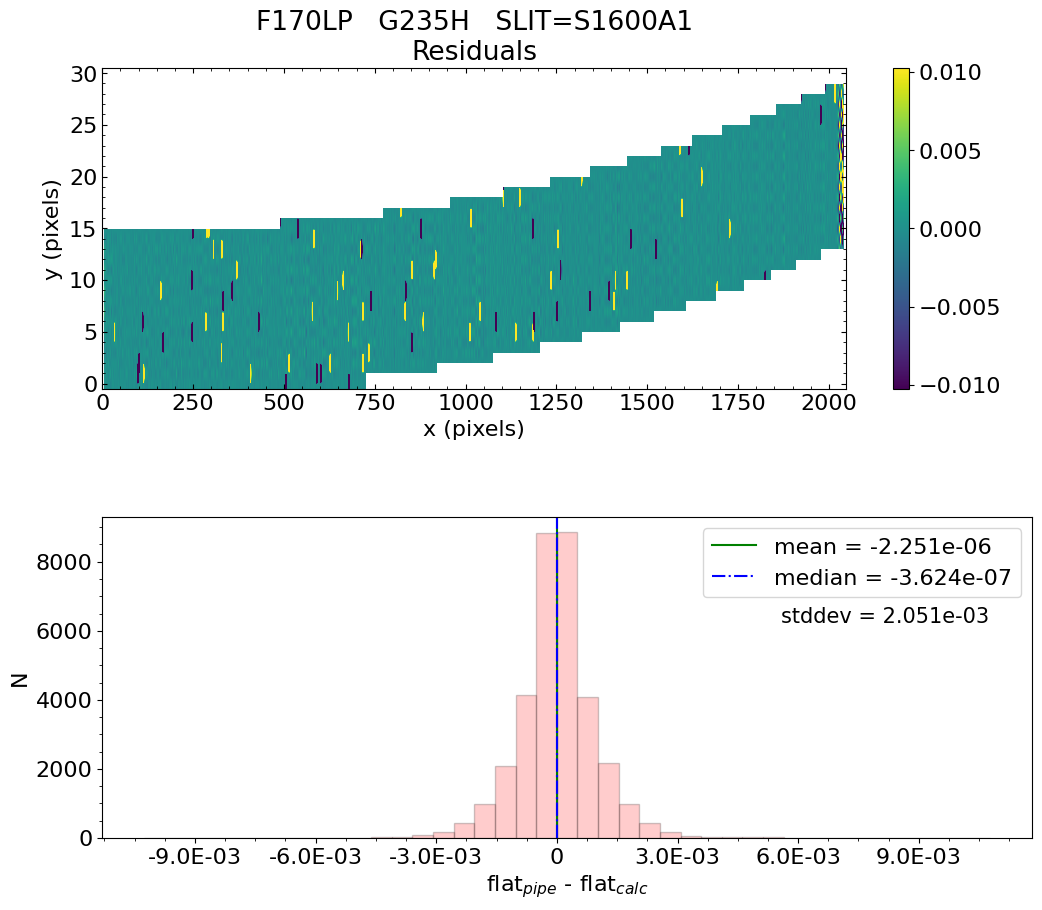


 *** Final result for flat_field test will be reported as PASSED *** 

('* Script flattest_fs.py took ', '28.650625944137573 seconds to finish.')
Did flat_field for  bots_g235h_f170lp  validation test passed?  All slits PASSED flat_field test. 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/bots_g235h_f170lp_nrs2_interpolatedflat.fits', fd=55, position=282240, mode='r', flags=557056) 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_dflat_nrs2_f_01.03.fits', fd=66, position=680480640, mode='r', flags=557056) 


Closing file:  popenfile(path='/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmp_gspi98f/nirspec_FS_sflat_G235H_OPAQUE_FLAT2_nrs2_f_01.01.fits', fd=67, position=51174720, mode='r', flags=557056) 


Closing file:  popenfile(path='/internal/data1/jenkins/worksp

In [8]:
# Get the FS data for BOTS

for mode_config, data_set_dict in testing_data.items():
    if 'mos' in mode_config or 'ifu' in mode_config:
        continue
    if 'bots' not in mode_config:
        continue
        
    print('Starting to run pipeline and test for mode: ', mode_config)
    
    for detector in detectors:
        print('Testing files for detector: ', detector)
        data = get_artifactory_file(data_set_dict, detector)
        uncal_file, sflat, fflat, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        dflat = dflat_nrs1
        if '2' in detector:
            dflat = dflat_nrs2
        
        # Make sure these keywords are properly set
        filt = fits.getval(uncal_file, 'FILTER')
        if 'OPAQUE' in filt or 'allslits' in uncal_basename.lower():
            if 'clear' in uncal_basename.lower():
                filt = 'CLEAR'
            else:
                l = uncal_basename.split("_")
                for li in l:
                    if 'lp' in li.lower():
                        filt = li
                        break
            fits.setval(uncal_file, 'FILTER', value=filt)
        print('Filter = ', filt)
        if 'bots' in uncal_basename.lower():
            fits.setval(uncal_file, 'TSOVISIT', value=True)
            fits.setval(uncal_file, 'FXD_SLIT', value='S1600A1')
        elif 'fs' in uncal_basename.lower():
            fits.setval(uncal_file, 'FXD_SLIT', value='S200A1')

        # Run the stage 1 pipeline 
        print('Running the detector1 pipeline...')
        rate_object = Detector1Pipeline.call(uncal_file)
        
        # Make sure the FXD_SLIT keyword is set correctly
        try:
            if 'full' in rate_object.meta.instrument.fixed_slit:
                rate_object.meta.instrument.fixed_slit = 'NONE'
        except TypeError:
            print('FXD_SLIT keyword = ', rate_object.meta.instrument.fixed_slit)
        
        # Run the stage 2 pipeline steps
        print('\nRunning the spec2 pipeline...')
        skip_file = False
        try:
            #pipe_object = AssignWcsStep.call(rate_object)  # commenting indiv steps, using spec2 instead
            parameter_dict = {"flat_field": {"save_interpolated_flat": True},
                              "pathloss": {"skip": True},
                              "barshadow": {"skip": True},
                              "photom": {"skip": True},
                              "resample_spec": {"skip": True},
                              "cube_build": {"skip": True},
                              "extract_1d": {"skip": True}
                             }
            flat_field_object = Spec2Pipeline.call(rate_object, steps=parameter_dict)
        except:
            #print("No open slits fall on detector ", det)  # usually why assign_wcs crashes
            print("* Spec2 pipeline CRASHED or exited with no output for detector ", detector)
            print("  Skipping test for this file. \n")
            skip_file = True
            
        if not skip_file:   
            # accepted threshold difference with respect to benchmark files
            threshold_diff = 9.999e-5
            if 'prism' in uncal_basename.lower():
                threshold_diff = 9.999e-3
            
            # Run the validation test
            %matplotlib inline
            interpolated_flat = os.path.basename(uncal_file).replace('uncal', 'interpolatedflat')
            print('Running flat field test for BOTS...')
            result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(
                                                                            flat_field_object,
                                                                            dflat_path=dflat,
                                                                            sflat_path=sflat, 
                                                                            fflat_path=fflat,
                                                                            writefile=writefile,
                                                                            show_figs=show_figs, 
                                                                            save_figs=save_figs,
                                                                            interpolated_flat=interpolated_flat,
                                                                            threshold_diff=threshold_diff,
                                                                            debug=False)
        else:
            result, result_msg = 'skipped', 'skipped'

        # Did the test passed 
        print("Did flat_field for ", mode_config, " validation test passed? ", result_msg, "\n\n")
        rd = {uncal_basename: result}
        results_dict.update(rd)
        
        # close all open files
        psutil.Process().open_files()
        closing_files = []
        for fd in psutil.Process().open_files():
            if data_dir.name in fd.path:
                closing_files.append(fd)
        for fd in closing_files:
            try:
                print('Closing file: ', fd, '\n\n')
                open(fd.fd).close()
            except:
                print('File already closed: ', fd, '\n\n')


In [9]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    if not isinstance(val, str):
        if val:
            val = 'PASSED'
        else:
            val = 'FAILED'
    print('{:<42} {:<8}'.format(key, val))


These are the final results of the tests: 
bots_g235h_f170lp_nrs1_uncal.fits          PASSED  
bots_g235h_f170lp_nrs2_uncal.fits          PASSED  


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Sr. Science Software Engineer, NIRSpec
<br>**Updated On:** Sep/23/2022

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 